In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pong

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pydot

tf.enable_eager_execution()

tf.__version__

'1.14.0'

In [36]:
SEQ_LEN = 128
W, H = 40, 40

def data_input():
    for (d, c), (f, g) in pong.games_generator(W, H, SEQ_LEN, stochasticity=0.85):
        yield (np.array([np.sin(d), np.cos(d)]), c), (f,)

make_dataset = lambda bs: tf.data.Dataset.from_generator(
    data_input,
    output_types=((tf.float32, tf.float32), (tf.float32,)),
).batch(bs).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [114]:
class Model:
    INTERNAL_SIZE = 24

    def project_game_init(self, init_x):
        self.project_state = tf.keras.layers.Dense(
            Model.INTERNAL_SIZE,
            name='project_activation',
            activation='relu'
        )

        return self.project_state(init_x)

    def rollout(self, initial_state, user_input):
        self.gru = tf.keras.layers.GRU(
            Model.INTERNAL_SIZE,
            return_sequences=True,
            name='gru',
            activation='tanh'
        )
        self.gru2 = tf.keras.layers.GRU(
            Model.INTERNAL_SIZE,
            return_sequences=True,
            name='gru2',
            activation='relu'
        )
        self.gru3 = tf.keras.layers.GRU(
            Model.INTERNAL_SIZE,
            return_sequences=True,
            name='gru3',
            activation='relu'
        )
        x = self.gru(user_input, initial_state=initial_state)
        x = self.gru2(x)
        x = self.gru3(x)

        return x

    def render(self, memory):
        self.renderer = tf.keras.layers.Dense(W * H, activation='sigmoid', name='frame_matrix')
        self.reshaper = tf.keras.layers.Reshape((-1, W, H), name='frame_vector')

        return self.reshaper(self.renderer(memory))

    def __init__(self):
        game_init = tf.keras.layers.Input(shape=(2), name='game_init')
        user_input = tf.keras.layers.Input(shape=(None, 2), name='user_input')

        initial_state = self.project_game_init(game_init)
        rollout_memory = self.rollout(initial_state, user_input)
        frame = self.render(rollout_memory)

        self.net = tf.keras.Model([game_init, user_input], [frame])

        initial_learning_rate = 0.005
        self.lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=10000,
            decay_rate=0.9,
            staircase=True
        )
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr_schedule)

        self.net.compile(
            loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['mse', 'accuracy']
        )

In [115]:
model = Model()
model.net.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
game_init (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
project_activation (Dense)      (None, 24)           72          game_init[0][0]                  
__________________________________________________________________________________________________
gru (GRU)                       (None, None, 24)     1944        user_input[0][0]                 
                                                                 project_activation[0][0]  

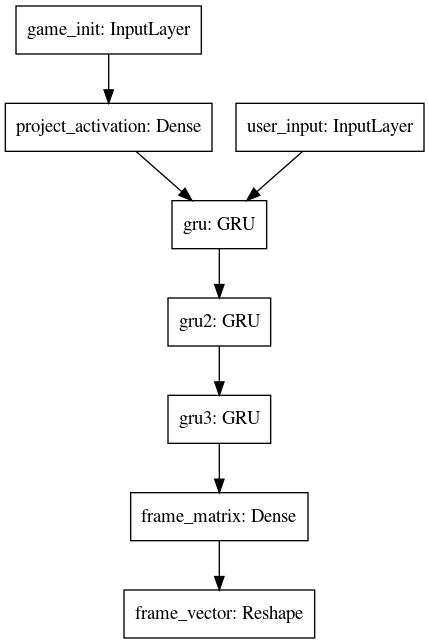

In [116]:
tf.keras.utils.plot_model(model.net, to_file='model.png')

In [117]:
frame_nums = [1, 4, 8, 16, 32, 64, 127]

class PlotCallback(tf.keras.callbacks.Callback):
    def plot_pairwise_frames(self, frame_nums):
        X, Y = list(make_dataset(1).take(1))[0]
        (directions, controls), (frames,) = X, Y
        pred_frames = model.net.predict([directions, controls])

        plot_size = 2
        num_imgs = len(frame_nums)
        fig, axs = plt.subplots(2, num_imgs, figsize=(plot_size * num_imgs, plot_size * 2))

        for i, f in enumerate(frame_nums):
            l, r = (axs[0, i], axs[1, i])

            l.imshow(frames[0, f], cmap='bwr')
            r.imshow(pred_frames[0, f], cmap='bwr')

            l.set_xticklabels([])
            r.set_xticklabels([])
            l.set_yticklabels([])
            r.set_yticklabels([])

        fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    def on_epoch_begin(self, batch, logs=None):
        self.plot_pairwise_frames(frame_nums)
        plt.show()

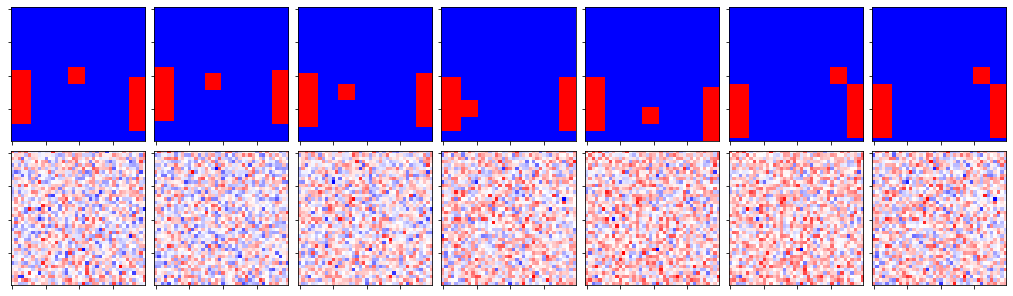

Epoch 1/2500
100/100 [==============================] - 59s 589ms/step - loss: 0.2390 - mean_squared_error: 0.0710 - acc: 0.9297 - val_loss: 0.1647 - val_mean_squared_error: 0.0457 - val_acc: 0.9401


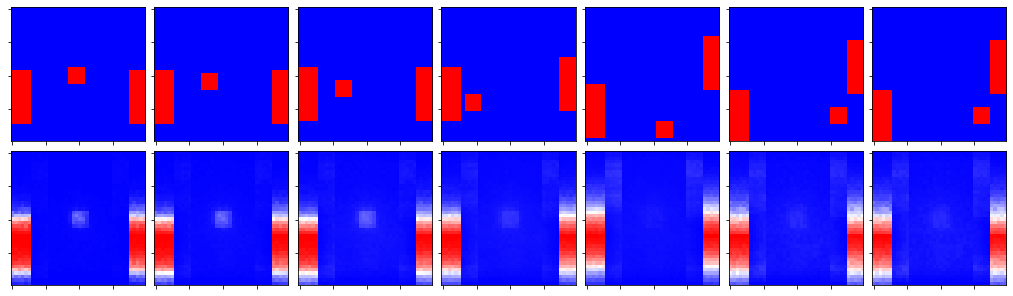

Epoch 2/2500
100/100 [==============================] - 54s 535ms/step - loss: 0.1620 - mean_squared_error: 0.0446 - acc: 0.9421 - val_loss: 0.1639 - val_mean_squared_error: 0.0456 - val_acc: 0.9407


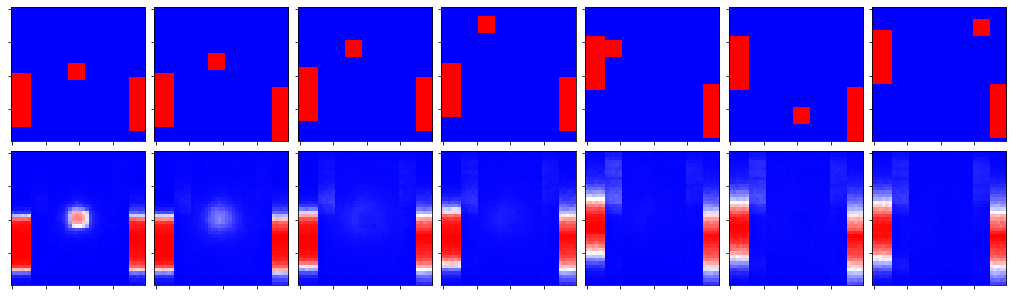

Epoch 3/2500
100/100 [==============================] - 53s 527ms/step - loss: 0.1433 - mean_squared_error: 0.0386 - acc: 0.9506 - val_loss: 0.1348 - val_mean_squared_error: 0.0360 - val_acc: 0.9541


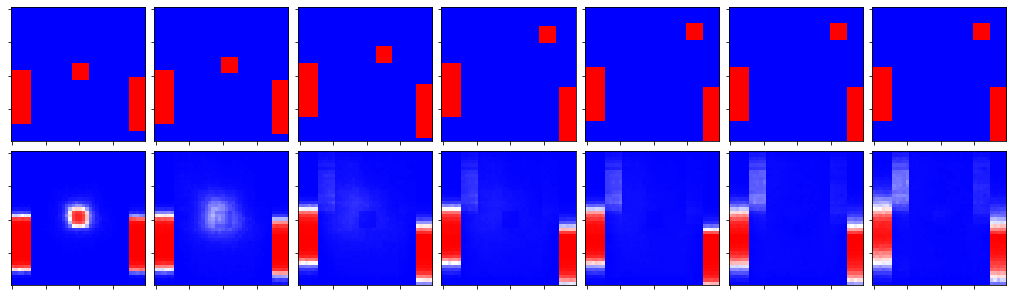

Epoch 4/2500
100/100 [==============================] - 53s 526ms/step - loss: 0.1288 - mean_squared_error: 0.0345 - acc: 0.9563 - val_loss: 0.1172 - val_mean_squared_error: 0.0320 - val_acc: 0.9588


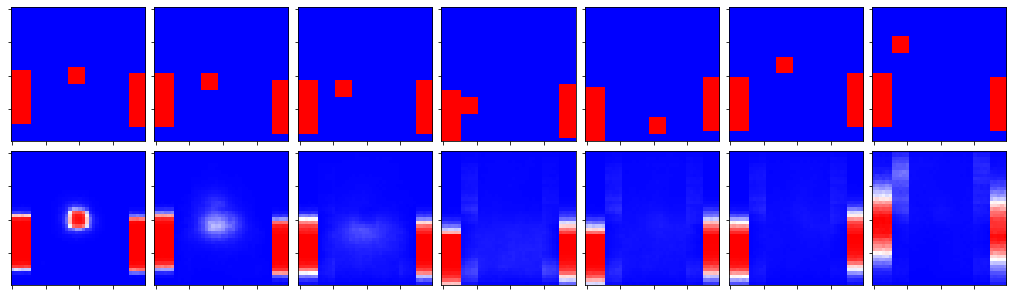

Epoch 5/2500
100/100 [==============================] - 52s 523ms/step - loss: 0.1209 - mean_squared_error: 0.0324 - acc: 0.9588 - val_loss: 0.1176 - val_mean_squared_error: 0.0323 - val_acc: 0.9589


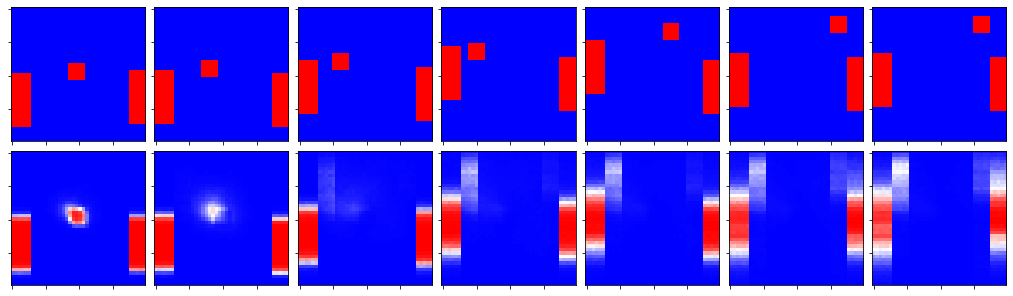

Epoch 6/2500
100/100 [==============================] - 55s 550ms/step - loss: 0.1185 - mean_squared_error: 0.0318 - acc: 0.9595 - val_loss: 0.1133 - val_mean_squared_error: 0.0306 - val_acc: 0.9611


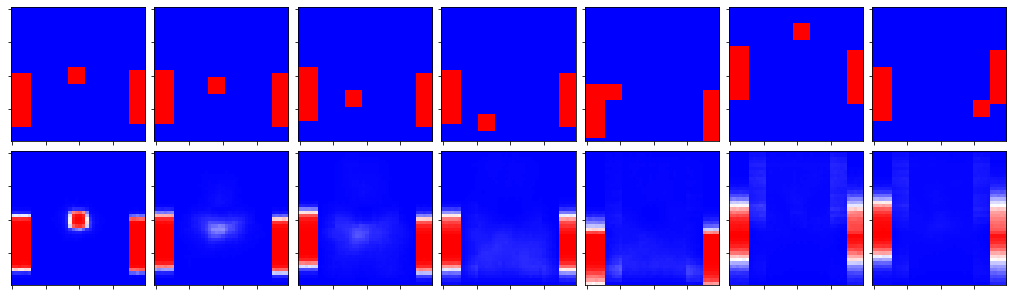

Epoch 7/2500
100/100 [==============================] - 52s 518ms/step - loss: 0.1115 - mean_squared_error: 0.0300 - acc: 0.9618 - val_loss: 0.1084 - val_mean_squared_error: 0.0294 - val_acc: 0.9623


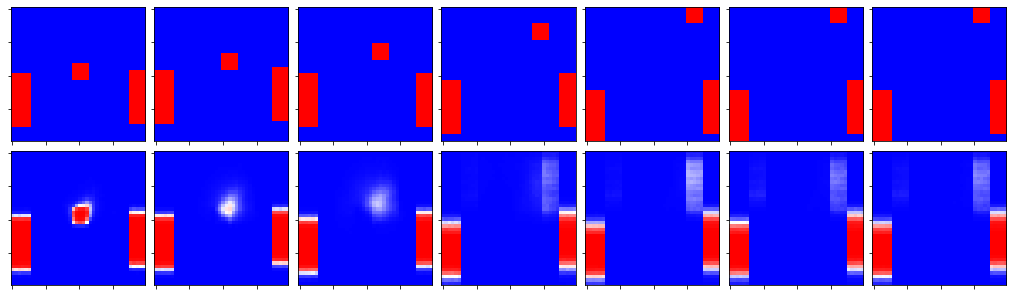

Epoch 8/2500
100/100 [==============================] - 52s 523ms/step - loss: 0.1108 - mean_squared_error: 0.0298 - acc: 0.9621 - val_loss: 0.1101 - val_mean_squared_error: 0.0293 - val_acc: 0.9629


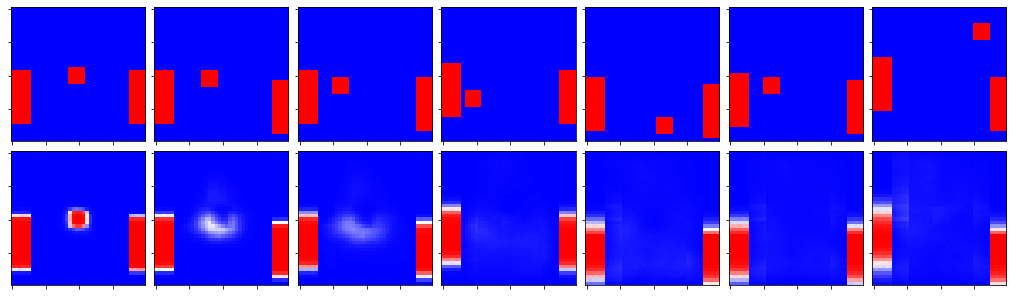

Epoch 9/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.1100 - mean_squared_error: 0.0296 - acc: 0.9624 - val_loss: 0.1092 - val_mean_squared_error: 0.0292 - val_acc: 0.9627


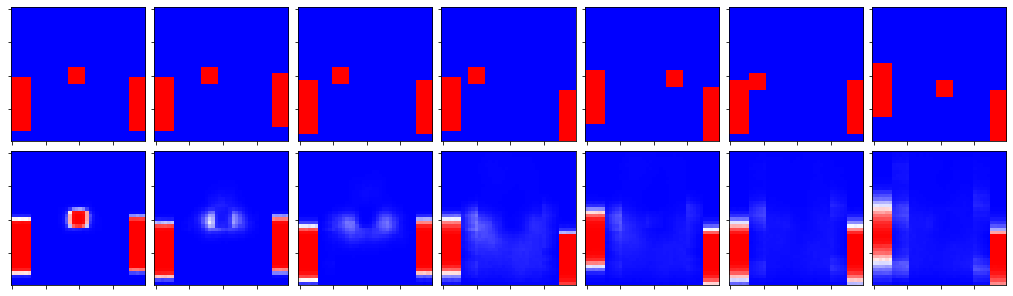

Epoch 10/2500
100/100 [==============================] - 51s 508ms/step - loss: 0.1073 - mean_squared_error: 0.0288 - acc: 0.9631 - val_loss: 0.1129 - val_mean_squared_error: 0.0303 - val_acc: 0.9612


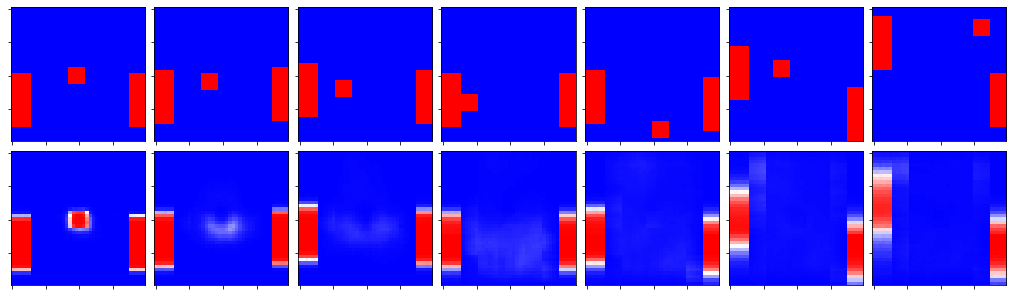

Epoch 11/2500
100/100 [==============================] - 51s 507ms/step - loss: 0.1066 - mean_squared_error: 0.0288 - acc: 0.9630 - val_loss: 0.1062 - val_mean_squared_error: 0.0288 - val_acc: 0.9630


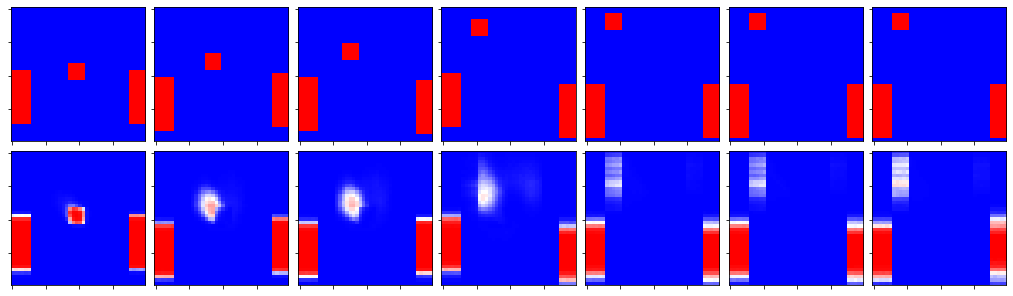

Epoch 12/2500
100/100 [==============================] - 51s 511ms/step - loss: 0.1042 - mean_squared_error: 0.0282 - acc: 0.9637 - val_loss: 0.0908 - val_mean_squared_error: 0.0252 - val_acc: 0.9671


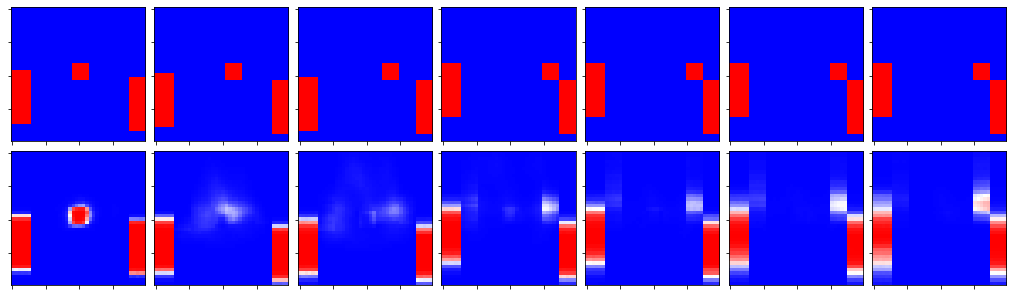

Epoch 13/2500
100/100 [==============================] - 51s 513ms/step - loss: 0.1015 - mean_squared_error: 0.0274 - acc: 0.9648 - val_loss: 0.1002 - val_mean_squared_error: 0.0269 - val_acc: 0.9657


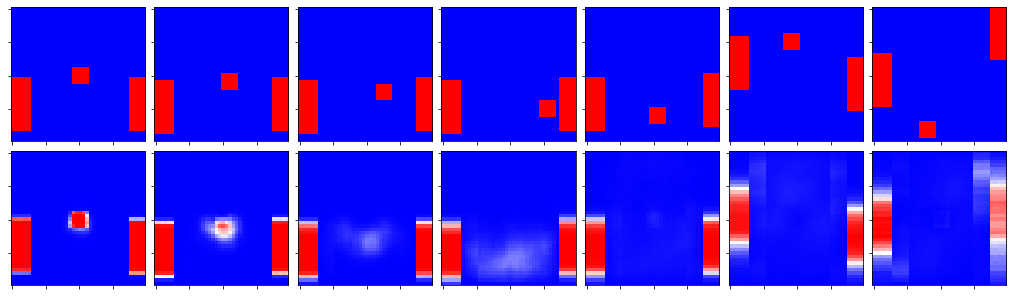

Epoch 14/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1005 - mean_squared_error: 0.0271 - acc: 0.9654 - val_loss: 0.0945 - val_mean_squared_error: 0.0253 - val_acc: 0.9677


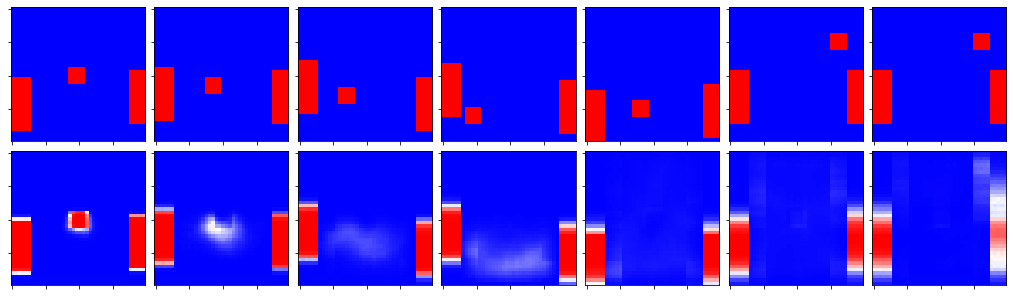

Epoch 15/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1008 - mean_squared_error: 0.0271 - acc: 0.9653 - val_loss: 0.1002 - val_mean_squared_error: 0.0271 - val_acc: 0.9657


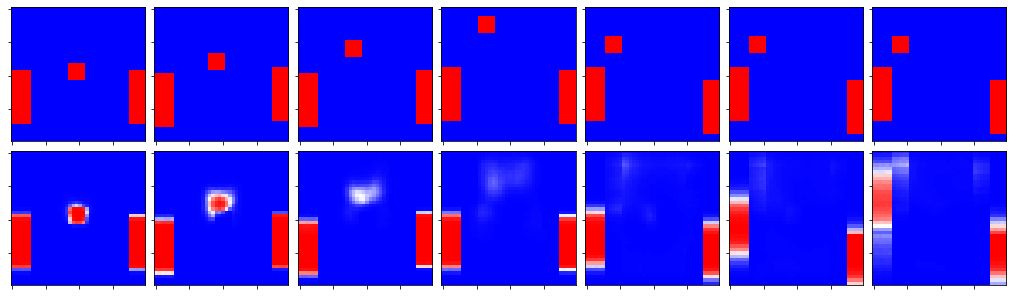

Epoch 16/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0964 - mean_squared_error: 0.0260 - acc: 0.9667 - val_loss: 0.0962 - val_mean_squared_error: 0.0259 - val_acc: 0.9672


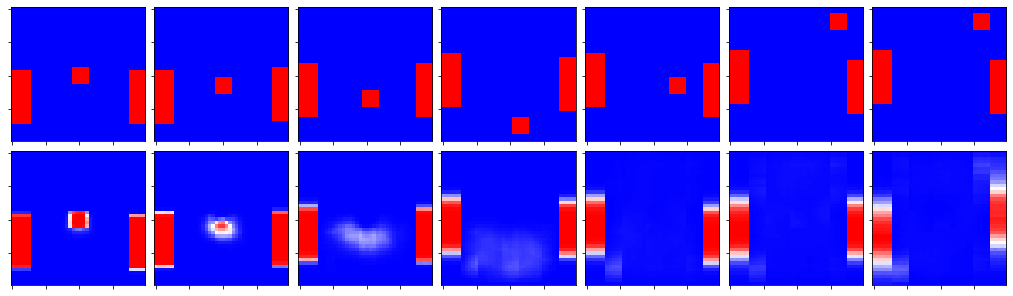

Epoch 17/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0989 - mean_squared_error: 0.0268 - acc: 0.9656 - val_loss: 0.1046 - val_mean_squared_error: 0.0291 - val_acc: 0.9620


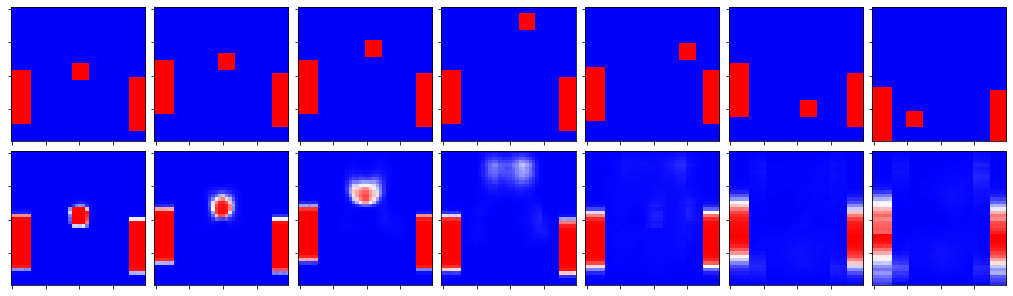

Epoch 18/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0957 - mean_squared_error: 0.0259 - acc: 0.9669 - val_loss: 0.0970 - val_mean_squared_error: 0.0261 - val_acc: 0.9662


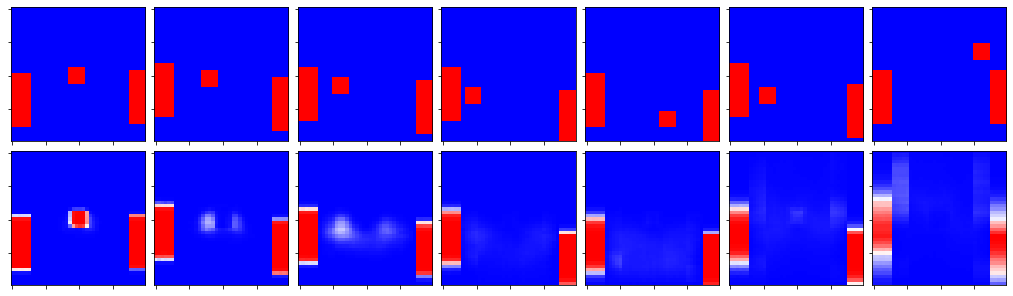

Epoch 19/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0955 - mean_squared_error: 0.0257 - acc: 0.9672 - val_loss: 0.0924 - val_mean_squared_error: 0.0250 - val_acc: 0.9680


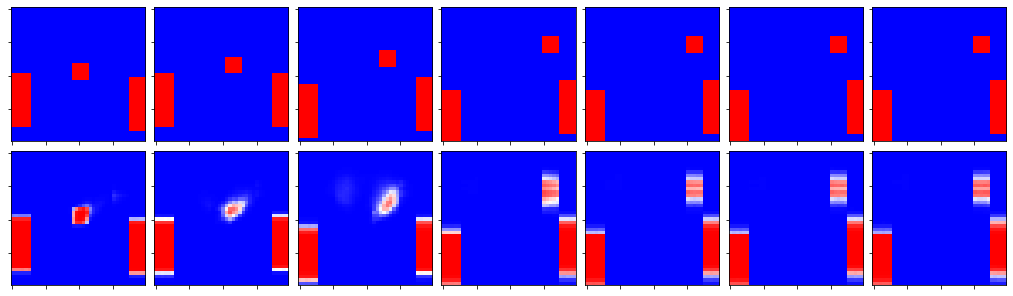

Epoch 20/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0953 - mean_squared_error: 0.0257 - acc: 0.9672 - val_loss: 0.0918 - val_mean_squared_error: 0.0250 - val_acc: 0.9678


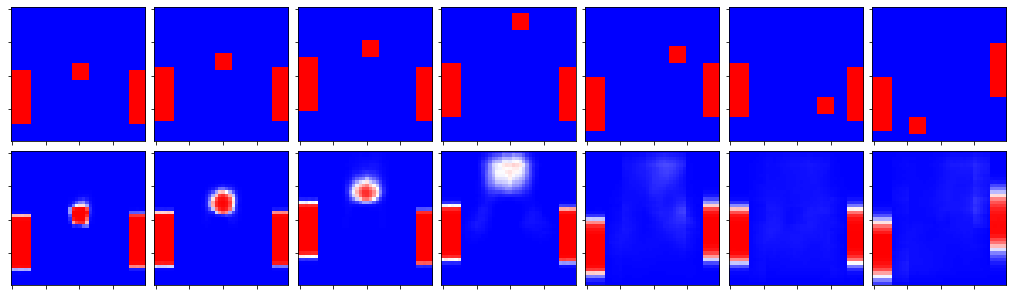

Epoch 21/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0937 - mean_squared_error: 0.0253 - acc: 0.9676 - val_loss: 0.0951 - val_mean_squared_error: 0.0257 - val_acc: 0.9674


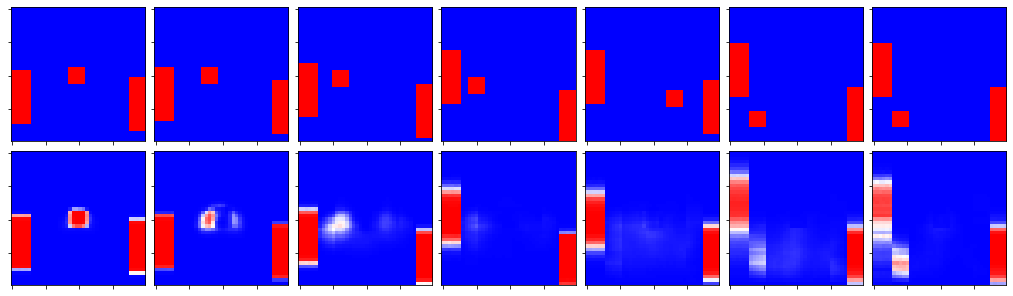

Epoch 22/2500
100/100 [==============================] - 51s 508ms/step - loss: 0.0938 - mean_squared_error: 0.0254 - acc: 0.9675 - val_loss: 0.0946 - val_mean_squared_error: 0.0260 - val_acc: 0.9662


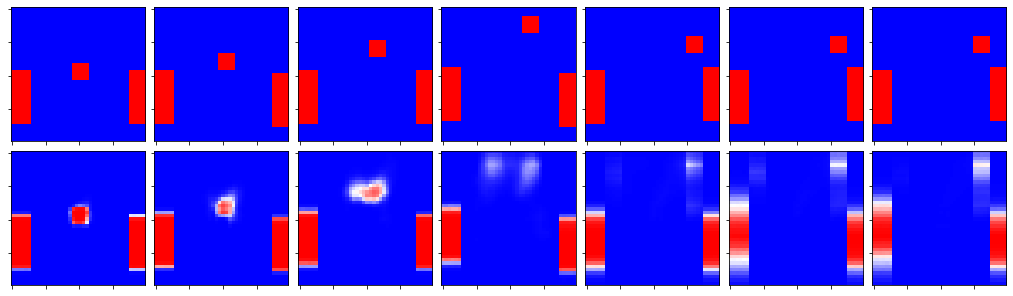

Epoch 23/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0924 - mean_squared_error: 0.0249 - acc: 0.9683 - val_loss: 0.0955 - val_mean_squared_error: 0.0261 - val_acc: 0.9664


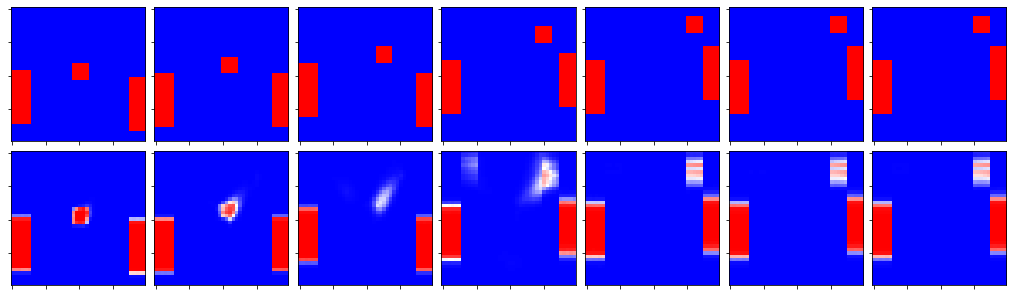

Epoch 24/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.0925 - mean_squared_error: 0.0251 - acc: 0.9680 - val_loss: 0.0875 - val_mean_squared_error: 0.0236 - val_acc: 0.9702


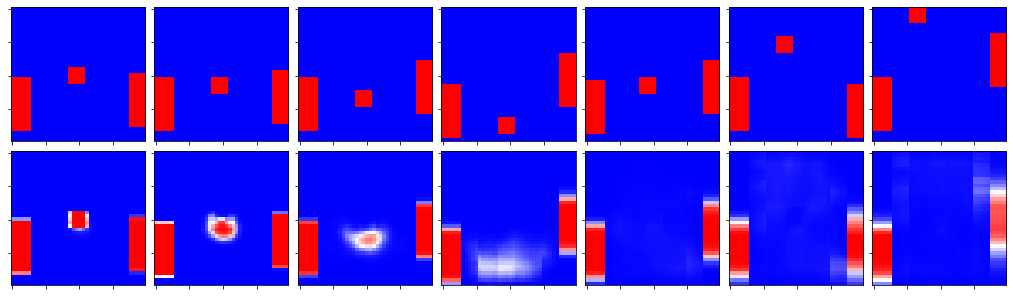

Epoch 25/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0902 - mean_squared_error: 0.0243 - acc: 0.9690 - val_loss: 0.0997 - val_mean_squared_error: 0.0269 - val_acc: 0.9658


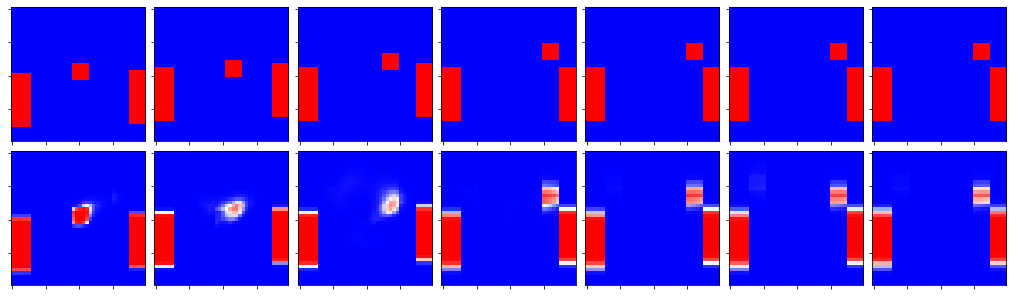

Epoch 26/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0890 - mean_squared_error: 0.0240 - acc: 0.9693 - val_loss: 0.0899 - val_mean_squared_error: 0.0247 - val_acc: 0.9682


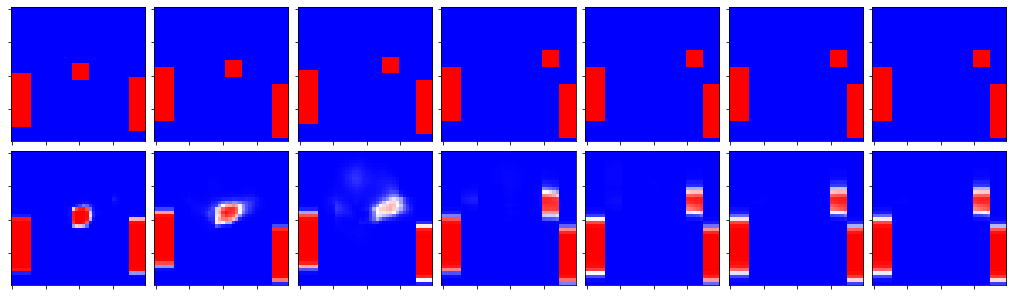

Epoch 27/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.0893 - mean_squared_error: 0.0241 - acc: 0.9693 - val_loss: 0.0799 - val_mean_squared_error: 0.0211 - val_acc: 0.9737


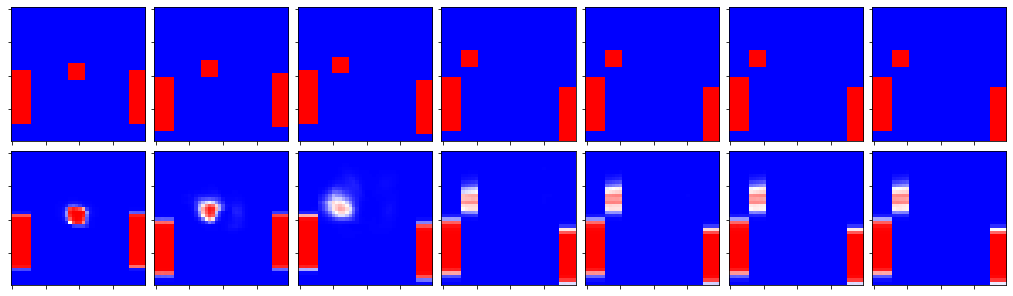

Epoch 28/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0889 - mean_squared_error: 0.0240 - acc: 0.9694 - val_loss: 0.0975 - val_mean_squared_error: 0.0253 - val_acc: 0.9684


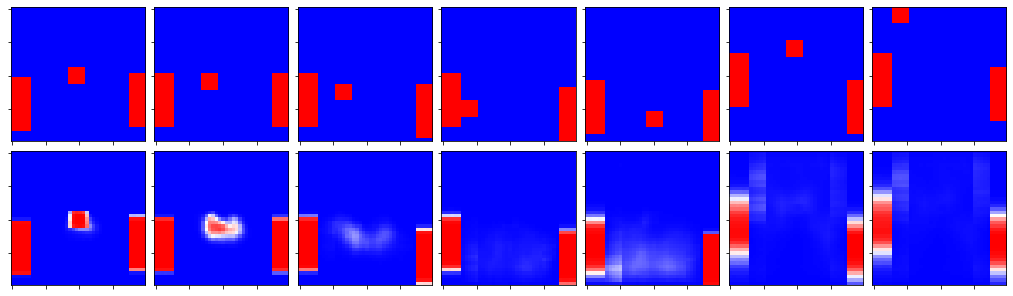

Epoch 29/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0878 - mean_squared_error: 0.0237 - acc: 0.9699 - val_loss: 0.0913 - val_mean_squared_error: 0.0242 - val_acc: 0.9695


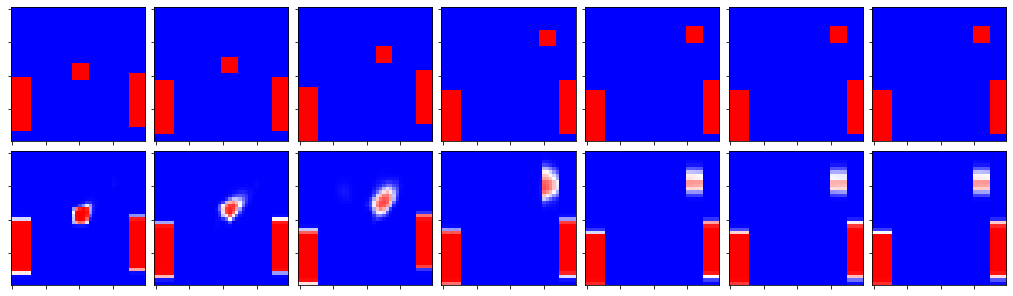

Epoch 30/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0885 - mean_squared_error: 0.0238 - acc: 0.9697 - val_loss: 0.0855 - val_mean_squared_error: 0.0228 - val_acc: 0.9713


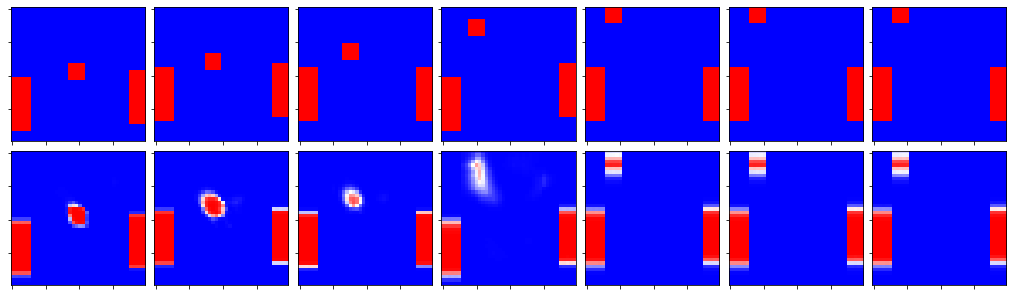

Epoch 31/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0869 - mean_squared_error: 0.0234 - acc: 0.9703 - val_loss: 0.0861 - val_mean_squared_error: 0.0232 - val_acc: 0.9705


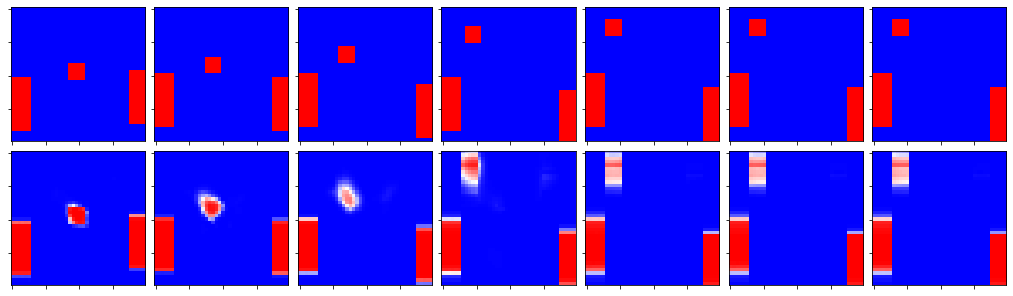

Epoch 32/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0883 - mean_squared_error: 0.0238 - acc: 0.9697 - val_loss: 0.0807 - val_mean_squared_error: 0.0218 - val_acc: 0.9723


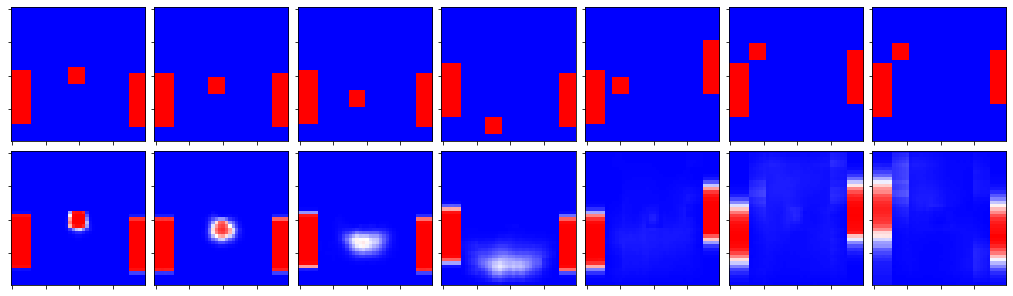

Epoch 33/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.0901 - mean_squared_error: 0.0243 - acc: 0.9690 - val_loss: 0.0904 - val_mean_squared_error: 0.0238 - val_acc: 0.9700


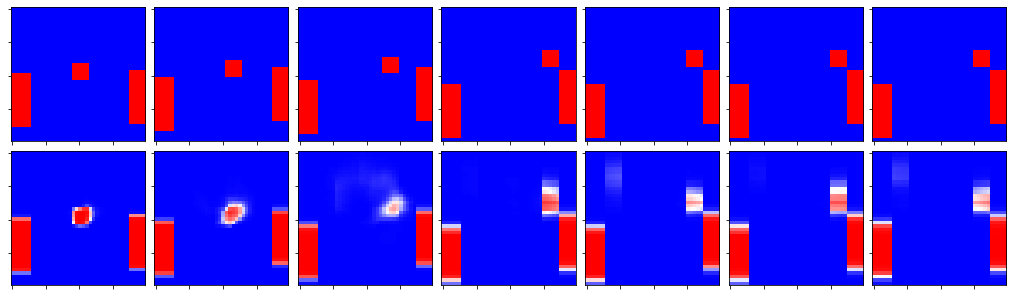

Epoch 34/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.0882 - mean_squared_error: 0.0238 - acc: 0.9696 - val_loss: 0.0832 - val_mean_squared_error: 0.0226 - val_acc: 0.9710


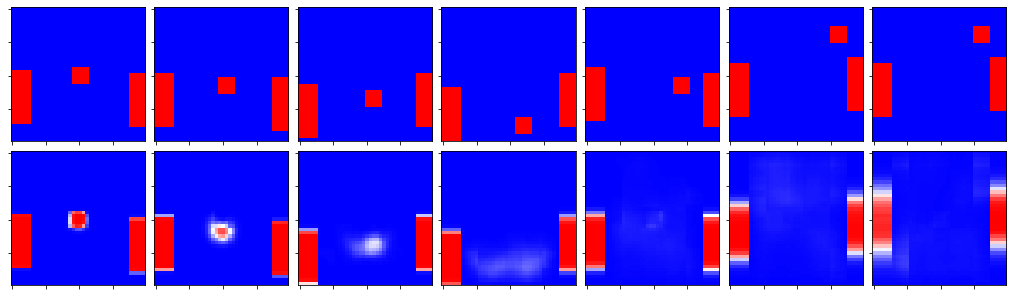

Epoch 35/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0873 - mean_squared_error: 0.0236 - acc: 0.9699 - val_loss: 0.0965 - val_mean_squared_error: 0.0263 - val_acc: 0.9664


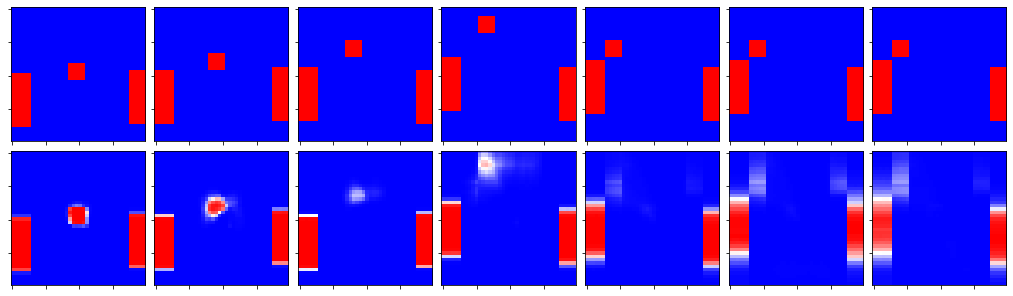

Epoch 36/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0878 - mean_squared_error: 0.0237 - acc: 0.9698 - val_loss: 0.0872 - val_mean_squared_error: 0.0237 - val_acc: 0.9695


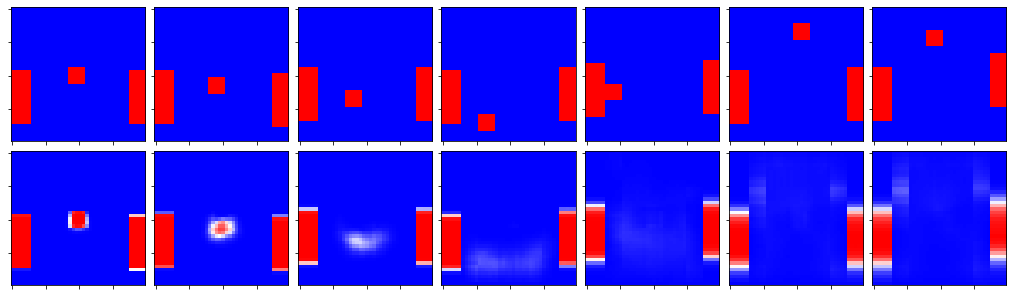

Epoch 37/2500
100/100 [==============================] - 51s 506ms/step - loss: 0.0876 - mean_squared_error: 0.0236 - acc: 0.9700 - val_loss: 0.0799 - val_mean_squared_error: 0.0217 - val_acc: 0.9722


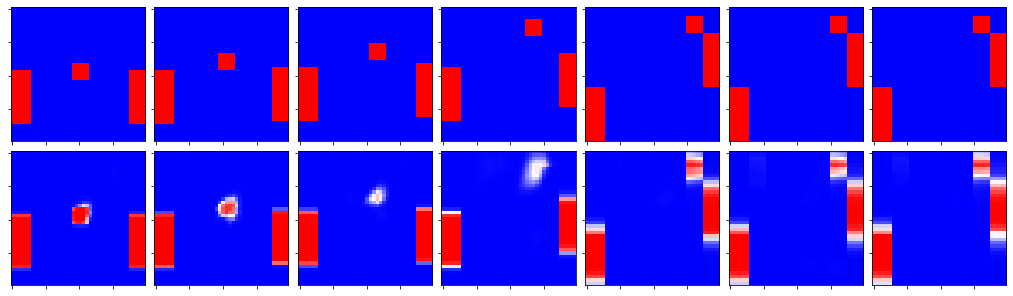

Epoch 38/2500
100/100 [==============================] - 51s 507ms/step - loss: 0.0856 - mean_squared_error: 0.0231 - acc: 0.9707 - val_loss: 0.0807 - val_mean_squared_error: 0.0219 - val_acc: 0.9717


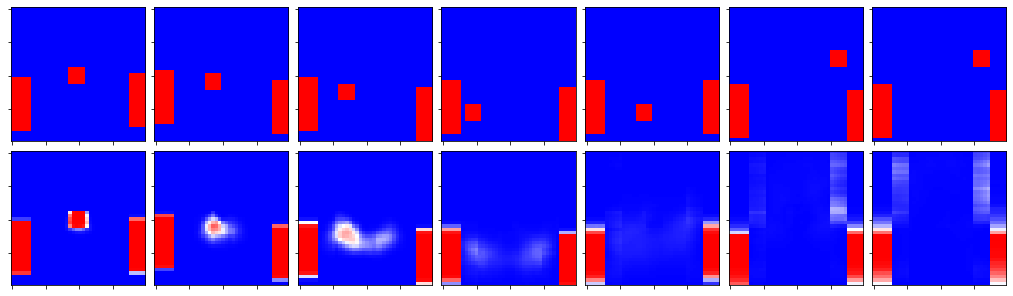

Epoch 39/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0866 - mean_squared_error: 0.0235 - acc: 0.9701 - val_loss: 0.0950 - val_mean_squared_error: 0.0250 - val_acc: 0.9685


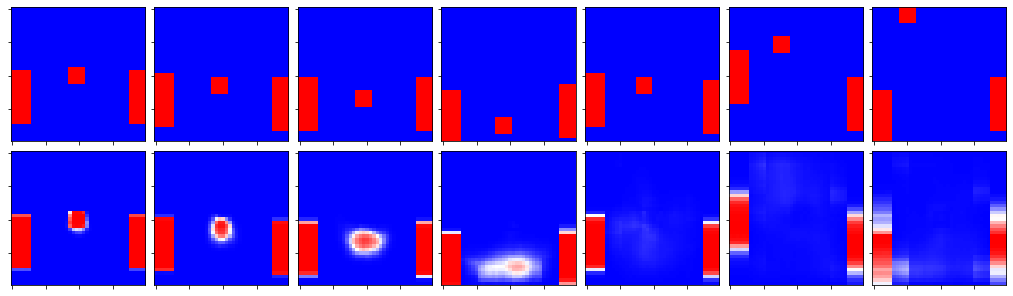

Epoch 40/2500
100/100 [==============================] - 51s 506ms/step - loss: 0.0845 - mean_squared_error: 0.0228 - acc: 0.9710 - val_loss: 0.0899 - val_mean_squared_error: 0.0241 - val_acc: 0.9694


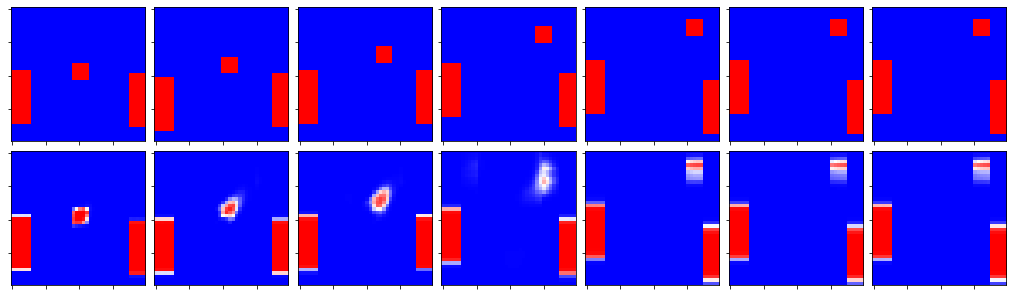

Epoch 41/2500
100/100 [==============================] - 51s 506ms/step - loss: 0.0860 - mean_squared_error: 0.0232 - acc: 0.9705 - val_loss: 0.0829 - val_mean_squared_error: 0.0226 - val_acc: 0.9710


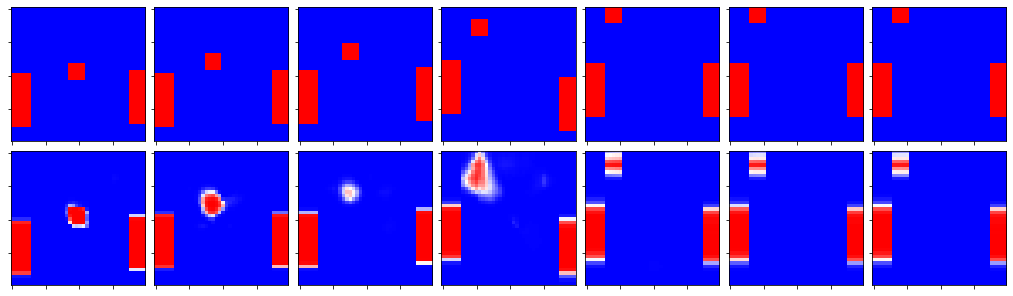

Epoch 42/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0843 - mean_squared_error: 0.0227 - acc: 0.9711 - val_loss: 0.0791 - val_mean_squared_error: 0.0215 - val_acc: 0.9724


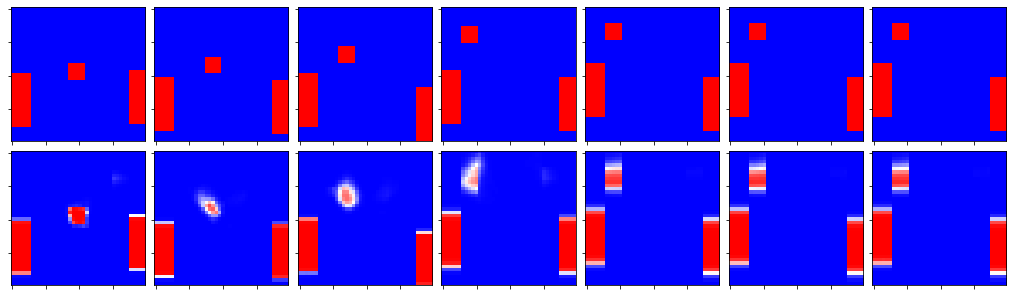

Epoch 43/2500
100/100 [==============================] - 51s 506ms/step - loss: 0.0832 - mean_squared_error: 0.0224 - acc: 0.9716 - val_loss: 0.0861 - val_mean_squared_error: 0.0229 - val_acc: 0.9713


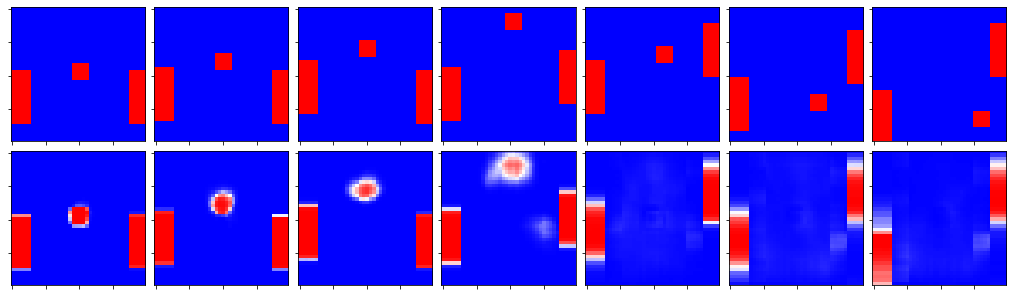

Epoch 44/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0823 - mean_squared_error: 0.0223 - acc: 0.9717 - val_loss: 0.0828 - val_mean_squared_error: 0.0223 - val_acc: 0.9717


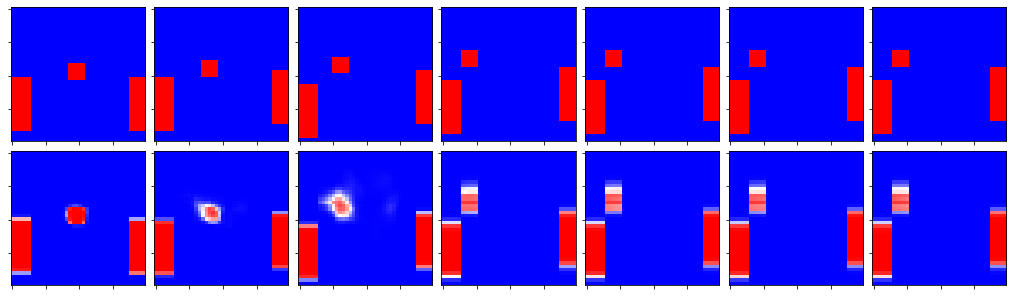

Epoch 45/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0839 - mean_squared_error: 0.0227 - acc: 0.9711 - val_loss: 0.0918 - val_mean_squared_error: 0.0241 - val_acc: 0.9701


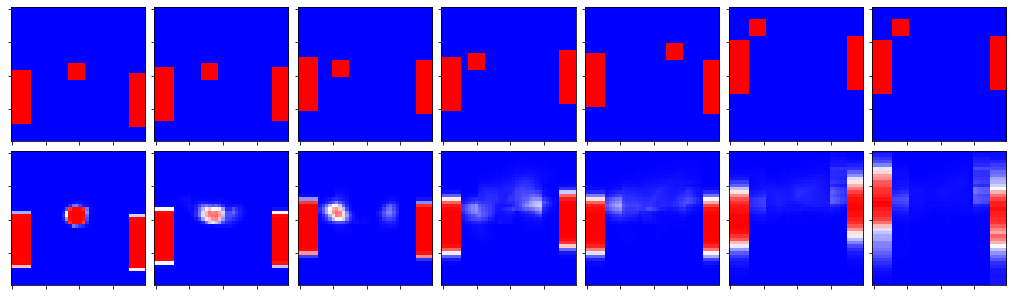

Epoch 46/2500
100/100 [==============================] - 51s 506ms/step - loss: 0.0840 - mean_squared_error: 0.0225 - acc: 0.9715 - val_loss: 0.0860 - val_mean_squared_error: 0.0234 - val_acc: 0.9701


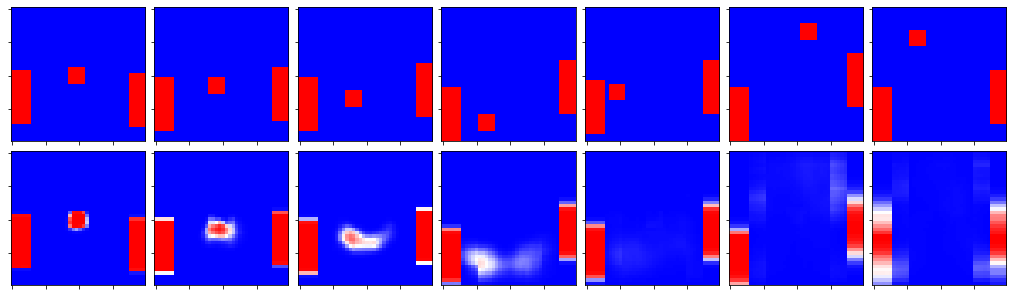

Epoch 47/2500
100/100 [==============================] - 51s 506ms/step - loss: 0.0848 - mean_squared_error: 0.0228 - acc: 0.9710 - val_loss: 0.0866 - val_mean_squared_error: 0.0231 - val_acc: 0.9704


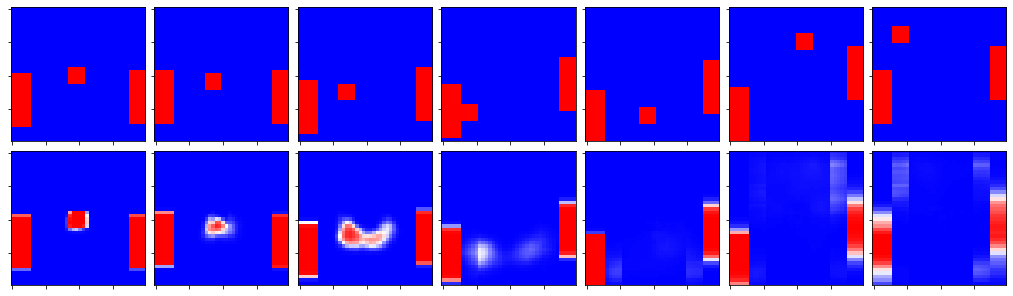

Epoch 48/2500
100/100 [==============================] - 51s 506ms/step - loss: 0.0808 - mean_squared_error: 0.0219 - acc: 0.9721 - val_loss: 0.0804 - val_mean_squared_error: 0.0216 - val_acc: 0.9724


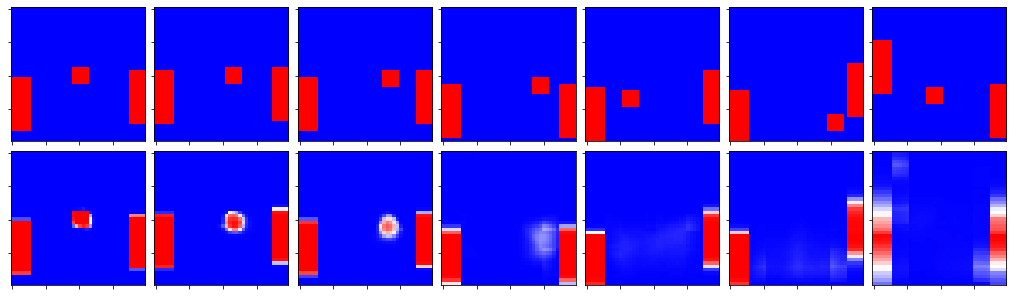

Epoch 49/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.0821 - mean_squared_error: 0.0221 - acc: 0.9719 - val_loss: 0.0839 - val_mean_squared_error: 0.0227 - val_acc: 0.9709


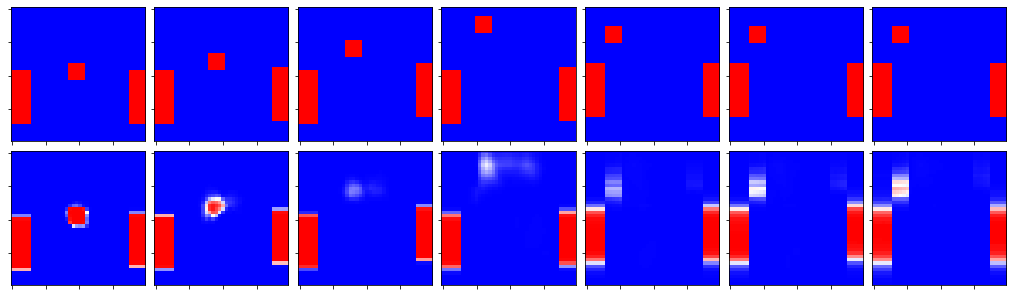

Epoch 50/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.0813 - mean_squared_error: 0.0220 - acc: 0.9720 - val_loss: 0.0749 - val_mean_squared_error: 0.0198 - val_acc: 0.9753


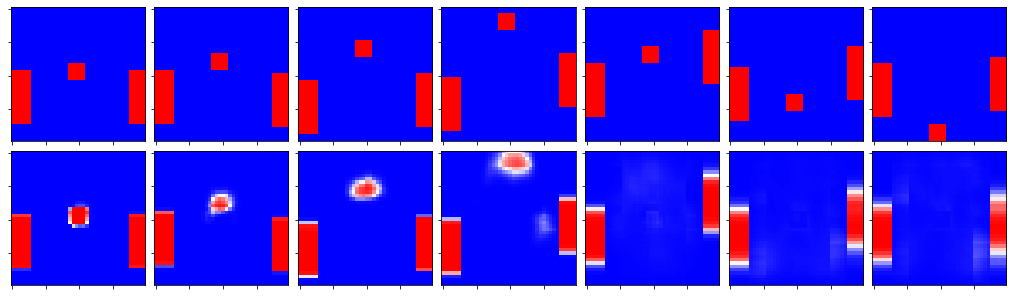

Epoch 51/2500
100/100 [==============================] - 51s 505ms/step - loss: 0.0843 - mean_squared_error: 0.0228 - acc: 0.9710 - val_loss: 0.0745 - val_mean_squared_error: 0.0207 - val_acc: 0.9729


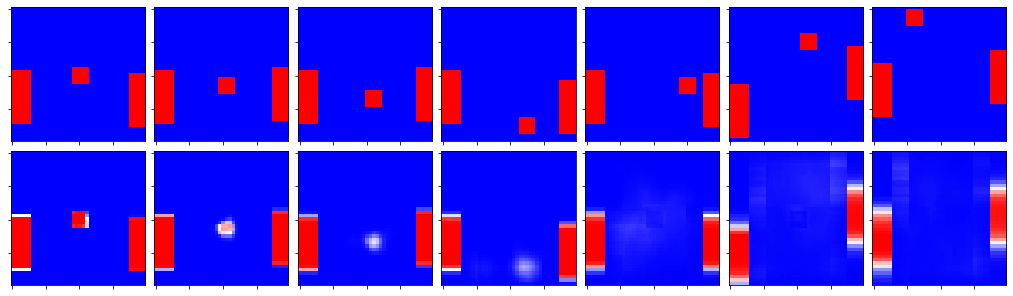

Epoch 52/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0853 - mean_squared_error: 0.0231 - acc: 0.9706 - val_loss: 0.0789 - val_mean_squared_error: 0.0212 - val_acc: 0.9727


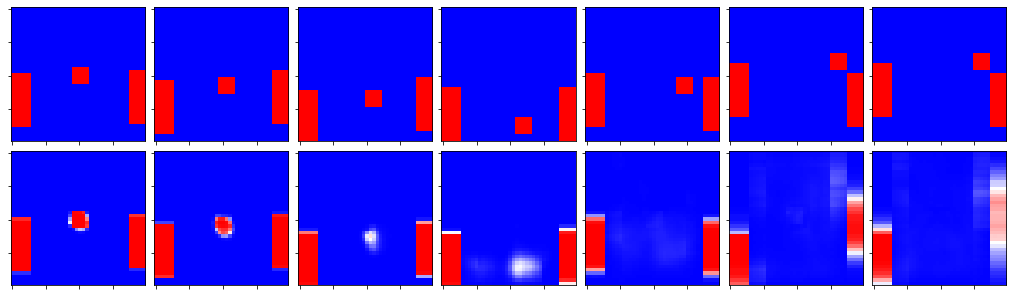

Epoch 53/2500
100/100 [==============================] - 51s 505ms/step - loss: 0.0800 - mean_squared_error: 0.0216 - acc: 0.9726 - val_loss: 0.0837 - val_mean_squared_error: 0.0232 - val_acc: 0.9697


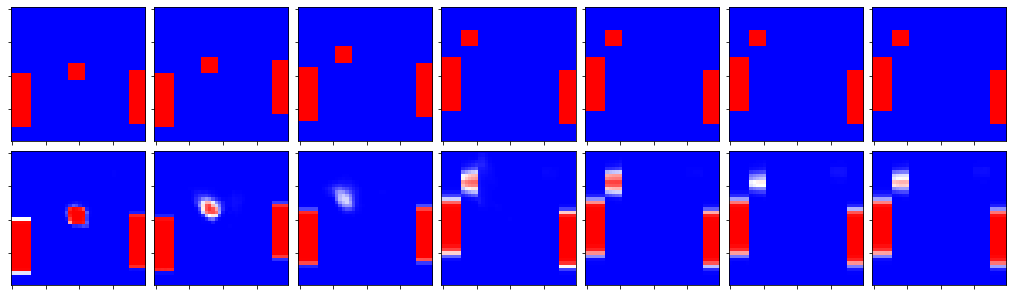

Epoch 54/2500
100/100 [==============================] - 51s 506ms/step - loss: 0.0853 - mean_squared_error: 0.0230 - acc: 0.9707 - val_loss: 0.0822 - val_mean_squared_error: 0.0221 - val_acc: 0.9718


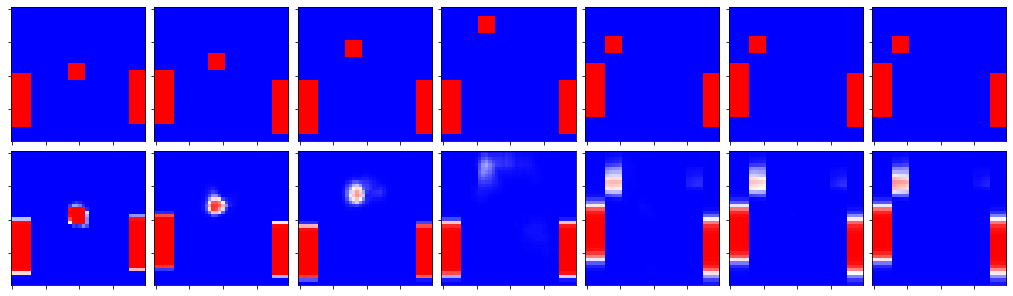

Epoch 55/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0808 - mean_squared_error: 0.0218 - acc: 0.9723 - val_loss: 0.0755 - val_mean_squared_error: 0.0205 - val_acc: 0.9739


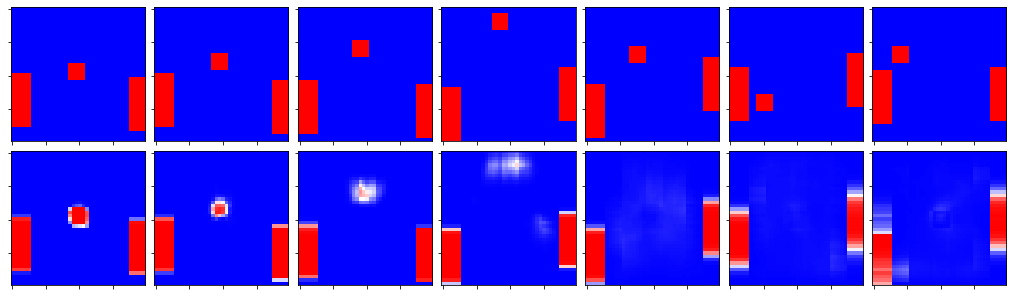

Epoch 56/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.0820 - mean_squared_error: 0.0221 - acc: 0.9719 - val_loss: 0.0842 - val_mean_squared_error: 0.0230 - val_acc: 0.9708


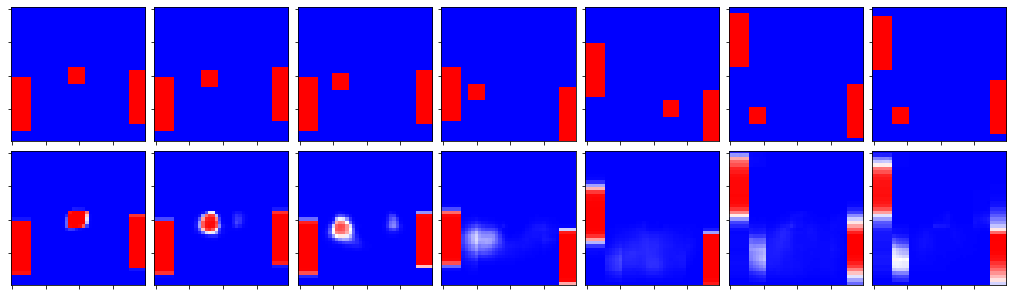

Epoch 57/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0856 - mean_squared_error: 0.0233 - acc: 0.9702 - val_loss: 0.0805 - val_mean_squared_error: 0.0221 - val_acc: 0.9716


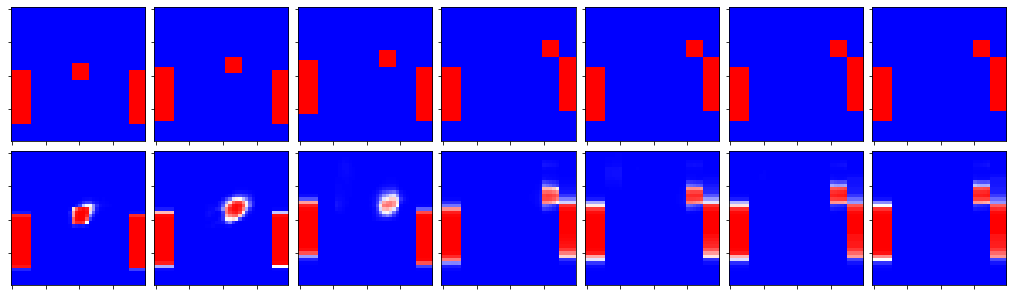

Epoch 58/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0794 - mean_squared_error: 0.0215 - acc: 0.9726 - val_loss: 0.0767 - val_mean_squared_error: 0.0211 - val_acc: 0.9729


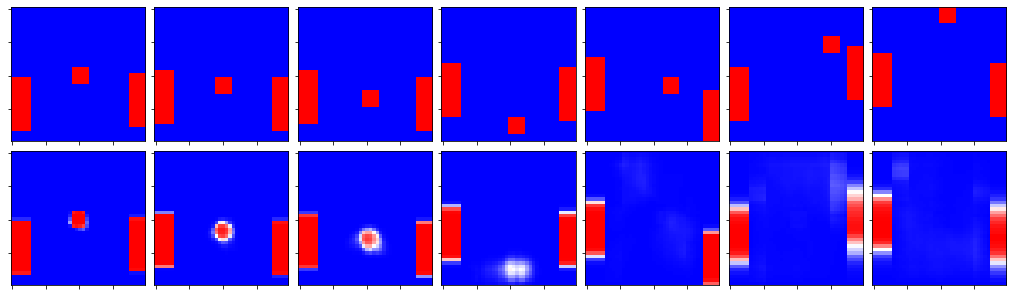

Epoch 59/2500
100/100 [==============================] - 51s 505ms/step - loss: 0.0781 - mean_squared_error: 0.0211 - acc: 0.9732 - val_loss: 0.0755 - val_mean_squared_error: 0.0204 - val_acc: 0.9738


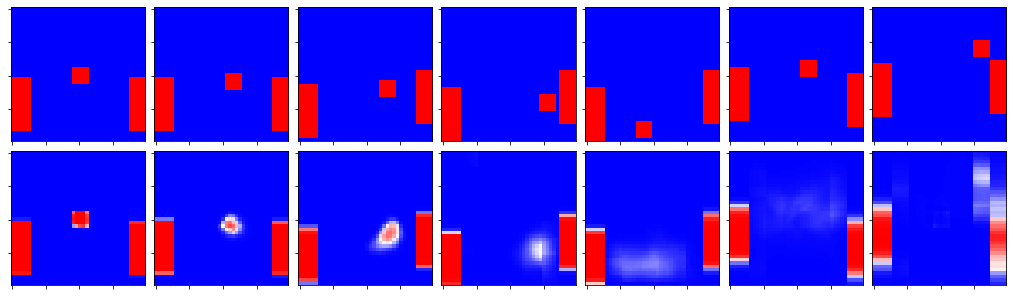

Epoch 60/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.0790 - mean_squared_error: 0.0213 - acc: 0.9728 - val_loss: 0.0680 - val_mean_squared_error: 0.0186 - val_acc: 0.9760


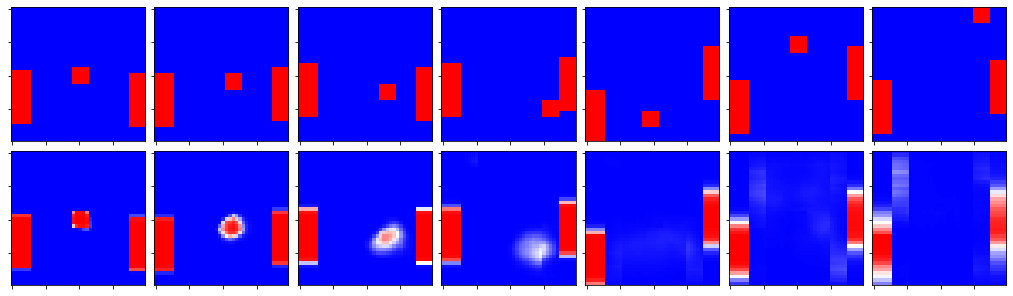

Epoch 61/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.0811 - mean_squared_error: 0.0221 - acc: 0.9717 - val_loss: 0.0776 - val_mean_squared_error: 0.0215 - val_acc: 0.9728


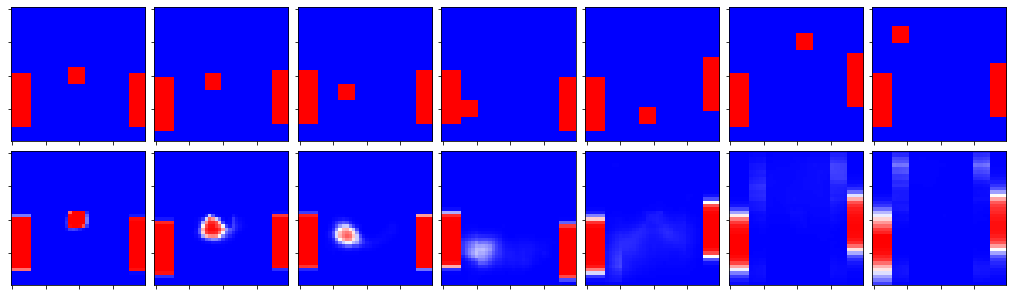

Epoch 62/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0778 - mean_squared_error: 0.0210 - acc: 0.9732 - val_loss: 0.0810 - val_mean_squared_error: 0.0214 - val_acc: 0.9730


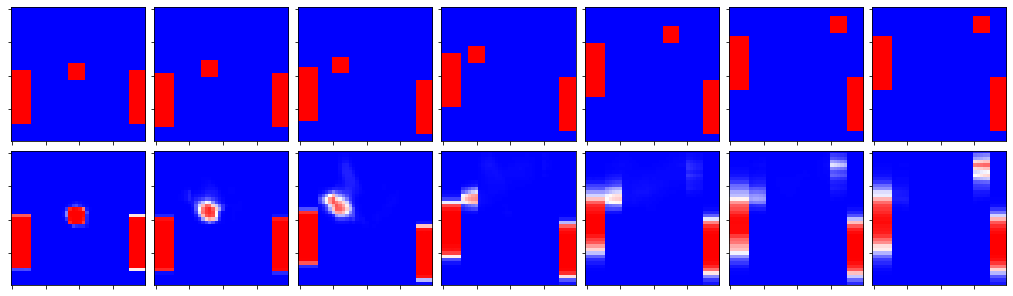

Epoch 63/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0791 - mean_squared_error: 0.0214 - acc: 0.9727 - val_loss: 0.0893 - val_mean_squared_error: 0.0239 - val_acc: 0.9697


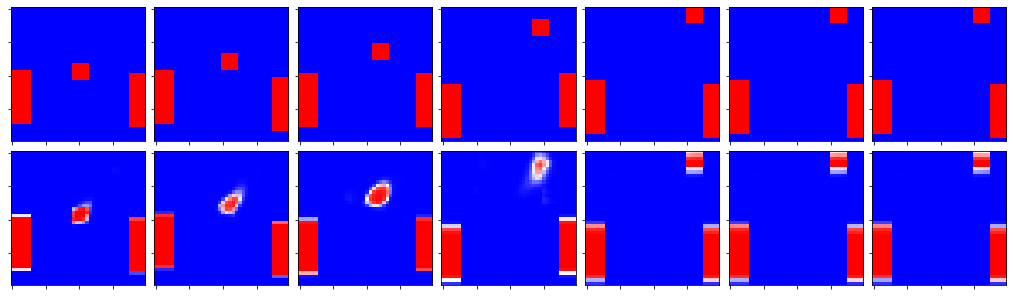

Epoch 64/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.0767 - mean_squared_error: 0.0208 - acc: 0.9735 - val_loss: 0.0679 - val_mean_squared_error: 0.0184 - val_acc: 0.9771


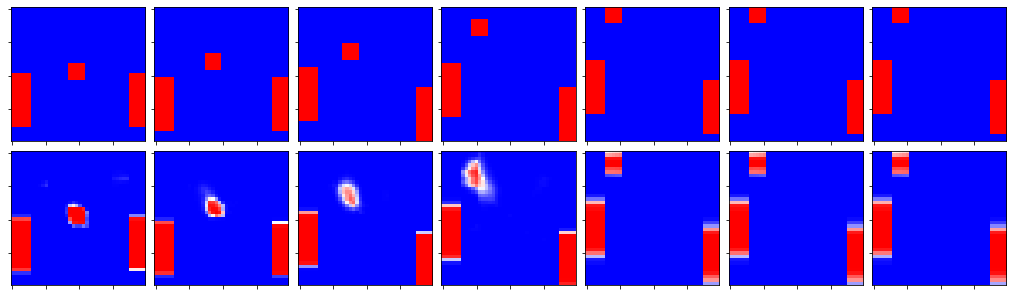

Epoch 65/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0777 - mean_squared_error: 0.0210 - acc: 0.9733 - val_loss: 0.0732 - val_mean_squared_error: 0.0203 - val_acc: 0.9736


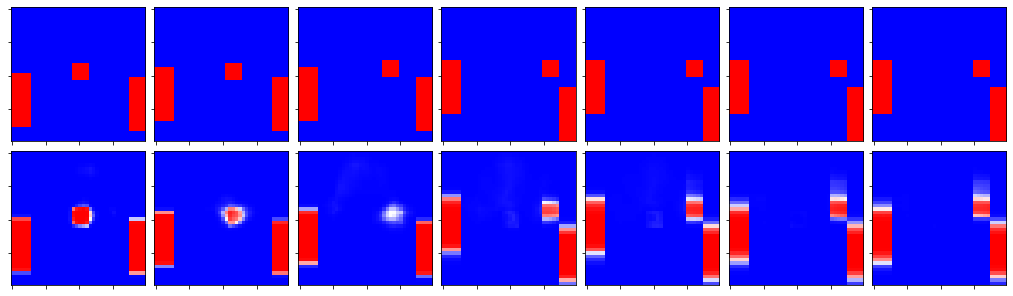

Epoch 66/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0772 - mean_squared_error: 0.0209 - acc: 0.9732 - val_loss: 0.0800 - val_mean_squared_error: 0.0216 - val_acc: 0.9727


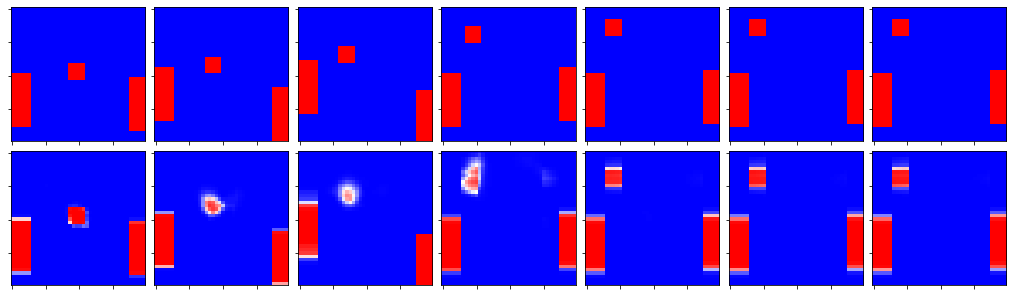

Epoch 67/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0788 - mean_squared_error: 0.0213 - acc: 0.9729 - val_loss: 0.0755 - val_mean_squared_error: 0.0210 - val_acc: 0.9726


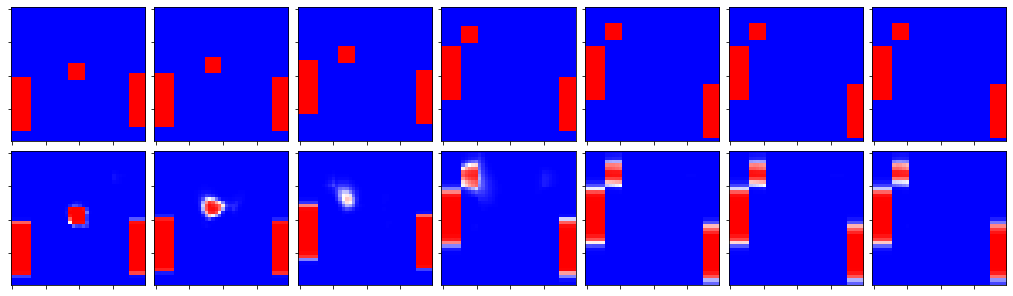

Epoch 68/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0777 - mean_squared_error: 0.0211 - acc: 0.9732 - val_loss: 0.0768 - val_mean_squared_error: 0.0207 - val_acc: 0.9737


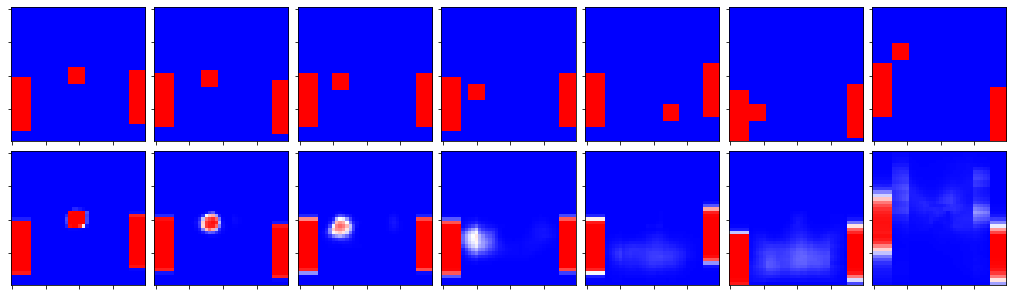

Epoch 69/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0779 - mean_squared_error: 0.0211 - acc: 0.9732 - val_loss: 0.0835 - val_mean_squared_error: 0.0227 - val_acc: 0.9711


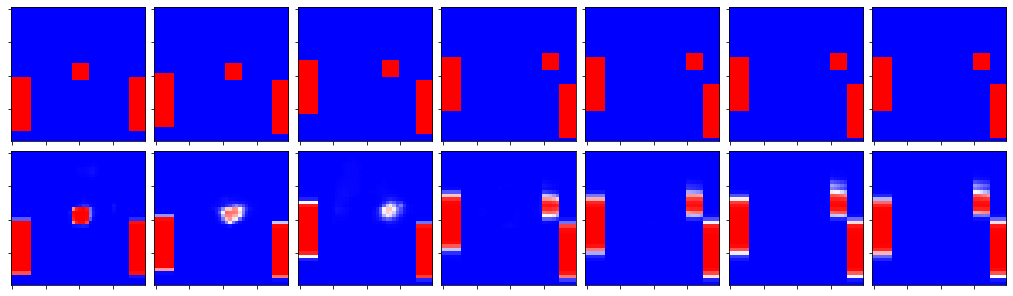

Epoch 70/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0769 - mean_squared_error: 0.0208 - acc: 0.9736 - val_loss: 0.0797 - val_mean_squared_error: 0.0208 - val_acc: 0.9740


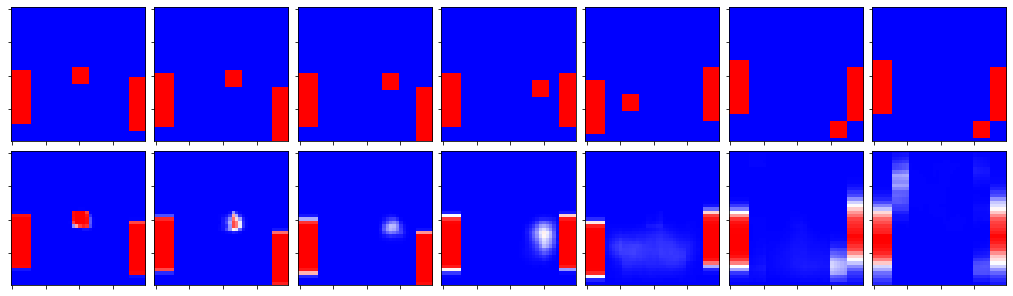

Epoch 71/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0795 - mean_squared_error: 0.0214 - acc: 0.9728 - val_loss: 0.0815 - val_mean_squared_error: 0.0218 - val_acc: 0.9725


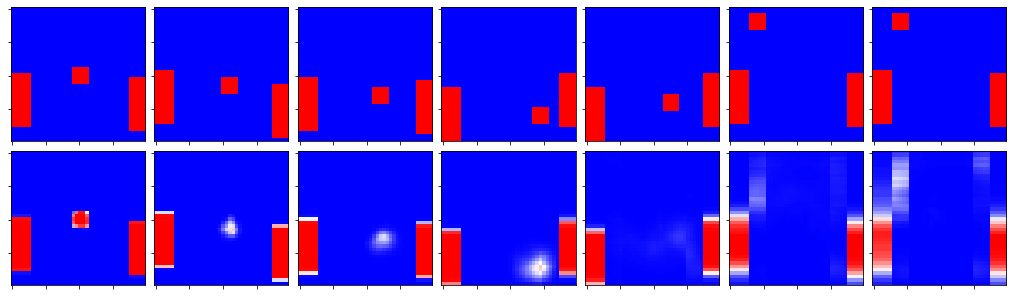

Epoch 72/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0784 - mean_squared_error: 0.0213 - acc: 0.9728 - val_loss: 0.0728 - val_mean_squared_error: 0.0201 - val_acc: 0.9738


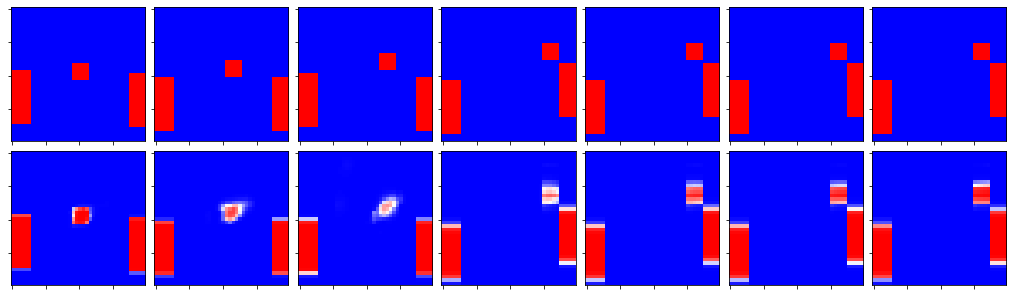

Epoch 73/2500
100/100 [==============================] - 51s 506ms/step - loss: 0.0745 - mean_squared_error: 0.0201 - acc: 0.9746 - val_loss: 0.0703 - val_mean_squared_error: 0.0186 - val_acc: 0.9771


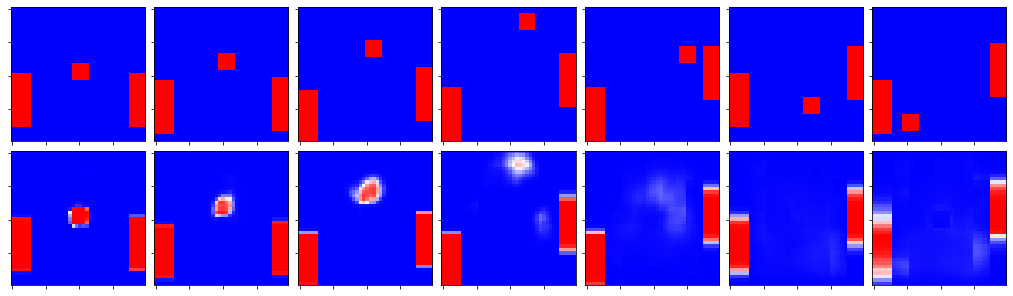

Epoch 74/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0759 - mean_squared_error: 0.0205 - acc: 0.9740 - val_loss: 0.0722 - val_mean_squared_error: 0.0195 - val_acc: 0.9753


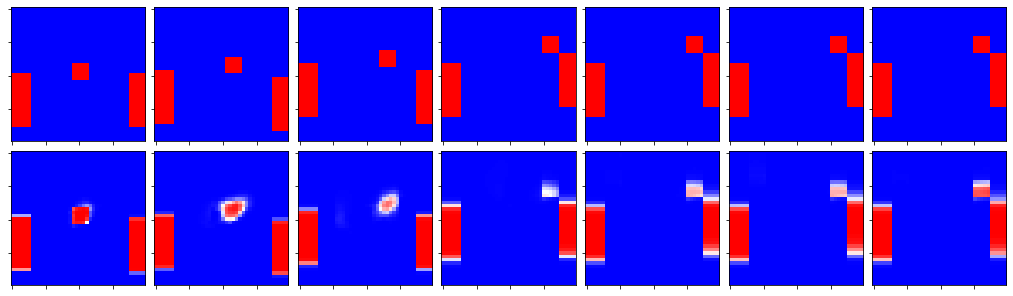

Epoch 75/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.0768 - mean_squared_error: 0.0208 - acc: 0.9735 - val_loss: 0.0911 - val_mean_squared_error: 0.0244 - val_acc: 0.9686


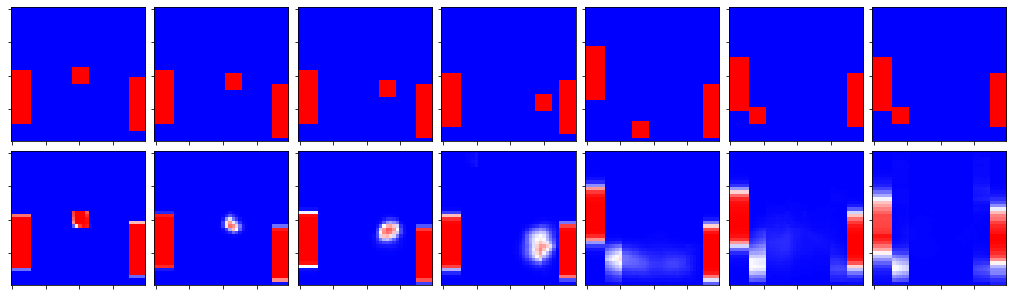

Epoch 76/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0762 - mean_squared_error: 0.0207 - acc: 0.9735 - val_loss: 0.0771 - val_mean_squared_error: 0.0205 - val_acc: 0.9743


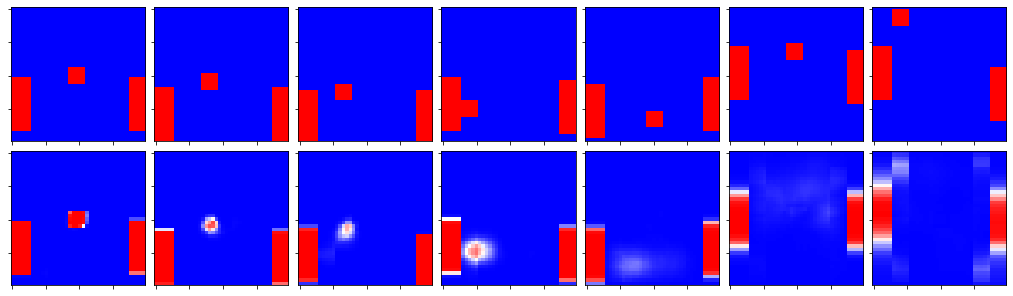

Epoch 77/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0746 - mean_squared_error: 0.0203 - acc: 0.9742 - val_loss: 0.0793 - val_mean_squared_error: 0.0219 - val_acc: 0.9719


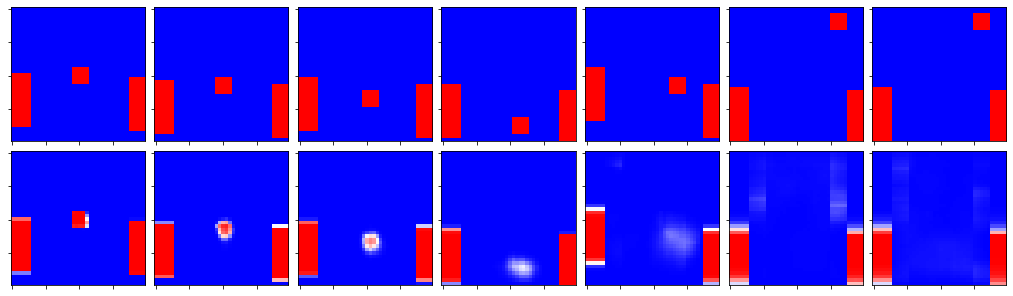

Epoch 78/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0765 - mean_squared_error: 0.0208 - acc: 0.9734 - val_loss: 0.0687 - val_mean_squared_error: 0.0185 - val_acc: 0.9766


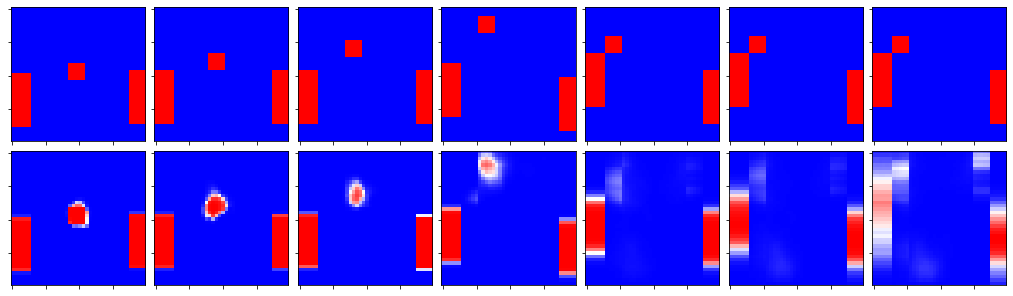

Epoch 79/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.0753 - mean_squared_error: 0.0203 - acc: 0.9741 - val_loss: 0.0813 - val_mean_squared_error: 0.0220 - val_acc: 0.9717


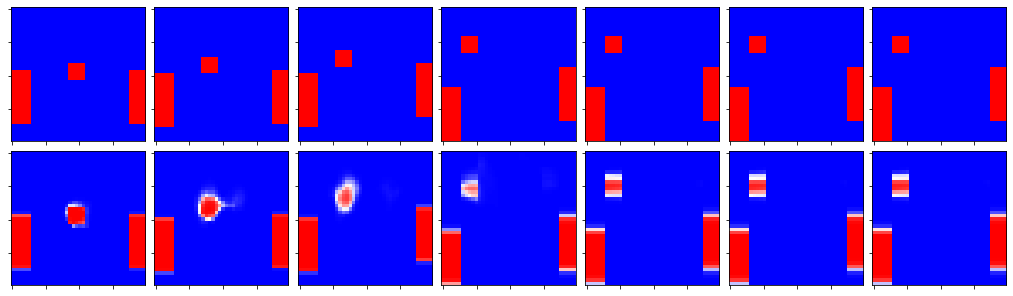

Epoch 80/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0763 - mean_squared_error: 0.0207 - acc: 0.9736 - val_loss: 0.0781 - val_mean_squared_error: 0.0212 - val_acc: 0.9726


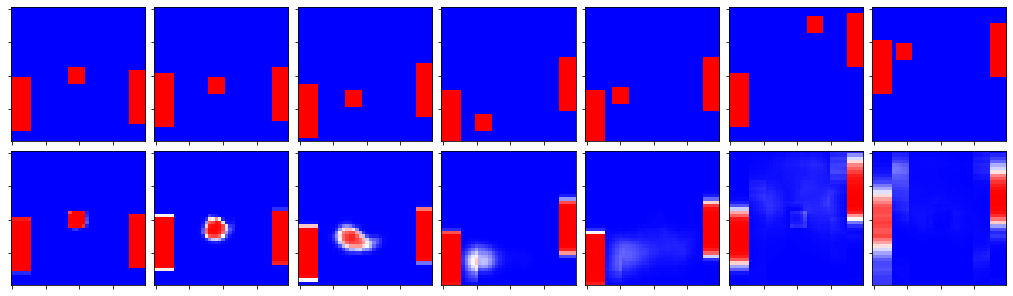

Epoch 81/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0741 - mean_squared_error: 0.0201 - acc: 0.9744 - val_loss: 0.0790 - val_mean_squared_error: 0.0215 - val_acc: 0.9729


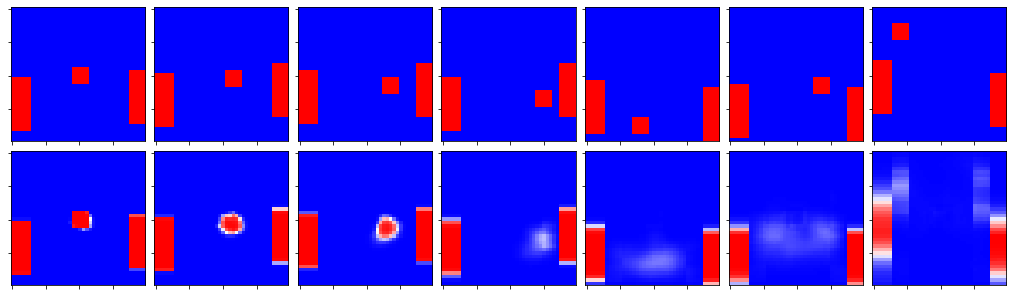

Epoch 82/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0770 - mean_squared_error: 0.0209 - acc: 0.9734 - val_loss: 0.0752 - val_mean_squared_error: 0.0206 - val_acc: 0.9737


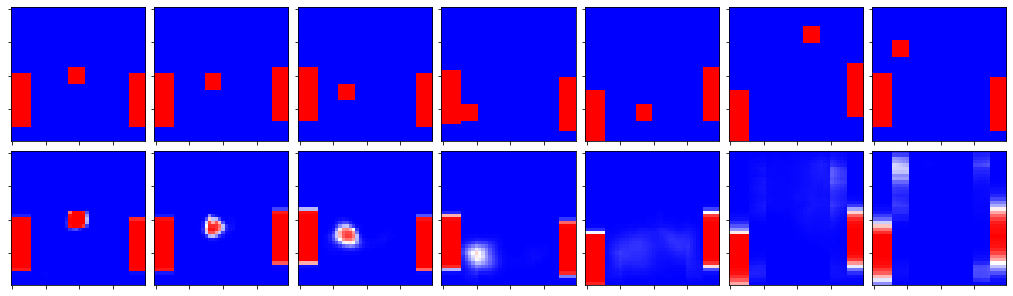

Epoch 83/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.0798 - mean_squared_error: 0.0217 - acc: 0.9722 - val_loss: 0.0911 - val_mean_squared_error: 0.0245 - val_acc: 0.9688


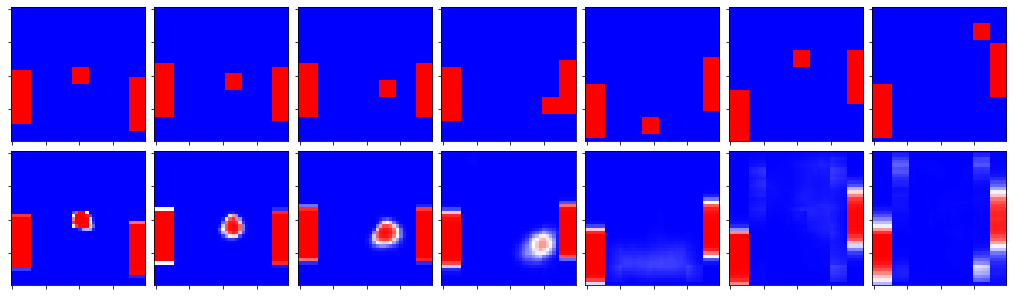

Epoch 84/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0753 - mean_squared_error: 0.0205 - acc: 0.9739 - val_loss: 0.0770 - val_mean_squared_error: 0.0207 - val_acc: 0.9739


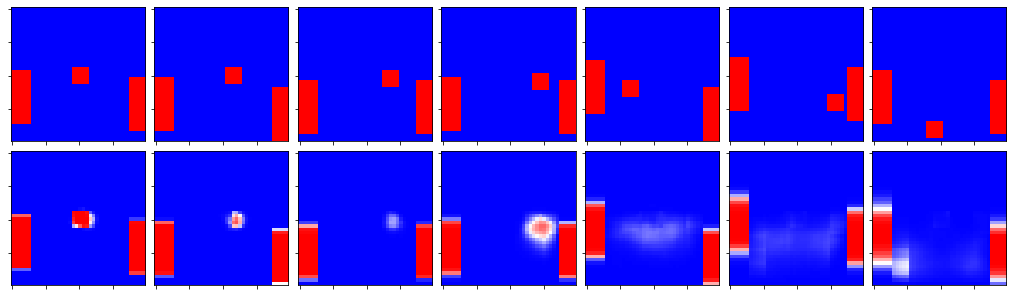

Epoch 85/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0746 - mean_squared_error: 0.0203 - acc: 0.9742 - val_loss: 0.0759 - val_mean_squared_error: 0.0200 - val_acc: 0.9744


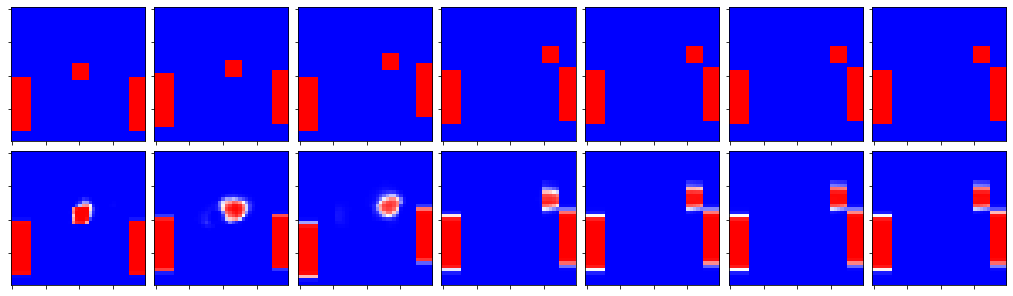

Epoch 86/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0756 - mean_squared_error: 0.0206 - acc: 0.9737 - val_loss: 0.0766 - val_mean_squared_error: 0.0213 - val_acc: 0.9723


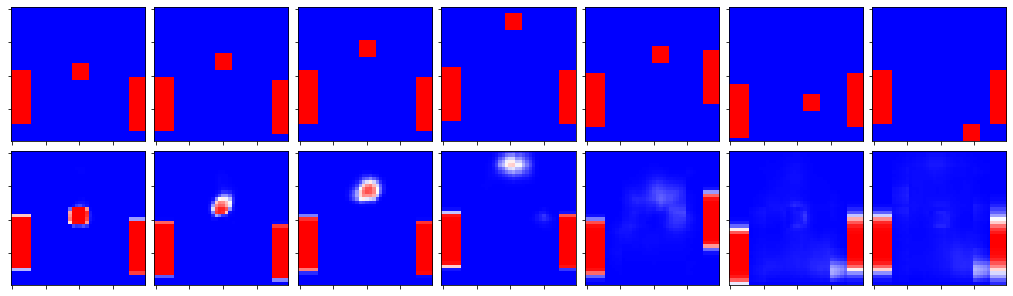

Epoch 87/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.0748 - mean_squared_error: 0.0204 - acc: 0.9740 - val_loss: 0.0746 - val_mean_squared_error: 0.0208 - val_acc: 0.9728


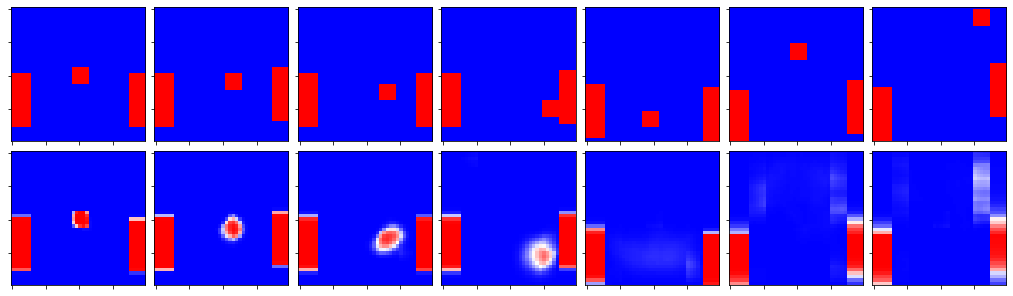

Epoch 88/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0759 - mean_squared_error: 0.0207 - acc: 0.9736 - val_loss: 0.0808 - val_mean_squared_error: 0.0219 - val_acc: 0.9720


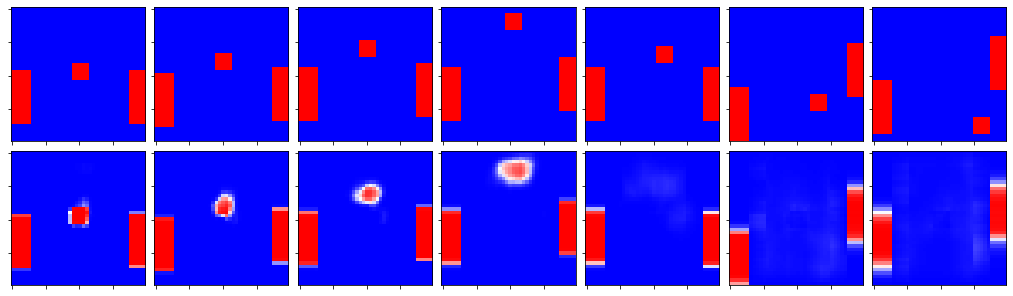

Epoch 89/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0738 - mean_squared_error: 0.0201 - acc: 0.9744 - val_loss: 0.0812 - val_mean_squared_error: 0.0219 - val_acc: 0.9721


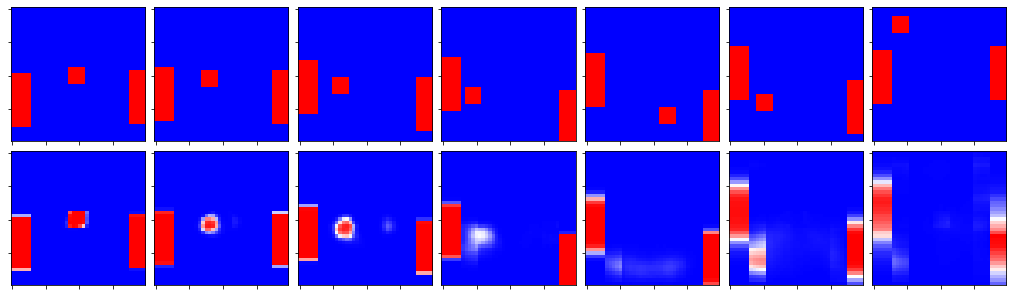

Epoch 90/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0758 - mean_squared_error: 0.0207 - acc: 0.9735 - val_loss: 0.0904 - val_mean_squared_error: 0.0235 - val_acc: 0.9700


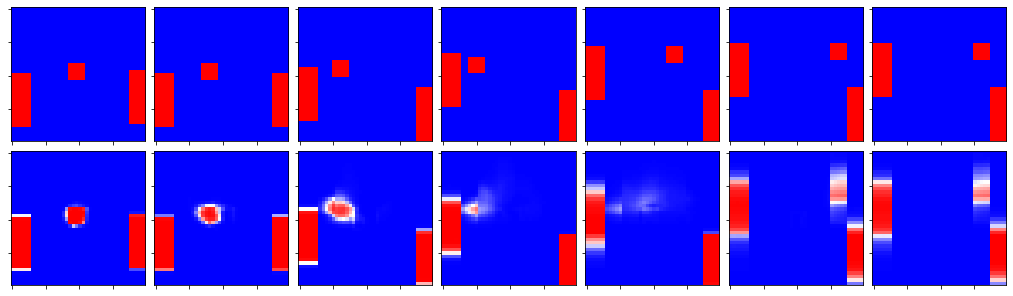

Epoch 91/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0738 - mean_squared_error: 0.0200 - acc: 0.9747 - val_loss: 0.0744 - val_mean_squared_error: 0.0202 - val_acc: 0.9745


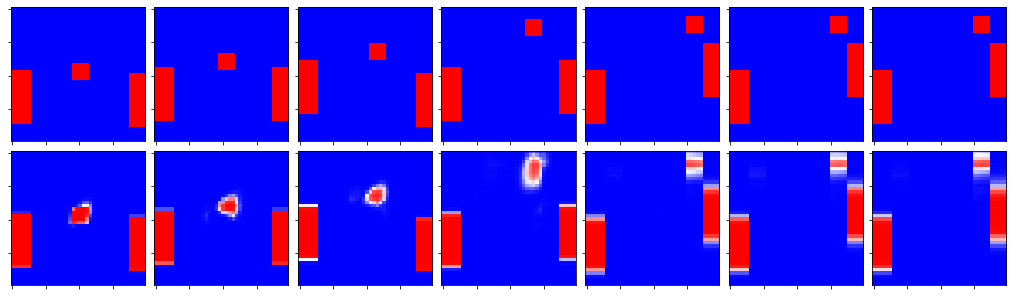

Epoch 92/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0745 - mean_squared_error: 0.0202 - acc: 0.9742 - val_loss: 0.0857 - val_mean_squared_error: 0.0234 - val_acc: 0.9706


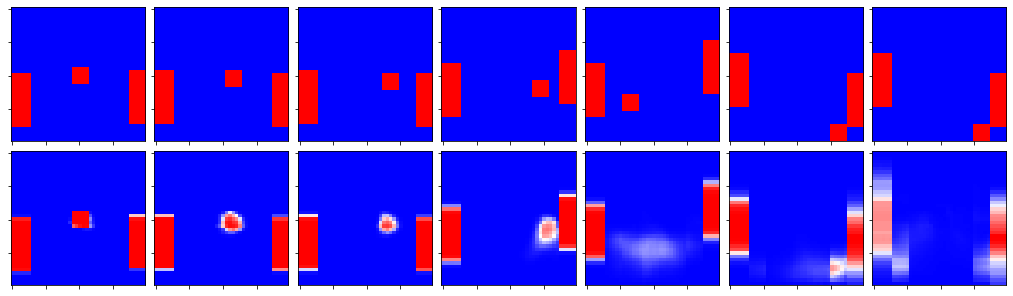

Epoch 93/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.0727 - mean_squared_error: 0.0197 - acc: 0.9749 - val_loss: 0.0653 - val_mean_squared_error: 0.0175 - val_acc: 0.9781


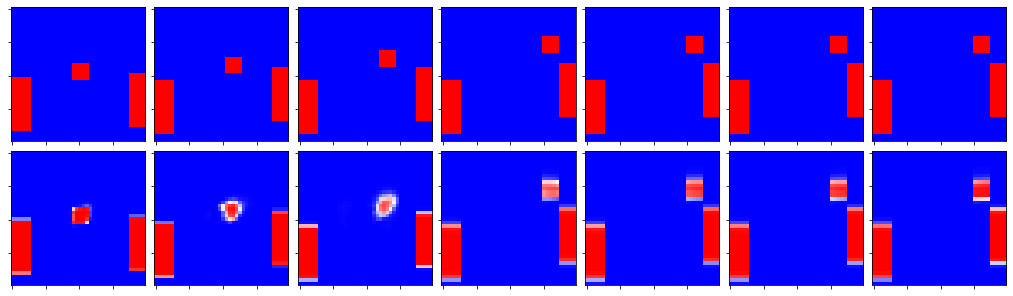

Epoch 94/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0756 - mean_squared_error: 0.0205 - acc: 0.9738 - val_loss: 0.0748 - val_mean_squared_error: 0.0202 - val_acc: 0.9742


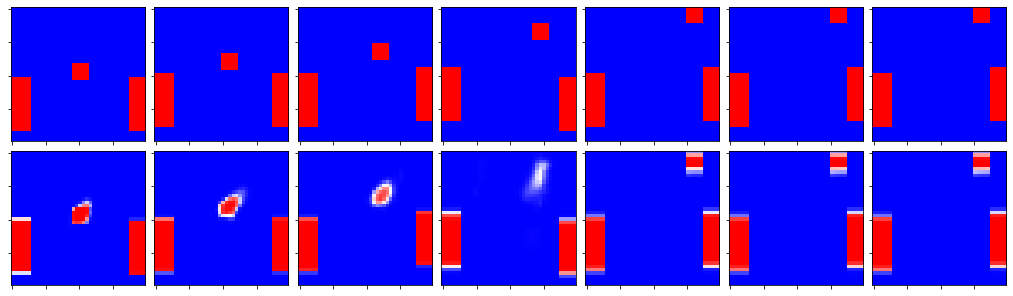

Epoch 95/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0735 - mean_squared_error: 0.0200 - acc: 0.9746 - val_loss: 0.0815 - val_mean_squared_error: 0.0224 - val_acc: 0.9713


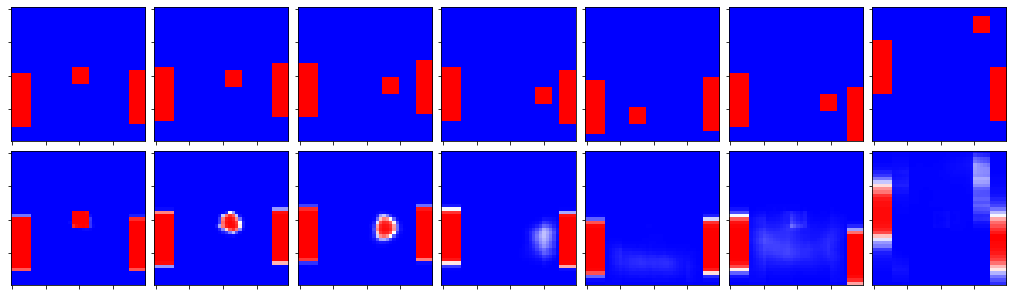

Epoch 96/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.0785 - mean_squared_error: 0.0214 - acc: 0.9726 - val_loss: 0.0694 - val_mean_squared_error: 0.0190 - val_acc: 0.9757


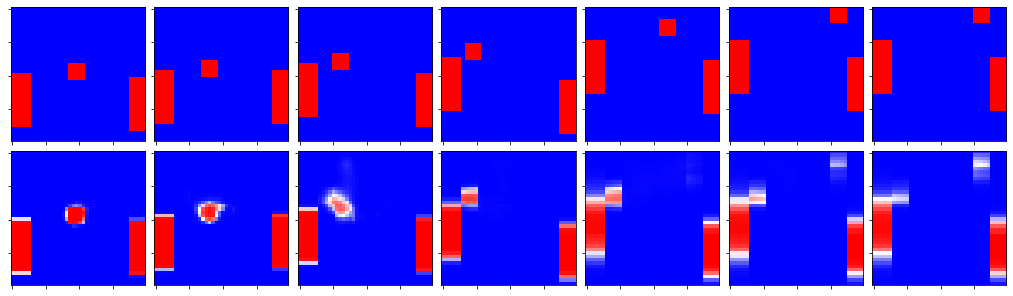

Epoch 97/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.0760 - mean_squared_error: 0.0206 - acc: 0.9738 - val_loss: 0.0735 - val_mean_squared_error: 0.0201 - val_acc: 0.9745


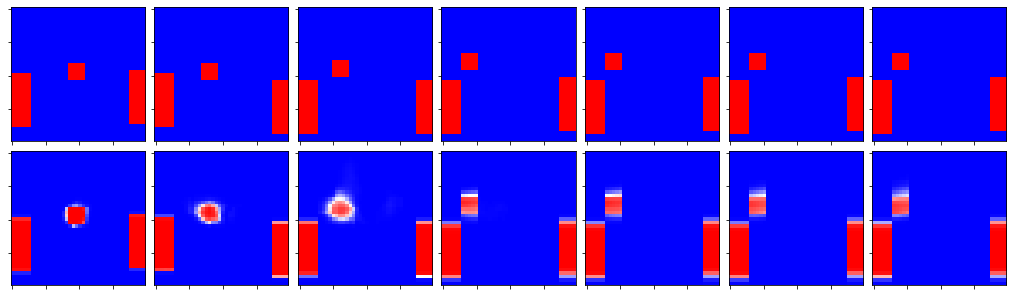

Epoch 98/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0731 - mean_squared_error: 0.0198 - acc: 0.9748 - val_loss: 0.0698 - val_mean_squared_error: 0.0184 - val_acc: 0.9767


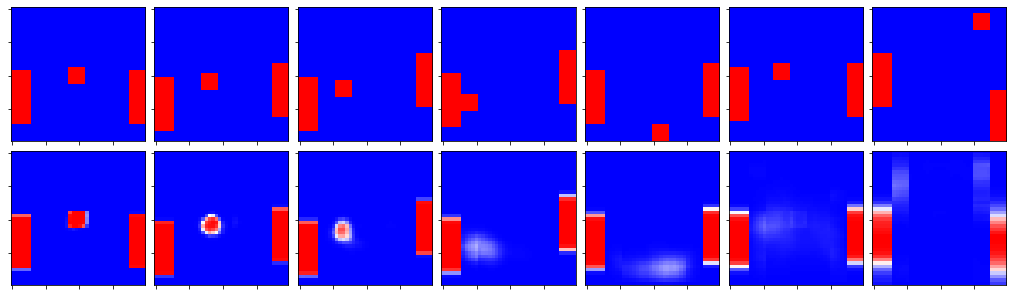

Epoch 99/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0731 - mean_squared_error: 0.0199 - acc: 0.9746 - val_loss: 0.0786 - val_mean_squared_error: 0.0214 - val_acc: 0.9731


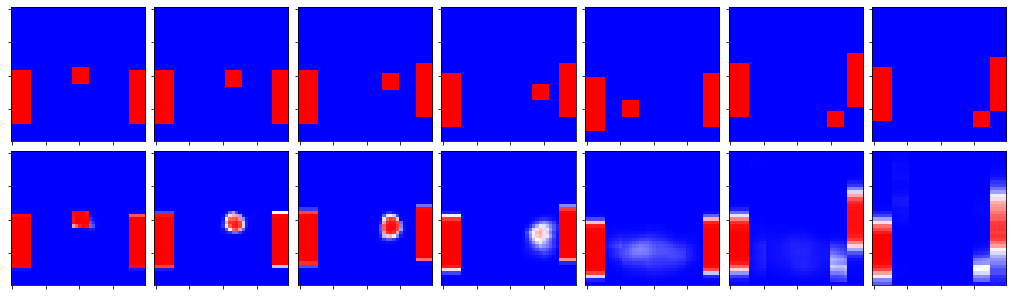

Epoch 100/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0737 - mean_squared_error: 0.0199 - acc: 0.9746 - val_loss: 0.0778 - val_mean_squared_error: 0.0215 - val_acc: 0.9722


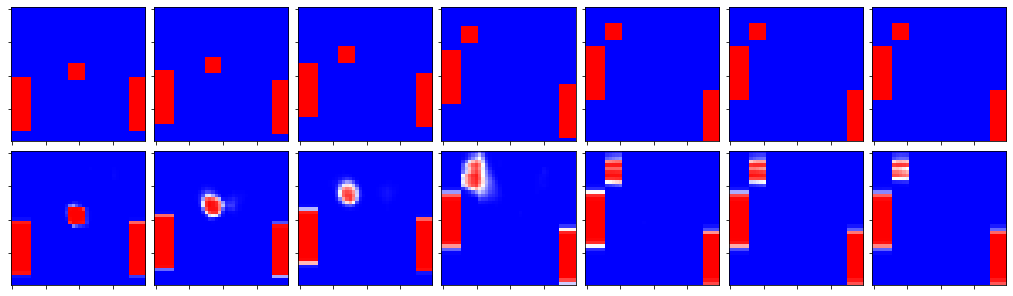

Epoch 101/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0708 - mean_squared_error: 0.0193 - acc: 0.9754 - val_loss: 0.0685 - val_mean_squared_error: 0.0188 - val_acc: 0.9756


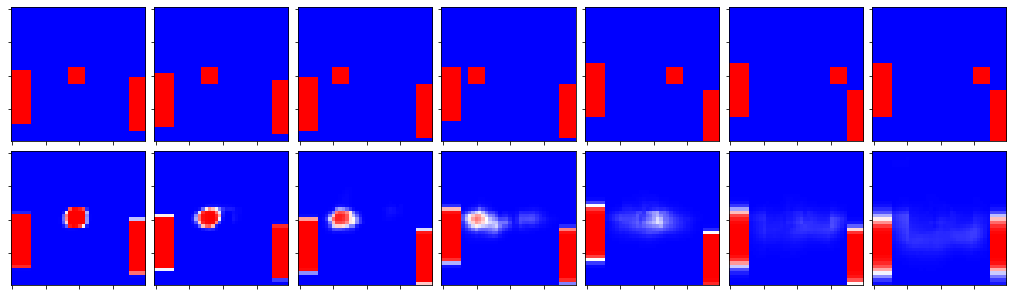

Epoch 102/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0723 - mean_squared_error: 0.0197 - acc: 0.9749 - val_loss: 0.0693 - val_mean_squared_error: 0.0193 - val_acc: 0.9751


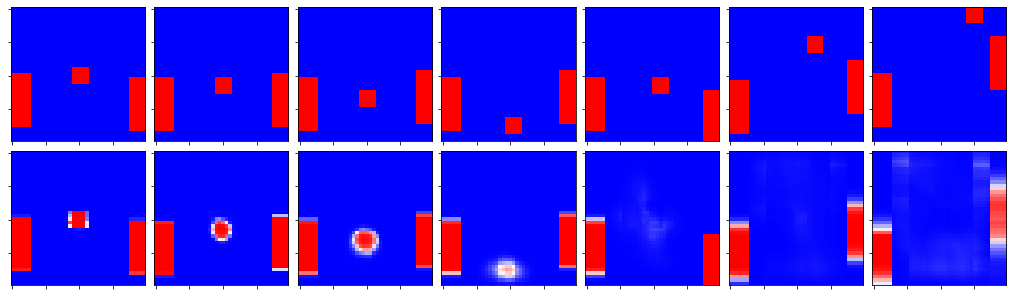

Epoch 103/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0701 - mean_squared_error: 0.0191 - acc: 0.9759 - val_loss: 0.0661 - val_mean_squared_error: 0.0178 - val_acc: 0.9773


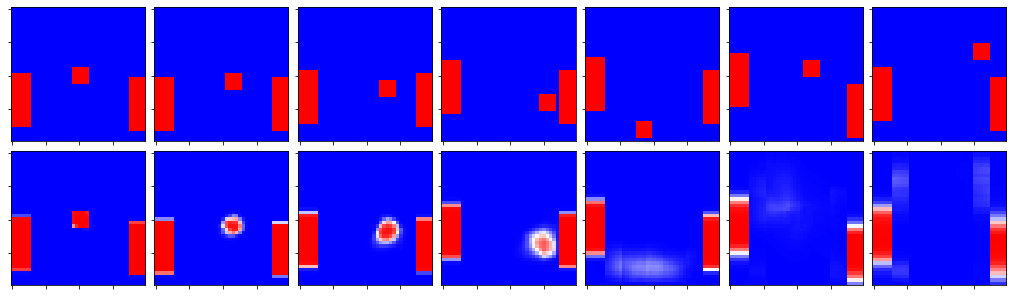

Epoch 104/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.0730 - mean_squared_error: 0.0198 - acc: 0.9750 - val_loss: 0.0757 - val_mean_squared_error: 0.0203 - val_acc: 0.9743


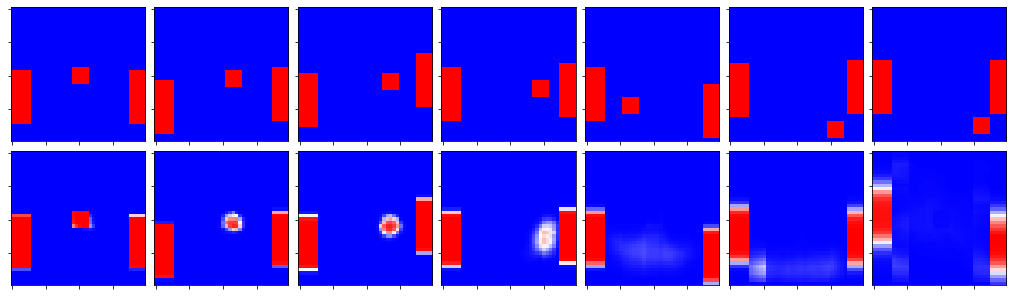

Epoch 105/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0724 - mean_squared_error: 0.0196 - acc: 0.9750 - val_loss: 0.0757 - val_mean_squared_error: 0.0206 - val_acc: 0.9740


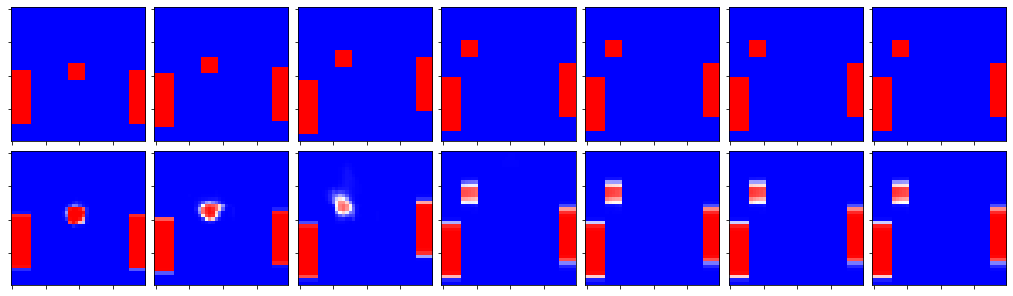

Epoch 106/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0729 - mean_squared_error: 0.0198 - acc: 0.9749 - val_loss: 0.0674 - val_mean_squared_error: 0.0185 - val_acc: 0.9762


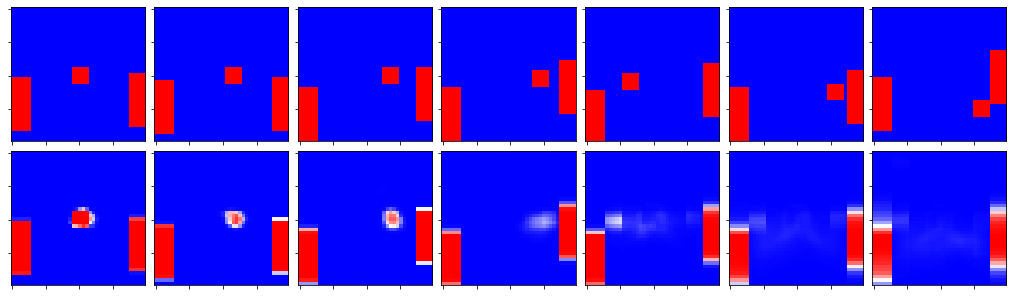

Epoch 107/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.0714 - mean_squared_error: 0.0194 - acc: 0.9753 - val_loss: 0.0700 - val_mean_squared_error: 0.0190 - val_acc: 0.9763


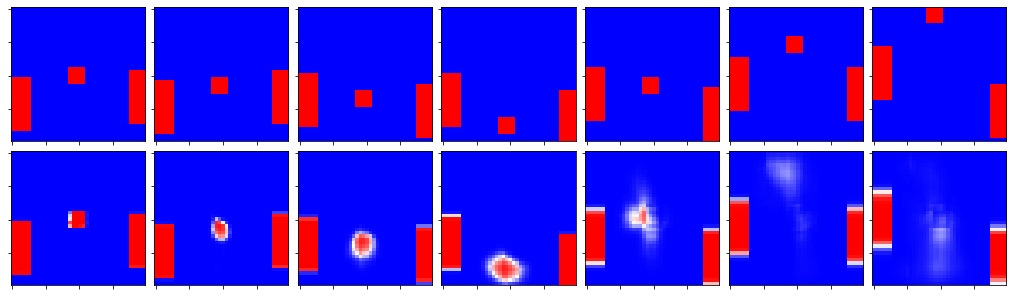

Epoch 108/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0697 - mean_squared_error: 0.0188 - acc: 0.9762 - val_loss: 0.0704 - val_mean_squared_error: 0.0188 - val_acc: 0.9764


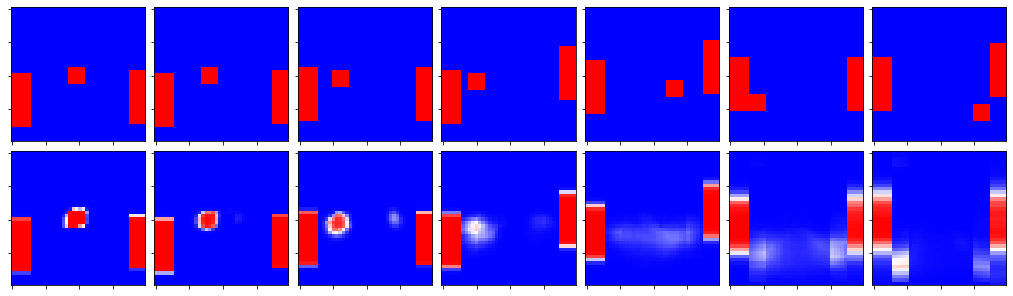

Epoch 109/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0718 - mean_squared_error: 0.0195 - acc: 0.9751 - val_loss: 0.0672 - val_mean_squared_error: 0.0184 - val_acc: 0.9769


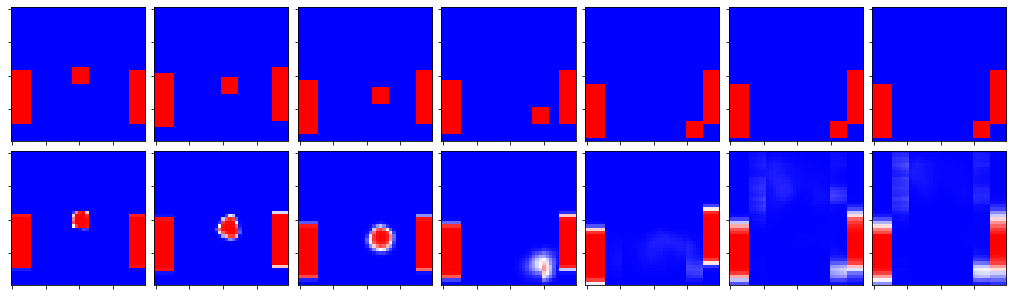

Epoch 110/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0708 - mean_squared_error: 0.0192 - acc: 0.9756 - val_loss: 0.0712 - val_mean_squared_error: 0.0196 - val_acc: 0.9748


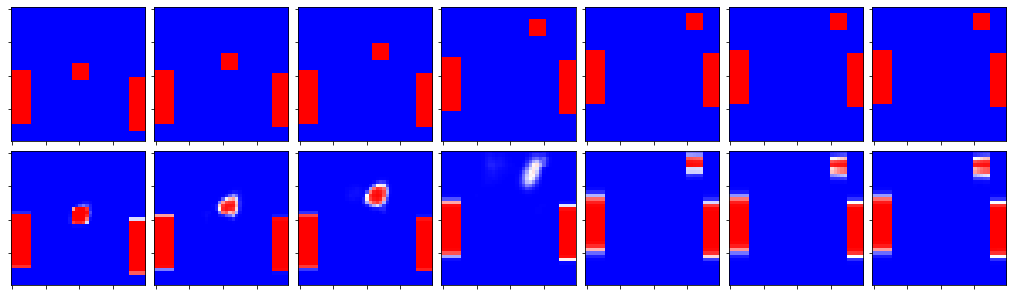

Epoch 111/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0712 - mean_squared_error: 0.0193 - acc: 0.9755 - val_loss: 0.0723 - val_mean_squared_error: 0.0196 - val_acc: 0.9756


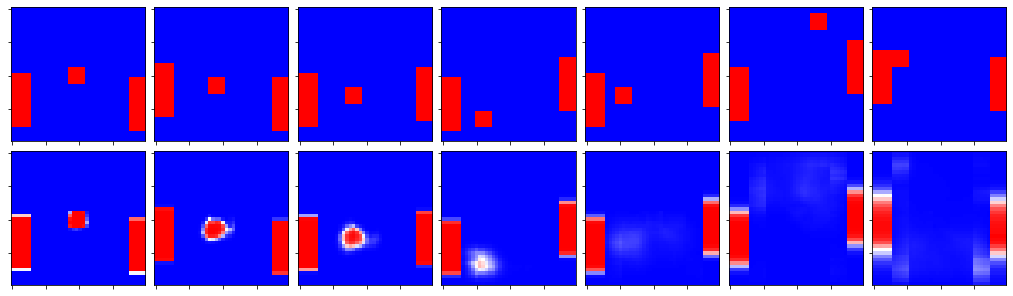

Epoch 112/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.0716 - mean_squared_error: 0.0194 - acc: 0.9752 - val_loss: 0.0768 - val_mean_squared_error: 0.0209 - val_acc: 0.9736


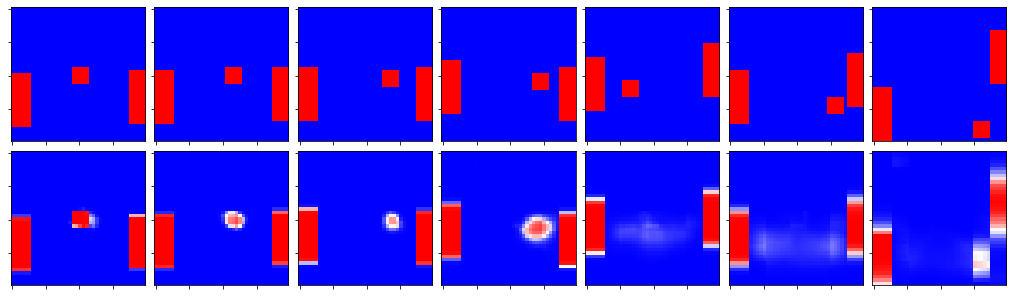

Epoch 113/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.0691 - mean_squared_error: 0.0188 - acc: 0.9761 - val_loss: 0.0715 - val_mean_squared_error: 0.0194 - val_acc: 0.9751


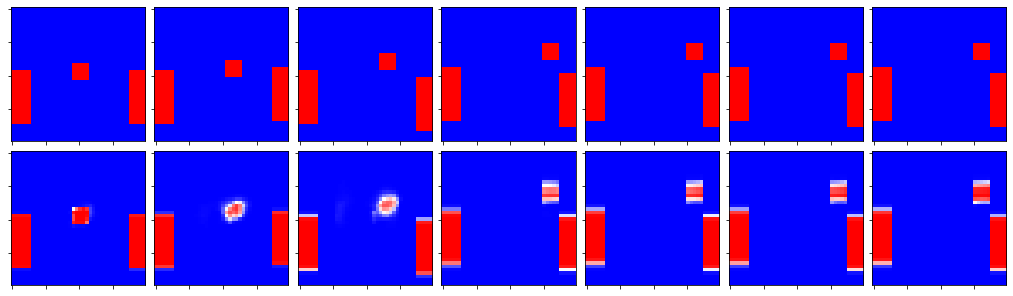

Epoch 114/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0715 - mean_squared_error: 0.0194 - acc: 0.9754 - val_loss: 0.0717 - val_mean_squared_error: 0.0199 - val_acc: 0.9744


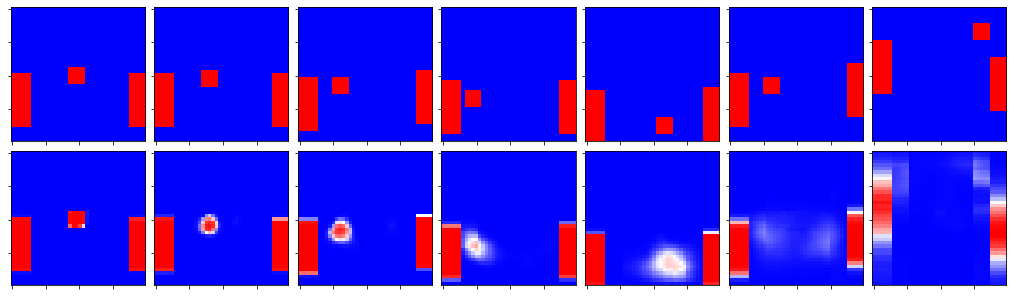

Epoch 115/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0693 - mean_squared_error: 0.0188 - acc: 0.9761 - val_loss: 0.0693 - val_mean_squared_error: 0.0190 - val_acc: 0.9757


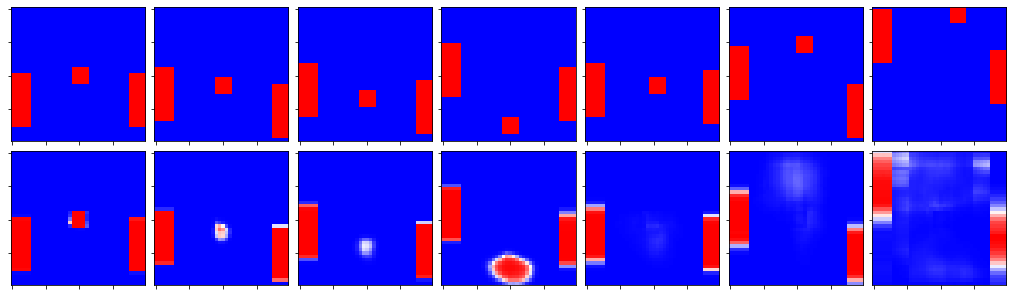

Epoch 116/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0706 - mean_squared_error: 0.0192 - acc: 0.9756 - val_loss: 0.0656 - val_mean_squared_error: 0.0178 - val_acc: 0.9774


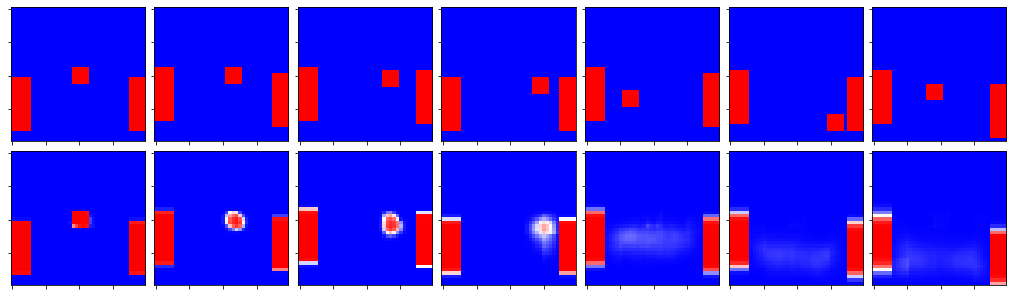

Epoch 117/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0729 - mean_squared_error: 0.0199 - acc: 0.9747 - val_loss: 0.0706 - val_mean_squared_error: 0.0191 - val_acc: 0.9759


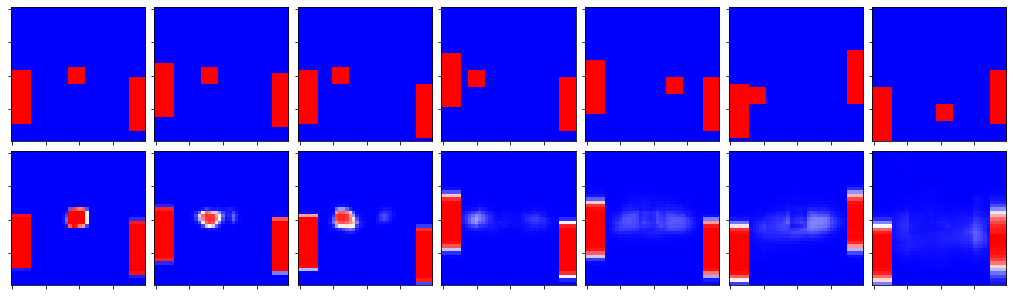

Epoch 118/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0716 - mean_squared_error: 0.0196 - acc: 0.9750 - val_loss: 0.0614 - val_mean_squared_error: 0.0166 - val_acc: 0.9793


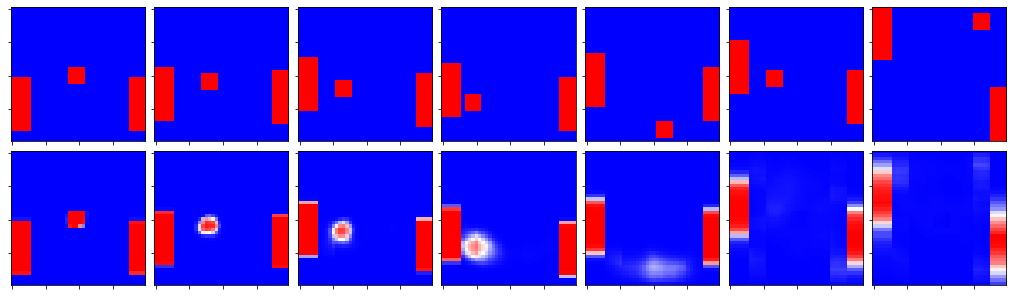

Epoch 119/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0750 - mean_squared_error: 0.0203 - acc: 0.9742 - val_loss: 0.0776 - val_mean_squared_error: 0.0214 - val_acc: 0.9723


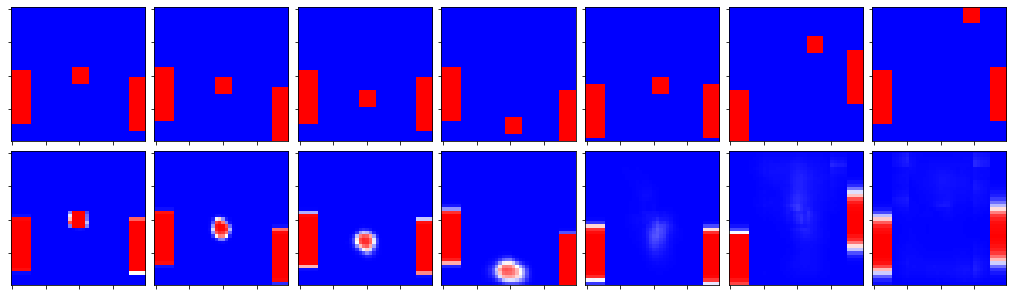

Epoch 120/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0719 - mean_squared_error: 0.0196 - acc: 0.9752 - val_loss: 0.0737 - val_mean_squared_error: 0.0200 - val_acc: 0.9751


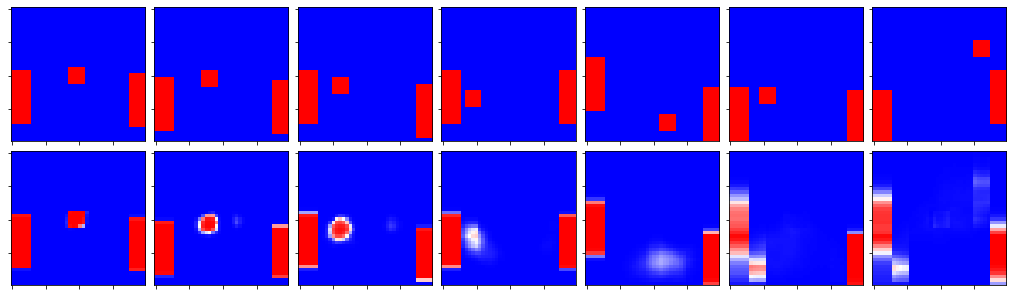

Epoch 121/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0698 - mean_squared_error: 0.0190 - acc: 0.9758 - val_loss: 0.0651 - val_mean_squared_error: 0.0177 - val_acc: 0.9772


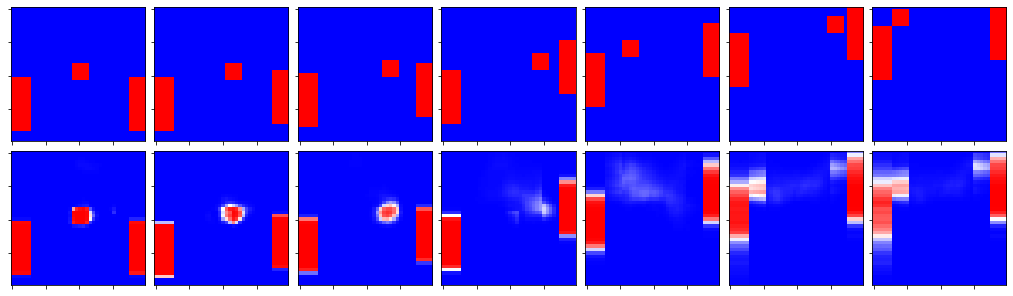

Epoch 122/2500
100/100 [==============================] - 49s 492ms/step - loss: 0.0697 - mean_squared_error: 0.0189 - acc: 0.9761 - val_loss: 0.0726 - val_mean_squared_error: 0.0197 - val_acc: 0.9751


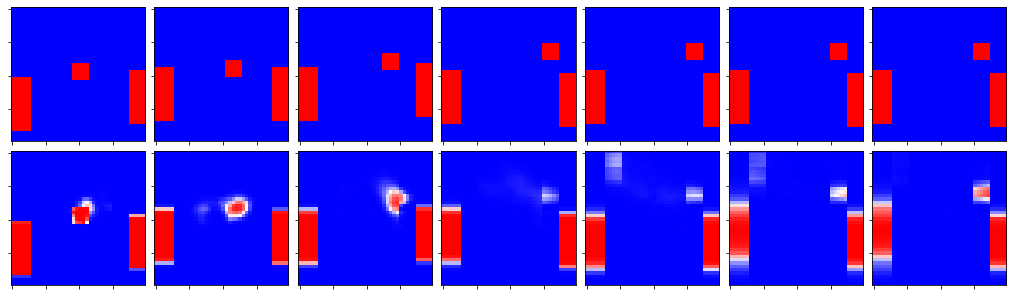

Epoch 123/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0720 - mean_squared_error: 0.0197 - acc: 0.9748 - val_loss: 0.0755 - val_mean_squared_error: 0.0204 - val_acc: 0.9740


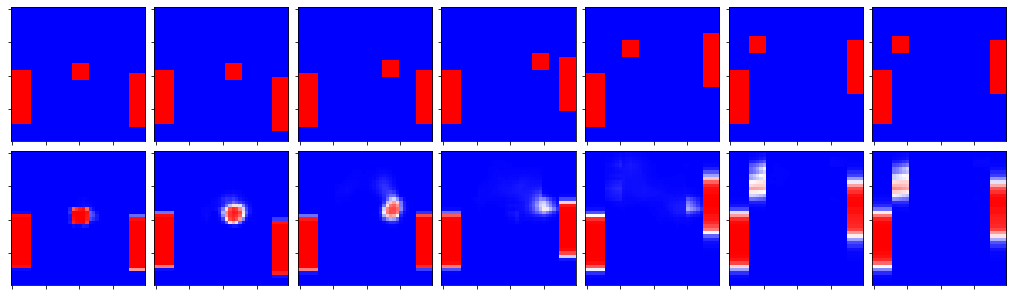

Epoch 124/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.0679 - mean_squared_error: 0.0185 - acc: 0.9764 - val_loss: 0.0689 - val_mean_squared_error: 0.0187 - val_acc: 0.9760


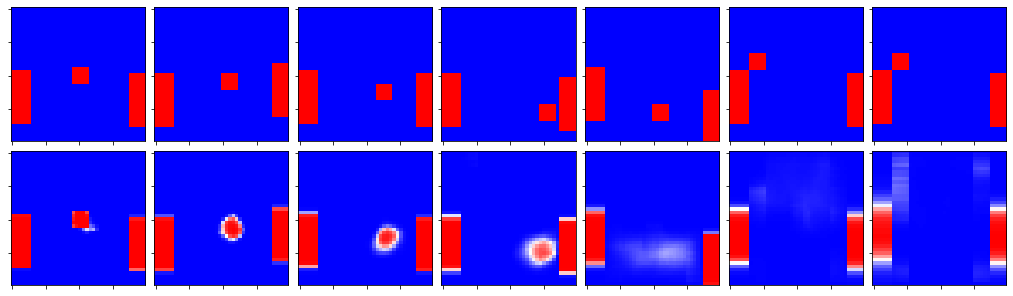

Epoch 125/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0703 - mean_squared_error: 0.0191 - acc: 0.9757 - val_loss: 0.0642 - val_mean_squared_error: 0.0173 - val_acc: 0.9782


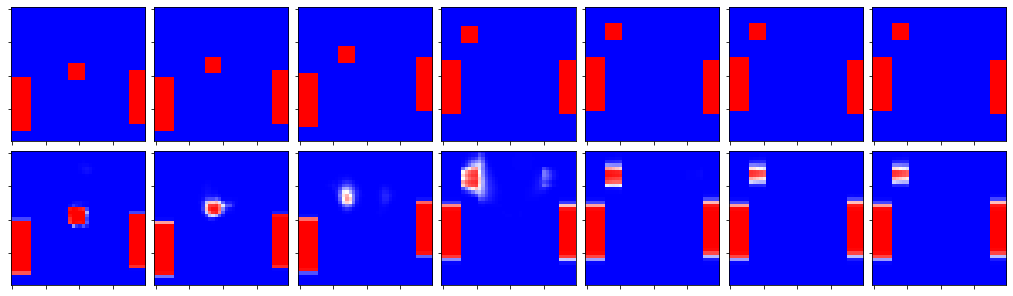

Epoch 126/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0689 - mean_squared_error: 0.0187 - acc: 0.9762 - val_loss: 0.0602 - val_mean_squared_error: 0.0168 - val_acc: 0.9780


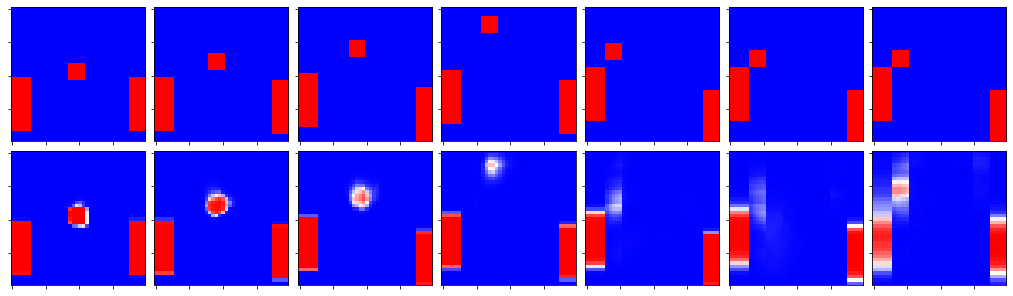

Epoch 127/2500
100/100 [==============================] - 51s 510ms/step - loss: 0.0683 - mean_squared_error: 0.0186 - acc: 0.9764 - val_loss: 0.0615 - val_mean_squared_error: 0.0169 - val_acc: 0.9784


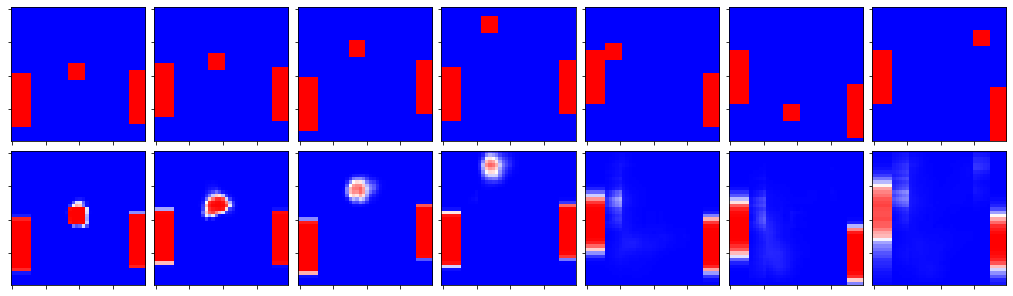

Epoch 128/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.0703 - mean_squared_error: 0.0192 - acc: 0.9755 - val_loss: 0.0748 - val_mean_squared_error: 0.0204 - val_acc: 0.9740


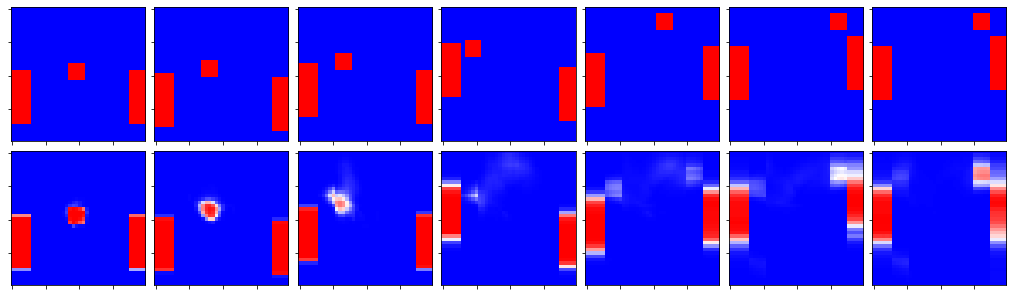

Epoch 129/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.0678 - mean_squared_error: 0.0184 - acc: 0.9766 - val_loss: 0.0673 - val_mean_squared_error: 0.0186 - val_acc: 0.9762


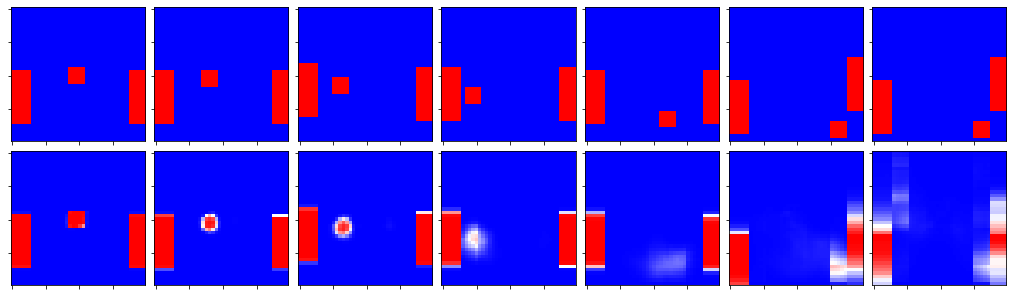

Epoch 130/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0697 - mean_squared_error: 0.0190 - acc: 0.9759 - val_loss: 0.0681 - val_mean_squared_error: 0.0187 - val_acc: 0.9760


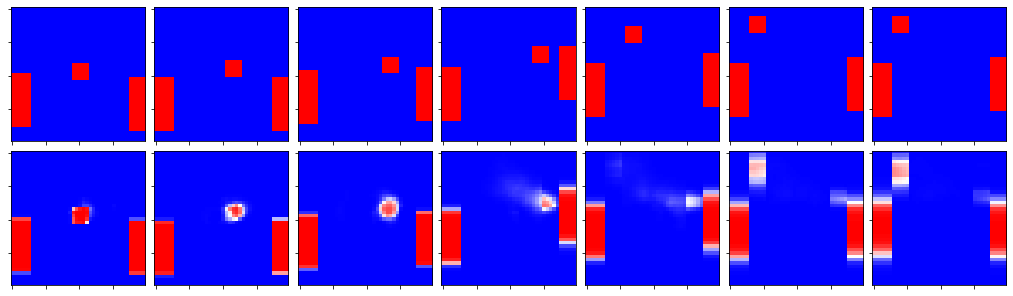

Epoch 131/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0687 - mean_squared_error: 0.0187 - acc: 0.9762 - val_loss: 0.0787 - val_mean_squared_error: 0.0210 - val_acc: 0.9736


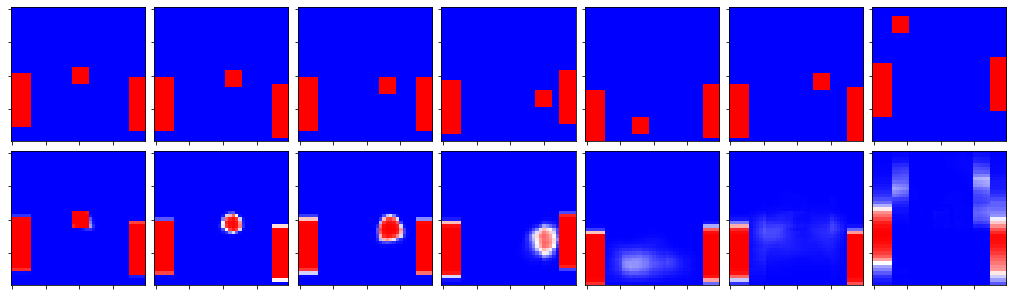

Epoch 132/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0687 - mean_squared_error: 0.0187 - acc: 0.9763 - val_loss: 0.0673 - val_mean_squared_error: 0.0184 - val_acc: 0.9766


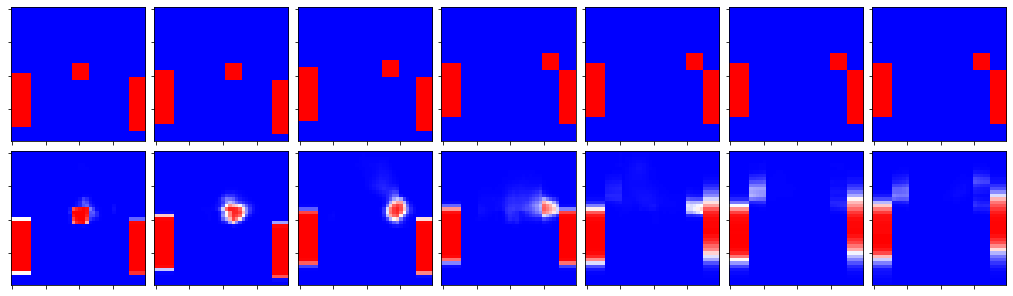

Epoch 133/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.0693 - mean_squared_error: 0.0189 - acc: 0.9760 - val_loss: 0.0672 - val_mean_squared_error: 0.0178 - val_acc: 0.9782


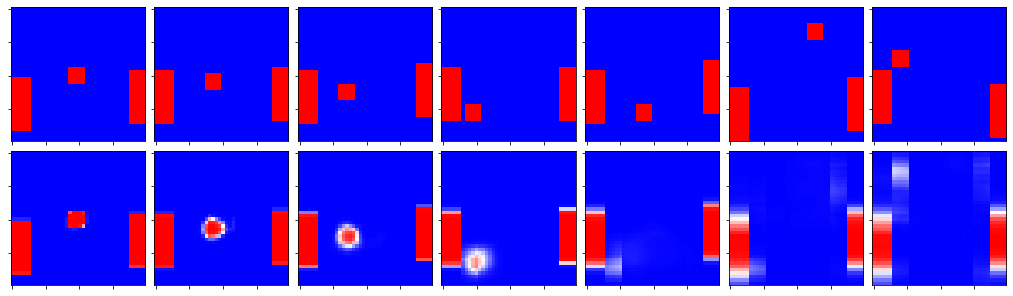

Epoch 134/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0682 - mean_squared_error: 0.0186 - acc: 0.9763 - val_loss: 0.0639 - val_mean_squared_error: 0.0178 - val_acc: 0.9774


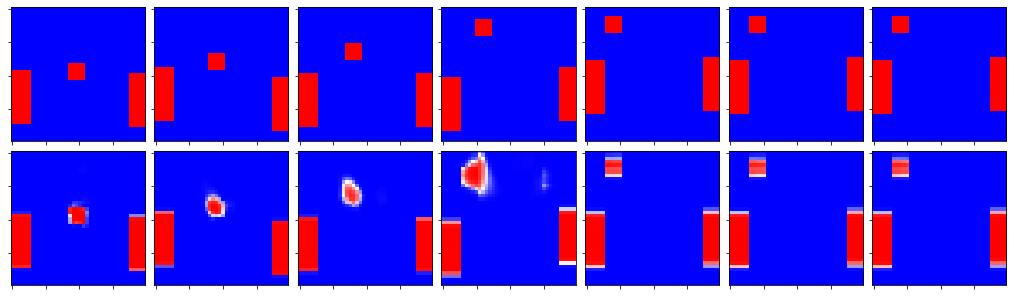

Epoch 135/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0700 - mean_squared_error: 0.0191 - acc: 0.9757 - val_loss: 0.0791 - val_mean_squared_error: 0.0206 - val_acc: 0.9736


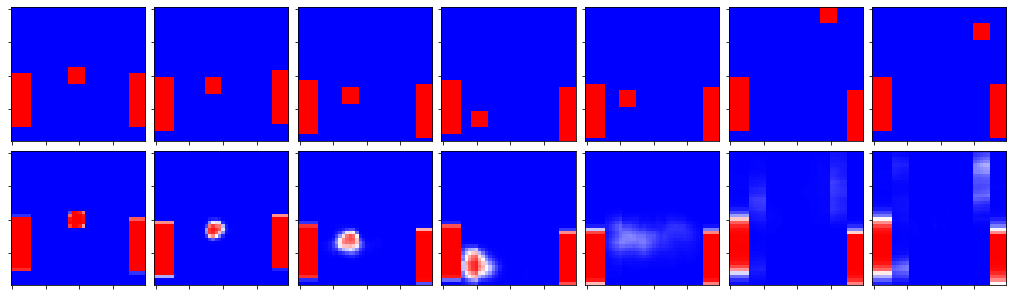

Epoch 136/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.0682 - mean_squared_error: 0.0186 - acc: 0.9763 - val_loss: 0.0630 - val_mean_squared_error: 0.0171 - val_acc: 0.9785


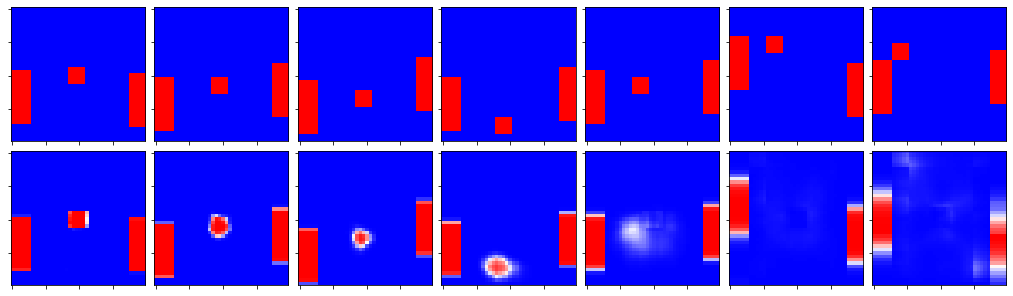

Epoch 137/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0677 - mean_squared_error: 0.0185 - acc: 0.9764 - val_loss: 0.0701 - val_mean_squared_error: 0.0195 - val_acc: 0.9749


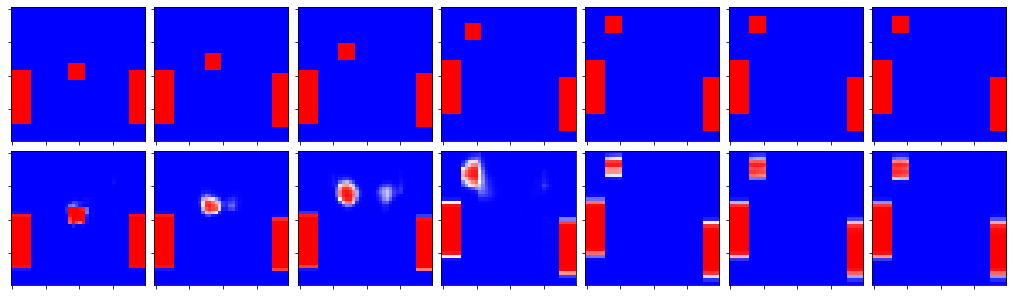

Epoch 138/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0661 - mean_squared_error: 0.0179 - acc: 0.9773 - val_loss: 0.0733 - val_mean_squared_error: 0.0190 - val_acc: 0.9765


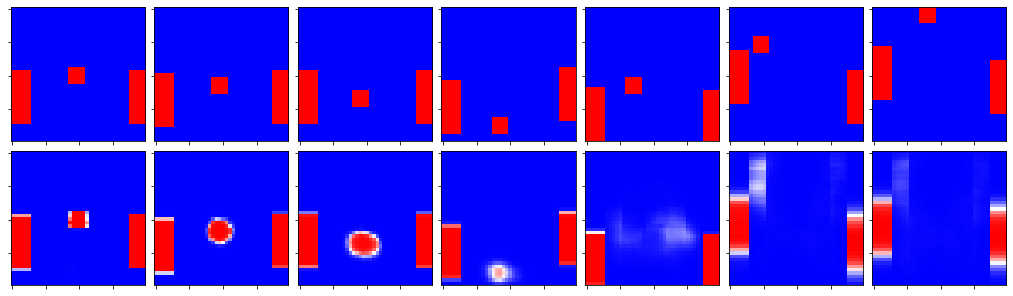

Epoch 139/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.0693 - mean_squared_error: 0.0190 - acc: 0.9757 - val_loss: 0.0606 - val_mean_squared_error: 0.0166 - val_acc: 0.9792


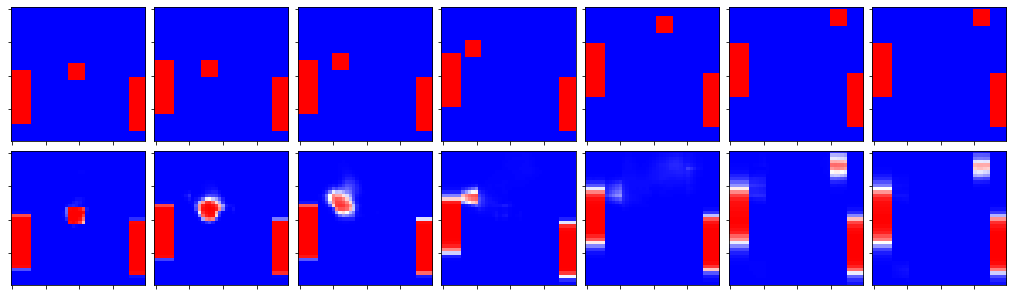

Epoch 140/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.0686 - mean_squared_error: 0.0187 - acc: 0.9762 - val_loss: 0.0672 - val_mean_squared_error: 0.0180 - val_acc: 0.9777


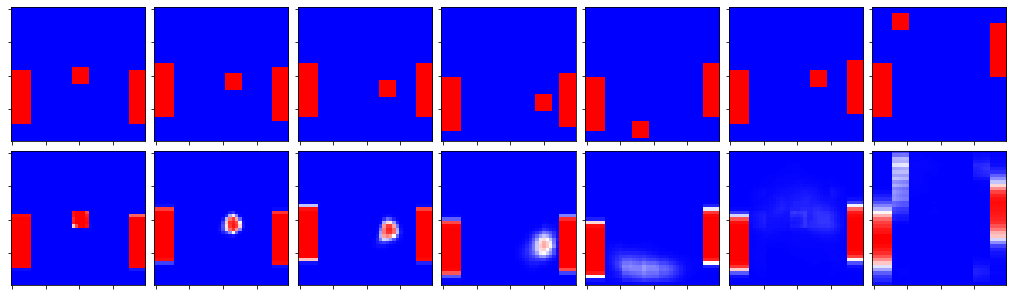

Epoch 141/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0702 - mean_squared_error: 0.0192 - acc: 0.9756 - val_loss: 0.0769 - val_mean_squared_error: 0.0215 - val_acc: 0.9720


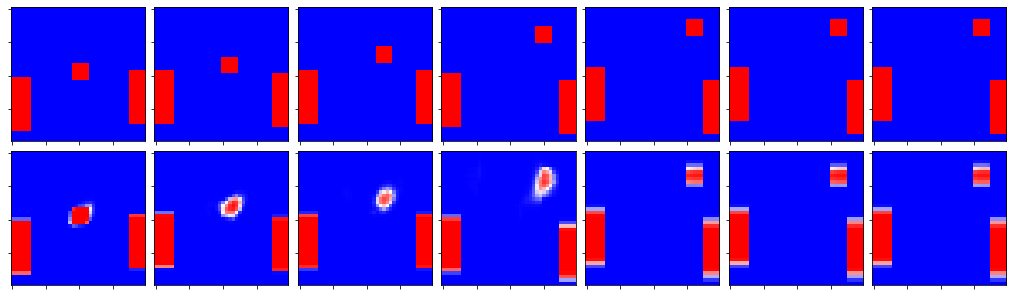

Epoch 142/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0667 - mean_squared_error: 0.0182 - acc: 0.9768 - val_loss: 0.0812 - val_mean_squared_error: 0.0217 - val_acc: 0.9727


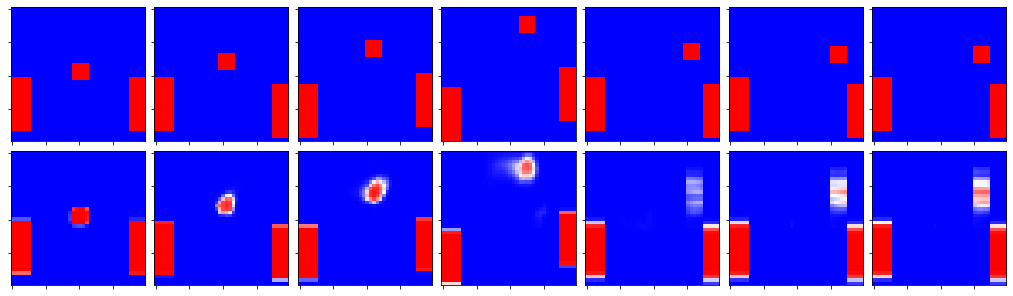

Epoch 143/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0692 - mean_squared_error: 0.0189 - acc: 0.9759 - val_loss: 0.0805 - val_mean_squared_error: 0.0218 - val_acc: 0.9724


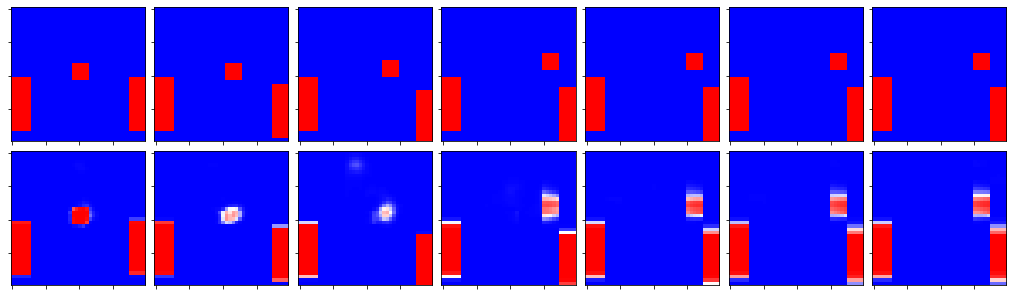

Epoch 144/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.0671 - mean_squared_error: 0.0183 - acc: 0.9765 - val_loss: 0.0592 - val_mean_squared_error: 0.0164 - val_acc: 0.9786


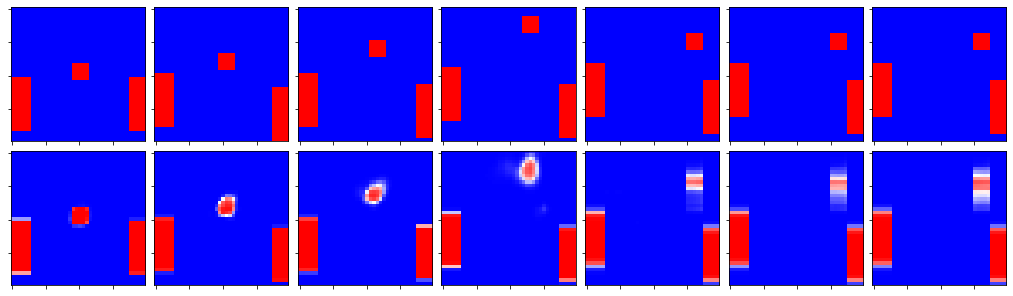

Epoch 145/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.0688 - mean_squared_error: 0.0189 - acc: 0.9758 - val_loss: 0.0685 - val_mean_squared_error: 0.0191 - val_acc: 0.9755


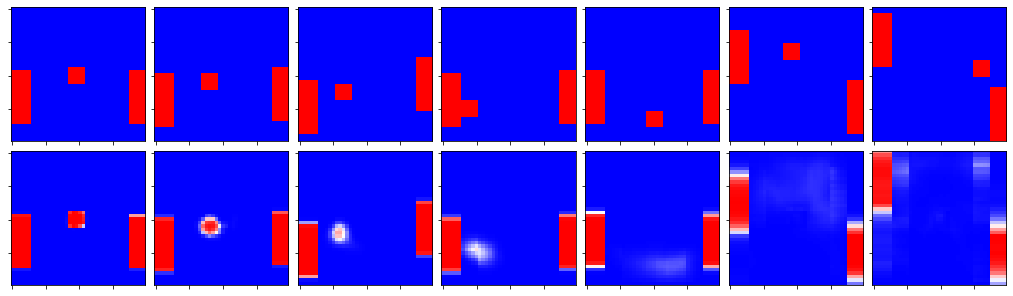

Epoch 146/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0695 - mean_squared_error: 0.0189 - acc: 0.9760 - val_loss: 0.0679 - val_mean_squared_error: 0.0189 - val_acc: 0.9754


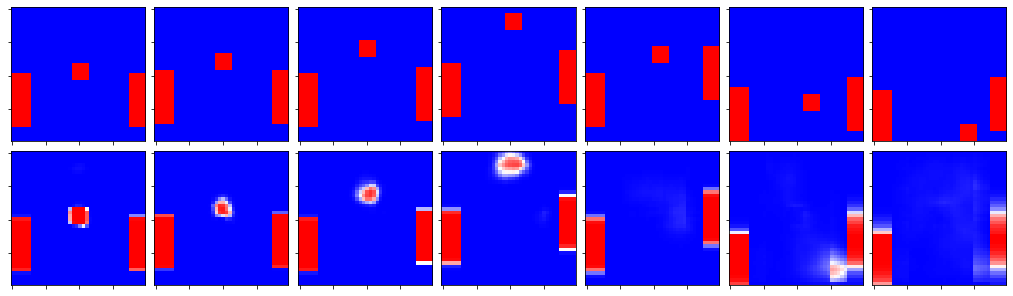

Epoch 147/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.0700 - mean_squared_error: 0.0191 - acc: 0.9756 - val_loss: 0.0707 - val_mean_squared_error: 0.0189 - val_acc: 0.9761


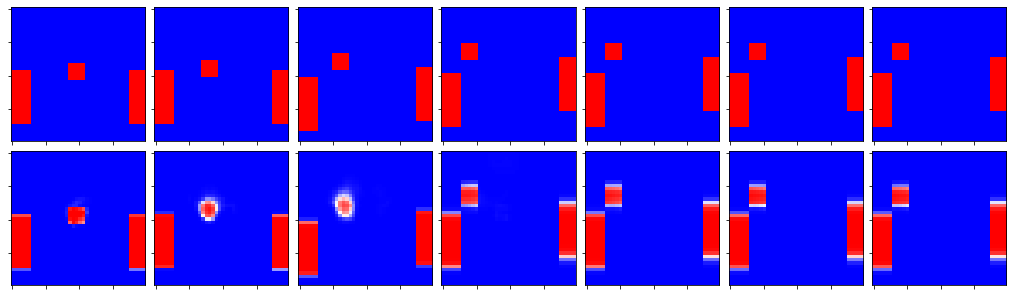

Epoch 148/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0666 - mean_squared_error: 0.0182 - acc: 0.9769 - val_loss: 0.0668 - val_mean_squared_error: 0.0185 - val_acc: 0.9765


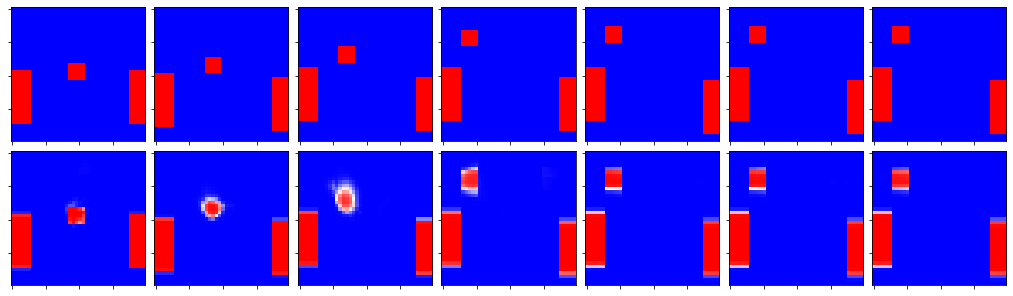

Epoch 149/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0695 - mean_squared_error: 0.0189 - acc: 0.9759 - val_loss: 0.0761 - val_mean_squared_error: 0.0205 - val_acc: 0.9741


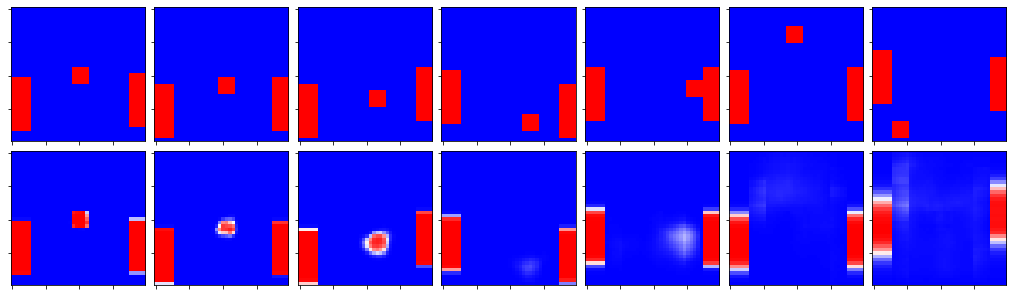

Epoch 150/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0665 - mean_squared_error: 0.0183 - acc: 0.9767 - val_loss: 0.0649 - val_mean_squared_error: 0.0175 - val_acc: 0.9777


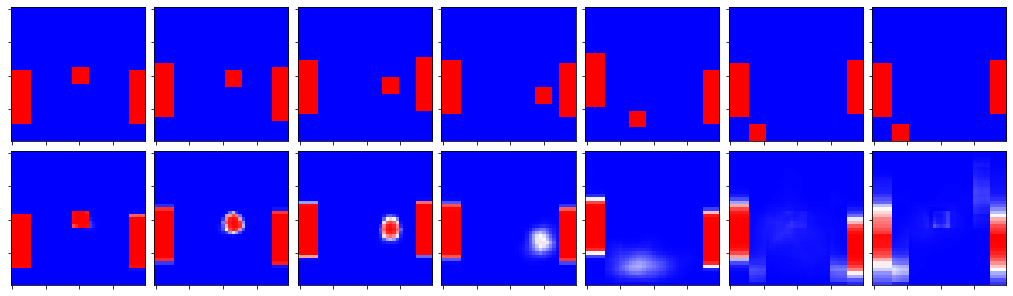

Epoch 151/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.0677 - mean_squared_error: 0.0185 - acc: 0.9765 - val_loss: 0.0640 - val_mean_squared_error: 0.0178 - val_acc: 0.9774


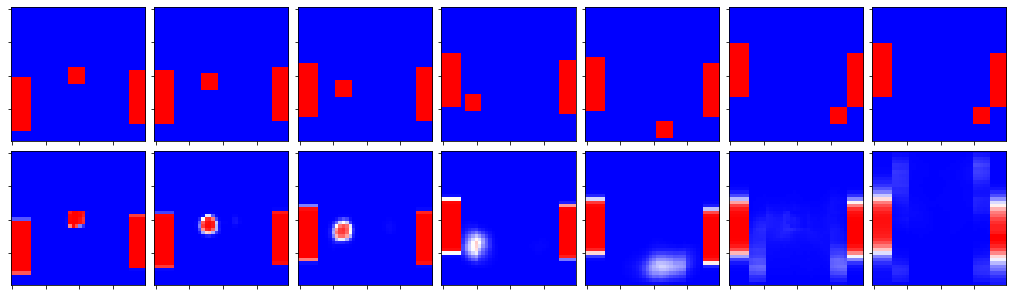

Epoch 152/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0678 - mean_squared_error: 0.0187 - acc: 0.9761 - val_loss: 0.0715 - val_mean_squared_error: 0.0191 - val_acc: 0.9762


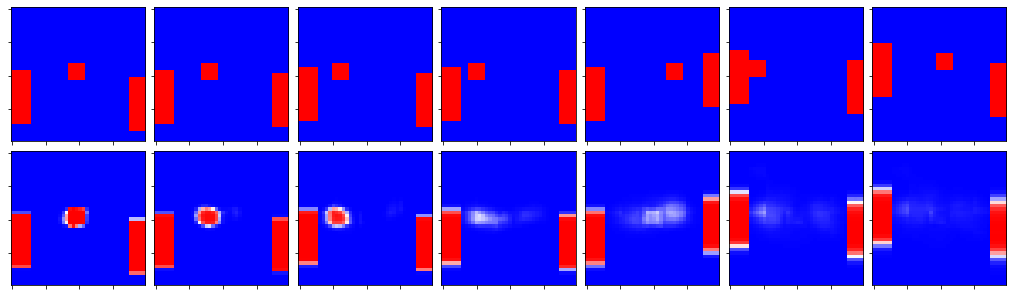

Epoch 153/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.0668 - mean_squared_error: 0.0183 - acc: 0.9767 - val_loss: 0.0623 - val_mean_squared_error: 0.0170 - val_acc: 0.9786


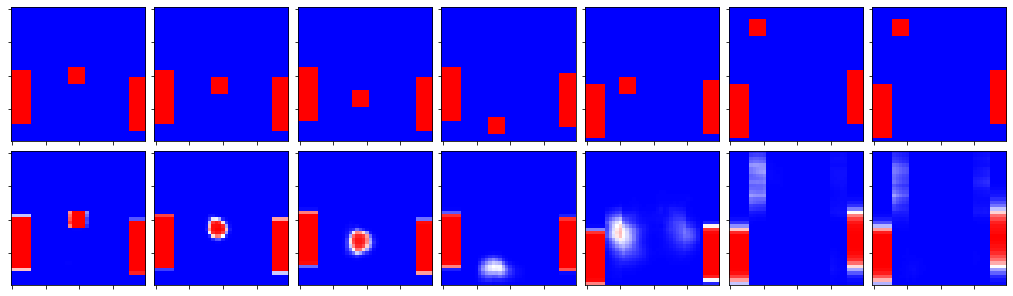

Epoch 154/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.0684 - mean_squared_error: 0.0187 - acc: 0.9761 - val_loss: 0.0630 - val_mean_squared_error: 0.0172 - val_acc: 0.9783


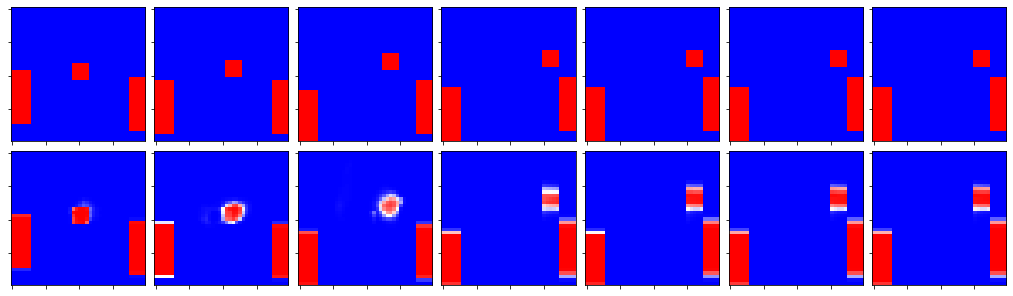

Epoch 155/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0647 - mean_squared_error: 0.0177 - acc: 0.9775 - val_loss: 0.0629 - val_mean_squared_error: 0.0172 - val_acc: 0.9780


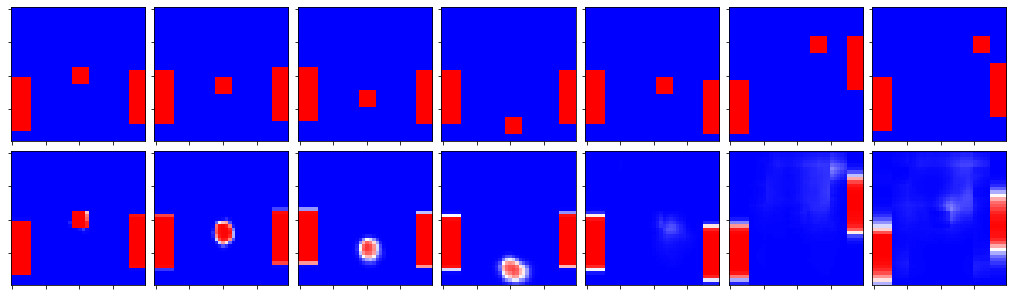

Epoch 156/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0650 - mean_squared_error: 0.0177 - acc: 0.9774 - val_loss: 0.0616 - val_mean_squared_error: 0.0172 - val_acc: 0.9777


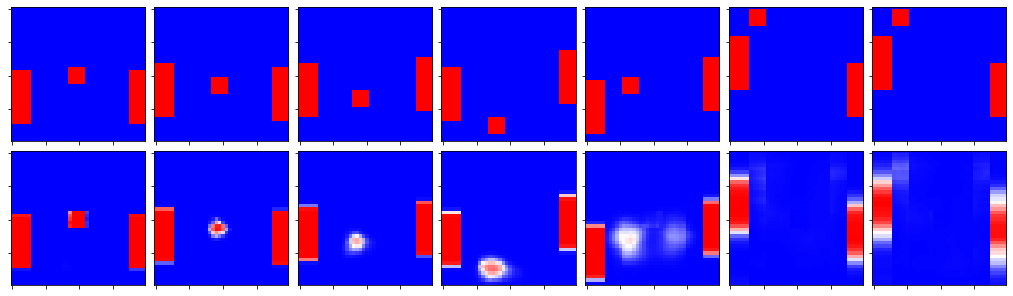

Epoch 157/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0675 - mean_squared_error: 0.0185 - acc: 0.9763 - val_loss: 0.0763 - val_mean_squared_error: 0.0202 - val_acc: 0.9748


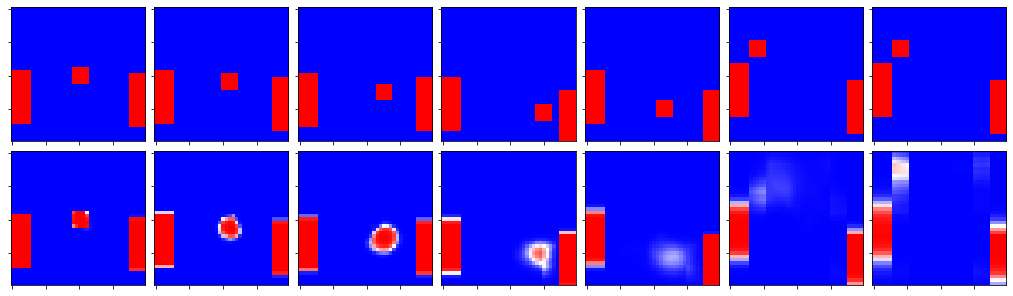

Epoch 158/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0750 - mean_squared_error: 0.0205 - acc: 0.9737 - val_loss: 0.0784 - val_mean_squared_error: 0.0220 - val_acc: 0.9716


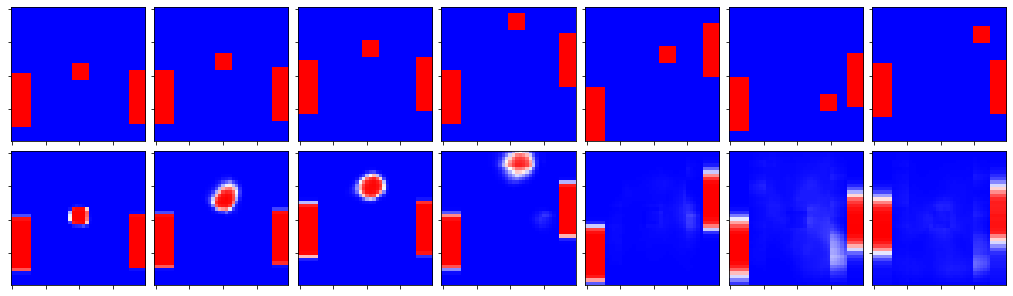

Epoch 159/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0754 - mean_squared_error: 0.0207 - acc: 0.9734 - val_loss: 0.0664 - val_mean_squared_error: 0.0182 - val_acc: 0.9768


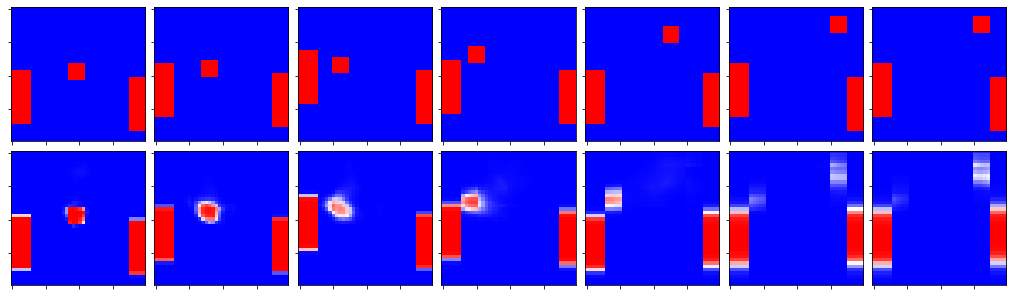

Epoch 160/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.0670 - mean_squared_error: 0.0183 - acc: 0.9766 - val_loss: 0.0592 - val_mean_squared_error: 0.0160 - val_acc: 0.9800


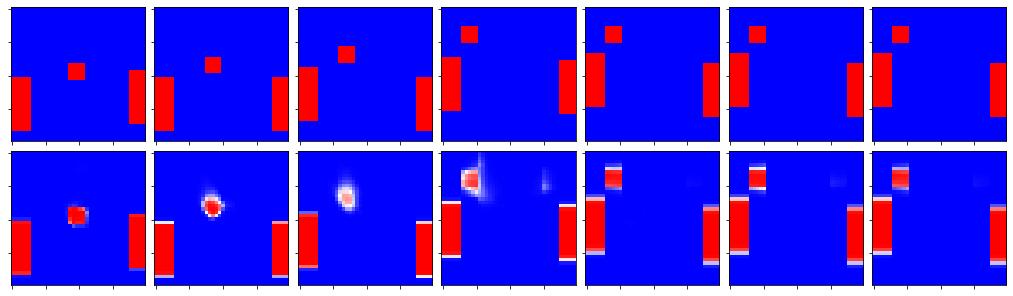

Epoch 161/2500
100/100 [==============================] - 49s 492ms/step - loss: 0.0663 - mean_squared_error: 0.0181 - acc: 0.9771 - val_loss: 0.0698 - val_mean_squared_error: 0.0195 - val_acc: 0.9749


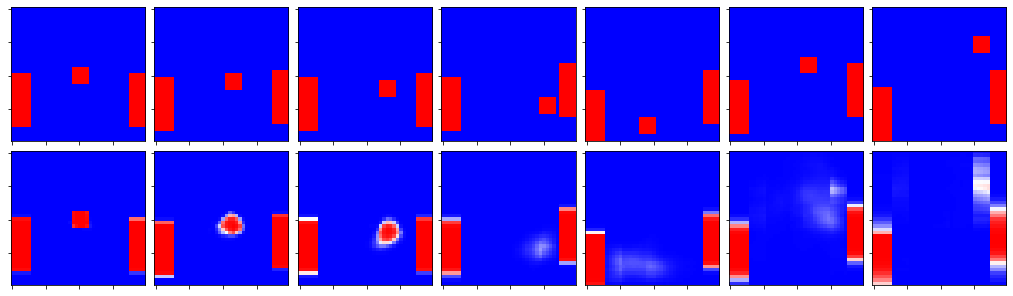

Epoch 162/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0683 - mean_squared_error: 0.0187 - acc: 0.9761 - val_loss: 0.0585 - val_mean_squared_error: 0.0161 - val_acc: 0.9792


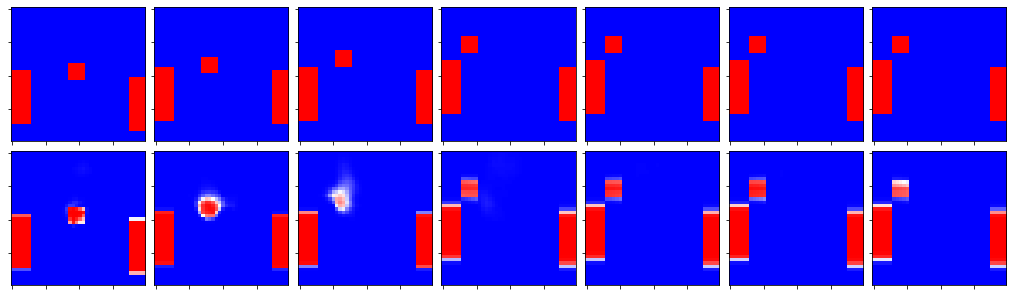

Epoch 163/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0666 - mean_squared_error: 0.0183 - acc: 0.9765 - val_loss: 0.0717 - val_mean_squared_error: 0.0199 - val_acc: 0.9744


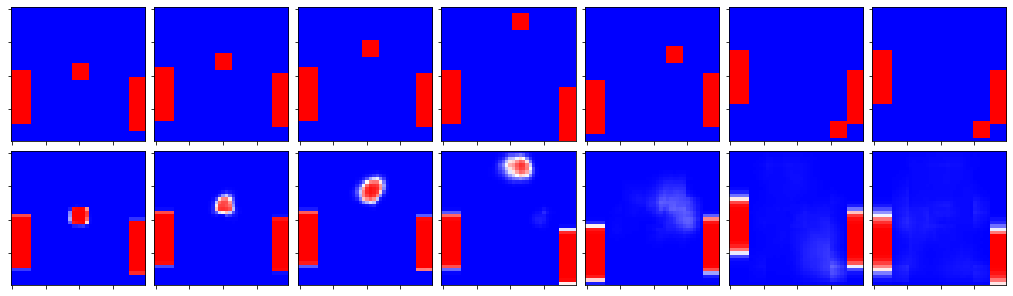

Epoch 164/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0675 - mean_squared_error: 0.0187 - acc: 0.9760 - val_loss: 0.0618 - val_mean_squared_error: 0.0171 - val_acc: 0.9778


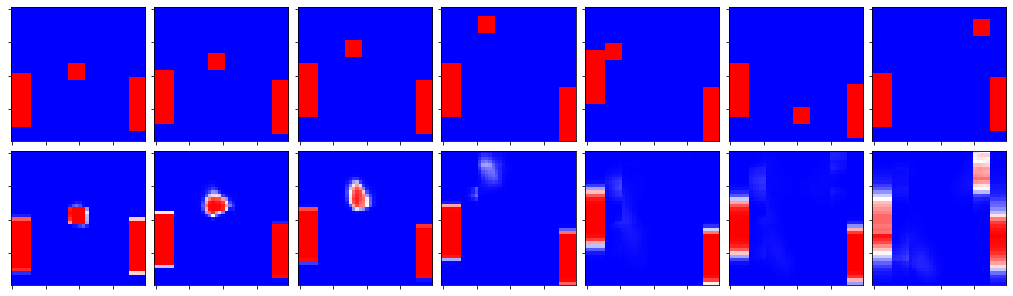

Epoch 165/2500
100/100 [==============================] - 49s 491ms/step - loss: 0.0657 - mean_squared_error: 0.0180 - acc: 0.9770 - val_loss: 0.0625 - val_mean_squared_error: 0.0174 - val_acc: 0.9776


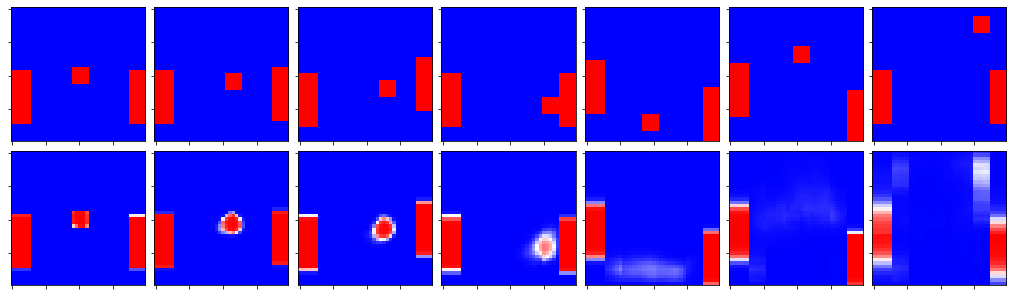

Epoch 166/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0647 - mean_squared_error: 0.0177 - acc: 0.9774 - val_loss: 0.0689 - val_mean_squared_error: 0.0190 - val_acc: 0.9753


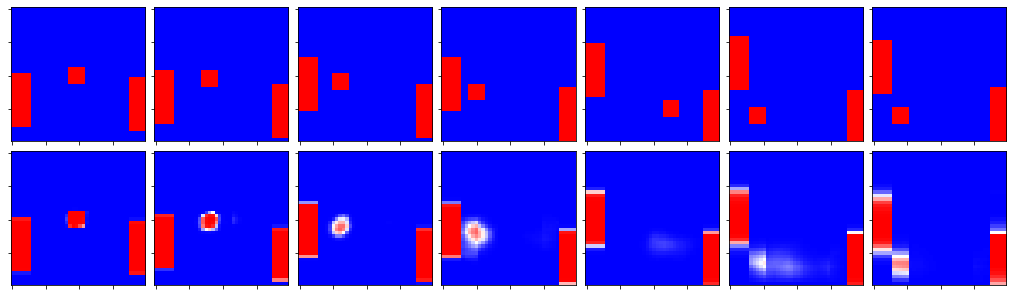

Epoch 167/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0640 - mean_squared_error: 0.0175 - acc: 0.9776 - val_loss: 0.0573 - val_mean_squared_error: 0.0157 - val_acc: 0.9799


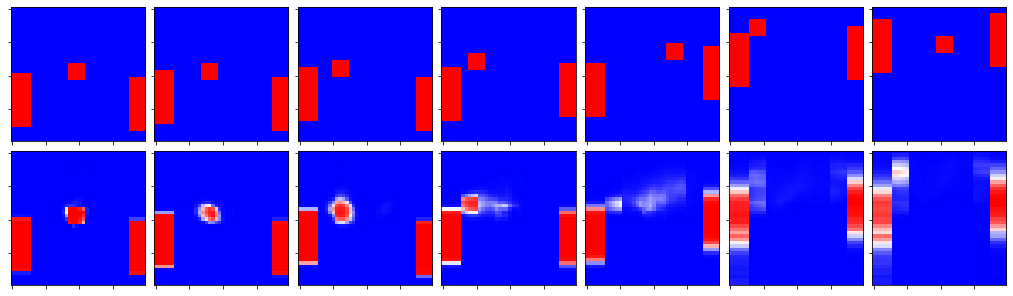

Epoch 168/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0668 - mean_squared_error: 0.0183 - acc: 0.9765 - val_loss: 0.0757 - val_mean_squared_error: 0.0205 - val_acc: 0.9738


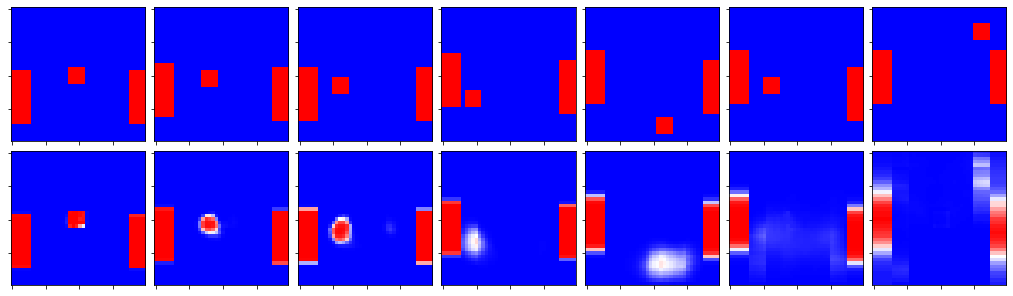

Epoch 169/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0653 - mean_squared_error: 0.0179 - acc: 0.9771 - val_loss: 0.0668 - val_mean_squared_error: 0.0183 - val_acc: 0.9770


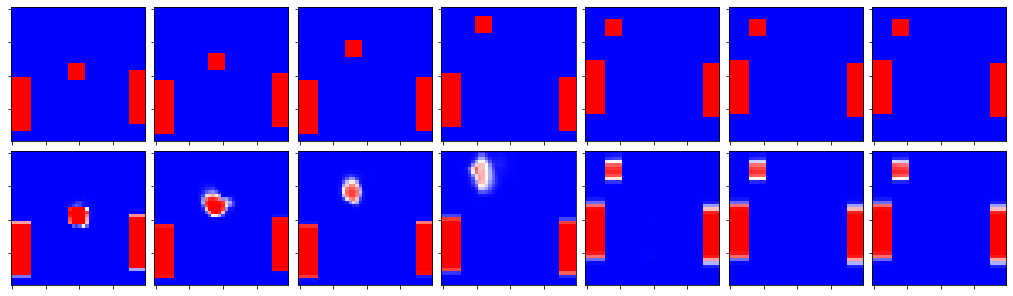

Epoch 170/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0652 - mean_squared_error: 0.0178 - acc: 0.9772 - val_loss: 0.0865 - val_mean_squared_error: 0.0228 - val_acc: 0.9708


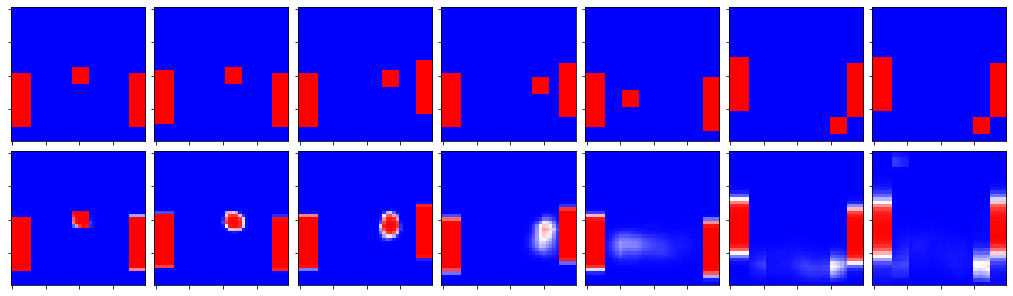

Epoch 171/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0673 - mean_squared_error: 0.0185 - acc: 0.9763 - val_loss: 0.0697 - val_mean_squared_error: 0.0198 - val_acc: 0.9737


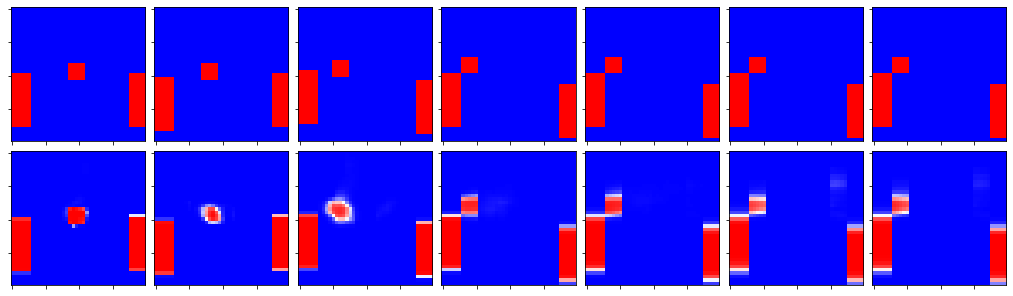

Epoch 172/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0661 - mean_squared_error: 0.0181 - acc: 0.9767 - val_loss: 0.0648 - val_mean_squared_error: 0.0179 - val_acc: 0.9770


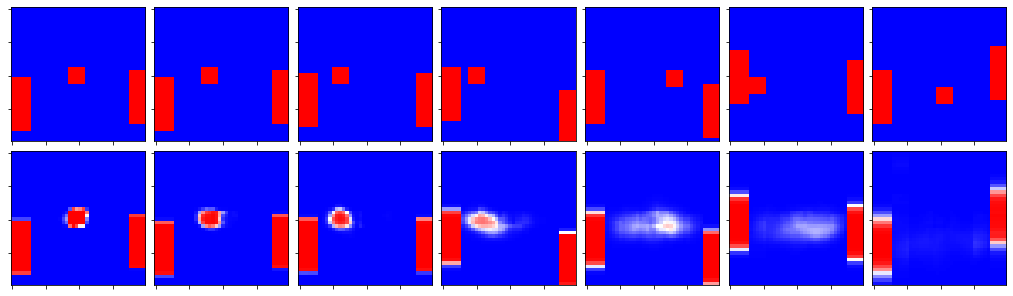

Epoch 173/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0664 - mean_squared_error: 0.0182 - acc: 0.9767 - val_loss: 0.0606 - val_mean_squared_error: 0.0165 - val_acc: 0.9790


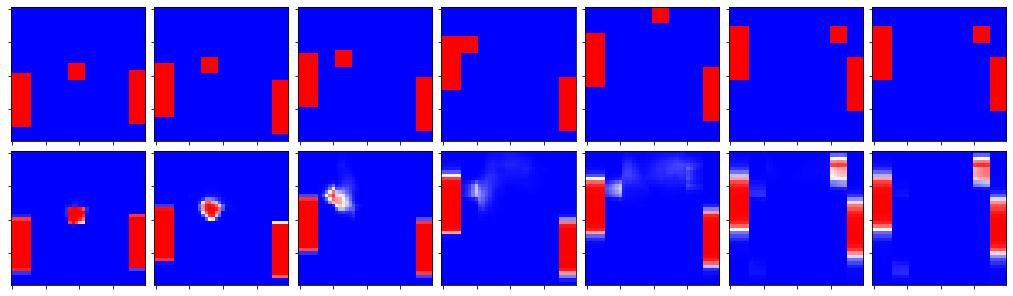

Epoch 174/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0654 - mean_squared_error: 0.0179 - acc: 0.9772 - val_loss: 0.0677 - val_mean_squared_error: 0.0182 - val_acc: 0.9771


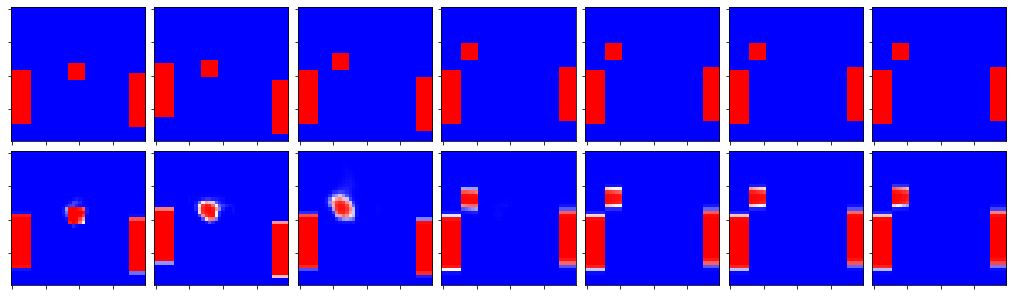

Epoch 175/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.0649 - mean_squared_error: 0.0177 - acc: 0.9774 - val_loss: 0.0601 - val_mean_squared_error: 0.0164 - val_acc: 0.9793


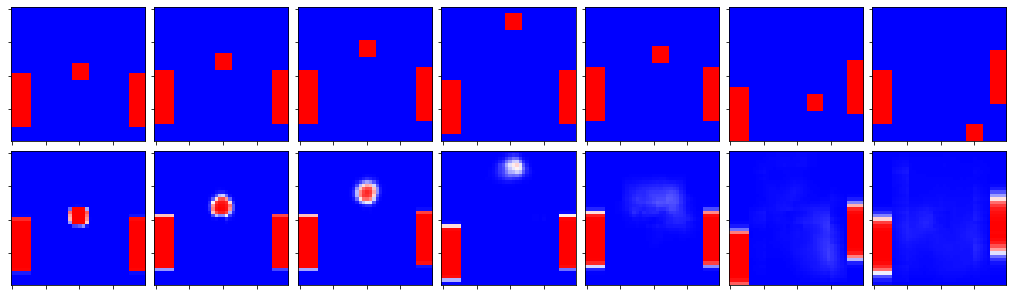

Epoch 176/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0664 - mean_squared_error: 0.0182 - acc: 0.9766 - val_loss: 0.0549 - val_mean_squared_error: 0.0151 - val_acc: 0.9808


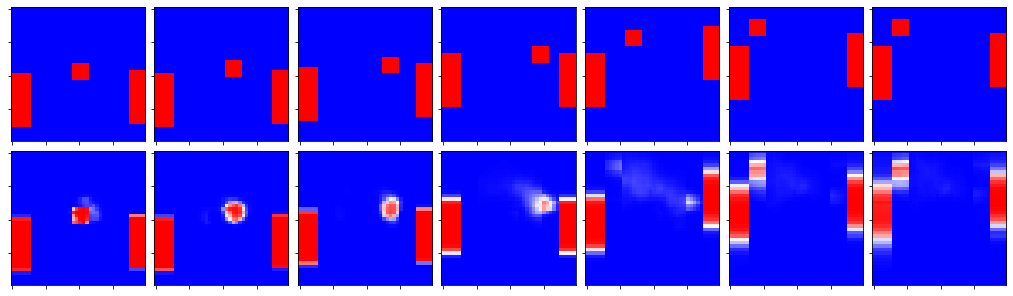

Epoch 177/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.0667 - mean_squared_error: 0.0183 - acc: 0.9766 - val_loss: 0.0662 - val_mean_squared_error: 0.0186 - val_acc: 0.9759


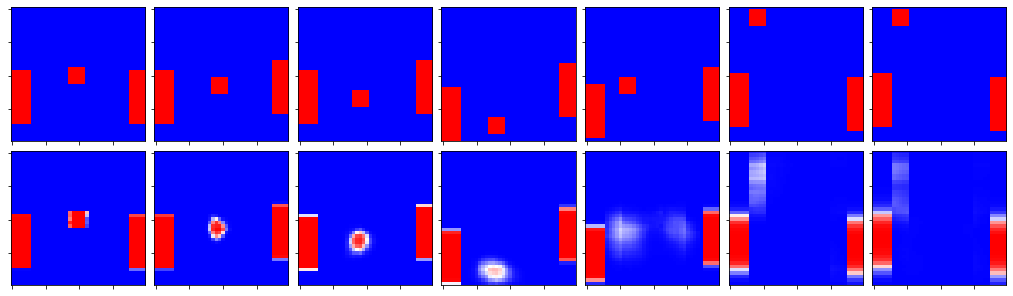

Epoch 178/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0663 - mean_squared_error: 0.0181 - acc: 0.9768 - val_loss: 0.0643 - val_mean_squared_error: 0.0177 - val_acc: 0.9770


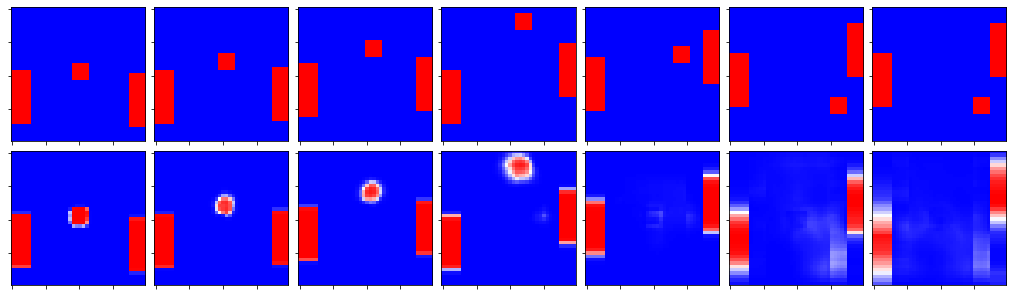

Epoch 179/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0641 - mean_squared_error: 0.0177 - acc: 0.9774 - val_loss: 0.0683 - val_mean_squared_error: 0.0190 - val_acc: 0.9757


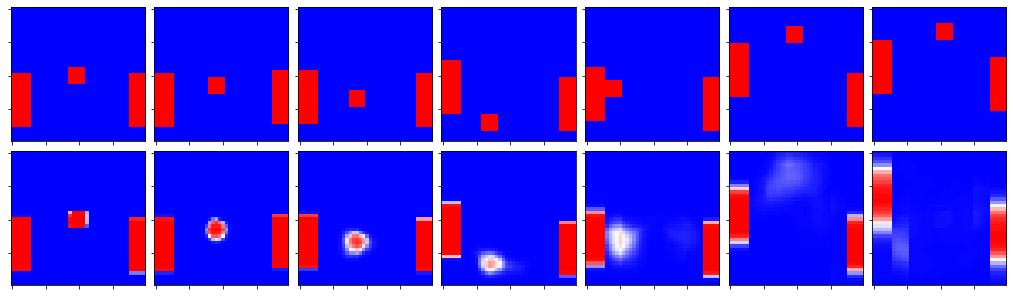

Epoch 180/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0650 - mean_squared_error: 0.0179 - acc: 0.9771 - val_loss: 0.0618 - val_mean_squared_error: 0.0170 - val_acc: 0.9781


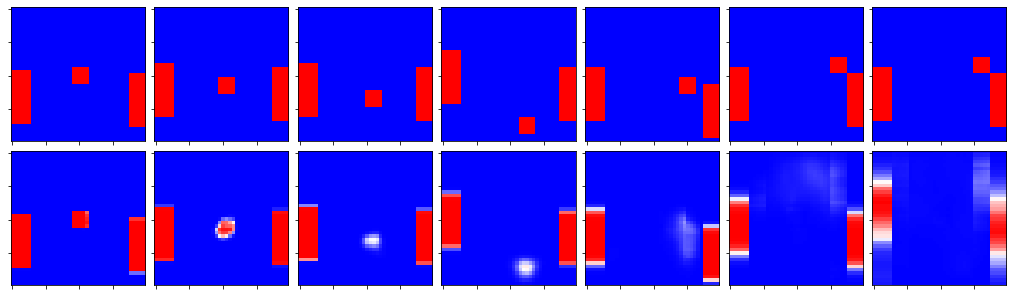

Epoch 181/2500
100/100 [==============================] - 49s 492ms/step - loss: 0.0653 - mean_squared_error: 0.0180 - acc: 0.9769 - val_loss: 0.0694 - val_mean_squared_error: 0.0183 - val_acc: 0.9765


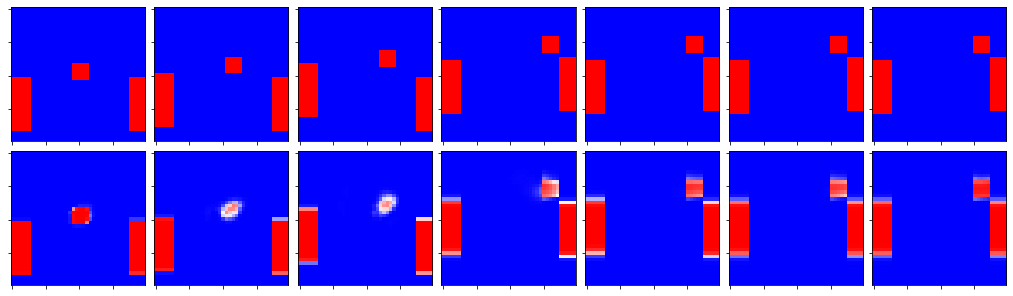

Epoch 182/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.0669 - mean_squared_error: 0.0184 - acc: 0.9764 - val_loss: 0.0580 - val_mean_squared_error: 0.0161 - val_acc: 0.9792


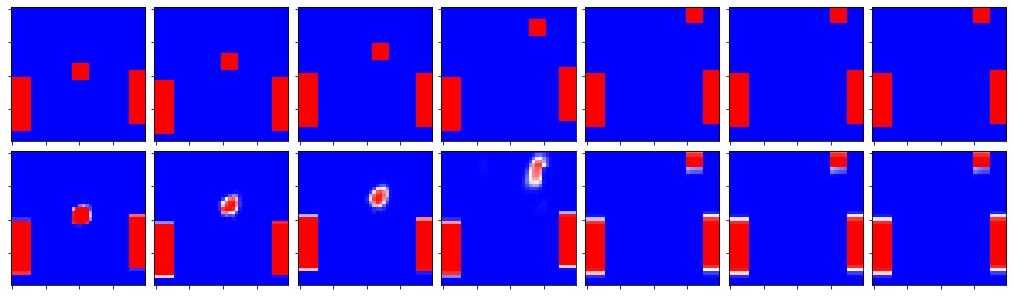

Epoch 183/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0639 - mean_squared_error: 0.0177 - acc: 0.9772 - val_loss: 0.0705 - val_mean_squared_error: 0.0196 - val_acc: 0.9744


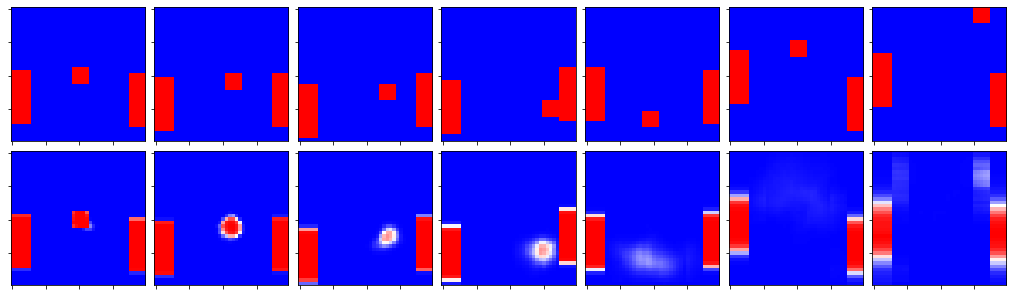

Epoch 184/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0657 - mean_squared_error: 0.0181 - acc: 0.9769 - val_loss: 0.0742 - val_mean_squared_error: 0.0212 - val_acc: 0.9723


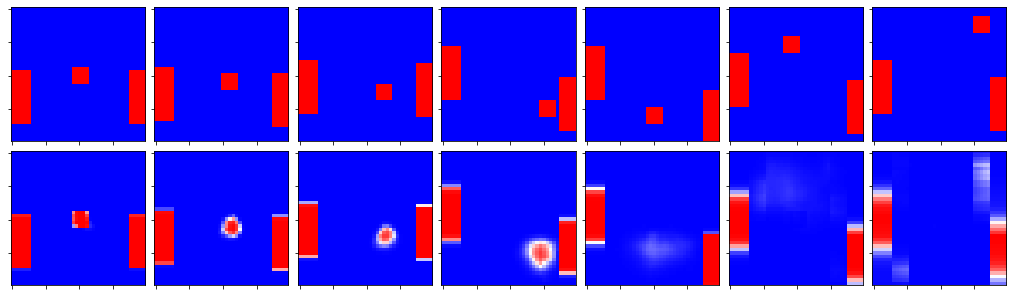

Epoch 185/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0642 - mean_squared_error: 0.0177 - acc: 0.9773 - val_loss: 0.0597 - val_mean_squared_error: 0.0165 - val_acc: 0.9790


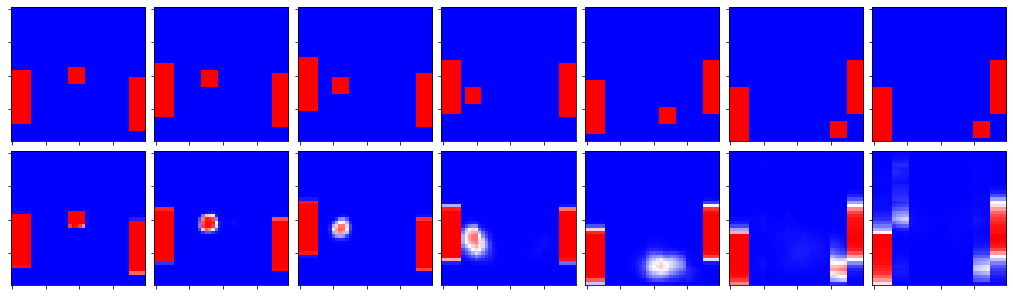

Epoch 186/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0655 - mean_squared_error: 0.0180 - acc: 0.9769 - val_loss: 0.0614 - val_mean_squared_error: 0.0168 - val_acc: 0.9788


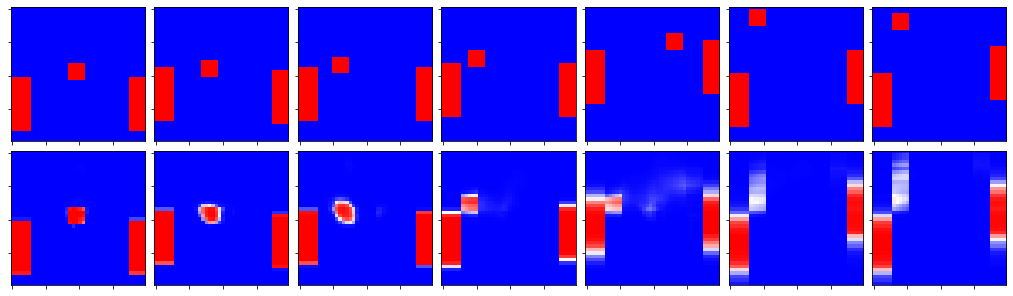

Epoch 187/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.0641 - mean_squared_error: 0.0175 - acc: 0.9775 - val_loss: 0.0630 - val_mean_squared_error: 0.0176 - val_acc: 0.9773


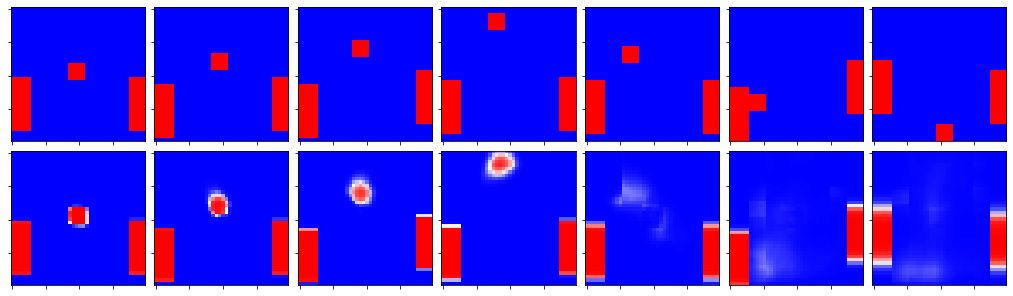

Epoch 188/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.0635 - mean_squared_error: 0.0174 - acc: 0.9777 - val_loss: 0.0631 - val_mean_squared_error: 0.0172 - val_acc: 0.9781


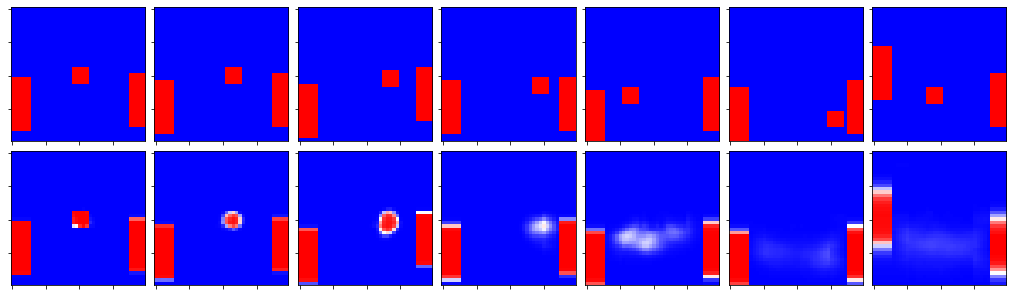

Epoch 189/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0646 - mean_squared_error: 0.0177 - acc: 0.9773 - val_loss: 0.0566 - val_mean_squared_error: 0.0156 - val_acc: 0.9801


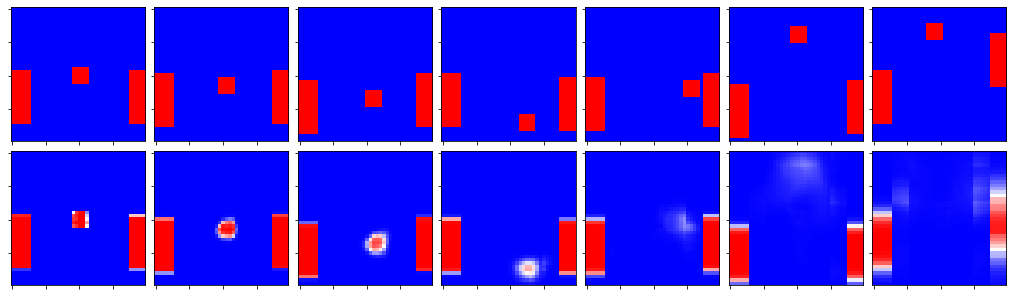

Epoch 190/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0654 - mean_squared_error: 0.0180 - acc: 0.9770 - val_loss: 0.0779 - val_mean_squared_error: 0.0211 - val_acc: 0.9728


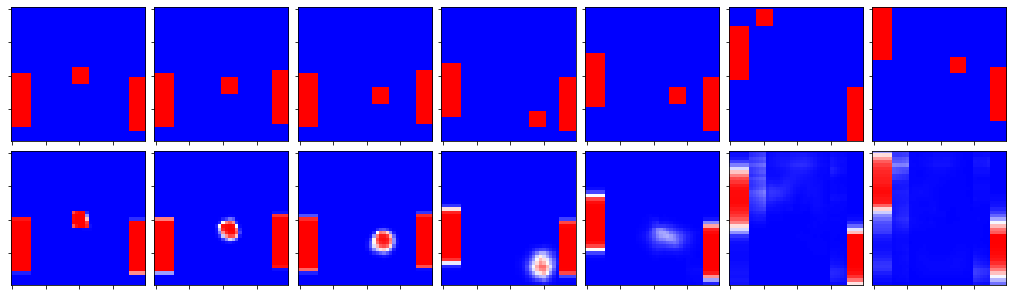

Epoch 191/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0652 - mean_squared_error: 0.0180 - acc: 0.9768 - val_loss: 0.0644 - val_mean_squared_error: 0.0180 - val_acc: 0.9763


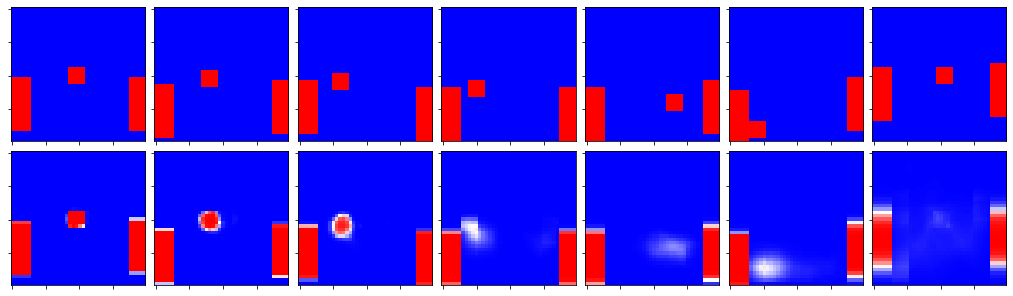

Epoch 192/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0627 - mean_squared_error: 0.0172 - acc: 0.9781 - val_loss: 0.0654 - val_mean_squared_error: 0.0181 - val_acc: 0.9766


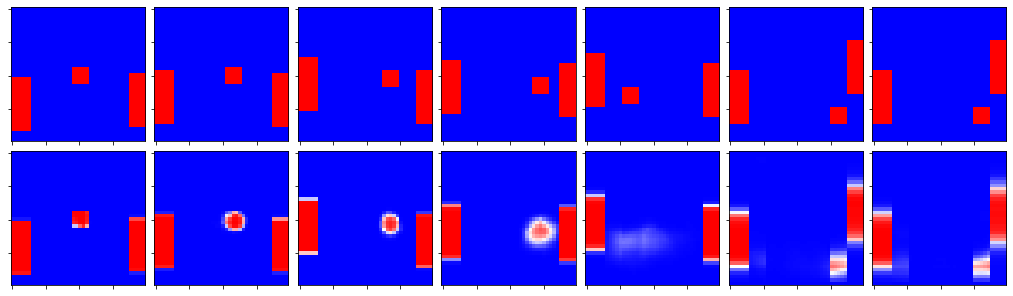

Epoch 193/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0654 - mean_squared_error: 0.0181 - acc: 0.9768 - val_loss: 0.0660 - val_mean_squared_error: 0.0180 - val_acc: 0.9776


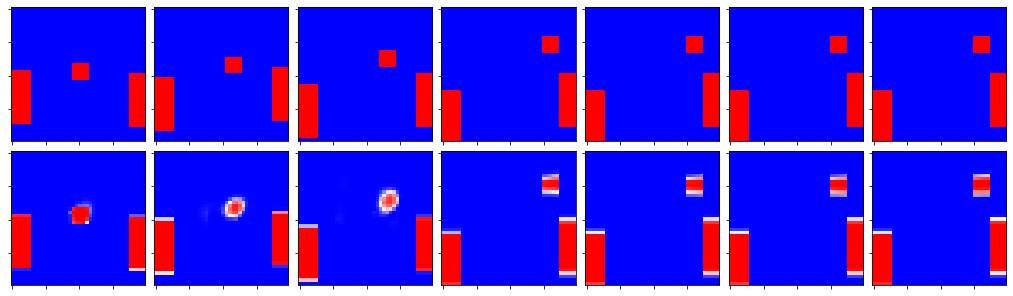

Epoch 194/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.0631 - mean_squared_error: 0.0173 - acc: 0.9778 - val_loss: 0.0657 - val_mean_squared_error: 0.0178 - val_acc: 0.9771


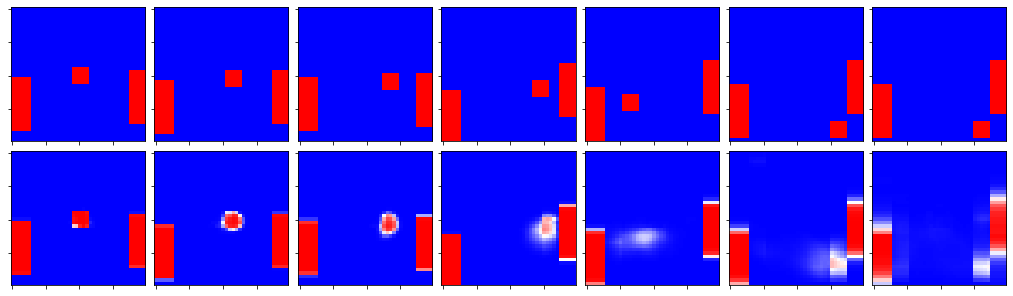

Epoch 195/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0648 - mean_squared_error: 0.0178 - acc: 0.9771 - val_loss: 0.0690 - val_mean_squared_error: 0.0195 - val_acc: 0.9751


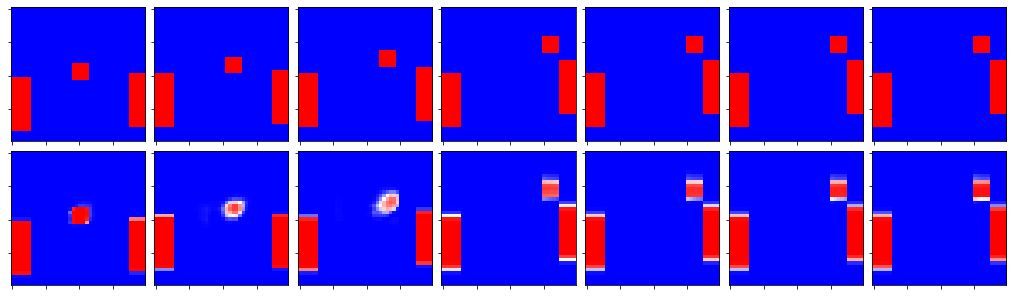

Epoch 196/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0663 - mean_squared_error: 0.0182 - acc: 0.9765 - val_loss: 0.0659 - val_mean_squared_error: 0.0180 - val_acc: 0.9771


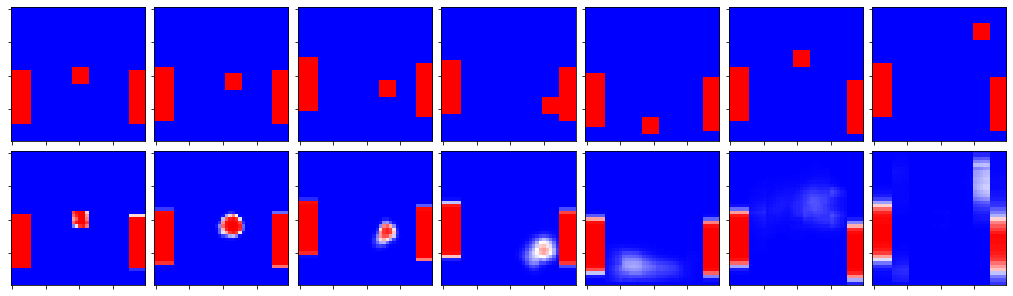

Epoch 197/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.0659 - mean_squared_error: 0.0181 - acc: 0.9768 - val_loss: 0.0746 - val_mean_squared_error: 0.0205 - val_acc: 0.9737


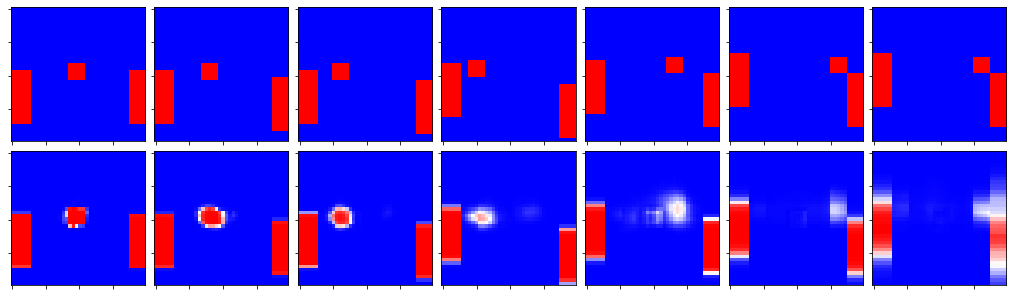

Epoch 198/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.0660 - mean_squared_error: 0.0181 - acc: 0.9768 - val_loss: 0.0578 - val_mean_squared_error: 0.0162 - val_acc: 0.9791


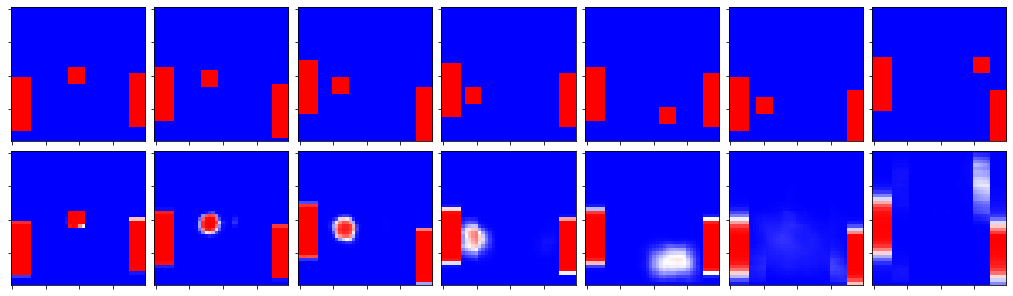

Epoch 199/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.0635 - mean_squared_error: 0.0174 - acc: 0.9777 - val_loss: 0.0653 - val_mean_squared_error: 0.0181 - val_acc: 0.9765


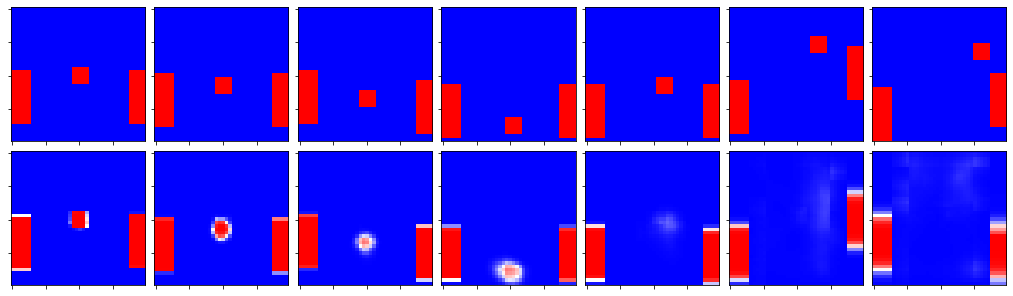

Epoch 200/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0648 - mean_squared_error: 0.0178 - acc: 0.9772 - val_loss: 0.0648 - val_mean_squared_error: 0.0180 - val_acc: 0.9771


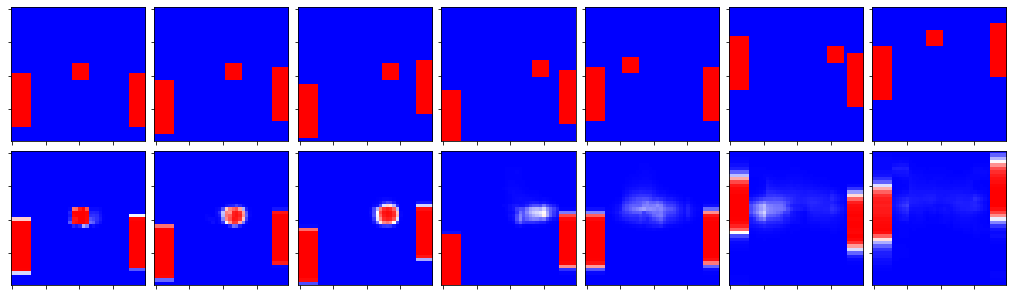

Epoch 201/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0618 - mean_squared_error: 0.0169 - acc: 0.9783 - val_loss: 0.0635 - val_mean_squared_error: 0.0179 - val_acc: 0.9766


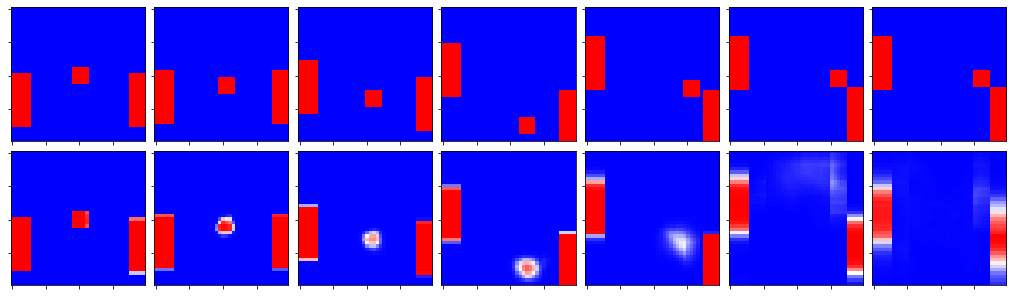

Epoch 202/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0616 - mean_squared_error: 0.0169 - acc: 0.9784 - val_loss: 0.0587 - val_mean_squared_error: 0.0162 - val_acc: 0.9793


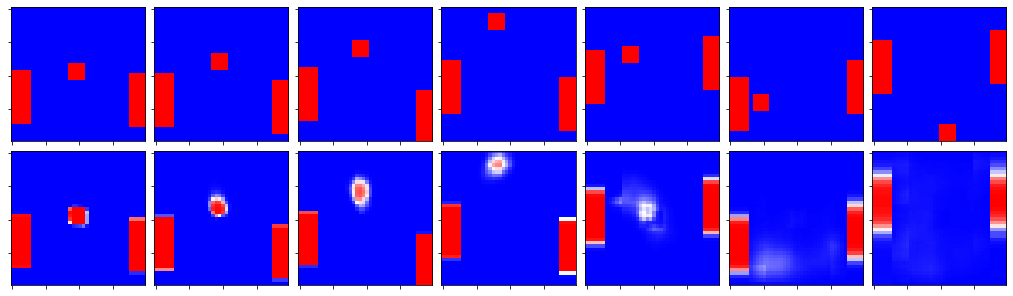

Epoch 203/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0621 - mean_squared_error: 0.0171 - acc: 0.9781 - val_loss: 0.0597 - val_mean_squared_error: 0.0167 - val_acc: 0.9783


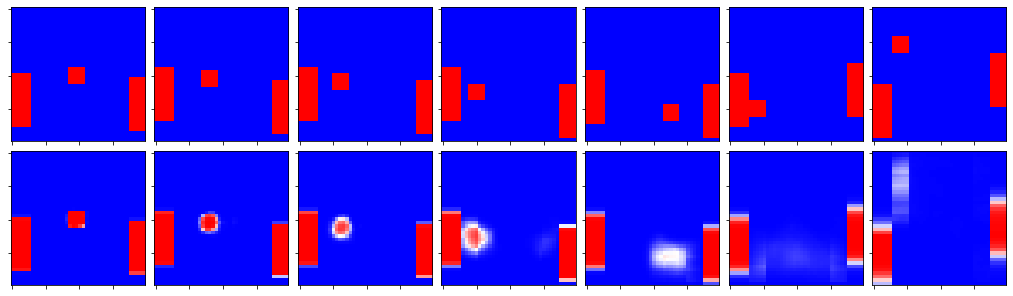

Epoch 204/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0641 - mean_squared_error: 0.0175 - acc: 0.9776 - val_loss: 0.0586 - val_mean_squared_error: 0.0165 - val_acc: 0.9783


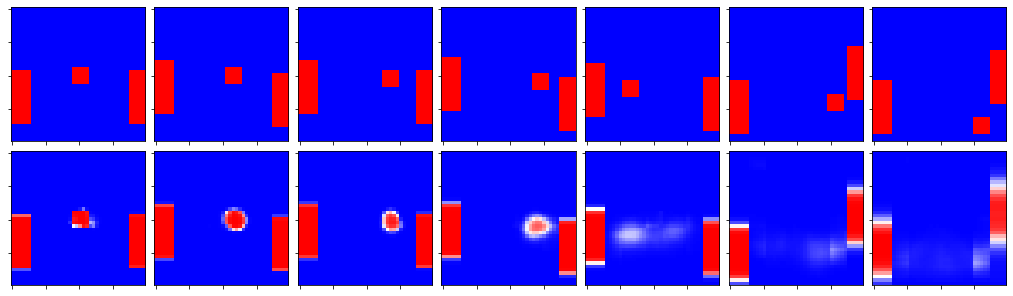

Epoch 205/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0624 - mean_squared_error: 0.0171 - acc: 0.9781 - val_loss: 0.0578 - val_mean_squared_error: 0.0160 - val_acc: 0.9791


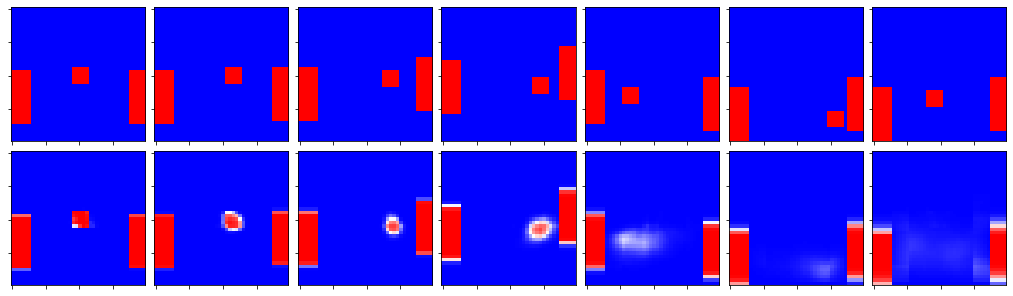

Epoch 206/2500
100/100 [==============================] - 49s 492ms/step - loss: 0.0636 - mean_squared_error: 0.0174 - acc: 0.9777 - val_loss: 0.0584 - val_mean_squared_error: 0.0161 - val_acc: 0.9794


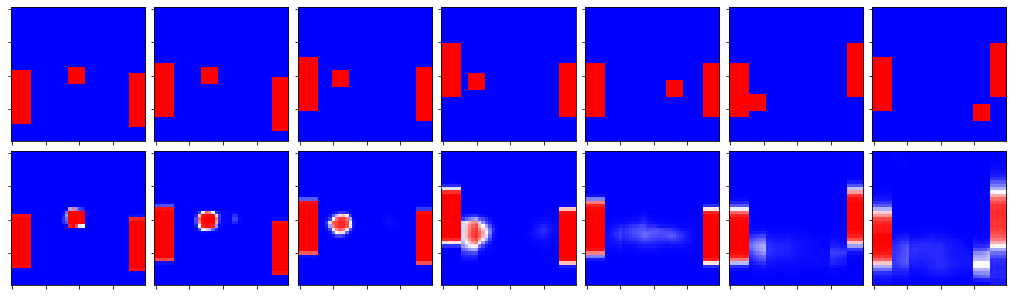

Epoch 207/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.0609 - mean_squared_error: 0.0167 - acc: 0.9787 - val_loss: 0.0606 - val_mean_squared_error: 0.0166 - val_acc: 0.9792


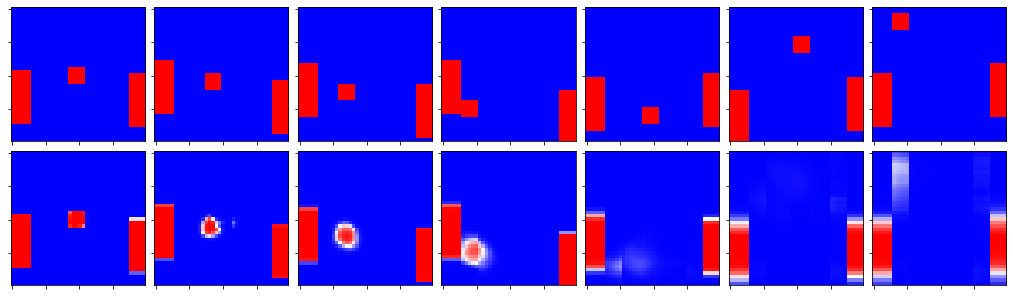

Epoch 208/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0631 - mean_squared_error: 0.0174 - acc: 0.9777 - val_loss: 0.0638 - val_mean_squared_error: 0.0175 - val_acc: 0.9778


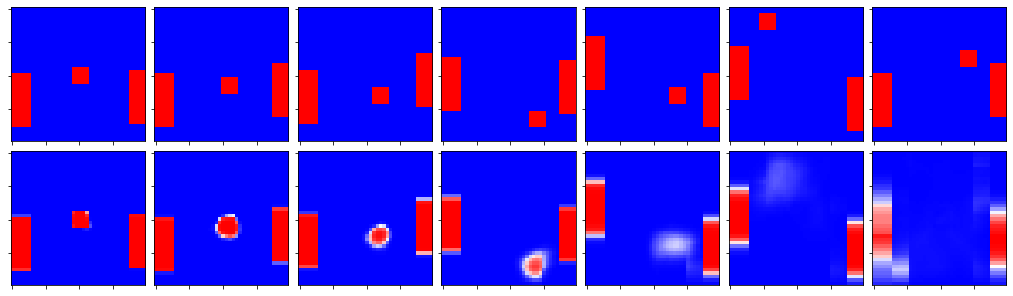

Epoch 209/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.0651 - mean_squared_error: 0.0179 - acc: 0.9769 - val_loss: 0.0719 - val_mean_squared_error: 0.0200 - val_acc: 0.9741


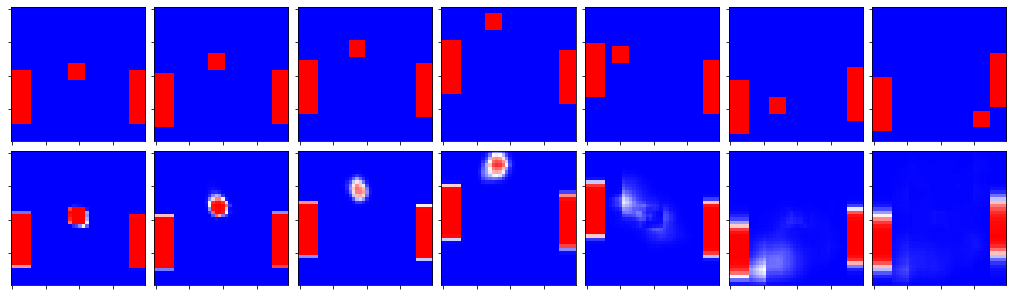

Epoch 210/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0620 - mean_squared_error: 0.0171 - acc: 0.9780 - val_loss: 0.0615 - val_mean_squared_error: 0.0171 - val_acc: 0.9779


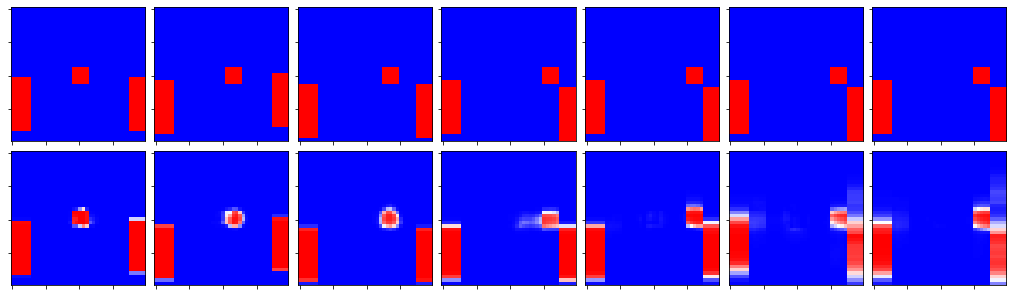

Epoch 211/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0632 - mean_squared_error: 0.0173 - acc: 0.9777 - val_loss: 0.0594 - val_mean_squared_error: 0.0167 - val_acc: 0.9778


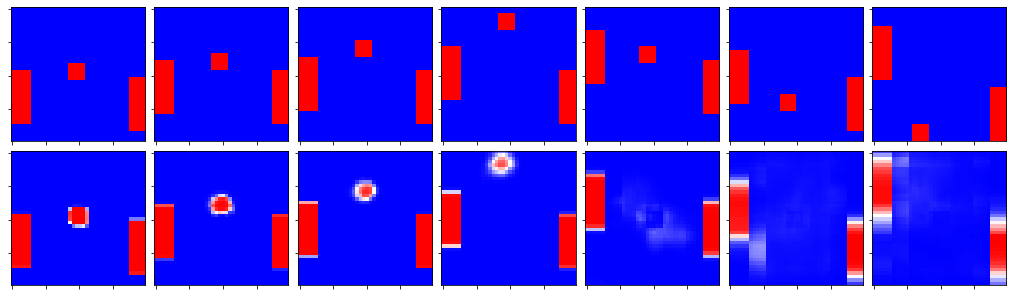

Epoch 212/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.0658 - mean_squared_error: 0.0181 - acc: 0.9767 - val_loss: 0.0663 - val_mean_squared_error: 0.0172 - val_acc: 0.9788


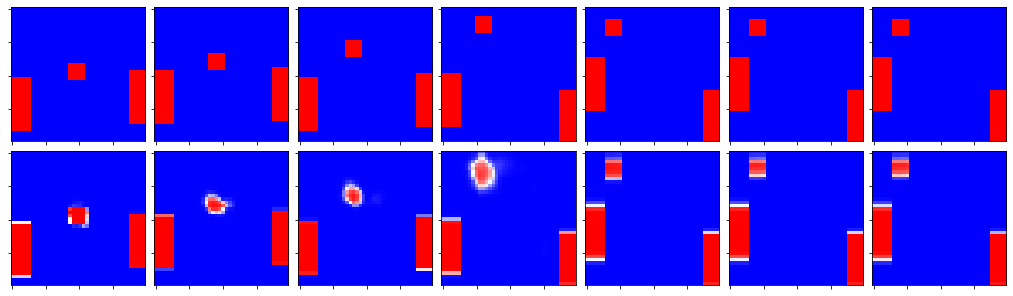

Epoch 213/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0621 - mean_squared_error: 0.0171 - acc: 0.9780 - val_loss: 0.0636 - val_mean_squared_error: 0.0174 - val_acc: 0.9774


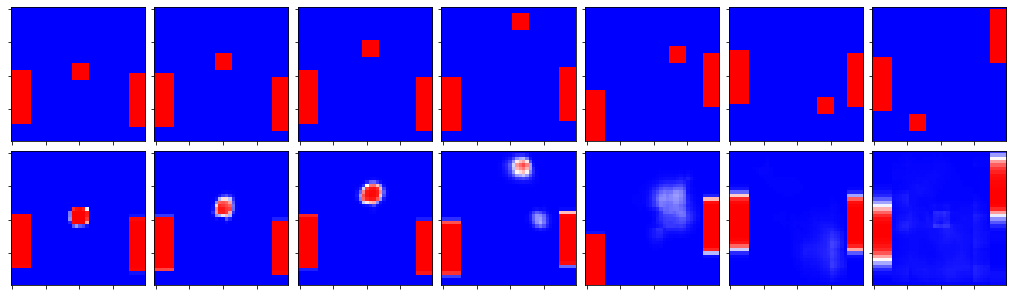

Epoch 214/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0613 - mean_squared_error: 0.0167 - acc: 0.9786 - val_loss: 0.0617 - val_mean_squared_error: 0.0169 - val_acc: 0.9782


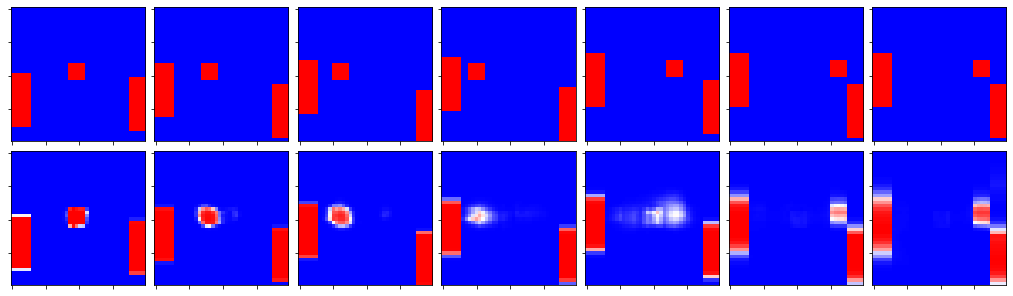

Epoch 215/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0633 - mean_squared_error: 0.0173 - acc: 0.9777 - val_loss: 0.0610 - val_mean_squared_error: 0.0171 - val_acc: 0.9779


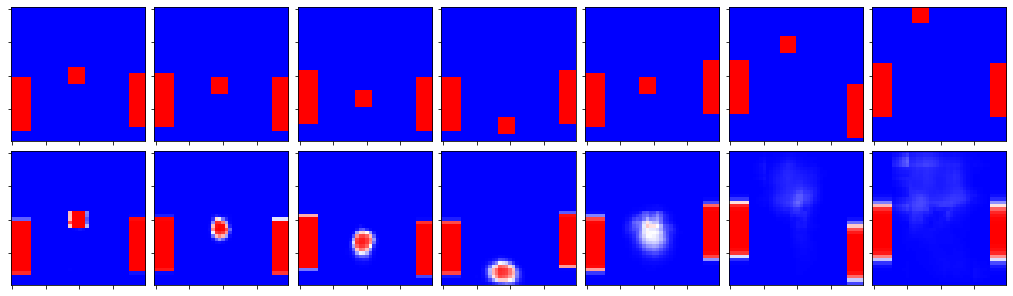

Epoch 216/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0634 - mean_squared_error: 0.0174 - acc: 0.9776 - val_loss: 0.0684 - val_mean_squared_error: 0.0193 - val_acc: 0.9751


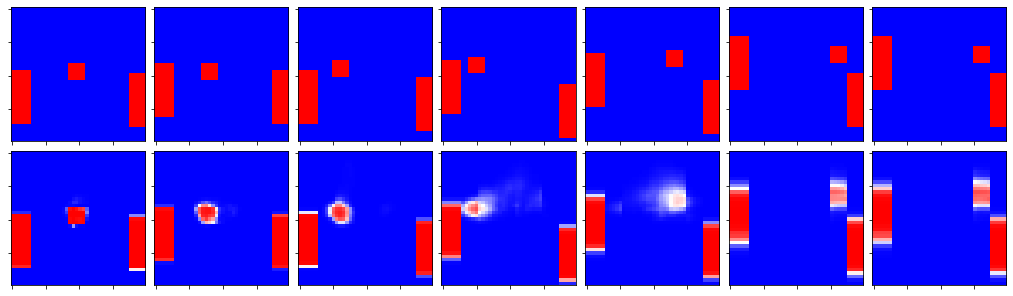

Epoch 217/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.0627 - mean_squared_error: 0.0172 - acc: 0.9779 - val_loss: 0.0602 - val_mean_squared_error: 0.0164 - val_acc: 0.9791


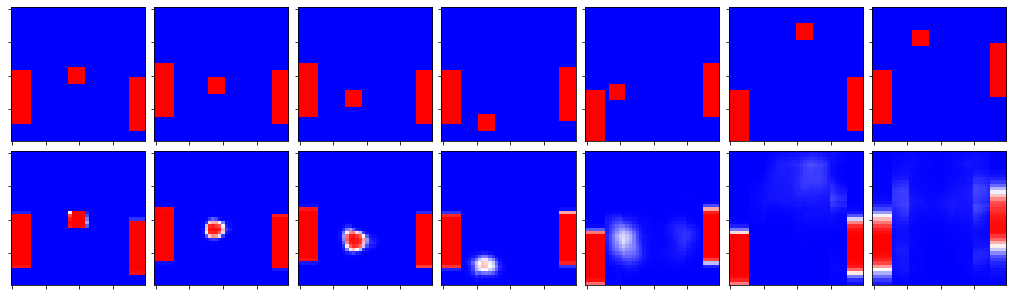

Epoch 218/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0621 - mean_squared_error: 0.0171 - acc: 0.9780 - val_loss: 0.0567 - val_mean_squared_error: 0.0162 - val_acc: 0.9781


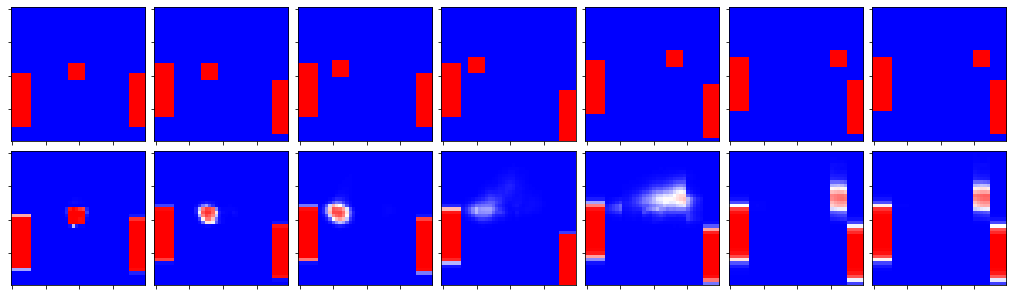

Epoch 219/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.0620 - mean_squared_error: 0.0171 - acc: 0.9779 - val_loss: 0.0588 - val_mean_squared_error: 0.0161 - val_acc: 0.9790


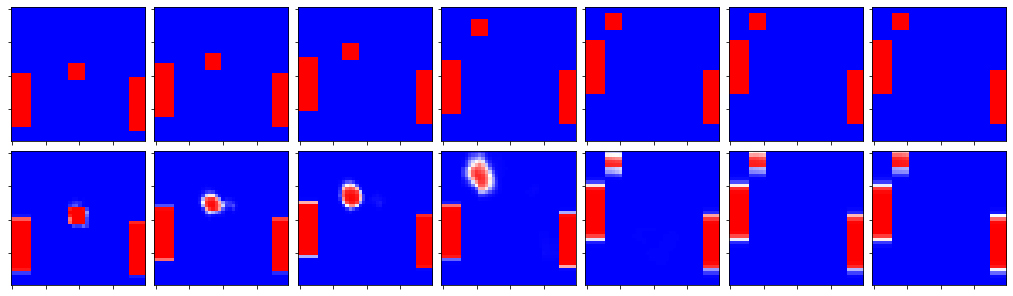

Epoch 220/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0640 - mean_squared_error: 0.0177 - acc: 0.9771 - val_loss: 0.0579 - val_mean_squared_error: 0.0162 - val_acc: 0.9796


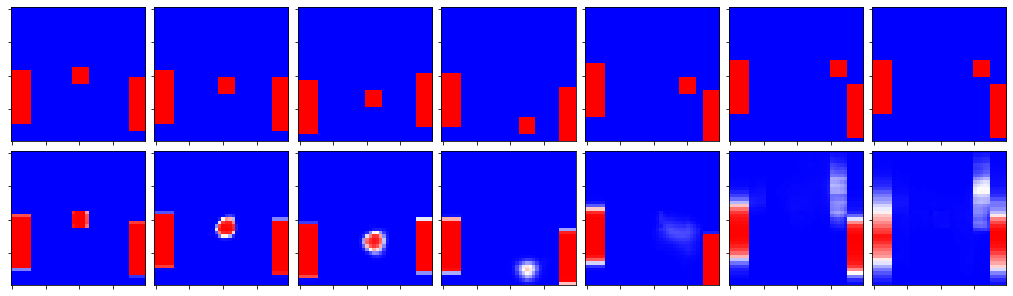

Epoch 221/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0631 - mean_squared_error: 0.0174 - acc: 0.9776 - val_loss: 0.0649 - val_mean_squared_error: 0.0179 - val_acc: 0.9769


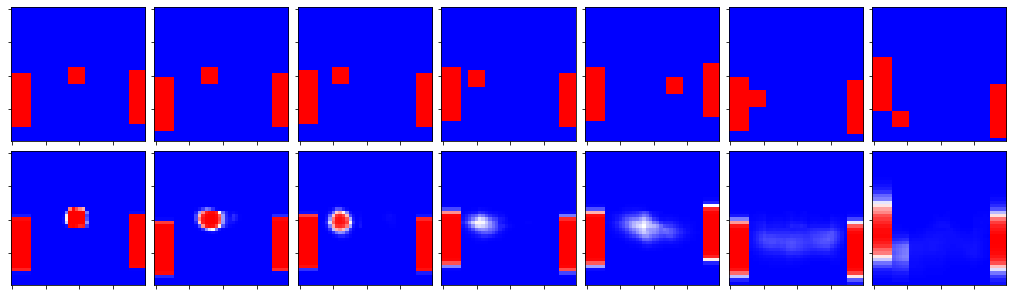

Epoch 222/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0626 - mean_squared_error: 0.0172 - acc: 0.9780 - val_loss: 0.0551 - val_mean_squared_error: 0.0152 - val_acc: 0.9805


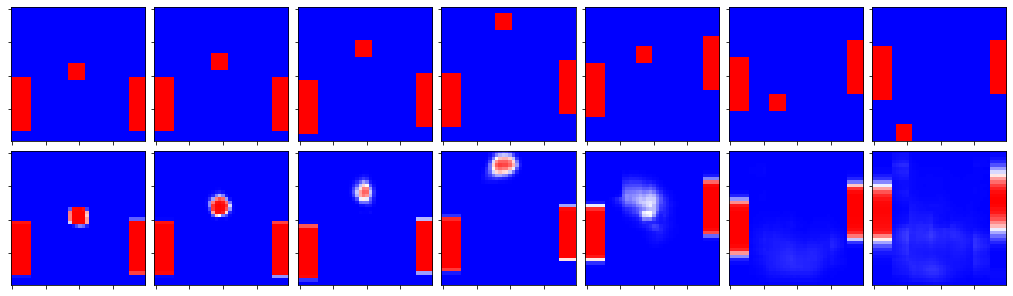

Epoch 223/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0601 - mean_squared_error: 0.0166 - acc: 0.9786 - val_loss: 0.0710 - val_mean_squared_error: 0.0190 - val_acc: 0.9756


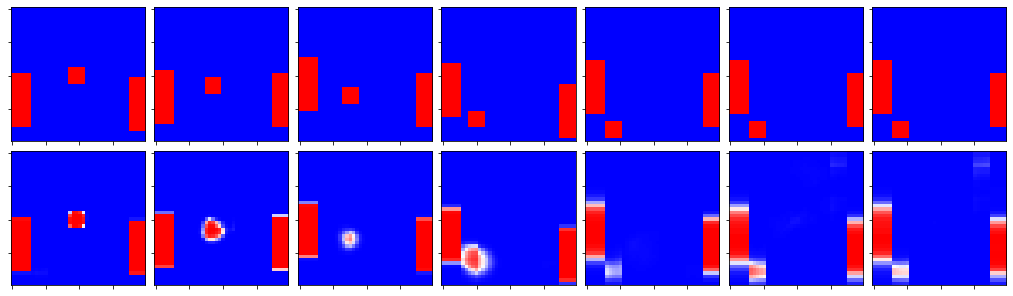

Epoch 224/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.0612 - mean_squared_error: 0.0167 - acc: 0.9785 - val_loss: 0.0559 - val_mean_squared_error: 0.0153 - val_acc: 0.9803


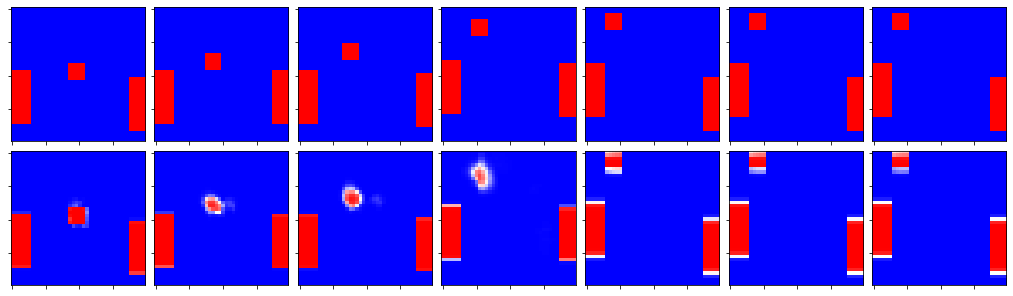

Epoch 225/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.0604 - mean_squared_error: 0.0166 - acc: 0.9786 - val_loss: 0.0643 - val_mean_squared_error: 0.0177 - val_acc: 0.9772


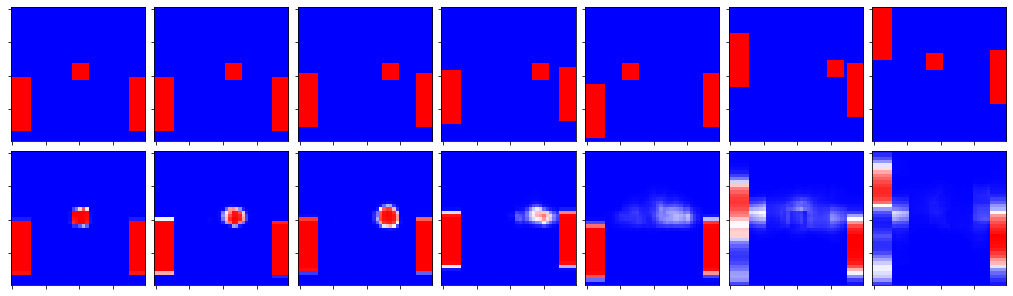

Epoch 226/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0642 - mean_squared_error: 0.0177 - acc: 0.9771 - val_loss: 0.0655 - val_mean_squared_error: 0.0179 - val_acc: 0.9767


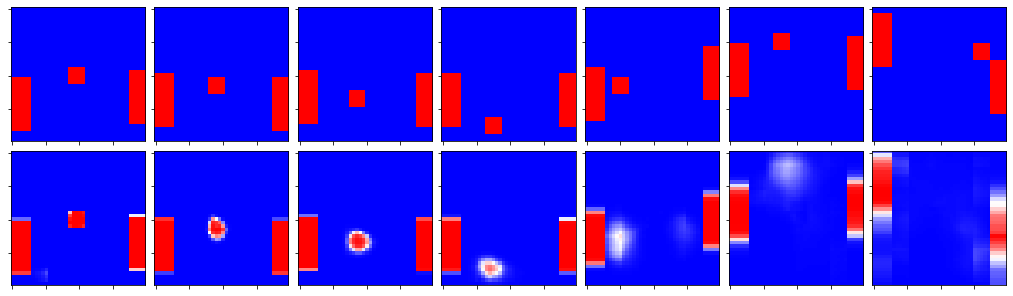

Epoch 227/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0610 - mean_squared_error: 0.0168 - acc: 0.9784 - val_loss: 0.0610 - val_mean_squared_error: 0.0167 - val_acc: 0.9786


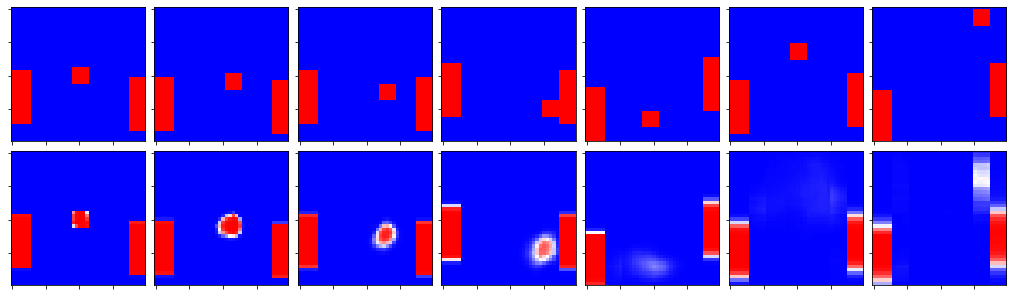

Epoch 228/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0608 - mean_squared_error: 0.0168 - acc: 0.9783 - val_loss: 0.0635 - val_mean_squared_error: 0.0171 - val_acc: 0.9775


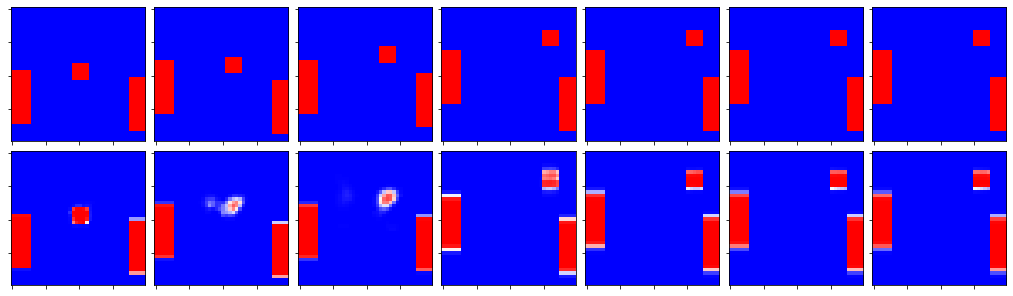

Epoch 229/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0643 - mean_squared_error: 0.0177 - acc: 0.9772 - val_loss: 0.0570 - val_mean_squared_error: 0.0159 - val_acc: 0.9791


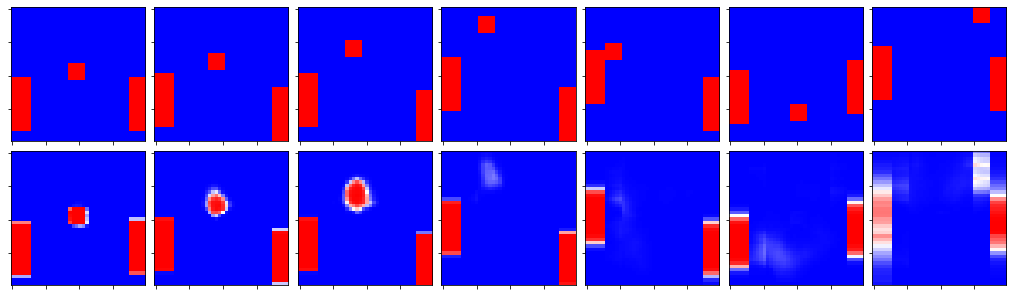

Epoch 230/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0589 - mean_squared_error: 0.0162 - acc: 0.9792 - val_loss: 0.0643 - val_mean_squared_error: 0.0172 - val_acc: 0.9778


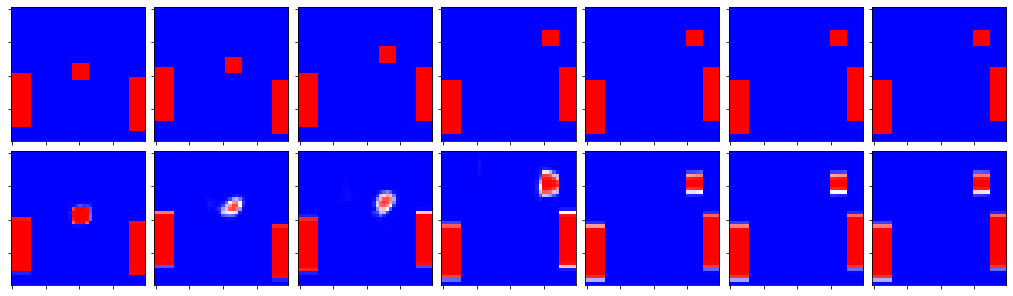

Epoch 231/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0609 - mean_squared_error: 0.0167 - acc: 0.9785 - val_loss: 0.0654 - val_mean_squared_error: 0.0186 - val_acc: 0.9750


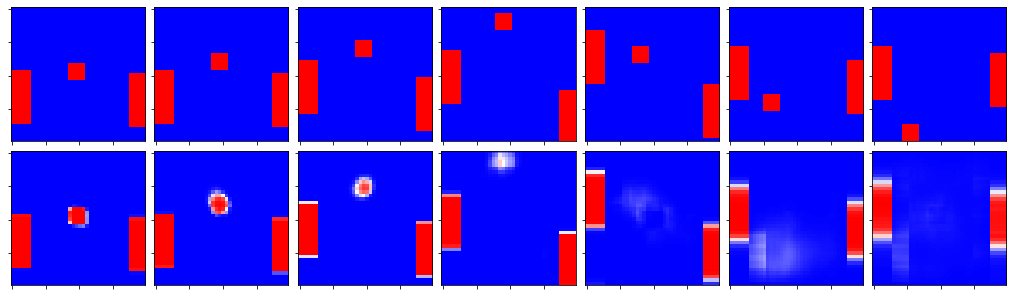

Epoch 232/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.0636 - mean_squared_error: 0.0174 - acc: 0.9776 - val_loss: 0.0662 - val_mean_squared_error: 0.0177 - val_acc: 0.9773


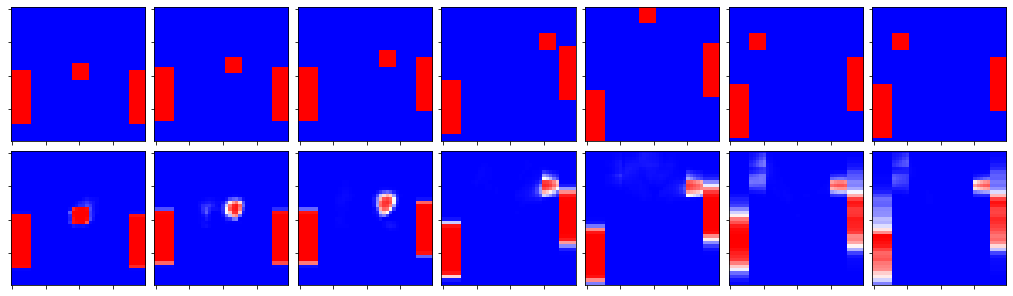

Epoch 233/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0636 - mean_squared_error: 0.0175 - acc: 0.9774 - val_loss: 0.0673 - val_mean_squared_error: 0.0183 - val_acc: 0.9768


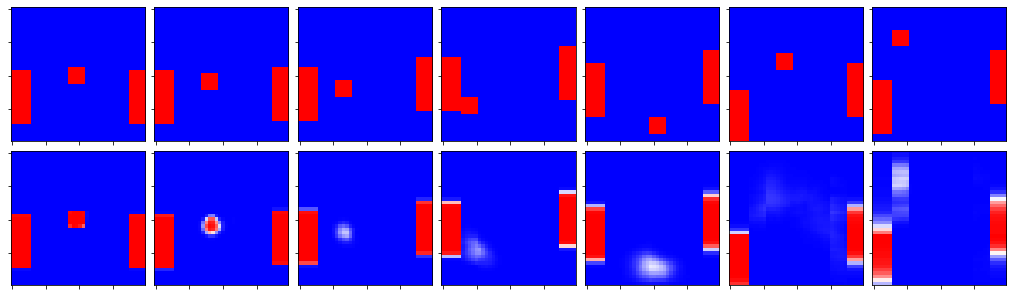

Epoch 234/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0603 - mean_squared_error: 0.0166 - acc: 0.9787 - val_loss: 0.0683 - val_mean_squared_error: 0.0192 - val_acc: 0.9748


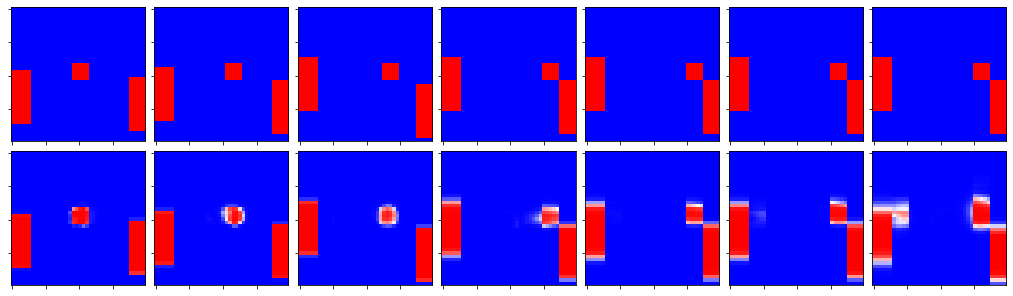

Epoch 235/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0759 - mean_squared_error: 0.0207 - acc: 0.9733 - val_loss: 0.0598 - val_mean_squared_error: 0.0164 - val_acc: 0.9788


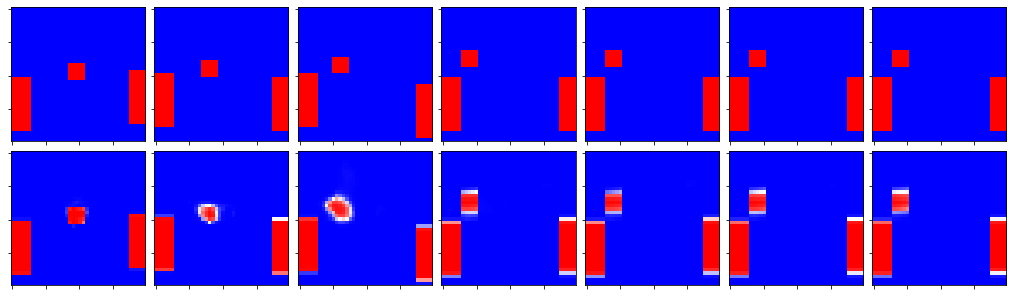

Epoch 236/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.0626 - mean_squared_error: 0.0172 - acc: 0.9780 - val_loss: 0.0512 - val_mean_squared_error: 0.0142 - val_acc: 0.9819


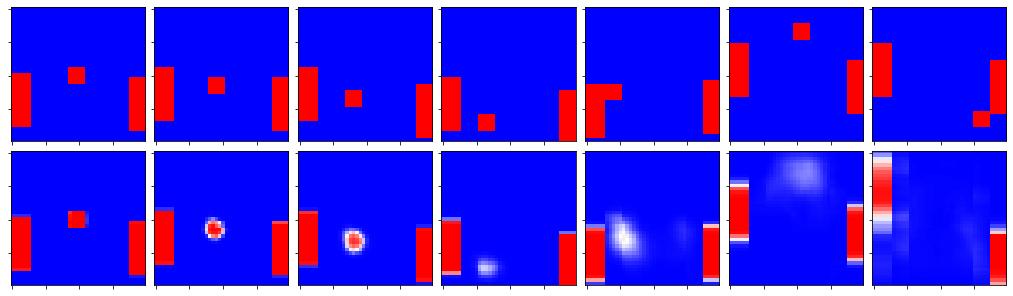

Epoch 237/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.0612 - mean_squared_error: 0.0169 - acc: 0.9782 - val_loss: 0.0660 - val_mean_squared_error: 0.0182 - val_acc: 0.9766


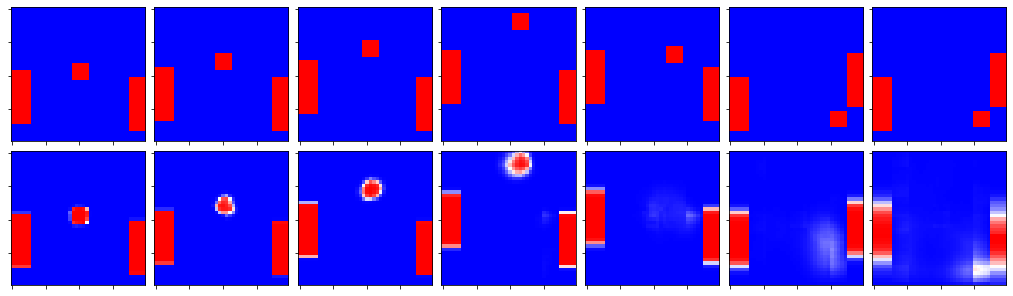

Epoch 238/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0612 - mean_squared_error: 0.0168 - acc: 0.9783 - val_loss: 0.0590 - val_mean_squared_error: 0.0163 - val_acc: 0.9794


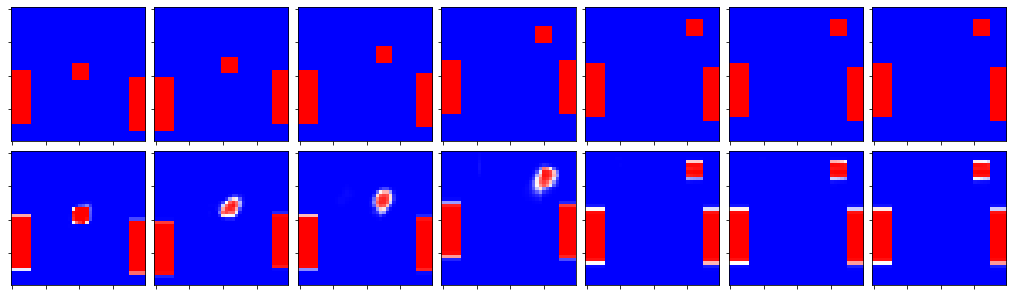

Epoch 239/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0606 - mean_squared_error: 0.0168 - acc: 0.9784 - val_loss: 0.0587 - val_mean_squared_error: 0.0163 - val_acc: 0.9795


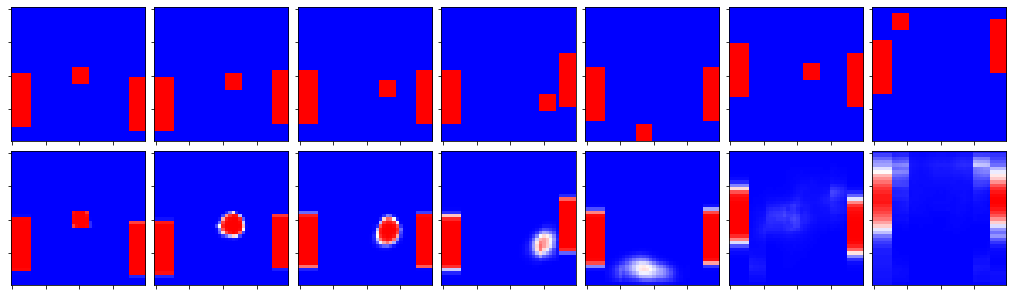

Epoch 240/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.0603 - mean_squared_error: 0.0166 - acc: 0.9787 - val_loss: 0.0689 - val_mean_squared_error: 0.0188 - val_acc: 0.9763


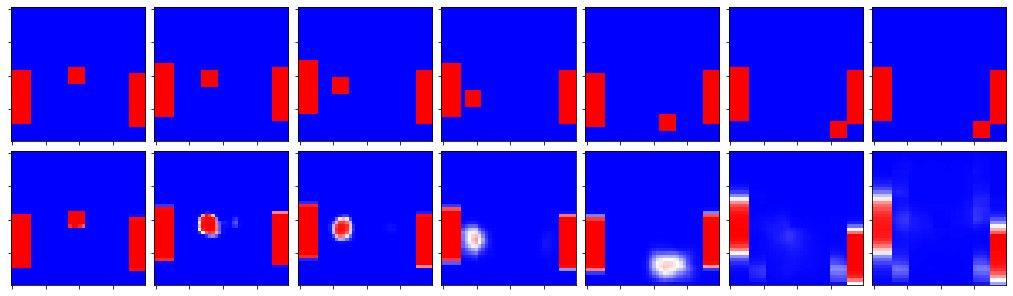

Epoch 241/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0621 - mean_squared_error: 0.0172 - acc: 0.9779 - val_loss: 0.0560 - val_mean_squared_error: 0.0158 - val_acc: 0.9793


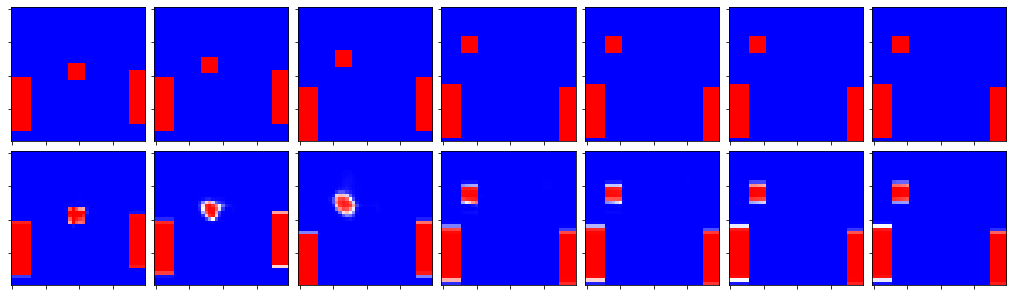

Epoch 242/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.0611 - mean_squared_error: 0.0168 - acc: 0.9784 - val_loss: 0.0605 - val_mean_squared_error: 0.0167 - val_acc: 0.9783


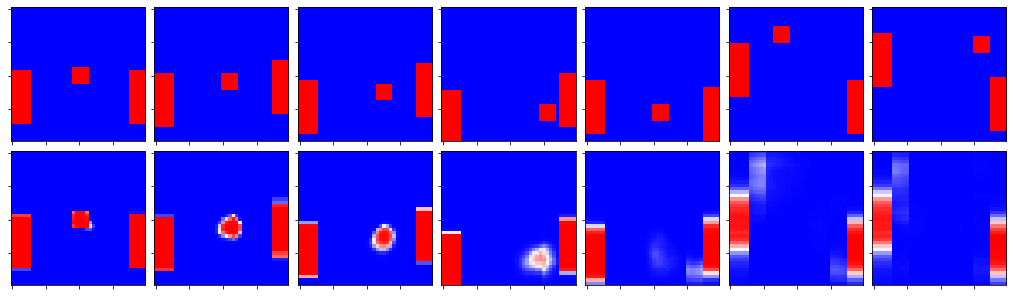

Epoch 243/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0657 - mean_squared_error: 0.0182 - acc: 0.9765 - val_loss: 0.0604 - val_mean_squared_error: 0.0167 - val_acc: 0.9782


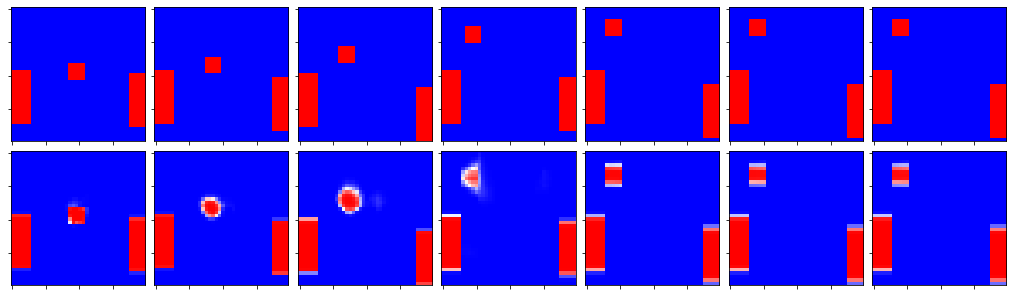

Epoch 244/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0620 - mean_squared_error: 0.0171 - acc: 0.9779 - val_loss: 0.0608 - val_mean_squared_error: 0.0166 - val_acc: 0.9787


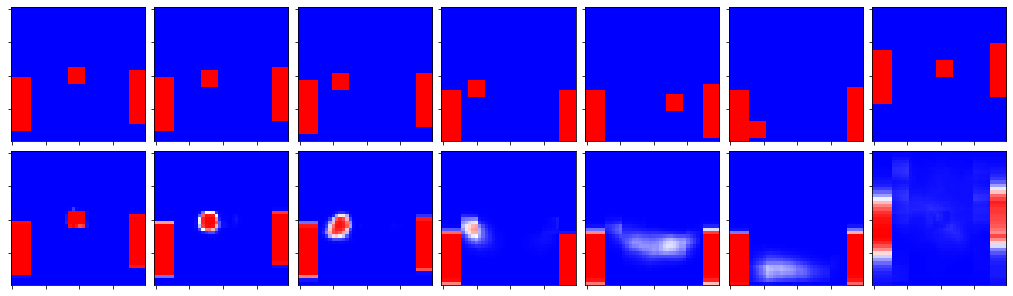

Epoch 245/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0631 - mean_squared_error: 0.0173 - acc: 0.9777 - val_loss: 0.0535 - val_mean_squared_error: 0.0147 - val_acc: 0.9814


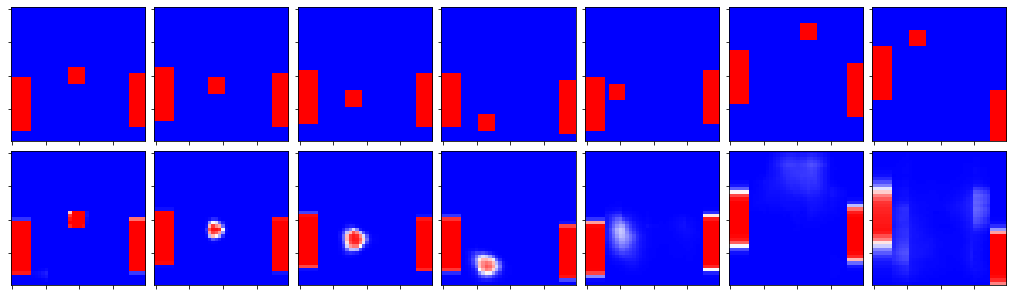

Epoch 246/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.0612 - mean_squared_error: 0.0169 - acc: 0.9781 - val_loss: 0.0537 - val_mean_squared_error: 0.0145 - val_acc: 0.9815


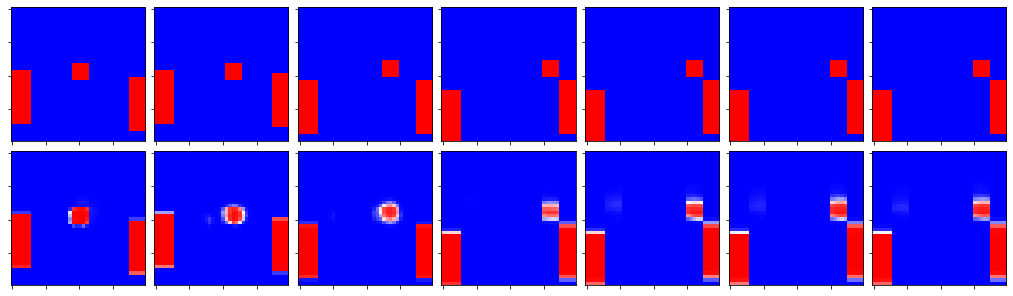

Epoch 247/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0596 - mean_squared_error: 0.0165 - acc: 0.9786 - val_loss: 0.0566 - val_mean_squared_error: 0.0156 - val_acc: 0.9801


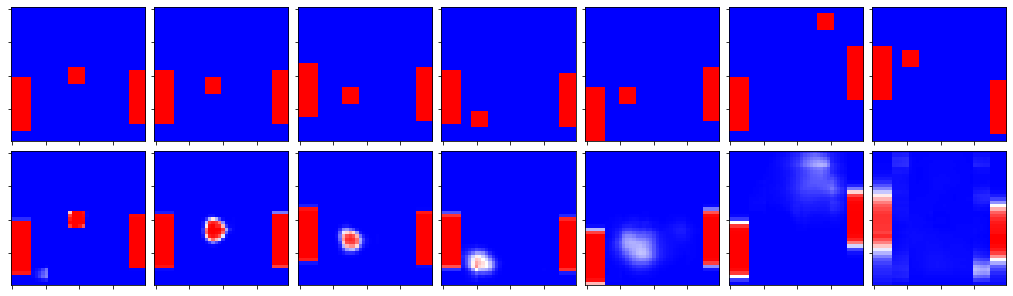

Epoch 248/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0641 - mean_squared_error: 0.0177 - acc: 0.9772 - val_loss: 0.0541 - val_mean_squared_error: 0.0149 - val_acc: 0.9813


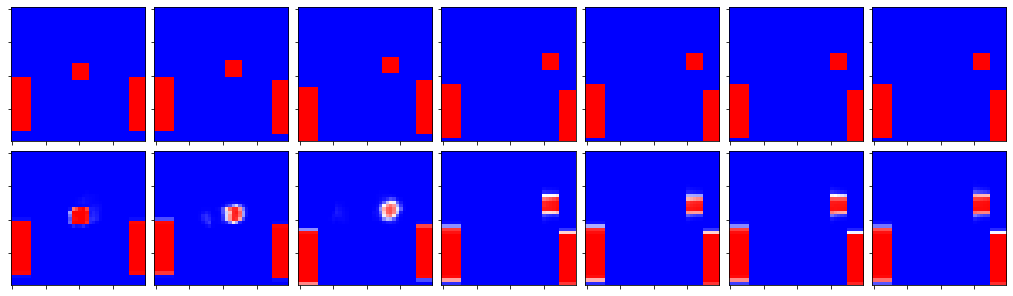

Epoch 249/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0608 - mean_squared_error: 0.0169 - acc: 0.9782 - val_loss: 0.0706 - val_mean_squared_error: 0.0194 - val_acc: 0.9750


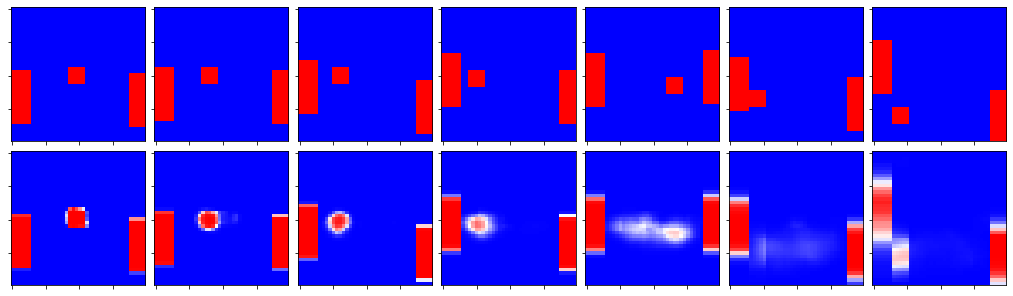

Epoch 250/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0580 - mean_squared_error: 0.0161 - acc: 0.9793 - val_loss: 0.0544 - val_mean_squared_error: 0.0154 - val_acc: 0.9794


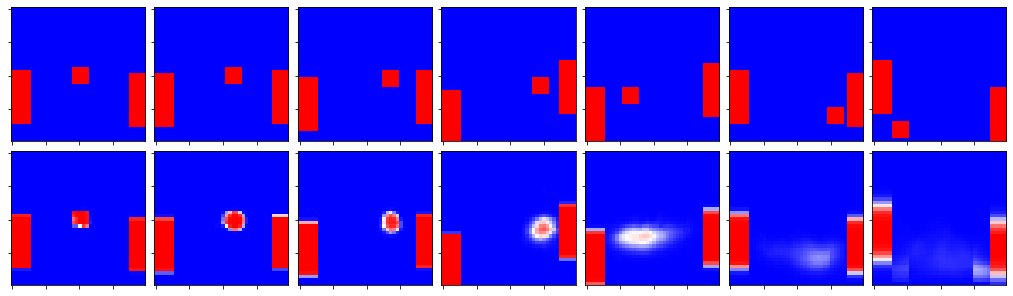

Epoch 251/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0627 - mean_squared_error: 0.0173 - acc: 0.9777 - val_loss: 0.0575 - val_mean_squared_error: 0.0161 - val_acc: 0.9792


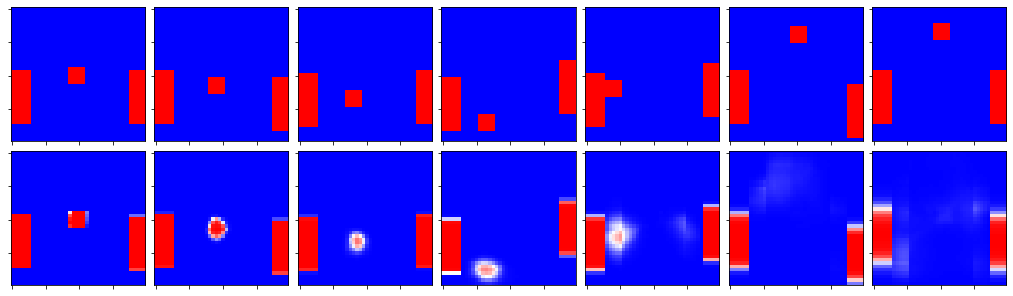

Epoch 252/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0611 - mean_squared_error: 0.0170 - acc: 0.9780 - val_loss: 0.0575 - val_mean_squared_error: 0.0163 - val_acc: 0.9786


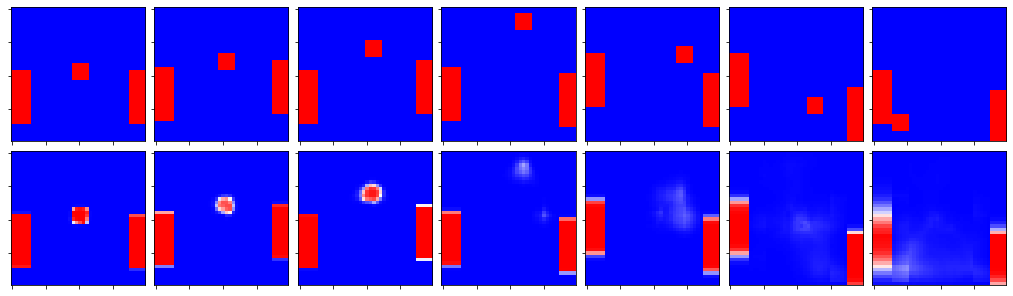

Epoch 253/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.0592 - mean_squared_error: 0.0164 - acc: 0.9789 - val_loss: 0.0571 - val_mean_squared_error: 0.0150 - val_acc: 0.9812


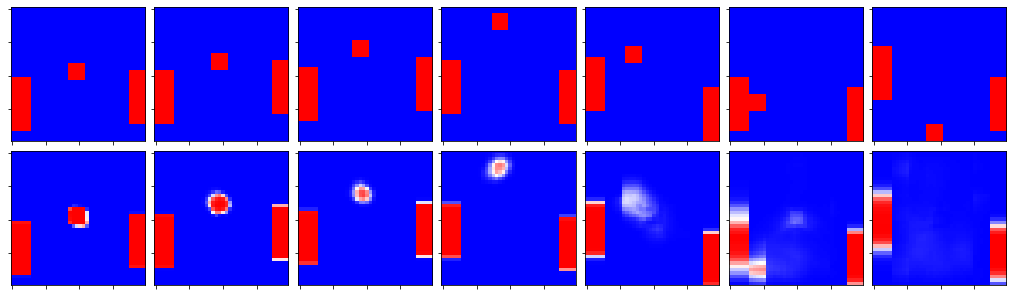

Epoch 254/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0599 - mean_squared_error: 0.0165 - acc: 0.9788 - val_loss: 0.0619 - val_mean_squared_error: 0.0173 - val_acc: 0.9772


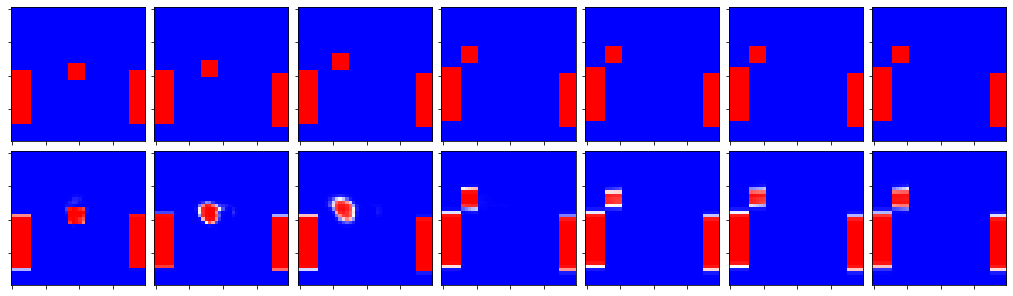

Epoch 255/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0598 - mean_squared_error: 0.0165 - acc: 0.9788 - val_loss: 0.0612 - val_mean_squared_error: 0.0171 - val_acc: 0.9777


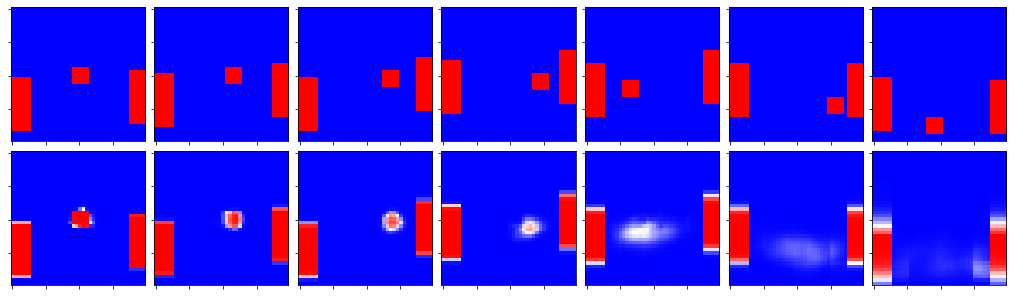

Epoch 256/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0603 - mean_squared_error: 0.0167 - acc: 0.9785 - val_loss: 0.0667 - val_mean_squared_error: 0.0181 - val_acc: 0.9769


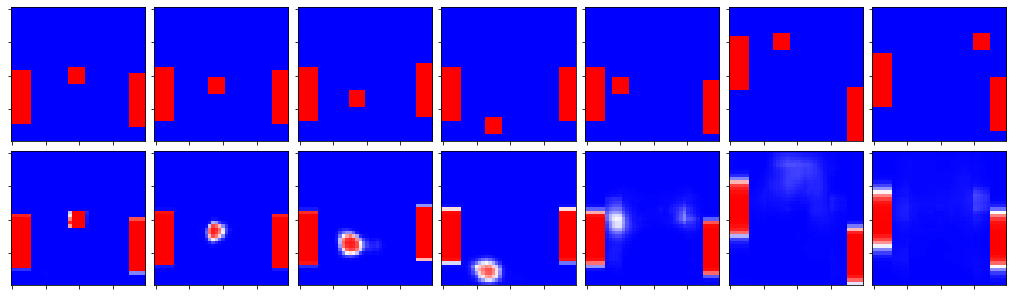

Epoch 257/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.1162 - mean_squared_error: 0.0215 - acc: 0.9737 - val_loss: 0.7908 - val_mean_squared_error: 0.0723 - val_acc: 0.9236


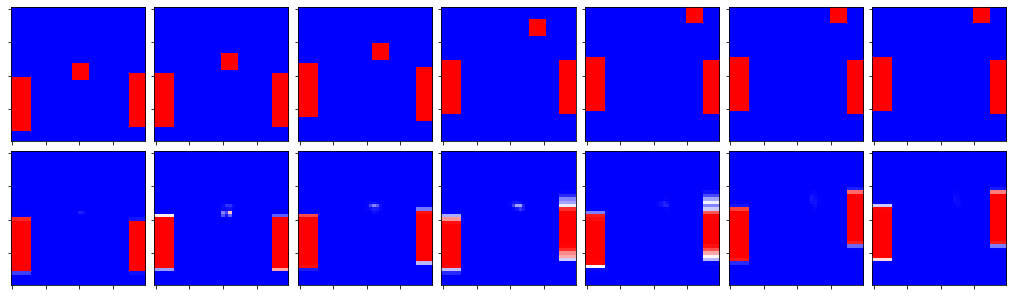

Epoch 258/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.5518 - mean_squared_error: 0.0652 - acc: 0.9264 - val_loss: 0.4198 - val_mean_squared_error: 0.0602 - val_acc: 0.9287


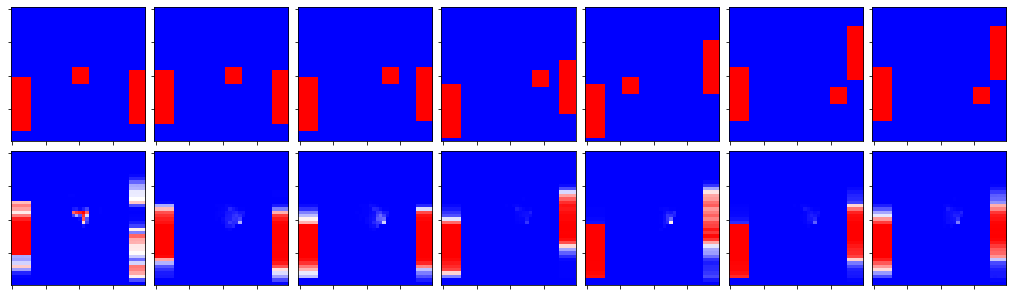

Epoch 259/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.3951 - mean_squared_error: 0.0590 - acc: 0.9291 - val_loss: 0.3706 - val_mean_squared_error: 0.0583 - val_acc: 0.9288


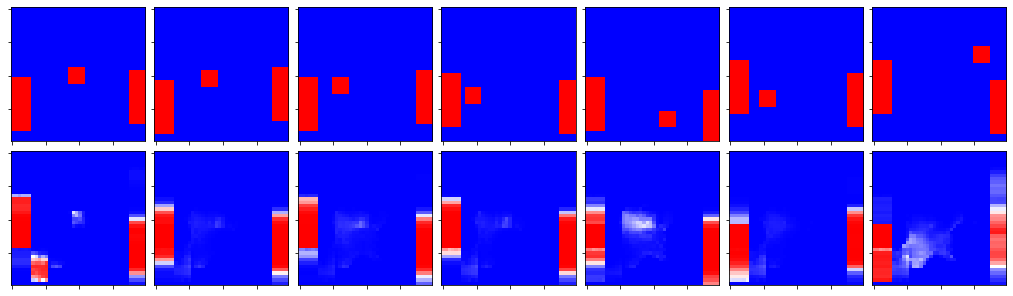

Epoch 260/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.3461 - mean_squared_error: 0.0574 - acc: 0.9293 - val_loss: 0.3281 - val_mean_squared_error: 0.0565 - val_acc: 0.9304


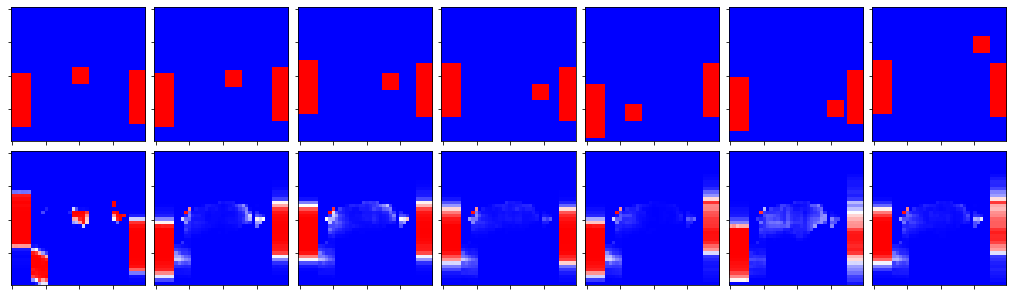

Epoch 261/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.3224 - mean_squared_error: 0.0566 - acc: 0.9294 - val_loss: 0.3428 - val_mean_squared_error: 0.0592 - val_acc: 0.9272


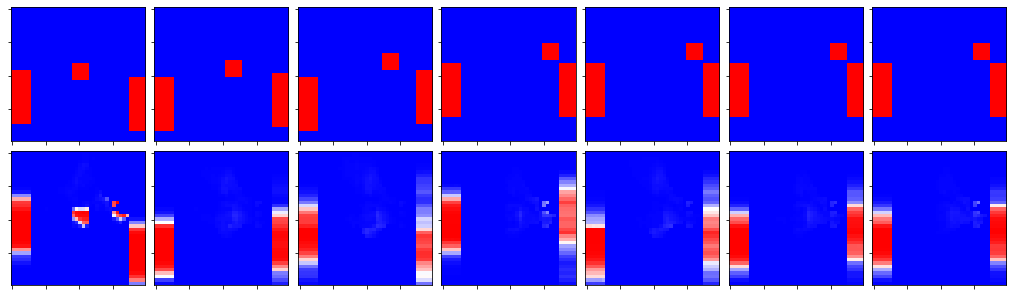

Epoch 262/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.2954 - mean_squared_error: 0.0544 - acc: 0.9317 - val_loss: 0.2752 - val_mean_squared_error: 0.0531 - val_acc: 0.9325


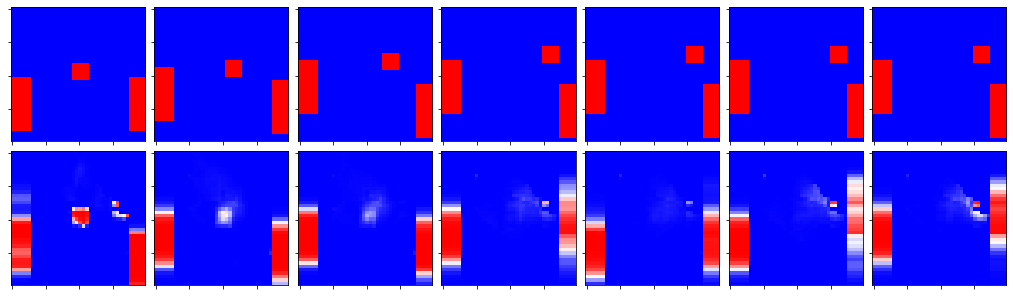

Epoch 263/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.2856 - mean_squared_error: 0.0541 - acc: 0.9316 - val_loss: 0.2856 - val_mean_squared_error: 0.0551 - val_acc: 0.9298


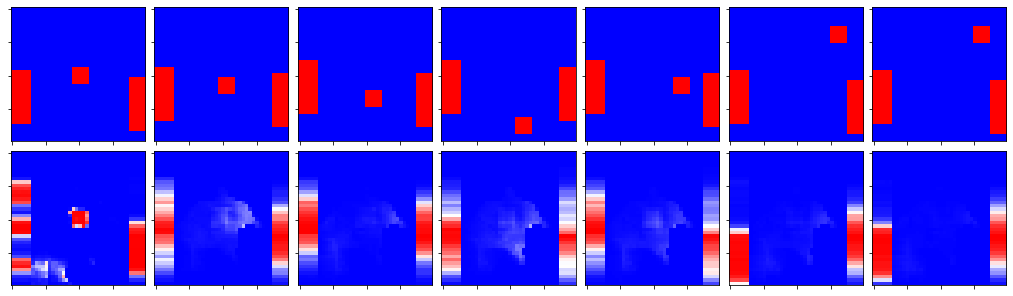

Epoch 264/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.2763 - mean_squared_error: 0.0532 - acc: 0.9323 - val_loss: 0.2765 - val_mean_squared_error: 0.0529 - val_acc: 0.9328


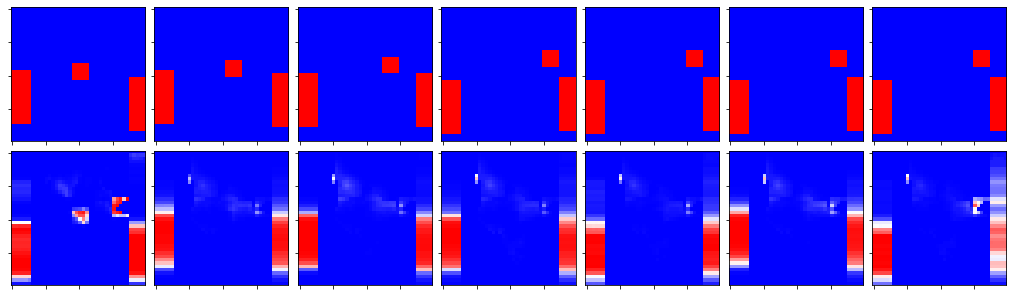

Epoch 265/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.2635 - mean_squared_error: 0.0517 - acc: 0.9340 - val_loss: 0.2685 - val_mean_squared_error: 0.0520 - val_acc: 0.9325


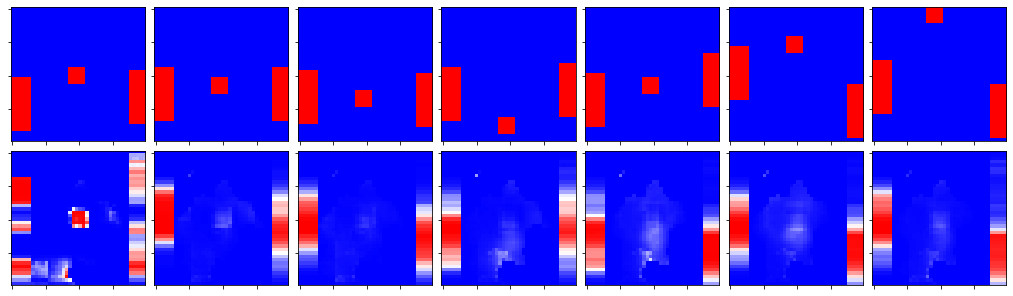

Epoch 266/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.2563 - mean_squared_error: 0.0511 - acc: 0.9343 - val_loss: 0.2605 - val_mean_squared_error: 0.0510 - val_acc: 0.9351


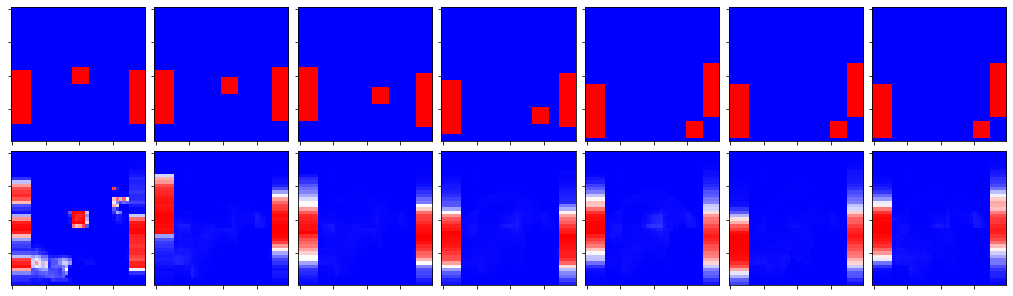

Epoch 267/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.2510 - mean_squared_error: 0.0506 - acc: 0.9349 - val_loss: 0.2622 - val_mean_squared_error: 0.0507 - val_acc: 0.9356


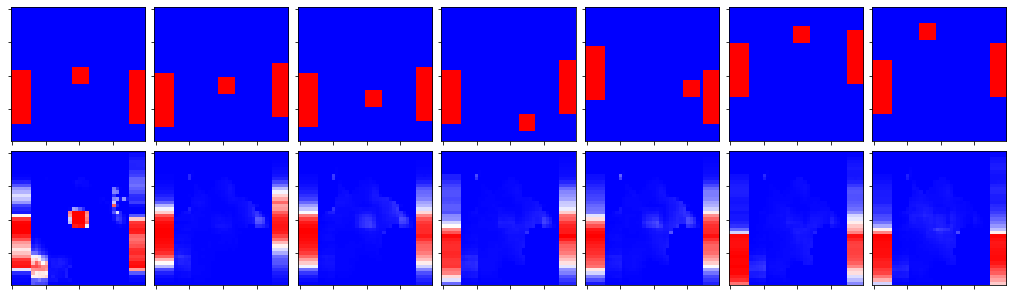

Epoch 268/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.2417 - mean_squared_error: 0.0496 - acc: 0.9360 - val_loss: 0.2422 - val_mean_squared_error: 0.0506 - val_acc: 0.9342


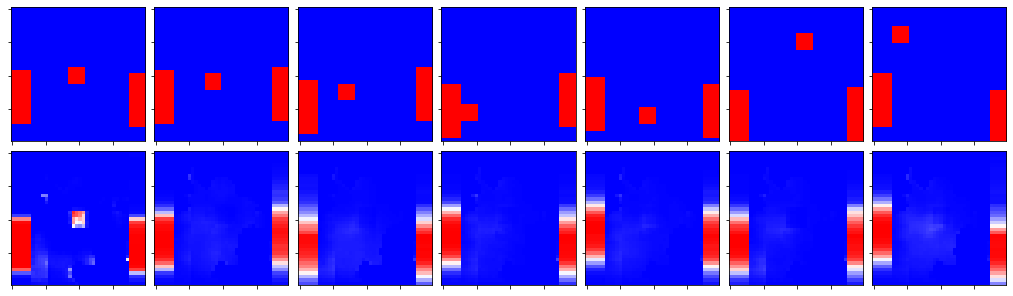

Epoch 269/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.2410 - mean_squared_error: 0.0500 - acc: 0.9352 - val_loss: 0.2428 - val_mean_squared_error: 0.0497 - val_acc: 0.9347


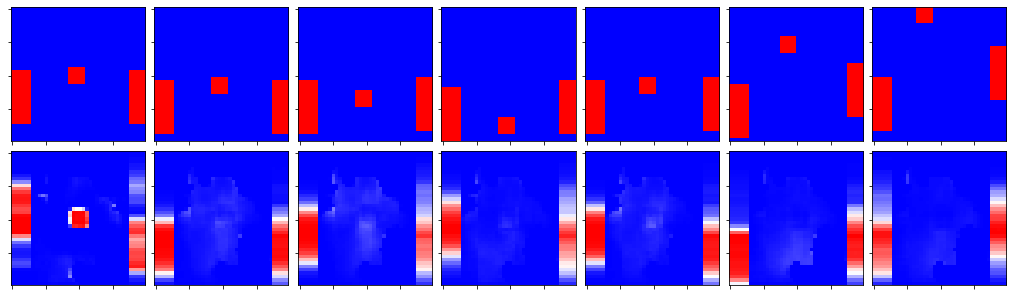

Epoch 270/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.2327 - mean_squared_error: 0.0496 - acc: 0.9353 - val_loss: 0.2265 - val_mean_squared_error: 0.0499 - val_acc: 0.9344


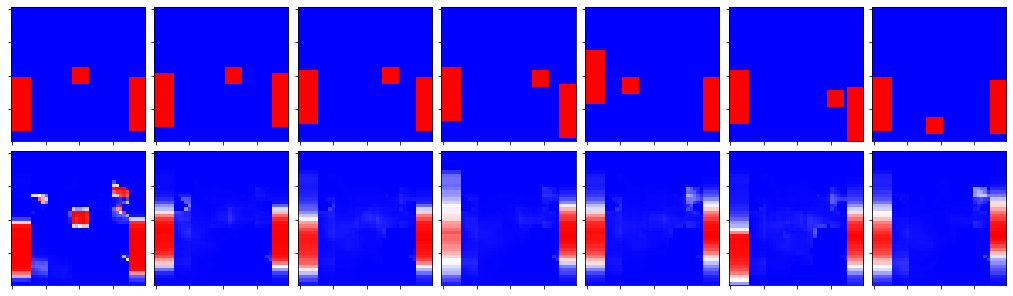

Epoch 271/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.2288 - mean_squared_error: 0.0493 - acc: 0.9356 - val_loss: 0.2256 - val_mean_squared_error: 0.0492 - val_acc: 0.9358


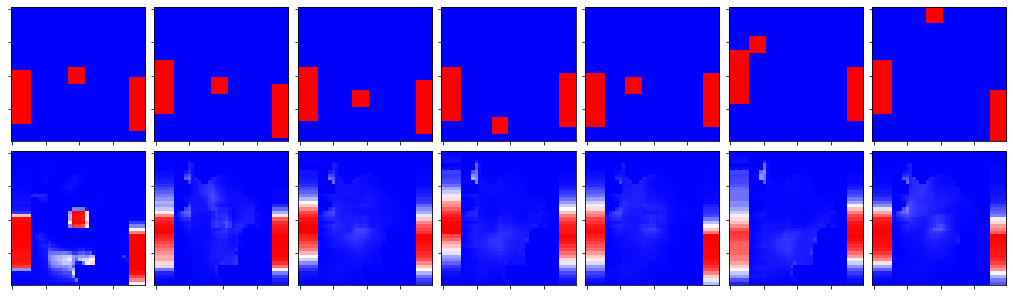

Epoch 272/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.2193 - mean_squared_error: 0.0483 - acc: 0.9368 - val_loss: 0.2143 - val_mean_squared_error: 0.0491 - val_acc: 0.9348


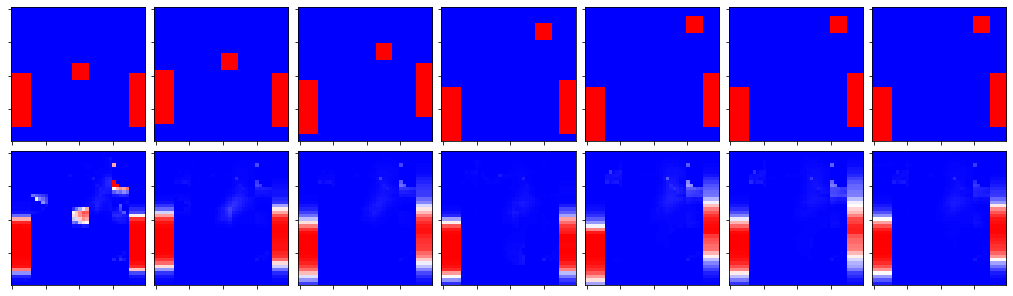

Epoch 273/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.2151 - mean_squared_error: 0.0483 - acc: 0.9368 - val_loss: 0.1980 - val_mean_squared_error: 0.0466 - val_acc: 0.9391


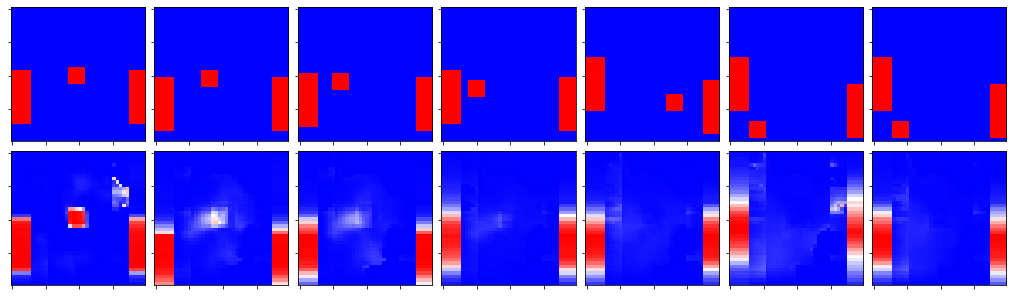

Epoch 274/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.2091 - mean_squared_error: 0.0477 - acc: 0.9374 - val_loss: 0.1961 - val_mean_squared_error: 0.0447 - val_acc: 0.9409


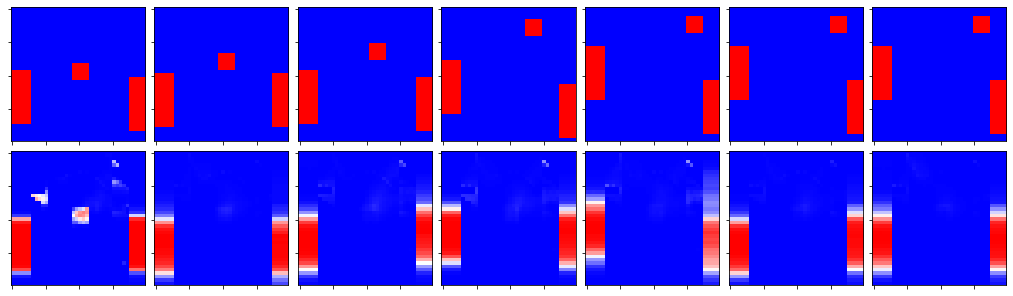

Epoch 275/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.2061 - mean_squared_error: 0.0474 - acc: 0.9377 - val_loss: 0.2013 - val_mean_squared_error: 0.0461 - val_acc: 0.9389


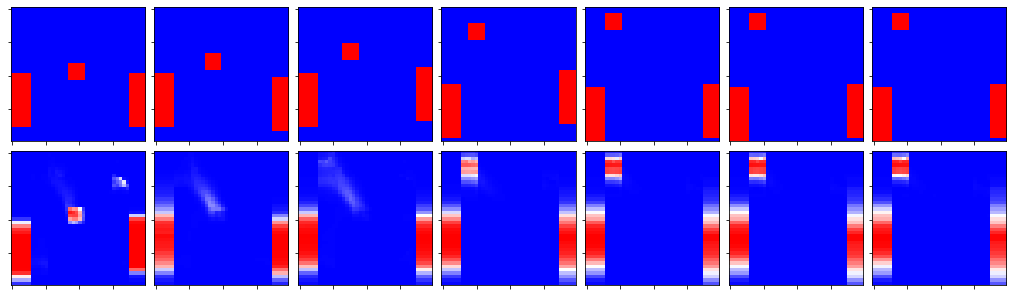

Epoch 276/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1990 - mean_squared_error: 0.0468 - acc: 0.9384 - val_loss: 0.1798 - val_mean_squared_error: 0.0418 - val_acc: 0.9451


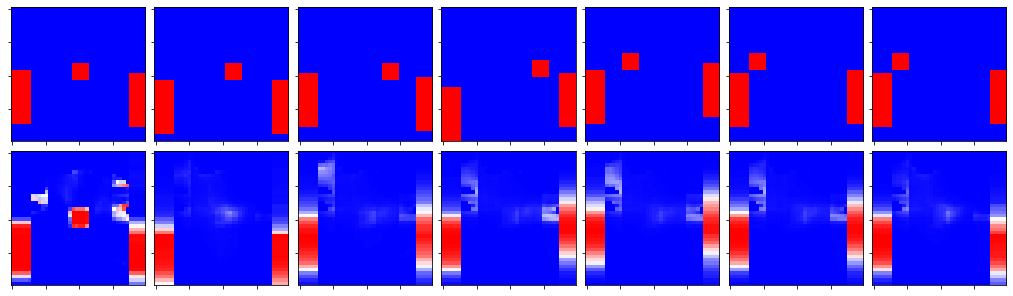

Epoch 277/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1947 - mean_squared_error: 0.0464 - acc: 0.9388 - val_loss: 0.2020 - val_mean_squared_error: 0.0485 - val_acc: 0.9362


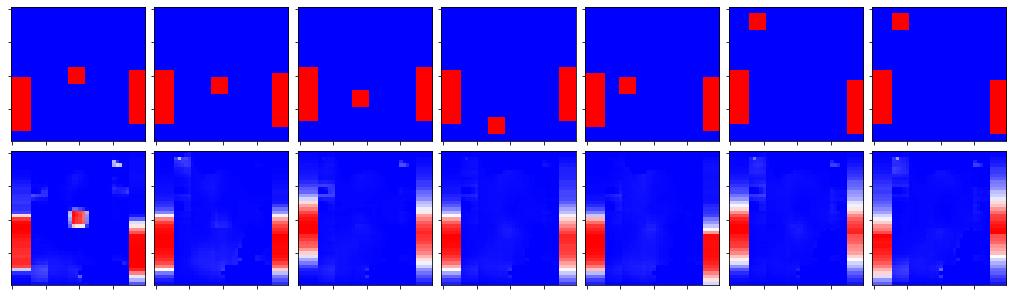

Epoch 278/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1884 - mean_squared_error: 0.0457 - acc: 0.9396 - val_loss: 0.1886 - val_mean_squared_error: 0.0463 - val_acc: 0.9385


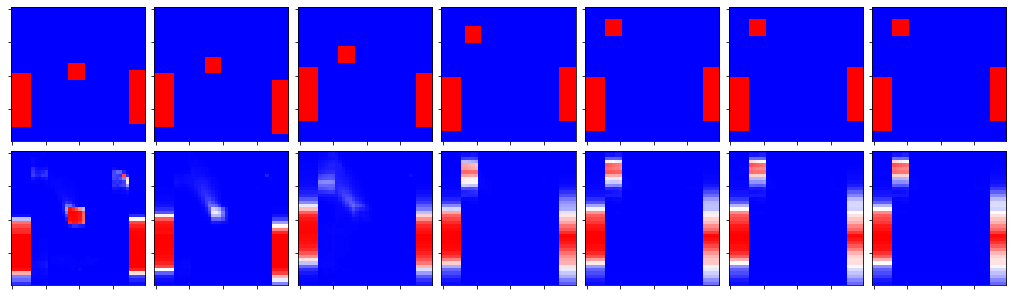

Epoch 279/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1841 - mean_squared_error: 0.0457 - acc: 0.9395 - val_loss: 0.1785 - val_mean_squared_error: 0.0425 - val_acc: 0.9446


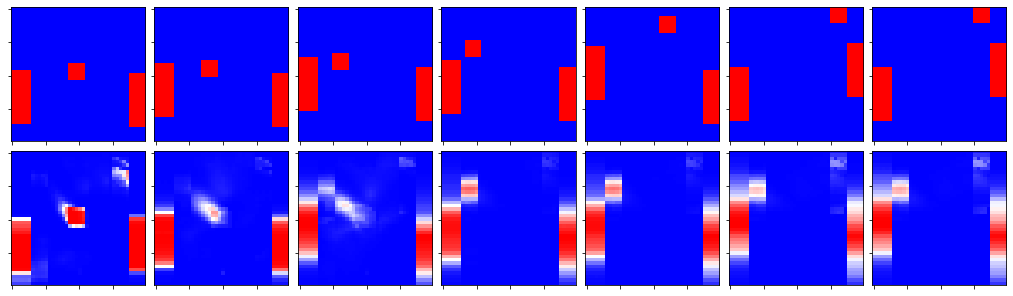

Epoch 280/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1804 - mean_squared_error: 0.0452 - acc: 0.9403 - val_loss: 0.1853 - val_mean_squared_error: 0.0456 - val_acc: 0.9404


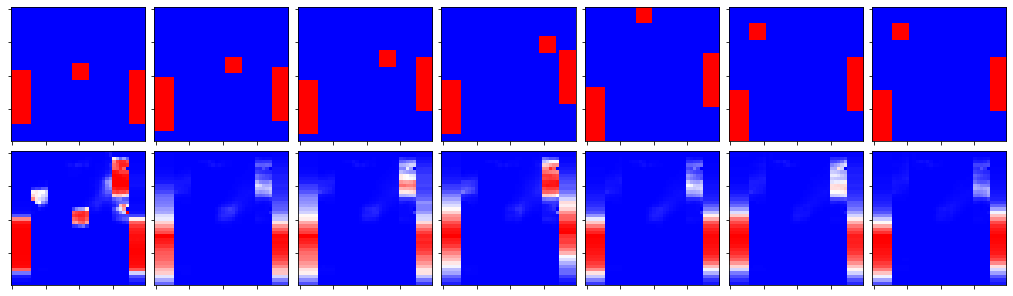

Epoch 281/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1763 - mean_squared_error: 0.0446 - acc: 0.9410 - val_loss: 0.1675 - val_mean_squared_error: 0.0444 - val_acc: 0.9410


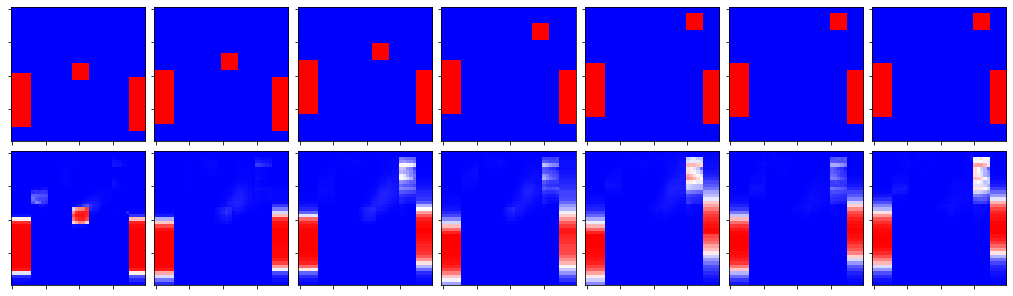

Epoch 282/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1753 - mean_squared_error: 0.0446 - acc: 0.9410 - val_loss: 0.1847 - val_mean_squared_error: 0.0474 - val_acc: 0.9363


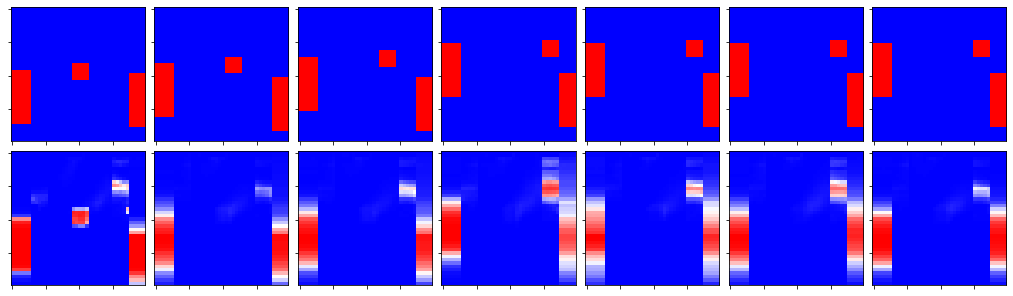

Epoch 283/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1741 - mean_squared_error: 0.0445 - acc: 0.9411 - val_loss: 0.1696 - val_mean_squared_error: 0.0416 - val_acc: 0.9449


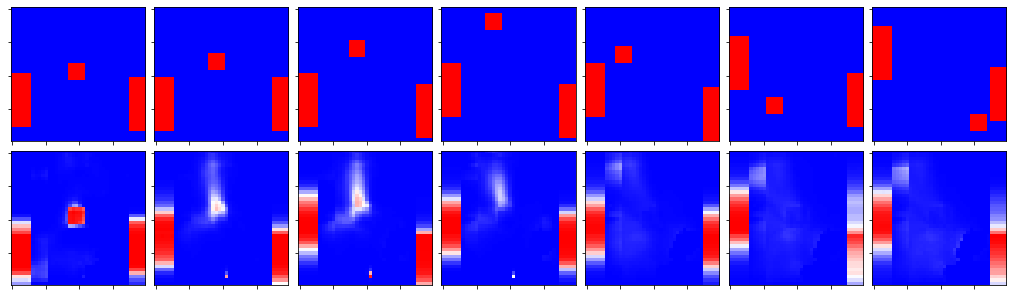

Epoch 284/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1707 - mean_squared_error: 0.0437 - acc: 0.9421 - val_loss: 0.1617 - val_mean_squared_error: 0.0407 - val_acc: 0.9461


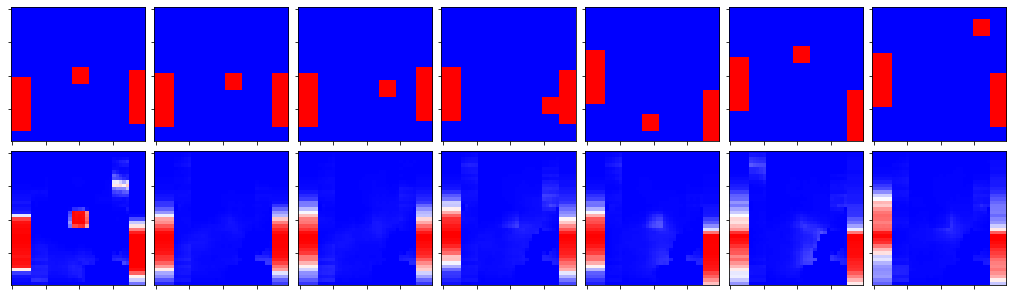

Epoch 285/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1691 - mean_squared_error: 0.0436 - acc: 0.9422 - val_loss: 0.1627 - val_mean_squared_error: 0.0423 - val_acc: 0.9434


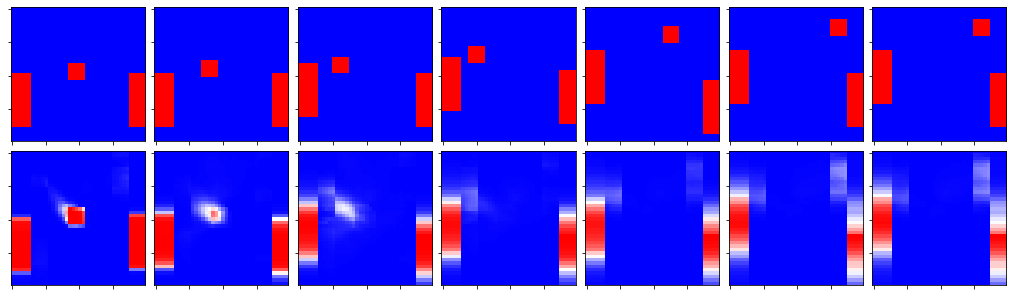

Epoch 286/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1670 - mean_squared_error: 0.0432 - acc: 0.9427 - val_loss: 0.1764 - val_mean_squared_error: 0.0466 - val_acc: 0.9375


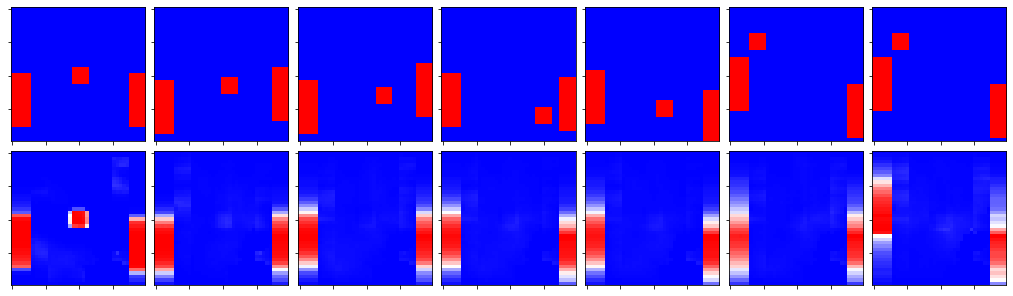

Epoch 287/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1665 - mean_squared_error: 0.0431 - acc: 0.9428 - val_loss: 0.1641 - val_mean_squared_error: 0.0420 - val_acc: 0.9441


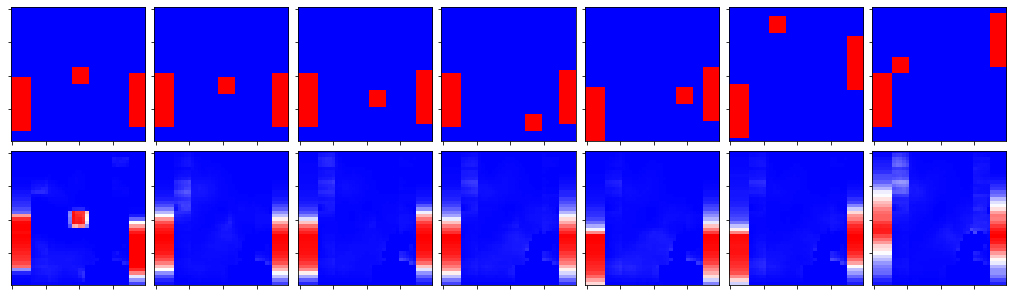

Epoch 288/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1677 - mean_squared_error: 0.0434 - acc: 0.9426 - val_loss: 0.1683 - val_mean_squared_error: 0.0440 - val_acc: 0.9418


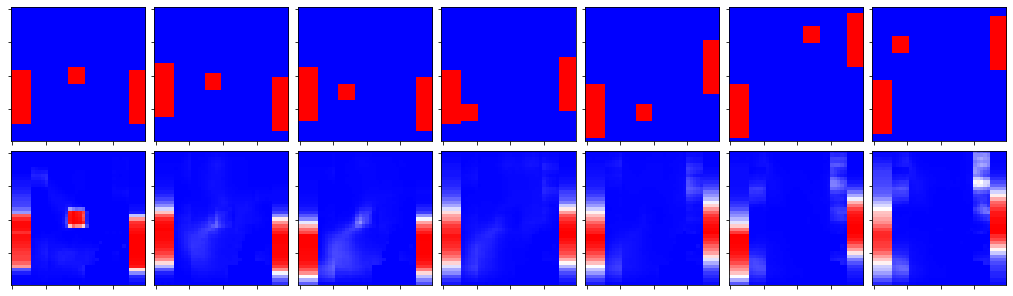

Epoch 289/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1649 - mean_squared_error: 0.0429 - acc: 0.9433 - val_loss: 0.1522 - val_mean_squared_error: 0.0403 - val_acc: 0.9470


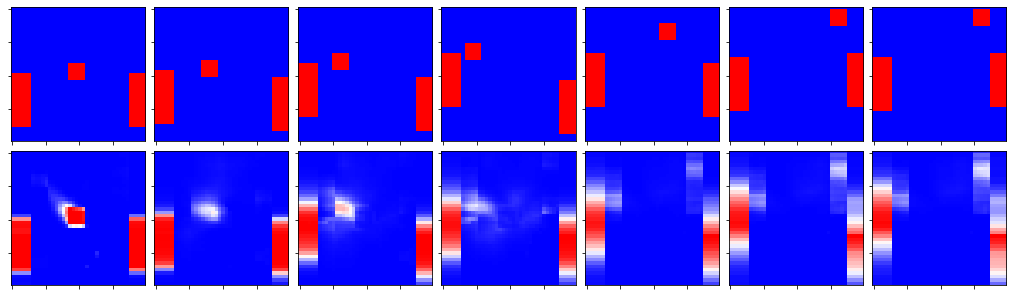

Epoch 290/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1625 - mean_squared_error: 0.0422 - acc: 0.9442 - val_loss: 0.1650 - val_mean_squared_error: 0.0416 - val_acc: 0.9455


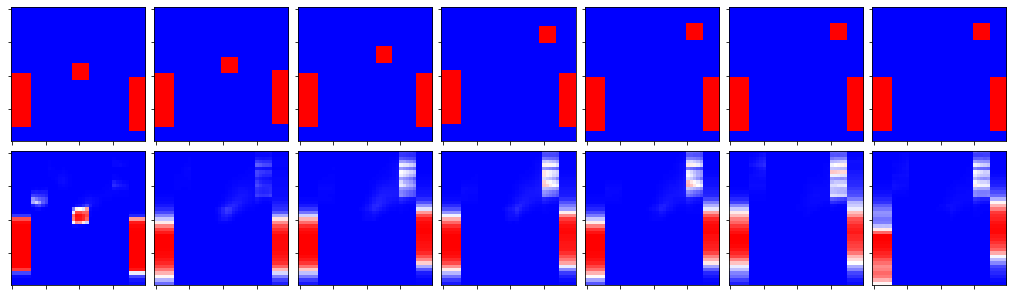

Epoch 291/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1626 - mean_squared_error: 0.0422 - acc: 0.9441 - val_loss: 0.1716 - val_mean_squared_error: 0.0458 - val_acc: 0.9392


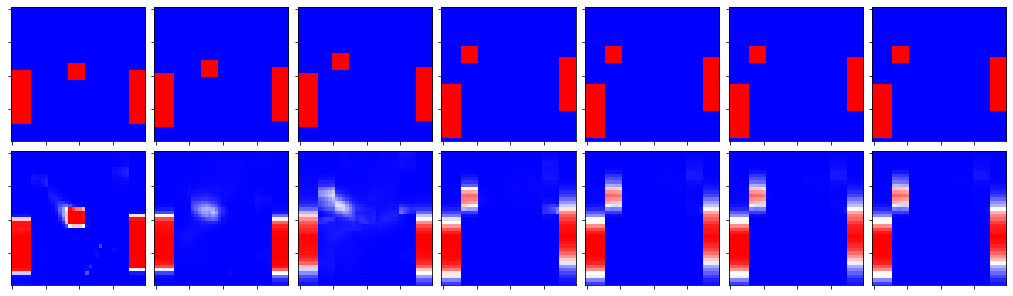

Epoch 292/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1599 - mean_squared_error: 0.0415 - acc: 0.9451 - val_loss: 0.1622 - val_mean_squared_error: 0.0417 - val_acc: 0.9446


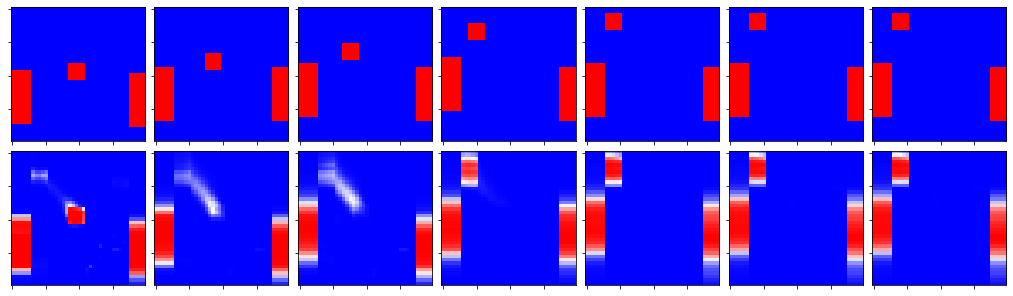

Epoch 293/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1581 - mean_squared_error: 0.0413 - acc: 0.9455 - val_loss: 0.1814 - val_mean_squared_error: 0.0450 - val_acc: 0.9406


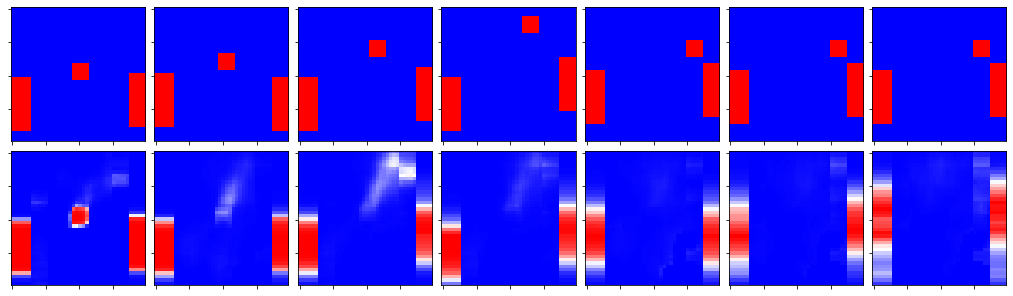

Epoch 294/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1574 - mean_squared_error: 0.0411 - acc: 0.9458 - val_loss: 0.1560 - val_mean_squared_error: 0.0410 - val_acc: 0.9456


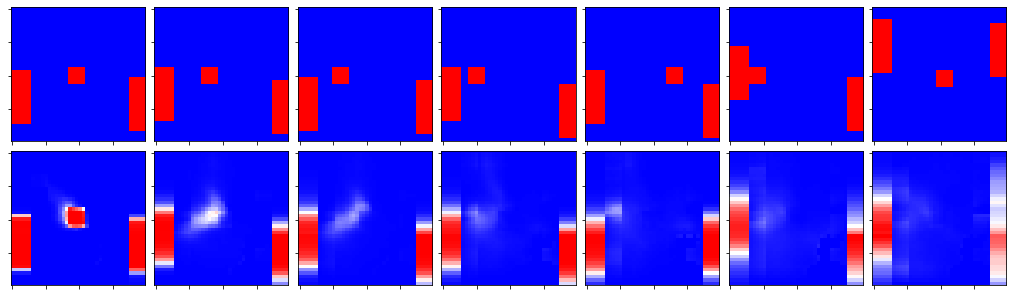

Epoch 295/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1577 - mean_squared_error: 0.0413 - acc: 0.9453 - val_loss: 0.1718 - val_mean_squared_error: 0.0445 - val_acc: 0.9413


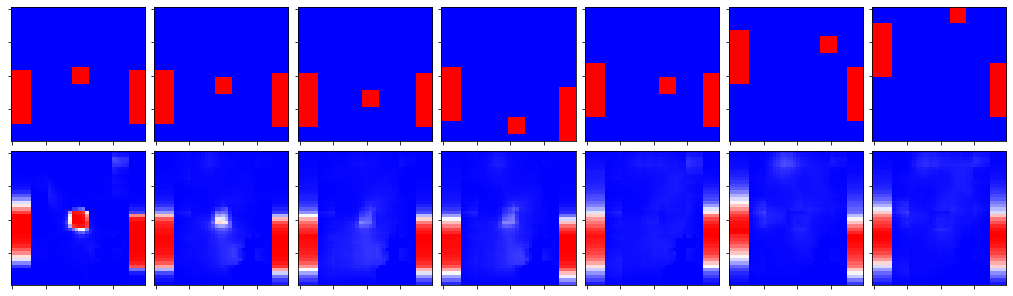

Epoch 296/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1545 - mean_squared_error: 0.0406 - acc: 0.9464 - val_loss: 0.1471 - val_mean_squared_error: 0.0390 - val_acc: 0.9481


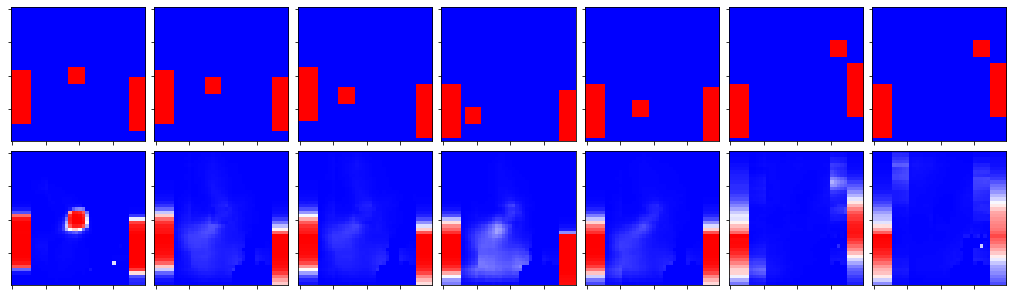

Epoch 297/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1559 - mean_squared_error: 0.0406 - acc: 0.9463 - val_loss: 0.1504 - val_mean_squared_error: 0.0397 - val_acc: 0.9483


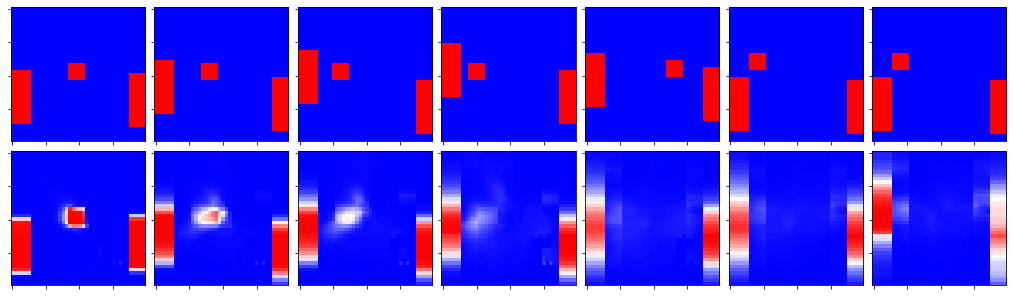

Epoch 298/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.1546 - mean_squared_error: 0.0403 - acc: 0.9470 - val_loss: 0.1505 - val_mean_squared_error: 0.0377 - val_acc: 0.9505


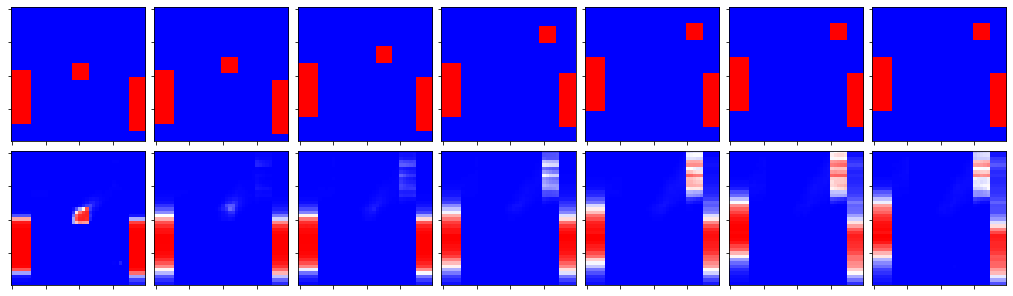

Epoch 299/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.1529 - mean_squared_error: 0.0402 - acc: 0.9469 - val_loss: 0.1573 - val_mean_squared_error: 0.0410 - val_acc: 0.9464


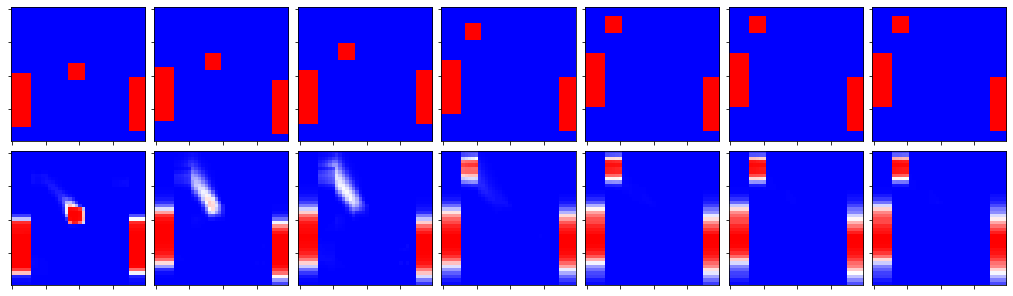

Epoch 300/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1518 - mean_squared_error: 0.0400 - acc: 0.9471 - val_loss: 0.1445 - val_mean_squared_error: 0.0392 - val_acc: 0.9480


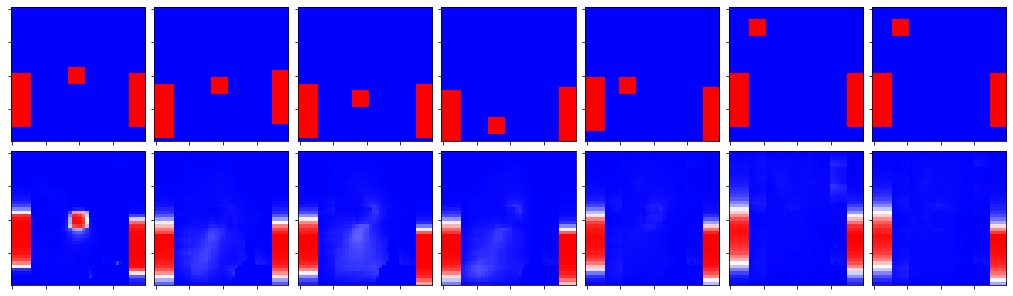

Epoch 301/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1526 - mean_squared_error: 0.0403 - acc: 0.9467 - val_loss: 0.1524 - val_mean_squared_error: 0.0406 - val_acc: 0.9460


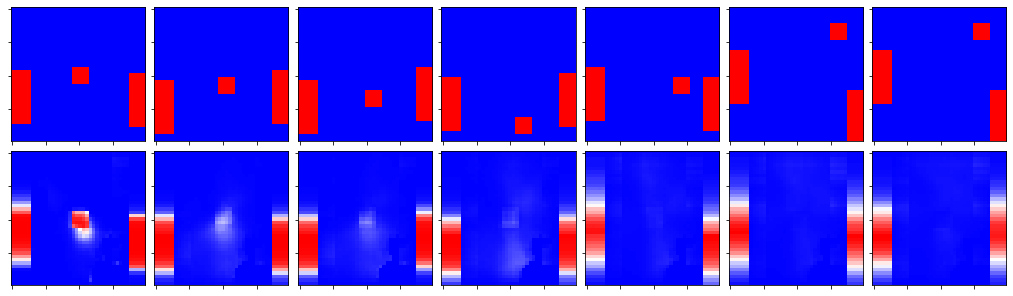

Epoch 302/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.1484 - mean_squared_error: 0.0391 - acc: 0.9484 - val_loss: 0.1521 - val_mean_squared_error: 0.0396 - val_acc: 0.9481


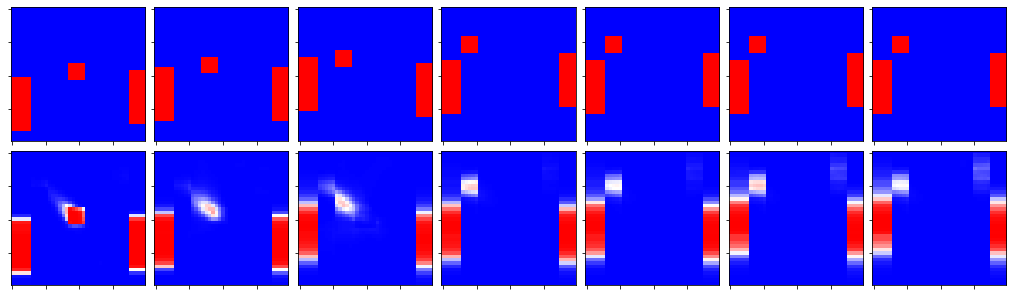

Epoch 303/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1502 - mean_squared_error: 0.0396 - acc: 0.9478 - val_loss: 0.1505 - val_mean_squared_error: 0.0383 - val_acc: 0.9495


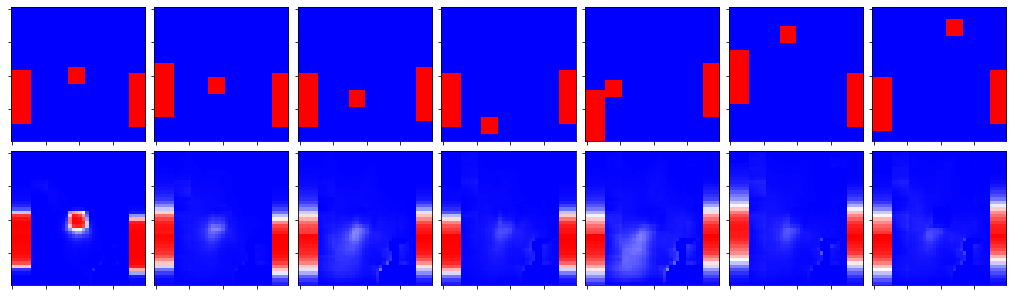

Epoch 304/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1477 - mean_squared_error: 0.0390 - acc: 0.9487 - val_loss: 0.1481 - val_mean_squared_error: 0.0386 - val_acc: 0.9489


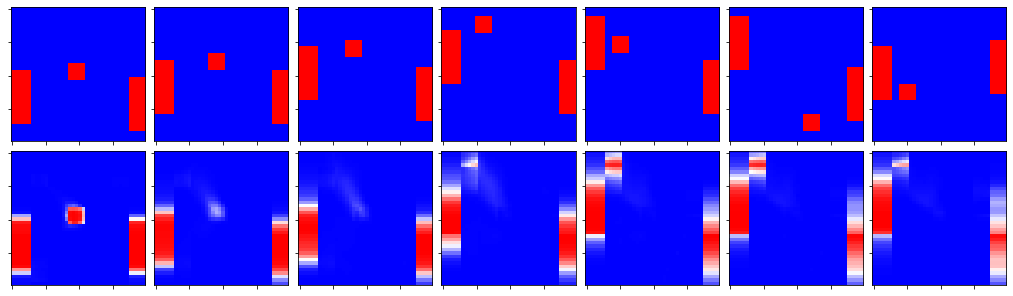

Epoch 305/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1466 - mean_squared_error: 0.0388 - acc: 0.9490 - val_loss: 0.1452 - val_mean_squared_error: 0.0387 - val_acc: 0.9492


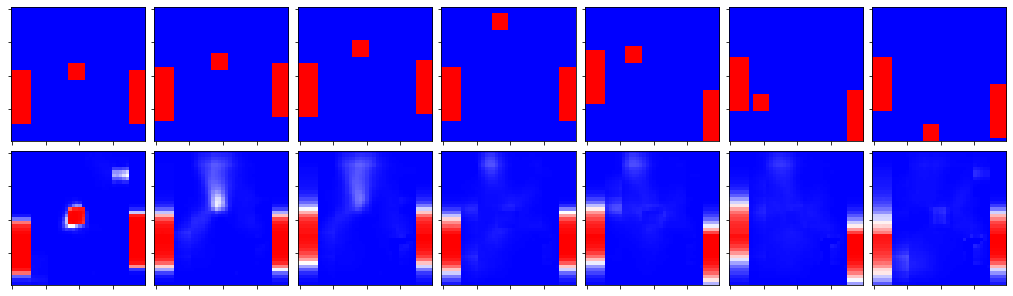

Epoch 306/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1468 - mean_squared_error: 0.0387 - acc: 0.9490 - val_loss: 0.1359 - val_mean_squared_error: 0.0361 - val_acc: 0.9525


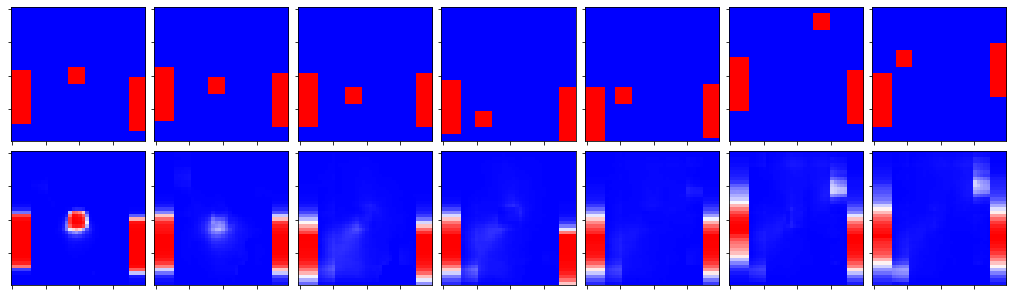

Epoch 307/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1471 - mean_squared_error: 0.0390 - acc: 0.9487 - val_loss: 0.1574 - val_mean_squared_error: 0.0414 - val_acc: 0.9461


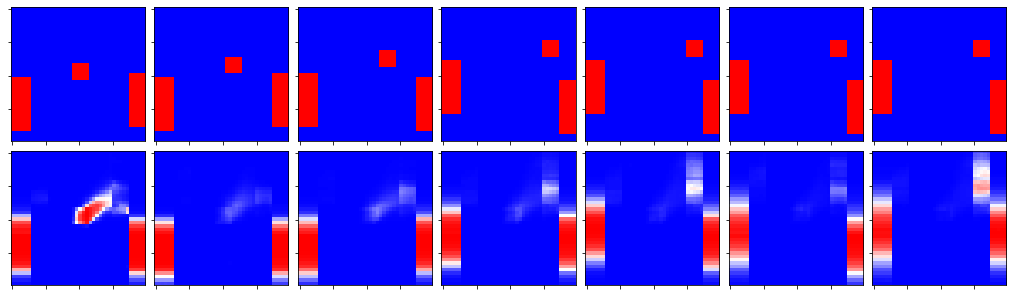

Epoch 308/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.1458 - mean_squared_error: 0.0384 - acc: 0.9494 - val_loss: 0.1467 - val_mean_squared_error: 0.0395 - val_acc: 0.9478


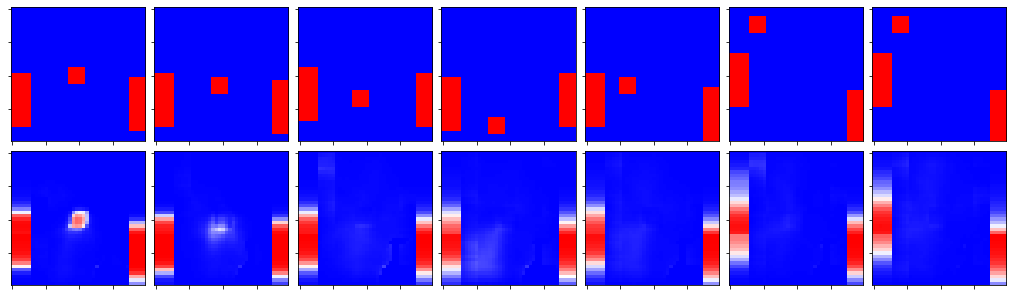

Epoch 309/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1449 - mean_squared_error: 0.0383 - acc: 0.9497 - val_loss: 0.1350 - val_mean_squared_error: 0.0358 - val_acc: 0.9520


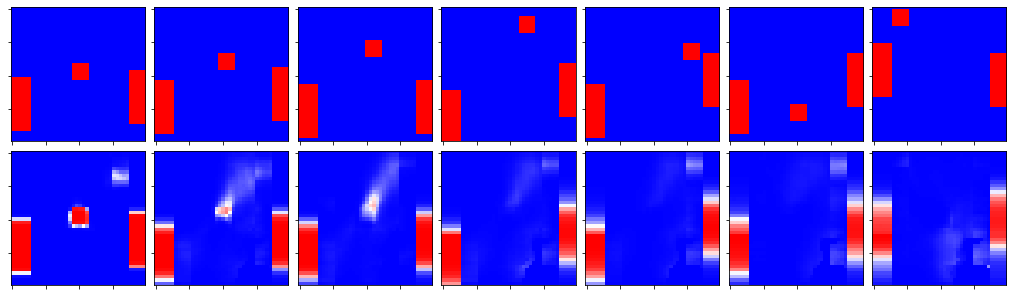

Epoch 310/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.1430 - mean_squared_error: 0.0378 - acc: 0.9504 - val_loss: 0.1446 - val_mean_squared_error: 0.0389 - val_acc: 0.9489


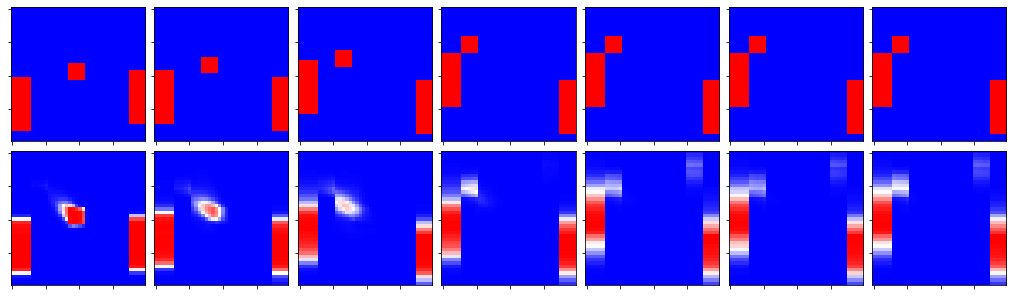

Epoch 311/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.1448 - mean_squared_error: 0.0383 - acc: 0.9498 - val_loss: 0.1506 - val_mean_squared_error: 0.0390 - val_acc: 0.9491


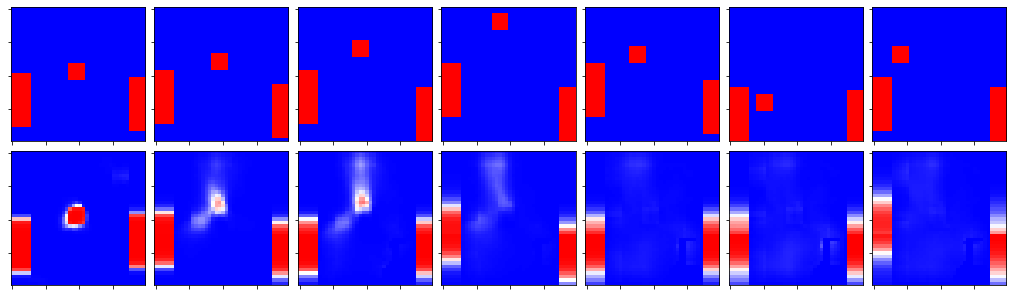

Epoch 312/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1423 - mean_squared_error: 0.0377 - acc: 0.9505 - val_loss: 0.1414 - val_mean_squared_error: 0.0369 - val_acc: 0.9520


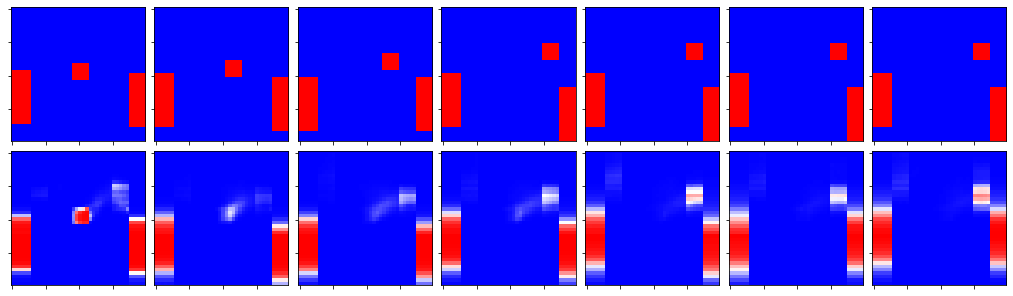

Epoch 313/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.1415 - mean_squared_error: 0.0374 - acc: 0.9510 - val_loss: 0.1449 - val_mean_squared_error: 0.0385 - val_acc: 0.9498


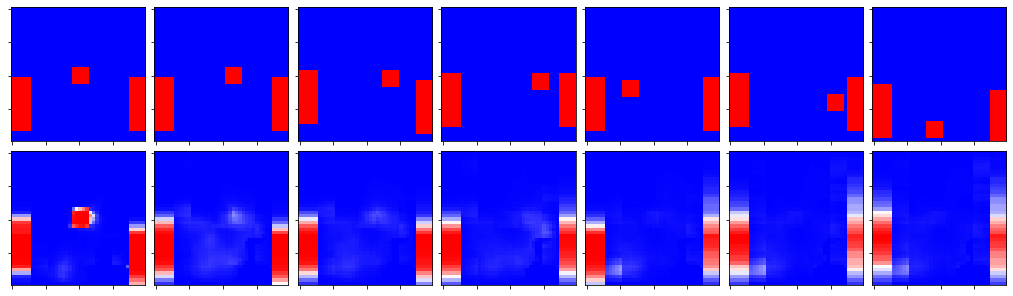

Epoch 314/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1402 - mean_squared_error: 0.0370 - acc: 0.9516 - val_loss: 0.1438 - val_mean_squared_error: 0.0367 - val_acc: 0.9521


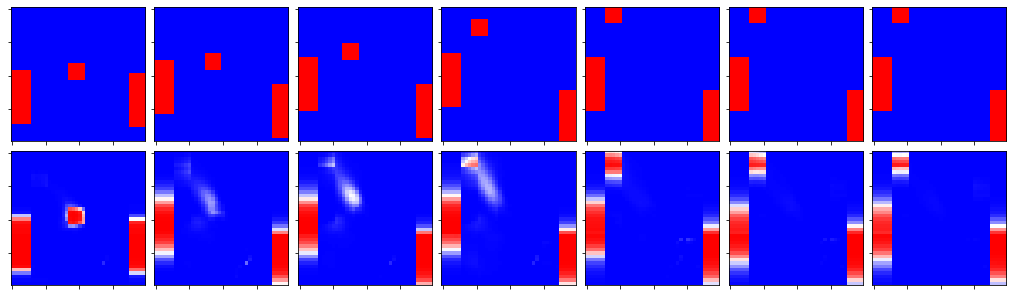

Epoch 315/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.1397 - mean_squared_error: 0.0371 - acc: 0.9514 - val_loss: 0.1501 - val_mean_squared_error: 0.0384 - val_acc: 0.9500


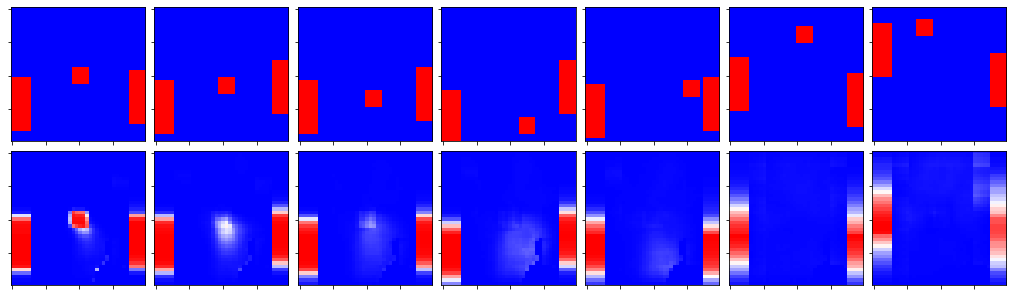

Epoch 316/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1403 - mean_squared_error: 0.0371 - acc: 0.9515 - val_loss: 0.1417 - val_mean_squared_error: 0.0377 - val_acc: 0.9501


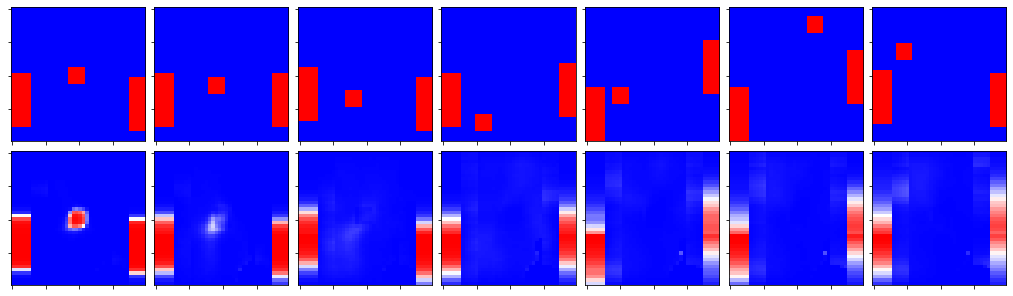

Epoch 317/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1367 - mean_squared_error: 0.0364 - acc: 0.9525 - val_loss: 0.1365 - val_mean_squared_error: 0.0359 - val_acc: 0.9528


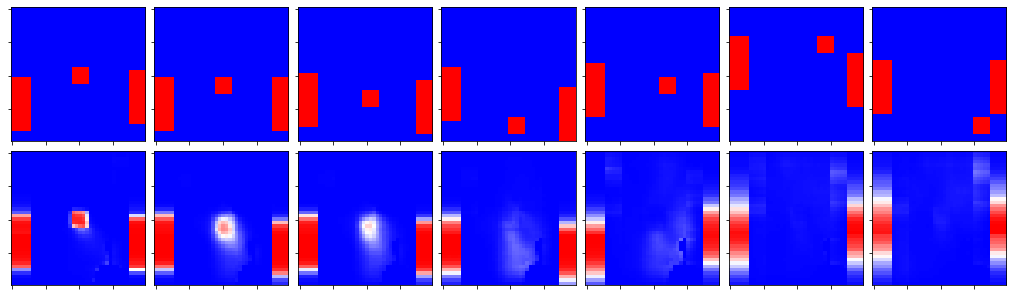

Epoch 318/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1375 - mean_squared_error: 0.0366 - acc: 0.9519 - val_loss: 0.1414 - val_mean_squared_error: 0.0376 - val_acc: 0.9510


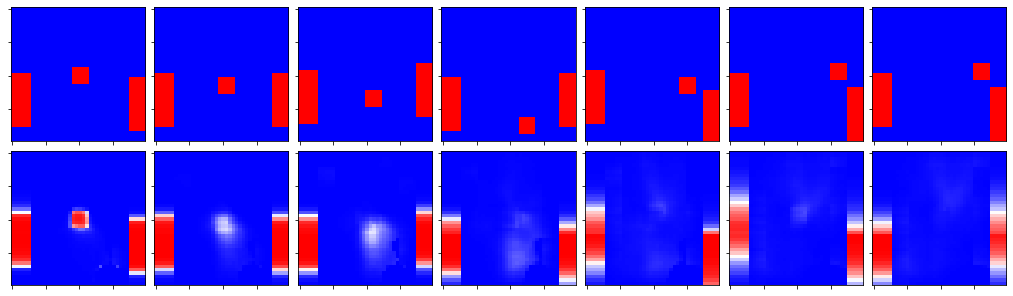

Epoch 319/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1362 - mean_squared_error: 0.0365 - acc: 0.9522 - val_loss: 0.1372 - val_mean_squared_error: 0.0366 - val_acc: 0.9519


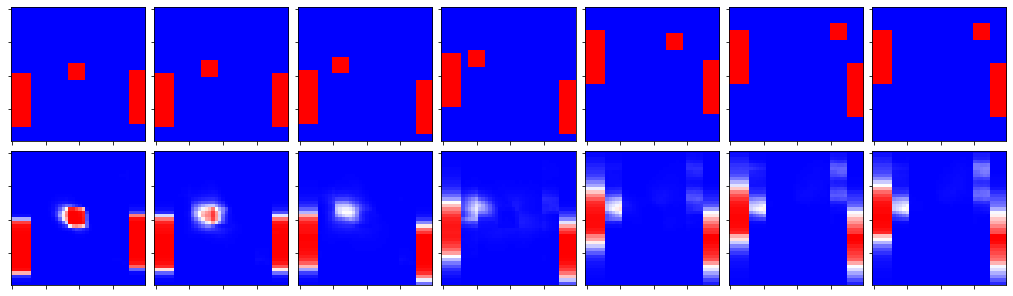

Epoch 320/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.1378 - mean_squared_error: 0.0368 - acc: 0.9518 - val_loss: 0.1320 - val_mean_squared_error: 0.0348 - val_acc: 0.9547


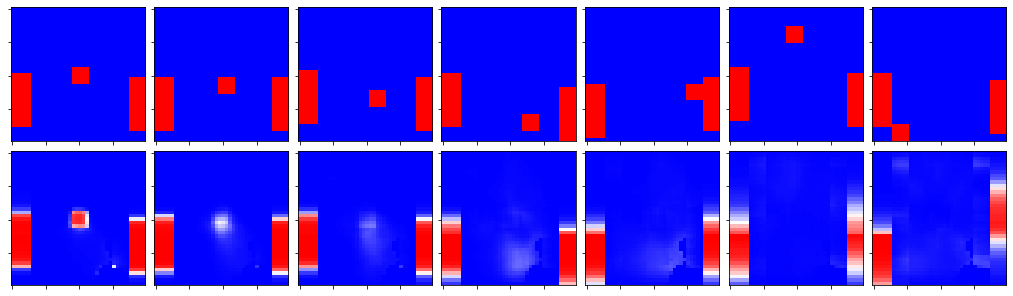

Epoch 321/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1361 - mean_squared_error: 0.0362 - acc: 0.9528 - val_loss: 0.1342 - val_mean_squared_error: 0.0365 - val_acc: 0.9521


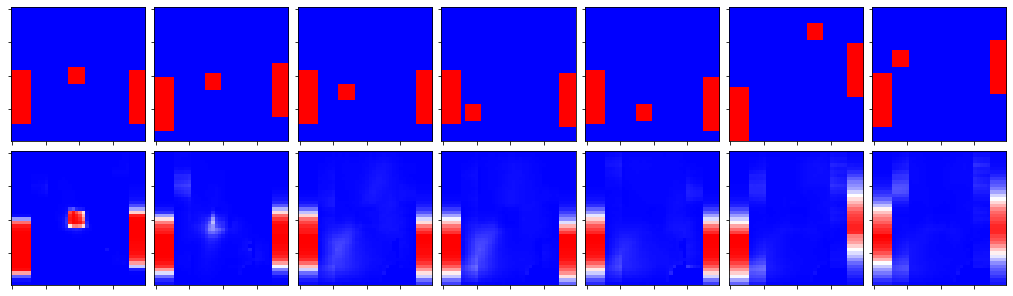

Epoch 322/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1359 - mean_squared_error: 0.0363 - acc: 0.9526 - val_loss: 0.1372 - val_mean_squared_error: 0.0365 - val_acc: 0.9521


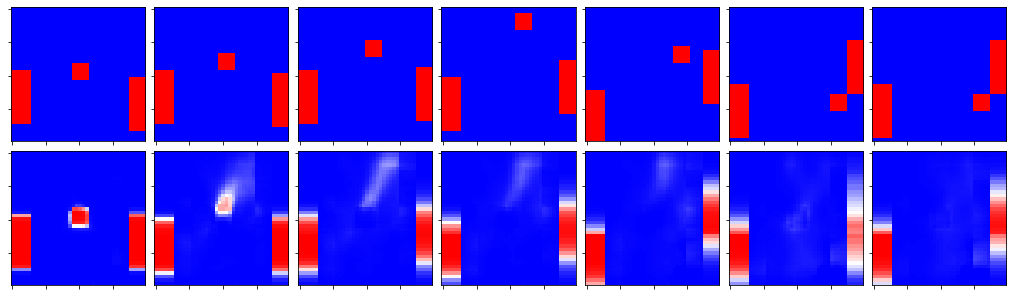

Epoch 323/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1349 - mean_squared_error: 0.0363 - acc: 0.9526 - val_loss: 0.1288 - val_mean_squared_error: 0.0337 - val_acc: 0.9567


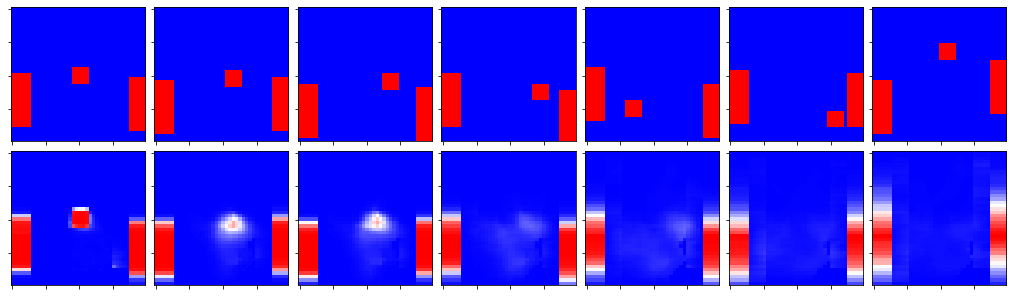

Epoch 324/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1332 - mean_squared_error: 0.0358 - acc: 0.9532 - val_loss: 0.1334 - val_mean_squared_error: 0.0364 - val_acc: 0.9521


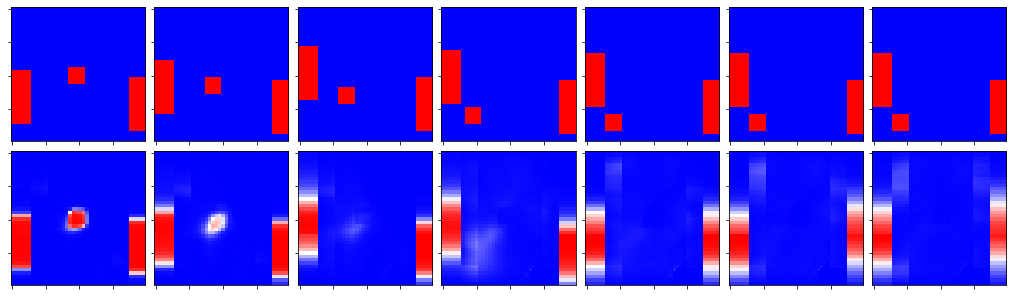

Epoch 325/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.1330 - mean_squared_error: 0.0356 - acc: 0.9534 - val_loss: 0.1290 - val_mean_squared_error: 0.0352 - val_acc: 0.9530


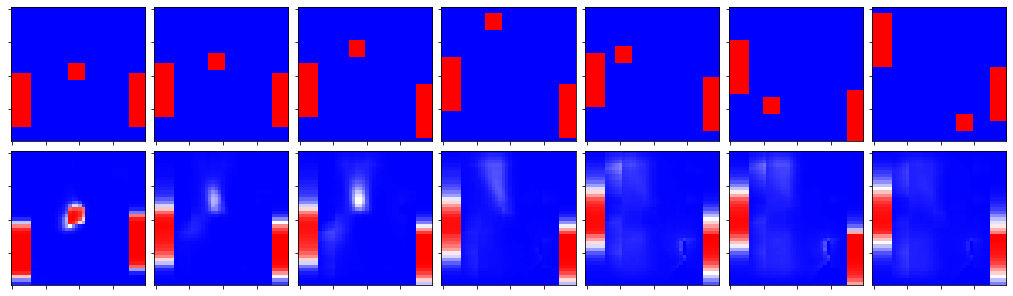

Epoch 326/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1333 - mean_squared_error: 0.0358 - acc: 0.9532 - val_loss: 0.1333 - val_mean_squared_error: 0.0363 - val_acc: 0.9527


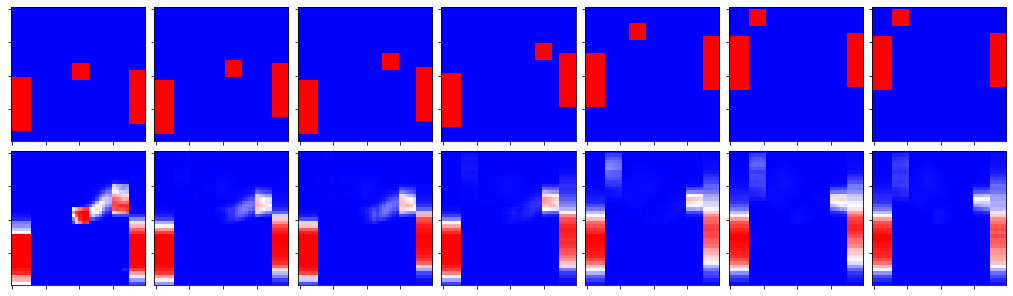

Epoch 327/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1328 - mean_squared_error: 0.0359 - acc: 0.9530 - val_loss: 0.1379 - val_mean_squared_error: 0.0382 - val_acc: 0.9492


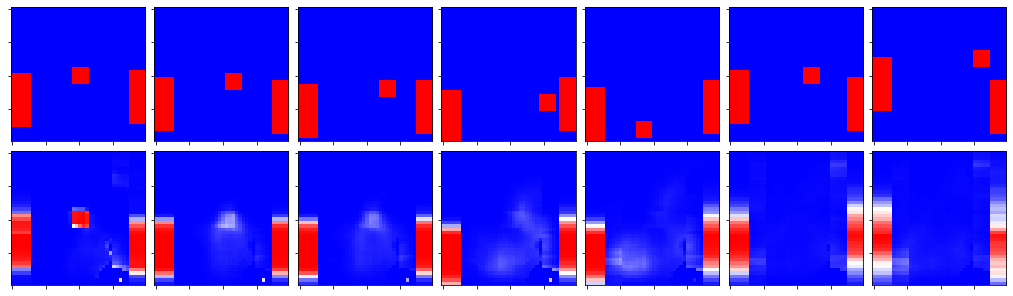

Epoch 328/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.1308 - mean_squared_error: 0.0353 - acc: 0.9539 - val_loss: 0.1265 - val_mean_squared_error: 0.0340 - val_acc: 0.9556


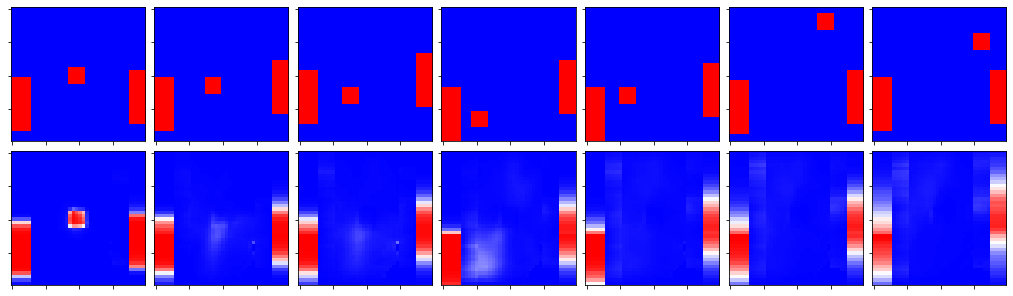

Epoch 329/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1300 - mean_squared_error: 0.0351 - acc: 0.9541 - val_loss: 0.1296 - val_mean_squared_error: 0.0347 - val_acc: 0.9549


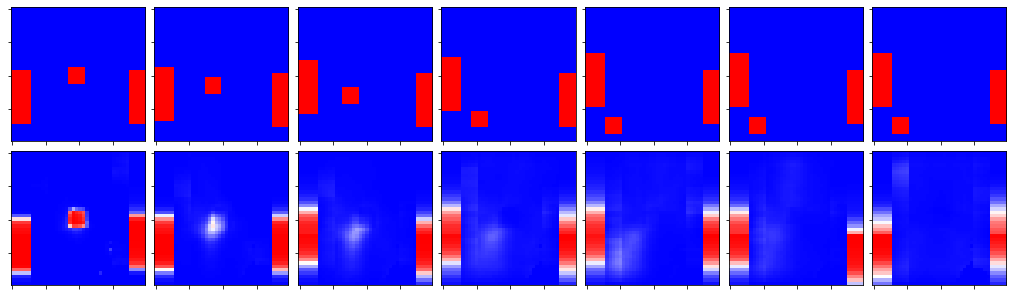

Epoch 330/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.1314 - mean_squared_error: 0.0355 - acc: 0.9536 - val_loss: 0.1403 - val_mean_squared_error: 0.0384 - val_acc: 0.9489


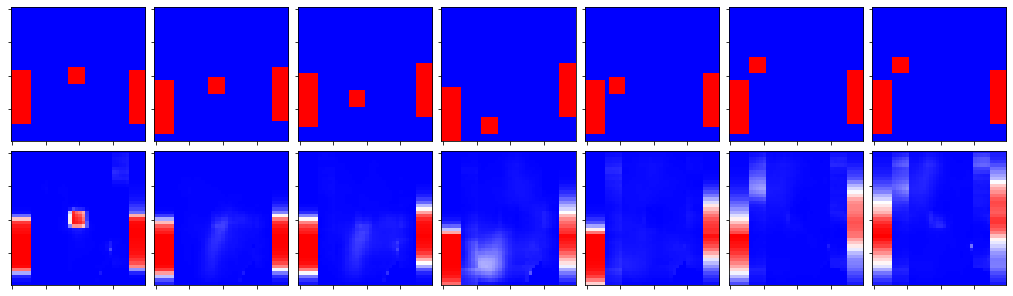

Epoch 331/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1319 - mean_squared_error: 0.0357 - acc: 0.9534 - val_loss: 0.1404 - val_mean_squared_error: 0.0381 - val_acc: 0.9506


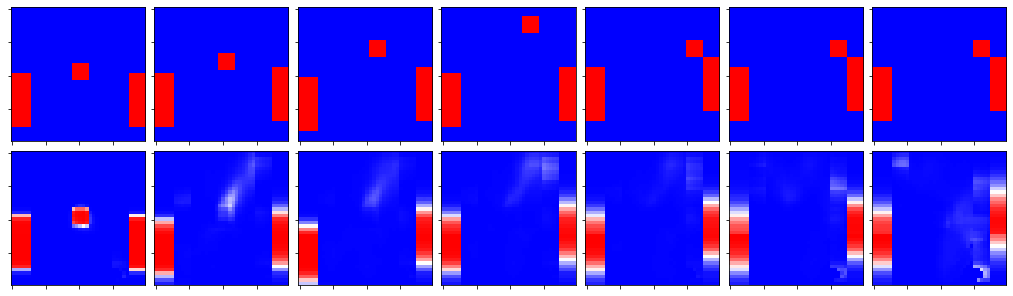

Epoch 332/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1351 - mean_squared_error: 0.0368 - acc: 0.9519 - val_loss: 0.1254 - val_mean_squared_error: 0.0350 - val_acc: 0.9535


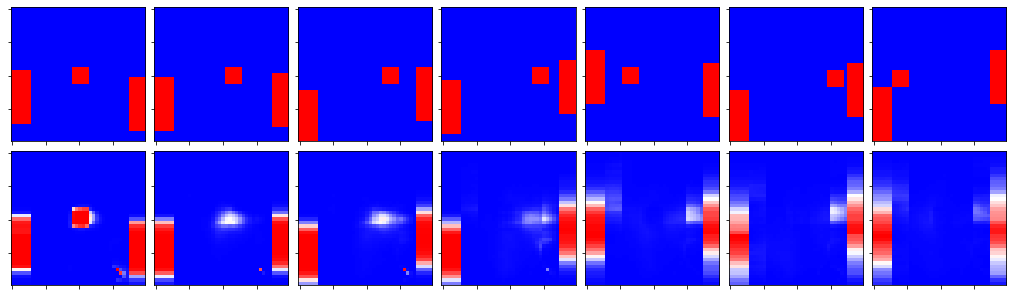

Epoch 333/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1305 - mean_squared_error: 0.0356 - acc: 0.9534 - val_loss: 0.1340 - val_mean_squared_error: 0.0362 - val_acc: 0.9527


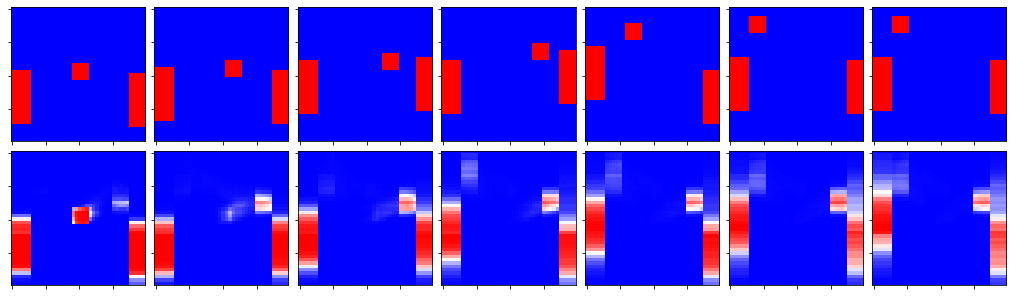

Epoch 334/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1296 - mean_squared_error: 0.0352 - acc: 0.9540 - val_loss: 0.1297 - val_mean_squared_error: 0.0351 - val_acc: 0.9542


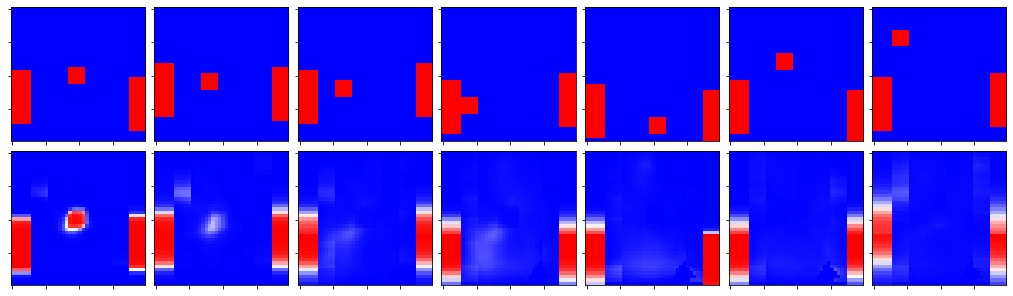

Epoch 335/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1294 - mean_squared_error: 0.0352 - acc: 0.9540 - val_loss: 0.1132 - val_mean_squared_error: 0.0316 - val_acc: 0.9573


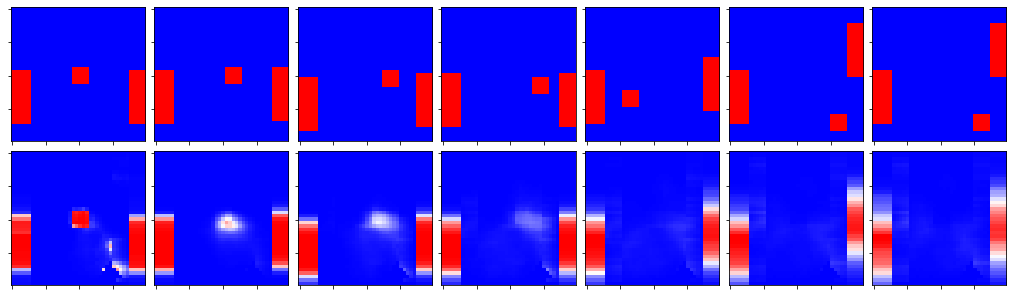

Epoch 336/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1279 - mean_squared_error: 0.0347 - acc: 0.9548 - val_loss: 0.1311 - val_mean_squared_error: 0.0355 - val_acc: 0.9547


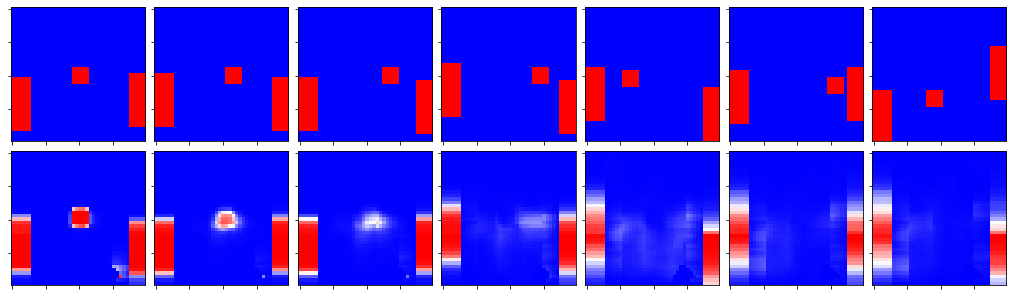

Epoch 337/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1275 - mean_squared_error: 0.0347 - acc: 0.9548 - val_loss: 0.1240 - val_mean_squared_error: 0.0336 - val_acc: 0.9564


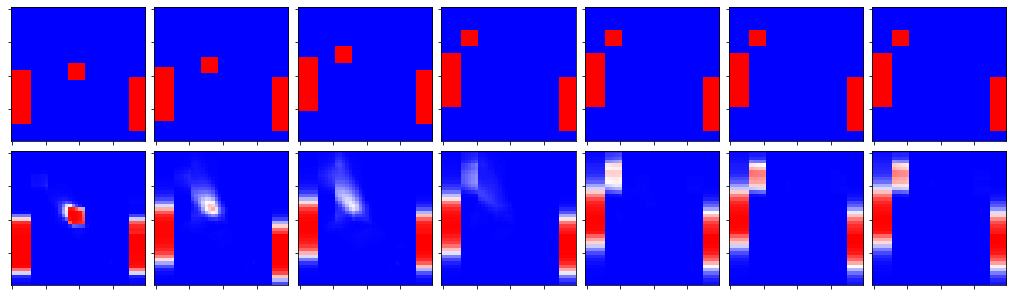

Epoch 338/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.1274 - mean_squared_error: 0.0347 - acc: 0.9549 - val_loss: 0.1238 - val_mean_squared_error: 0.0336 - val_acc: 0.9564


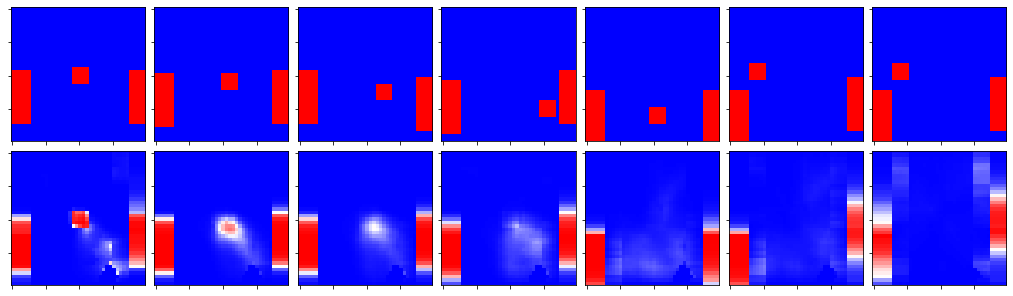

Epoch 339/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1249 - mean_squared_error: 0.0341 - acc: 0.9556 - val_loss: 0.1250 - val_mean_squared_error: 0.0345 - val_acc: 0.9556


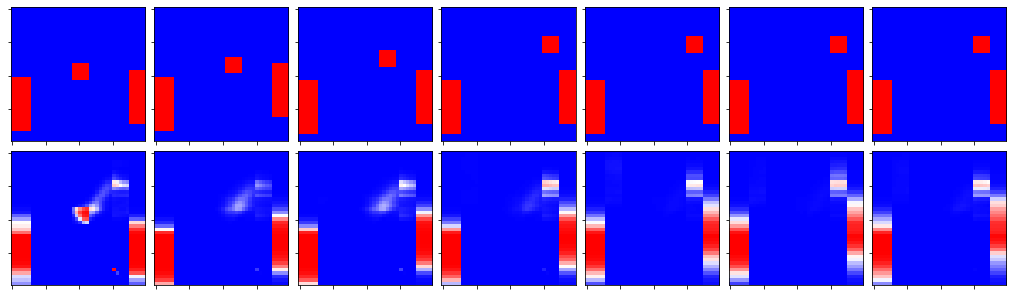

Epoch 340/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1254 - mean_squared_error: 0.0342 - acc: 0.9556 - val_loss: 0.1182 - val_mean_squared_error: 0.0327 - val_acc: 0.9566


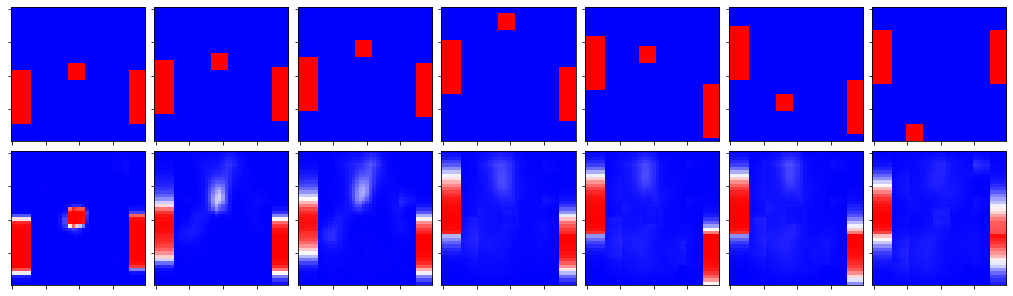

Epoch 341/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1263 - mean_squared_error: 0.0345 - acc: 0.9551 - val_loss: 0.1296 - val_mean_squared_error: 0.0356 - val_acc: 0.9534


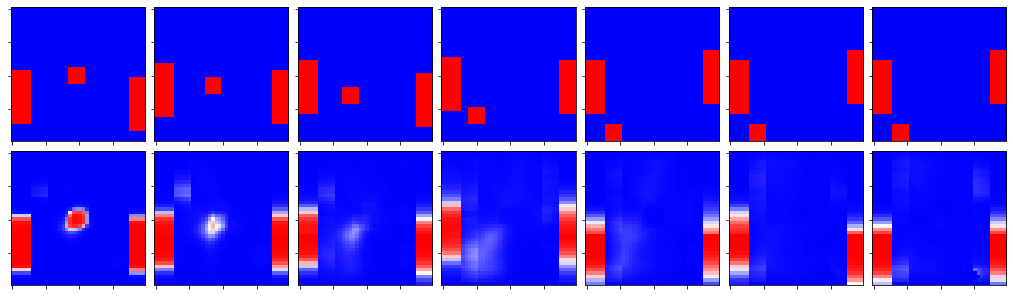

Epoch 342/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.1249 - mean_squared_error: 0.0341 - acc: 0.9556 - val_loss: 0.1289 - val_mean_squared_error: 0.0348 - val_acc: 0.9553


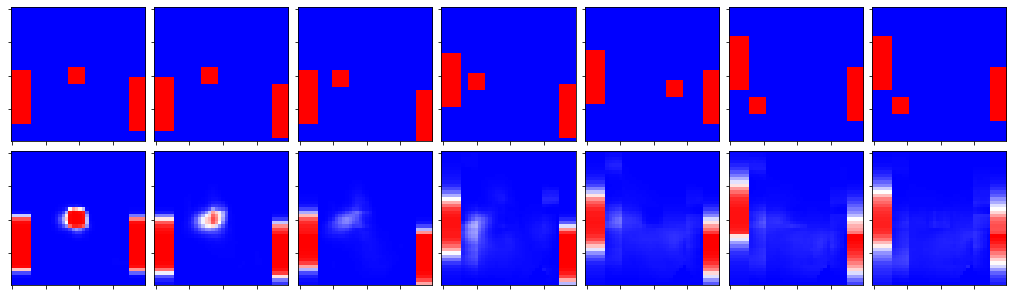

Epoch 343/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1239 - mean_squared_error: 0.0339 - acc: 0.9558 - val_loss: 0.1243 - val_mean_squared_error: 0.0336 - val_acc: 0.9564


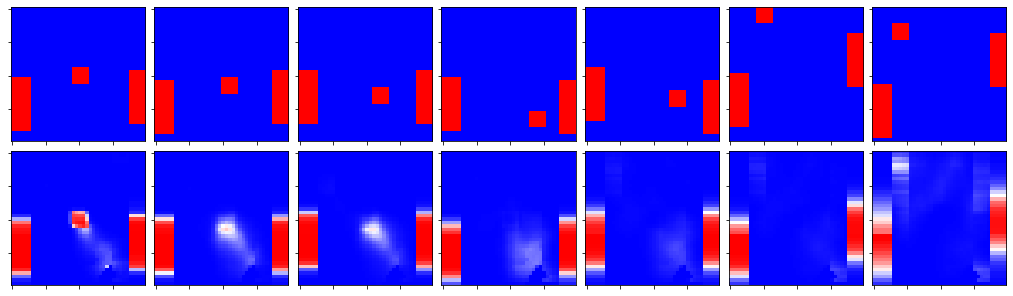

Epoch 344/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1226 - mean_squared_error: 0.0334 - acc: 0.9566 - val_loss: 0.1173 - val_mean_squared_error: 0.0321 - val_acc: 0.9584


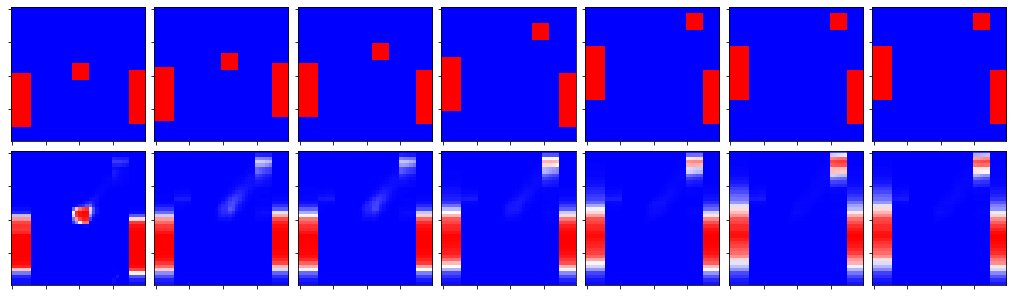

Epoch 345/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1227 - mean_squared_error: 0.0335 - acc: 0.9565 - val_loss: 0.1197 - val_mean_squared_error: 0.0328 - val_acc: 0.9567


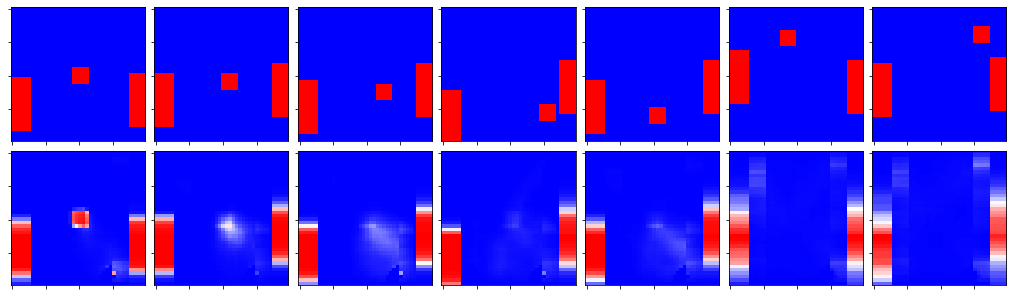

Epoch 346/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1212 - mean_squared_error: 0.0331 - acc: 0.9569 - val_loss: 0.1117 - val_mean_squared_error: 0.0311 - val_acc: 0.9594


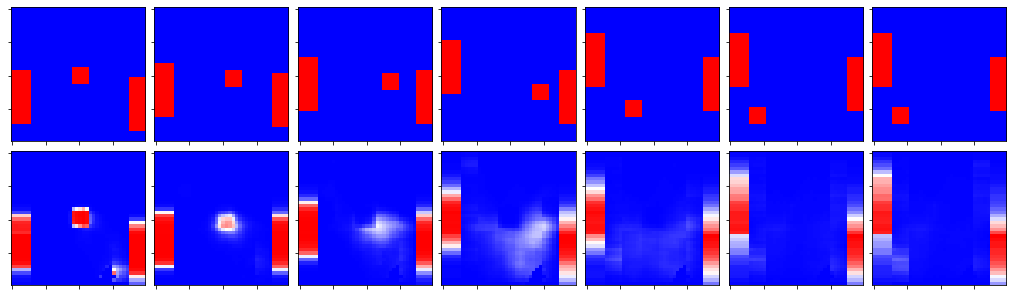

Epoch 347/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1212 - mean_squared_error: 0.0330 - acc: 0.9572 - val_loss: 0.1238 - val_mean_squared_error: 0.0339 - val_acc: 0.9559


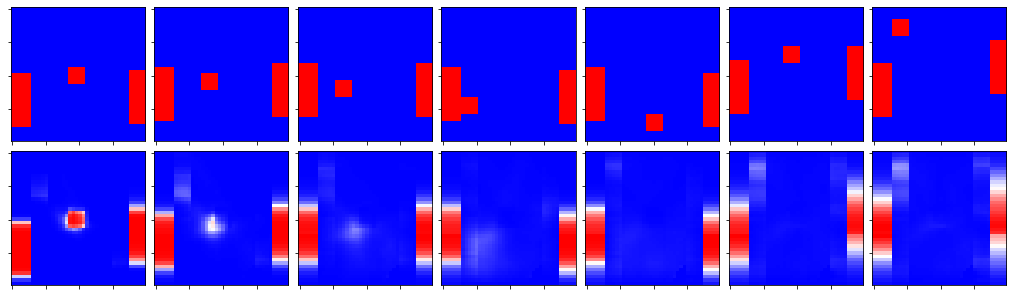

Epoch 348/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1201 - mean_squared_error: 0.0329 - acc: 0.9573 - val_loss: 0.1195 - val_mean_squared_error: 0.0328 - val_acc: 0.9574


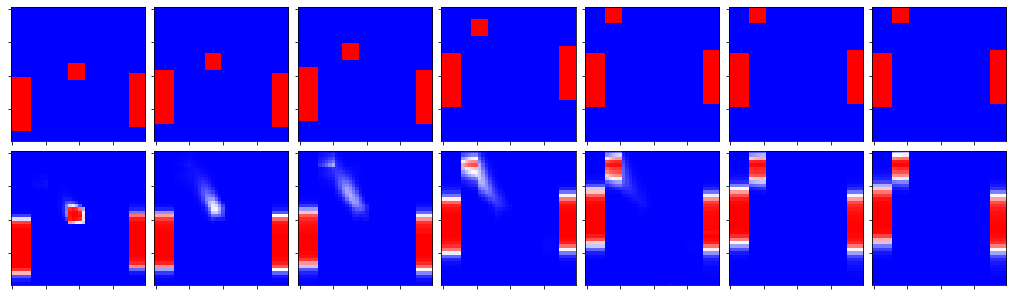

Epoch 349/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1216 - mean_squared_error: 0.0332 - acc: 0.9569 - val_loss: 0.1171 - val_mean_squared_error: 0.0322 - val_acc: 0.9584


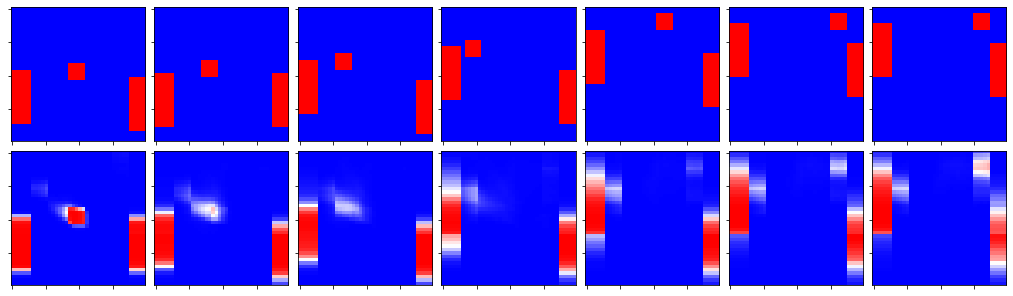

Epoch 350/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1225 - mean_squared_error: 0.0334 - acc: 0.9568 - val_loss: 0.1240 - val_mean_squared_error: 0.0346 - val_acc: 0.9545


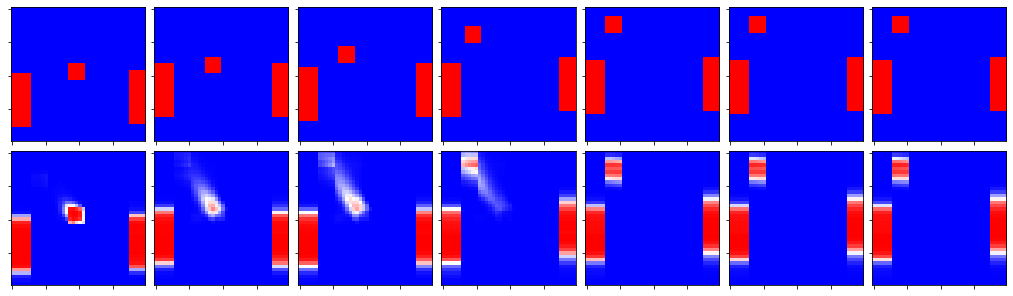

Epoch 351/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1215 - mean_squared_error: 0.0331 - acc: 0.9572 - val_loss: 0.1150 - val_mean_squared_error: 0.0318 - val_acc: 0.9585


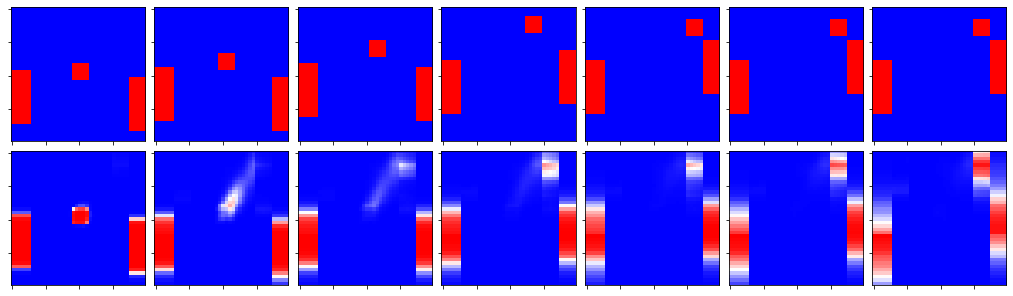

Epoch 352/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.1215 - mean_squared_error: 0.0331 - acc: 0.9572 - val_loss: 0.1332 - val_mean_squared_error: 0.0356 - val_acc: 0.9546


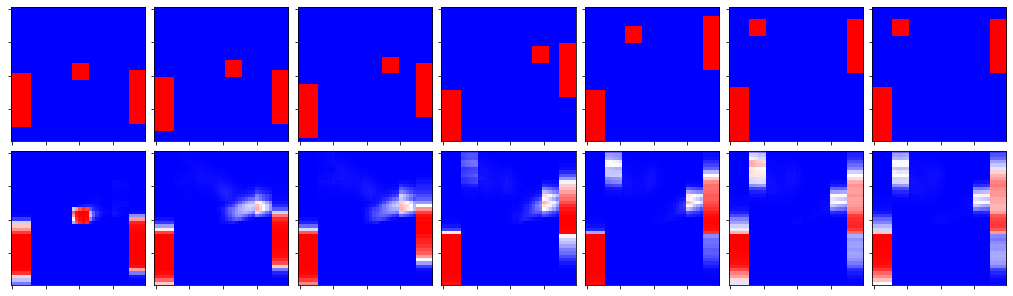

Epoch 353/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1210 - mean_squared_error: 0.0329 - acc: 0.9575 - val_loss: 0.1077 - val_mean_squared_error: 0.0292 - val_acc: 0.9620


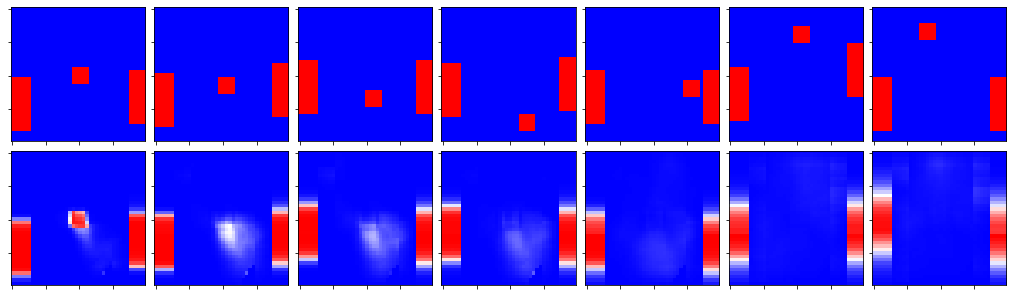

Epoch 354/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1189 - mean_squared_error: 0.0324 - acc: 0.9580 - val_loss: 0.1179 - val_mean_squared_error: 0.0327 - val_acc: 0.9578


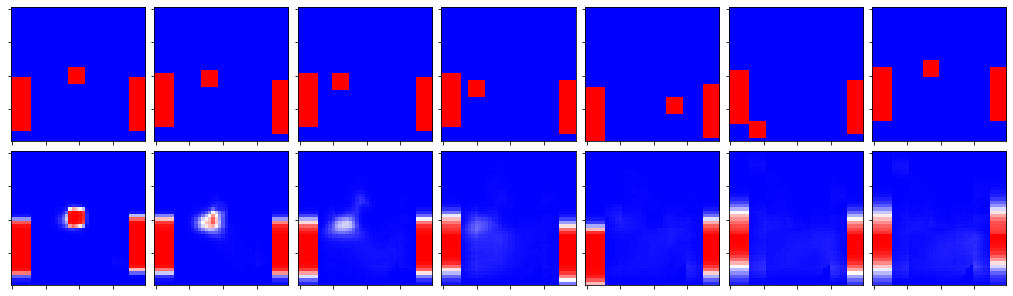

Epoch 355/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1186 - mean_squared_error: 0.0324 - acc: 0.9579 - val_loss: 0.1258 - val_mean_squared_error: 0.0343 - val_acc: 0.9549


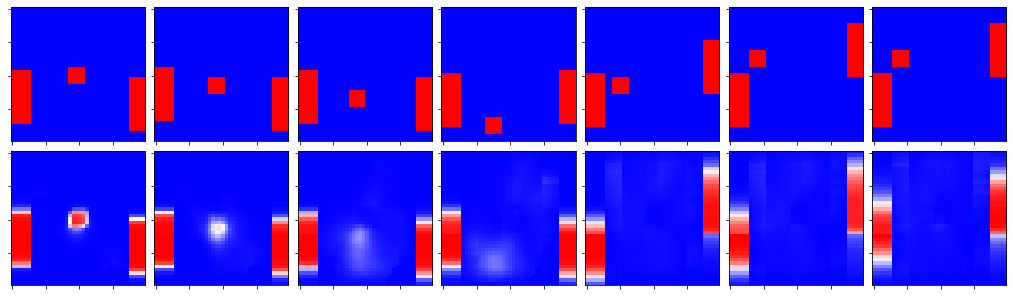

Epoch 356/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1196 - mean_squared_error: 0.0326 - acc: 0.9579 - val_loss: 0.1137 - val_mean_squared_error: 0.0312 - val_acc: 0.9593


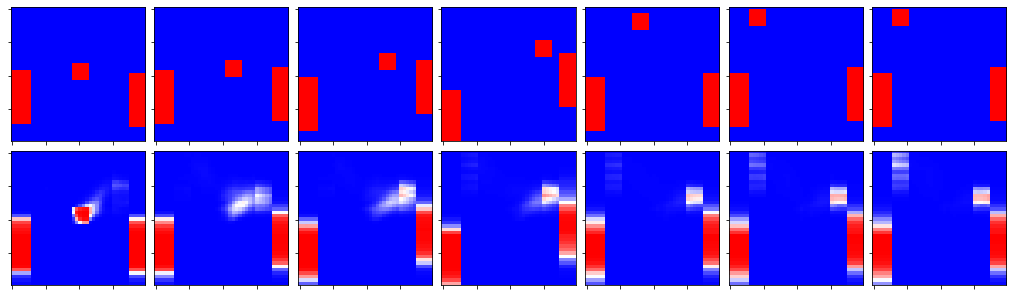

Epoch 357/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.1167 - mean_squared_error: 0.0317 - acc: 0.9591 - val_loss: 0.1162 - val_mean_squared_error: 0.0310 - val_acc: 0.9605


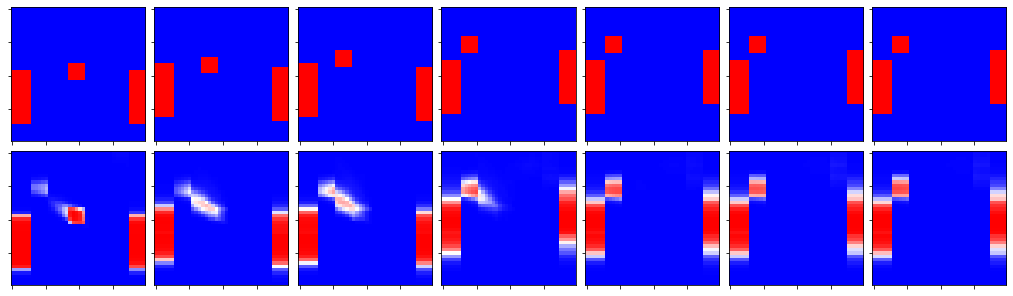

Epoch 358/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1173 - mean_squared_error: 0.0320 - acc: 0.9585 - val_loss: 0.1172 - val_mean_squared_error: 0.0316 - val_acc: 0.9595


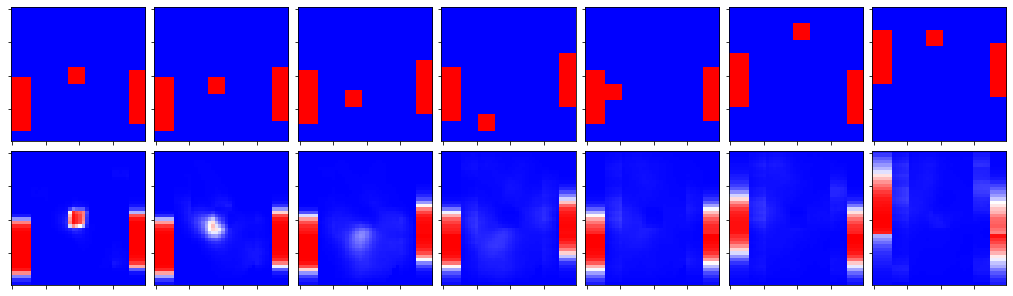

Epoch 359/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.1166 - mean_squared_error: 0.0316 - acc: 0.9594 - val_loss: 0.1139 - val_mean_squared_error: 0.0312 - val_acc: 0.9594


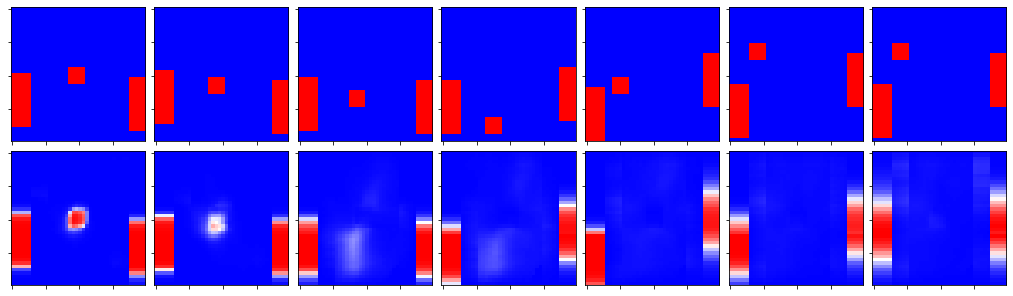

Epoch 360/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1188 - mean_squared_error: 0.0324 - acc: 0.9583 - val_loss: 0.1112 - val_mean_squared_error: 0.0307 - val_acc: 0.9598


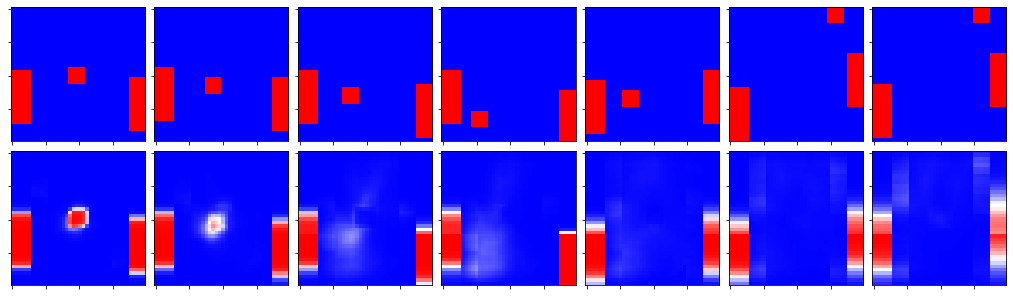

Epoch 361/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1167 - mean_squared_error: 0.0317 - acc: 0.9589 - val_loss: 0.1142 - val_mean_squared_error: 0.0310 - val_acc: 0.9600


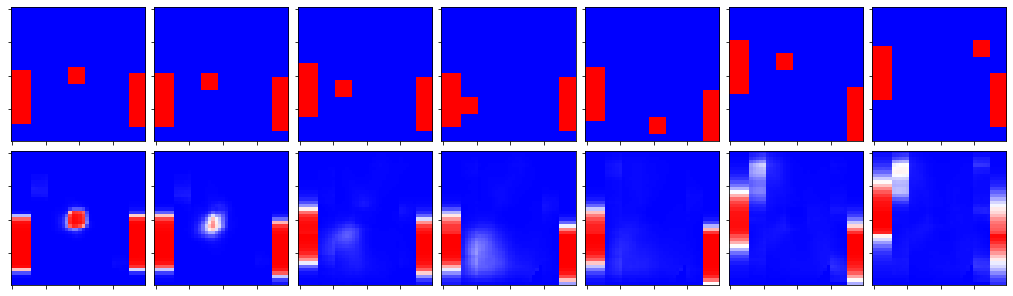

Epoch 362/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1158 - mean_squared_error: 0.0315 - acc: 0.9594 - val_loss: 0.1146 - val_mean_squared_error: 0.0313 - val_acc: 0.9598


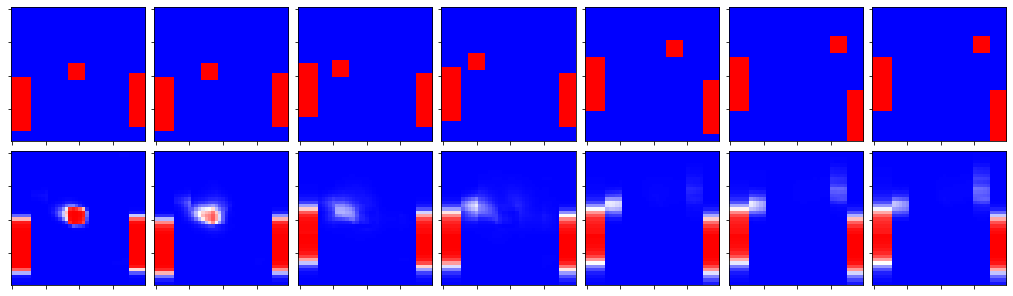

Epoch 363/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1160 - mean_squared_error: 0.0316 - acc: 0.9592 - val_loss: 0.1146 - val_mean_squared_error: 0.0316 - val_acc: 0.9593


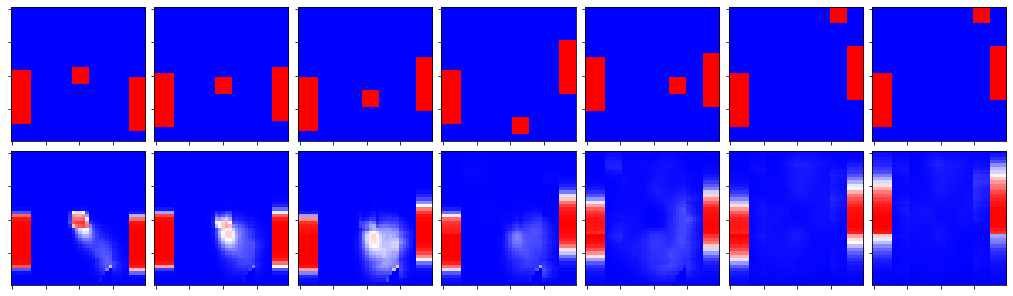

Epoch 364/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1127 - mean_squared_error: 0.0307 - acc: 0.9604 - val_loss: 0.1141 - val_mean_squared_error: 0.0312 - val_acc: 0.9595


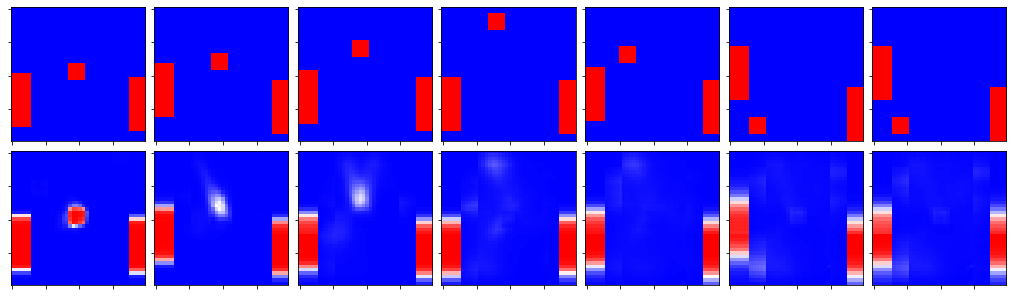

Epoch 365/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.1157 - mean_squared_error: 0.0315 - acc: 0.9593 - val_loss: 0.1122 - val_mean_squared_error: 0.0304 - val_acc: 0.9613


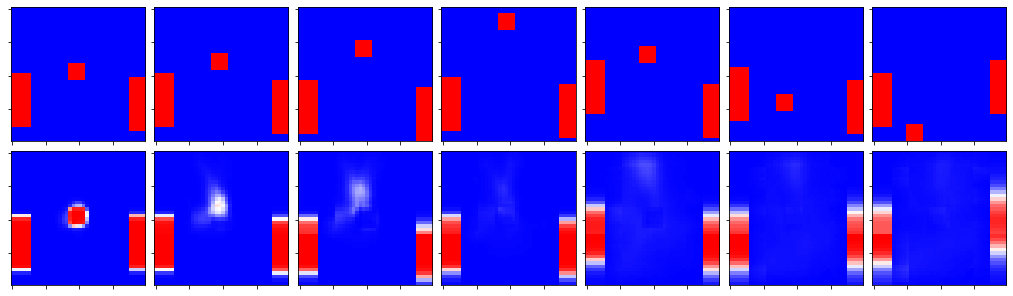

Epoch 366/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1143 - mean_squared_error: 0.0312 - acc: 0.9597 - val_loss: 0.1188 - val_mean_squared_error: 0.0316 - val_acc: 0.9593


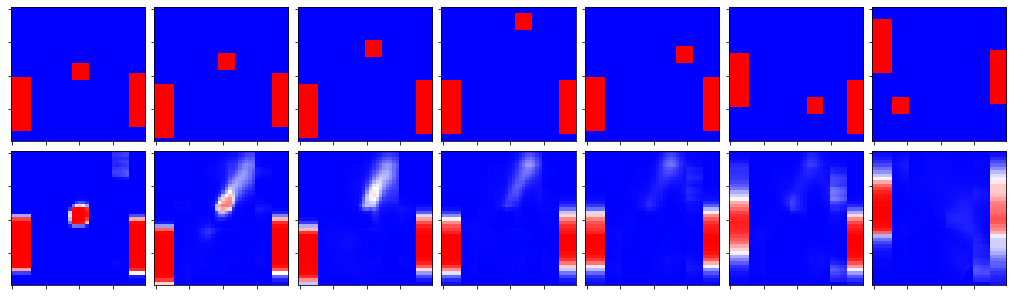

Epoch 367/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1138 - mean_squared_error: 0.0310 - acc: 0.9599 - val_loss: 0.1064 - val_mean_squared_error: 0.0293 - val_acc: 0.9620


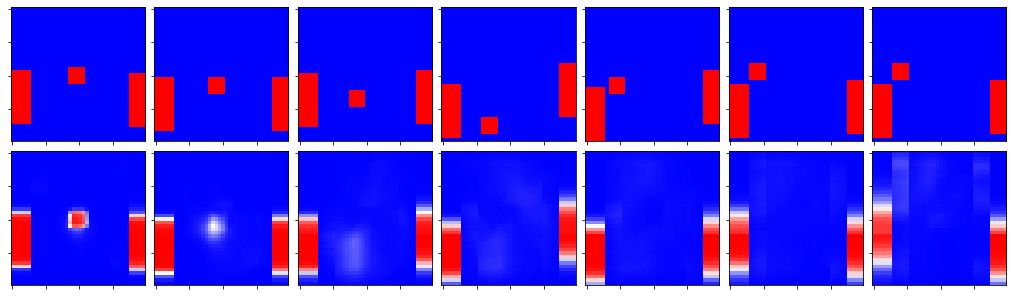

Epoch 368/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1124 - mean_squared_error: 0.0305 - acc: 0.9607 - val_loss: 0.1107 - val_mean_squared_error: 0.0306 - val_acc: 0.9602


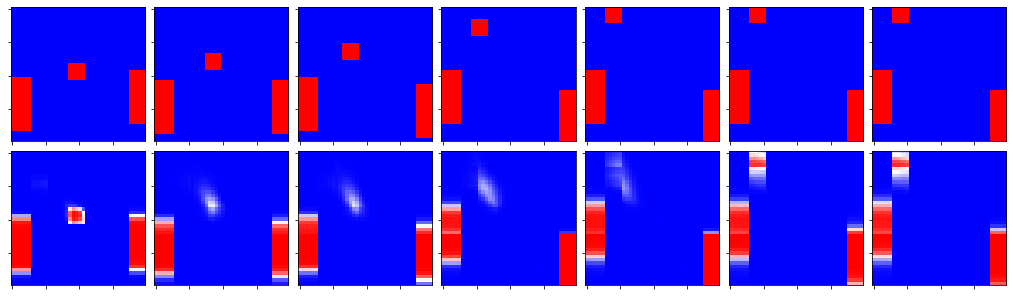

Epoch 369/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1133 - mean_squared_error: 0.0307 - acc: 0.9604 - val_loss: 0.1313 - val_mean_squared_error: 0.0363 - val_acc: 0.9528


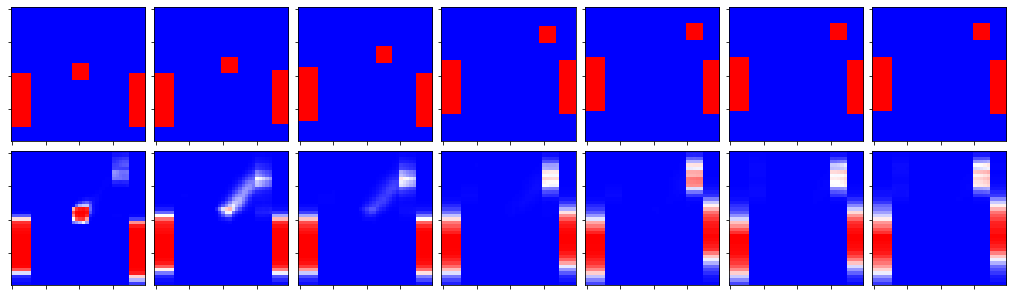

Epoch 370/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1183 - mean_squared_error: 0.0320 - acc: 0.9589 - val_loss: 0.1094 - val_mean_squared_error: 0.0301 - val_acc: 0.9609


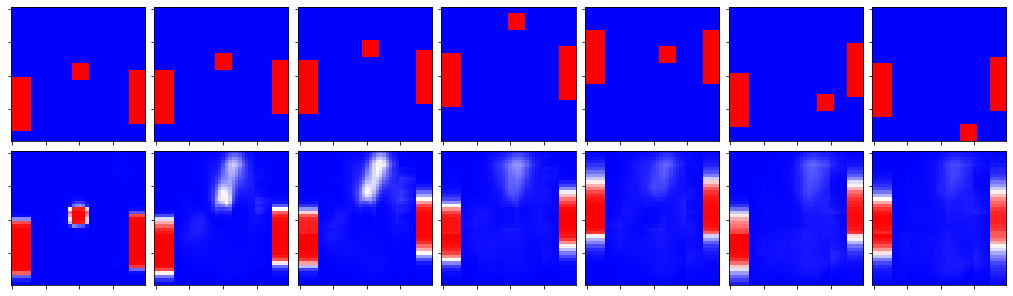

Epoch 371/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.1136 - mean_squared_error: 0.0308 - acc: 0.9602 - val_loss: 0.1115 - val_mean_squared_error: 0.0298 - val_acc: 0.9615


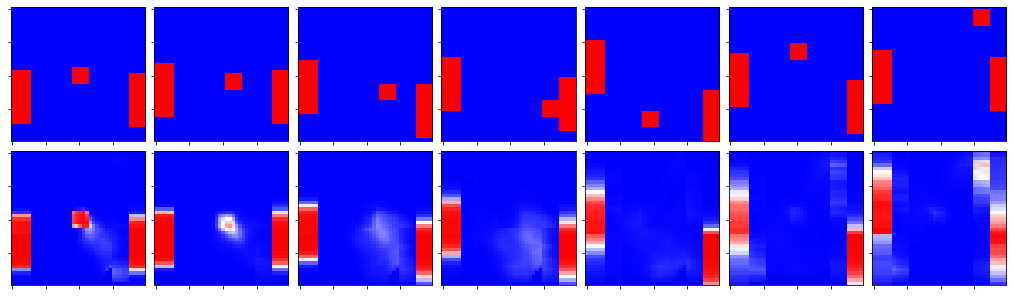

Epoch 372/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.1125 - mean_squared_error: 0.0304 - acc: 0.9610 - val_loss: 0.1147 - val_mean_squared_error: 0.0317 - val_acc: 0.9587


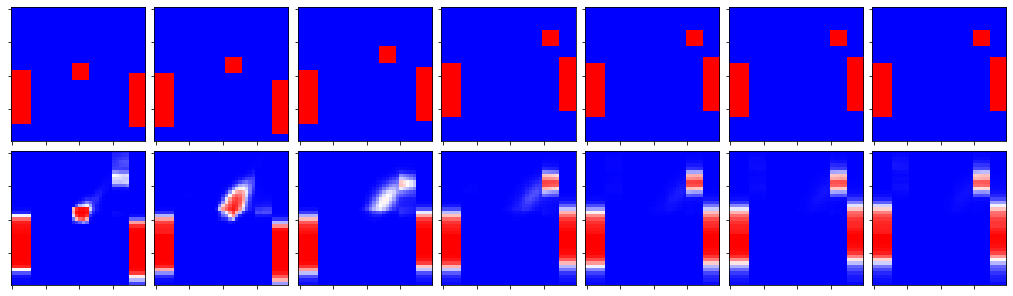

Epoch 373/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1125 - mean_squared_error: 0.0304 - acc: 0.9608 - val_loss: 0.1165 - val_mean_squared_error: 0.0301 - val_acc: 0.9627


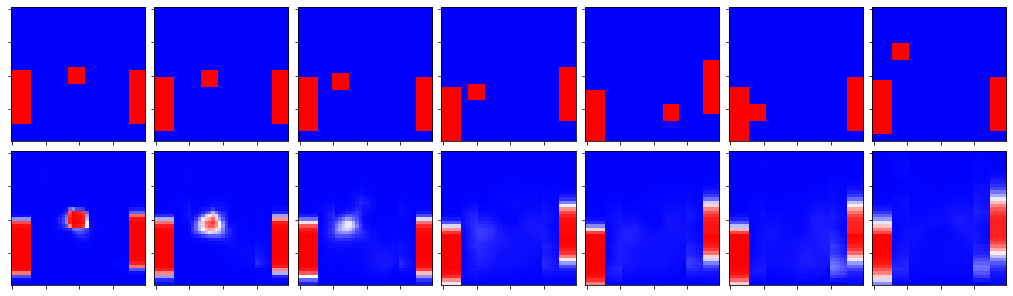

Epoch 374/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1121 - mean_squared_error: 0.0304 - acc: 0.9609 - val_loss: 0.1184 - val_mean_squared_error: 0.0321 - val_acc: 0.9590


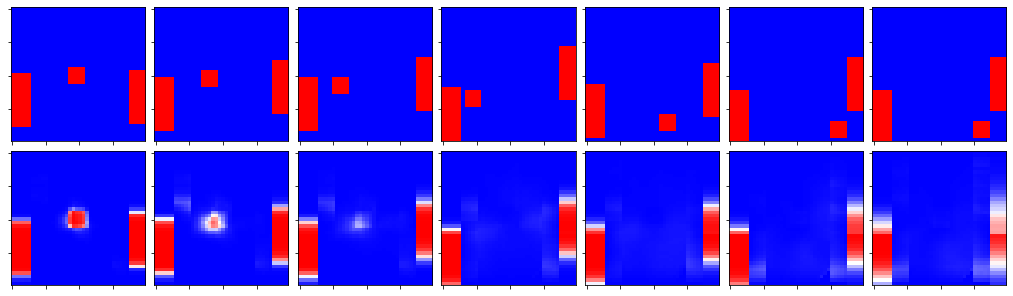

Epoch 375/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.1117 - mean_squared_error: 0.0303 - acc: 0.9610 - val_loss: 0.1101 - val_mean_squared_error: 0.0303 - val_acc: 0.9612


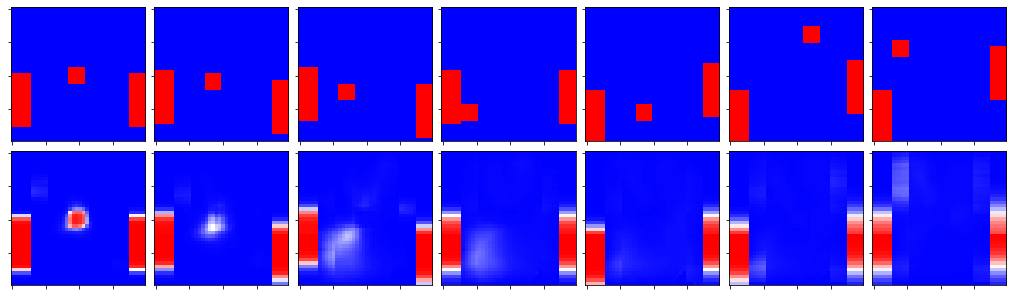

Epoch 376/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.1114 - mean_squared_error: 0.0302 - acc: 0.9612 - val_loss: 0.1088 - val_mean_squared_error: 0.0297 - val_acc: 0.9614


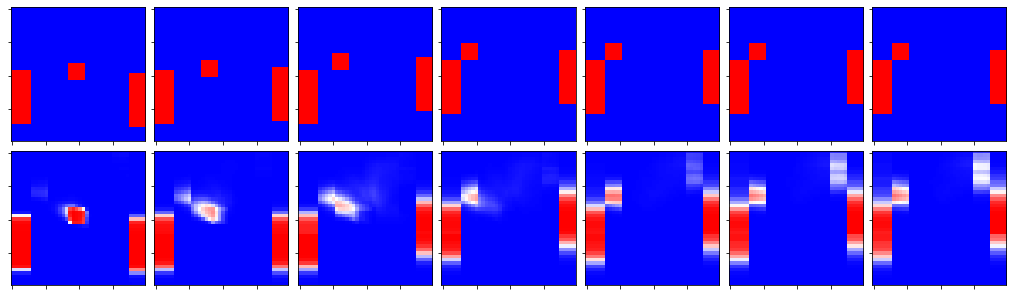

Epoch 377/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1117 - mean_squared_error: 0.0304 - acc: 0.9608 - val_loss: 0.1174 - val_mean_squared_error: 0.0319 - val_acc: 0.9584


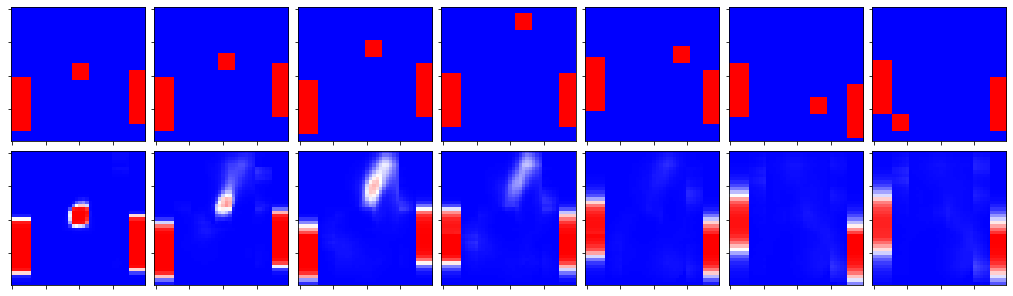

Epoch 378/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1105 - mean_squared_error: 0.0299 - acc: 0.9615 - val_loss: 0.1101 - val_mean_squared_error: 0.0296 - val_acc: 0.9620


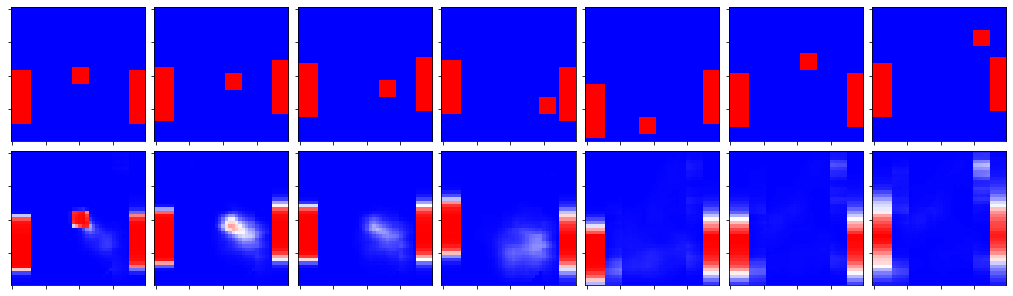

Epoch 379/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.1111 - mean_squared_error: 0.0301 - acc: 0.9611 - val_loss: 0.1084 - val_mean_squared_error: 0.0295 - val_acc: 0.9618


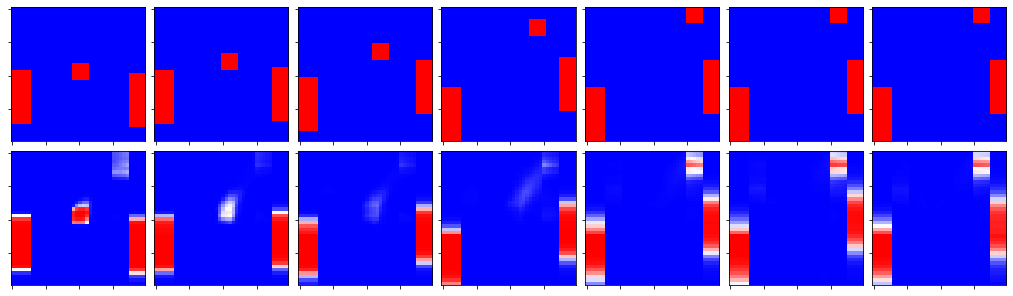

Epoch 380/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1106 - mean_squared_error: 0.0300 - acc: 0.9613 - val_loss: 0.1136 - val_mean_squared_error: 0.0303 - val_acc: 0.9617


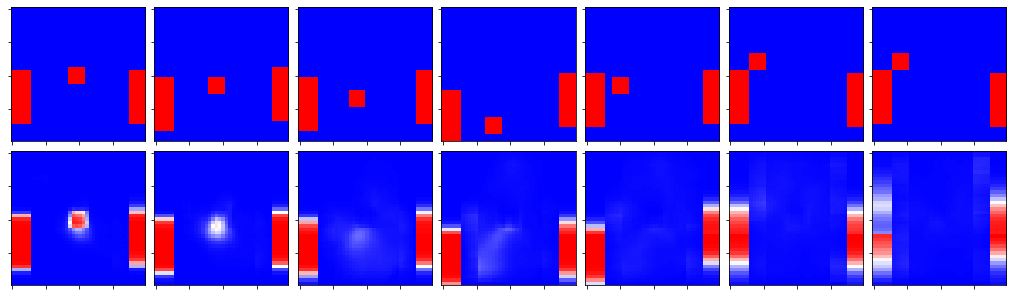

Epoch 381/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.1105 - mean_squared_error: 0.0299 - acc: 0.9615 - val_loss: 0.1172 - val_mean_squared_error: 0.0332 - val_acc: 0.9566


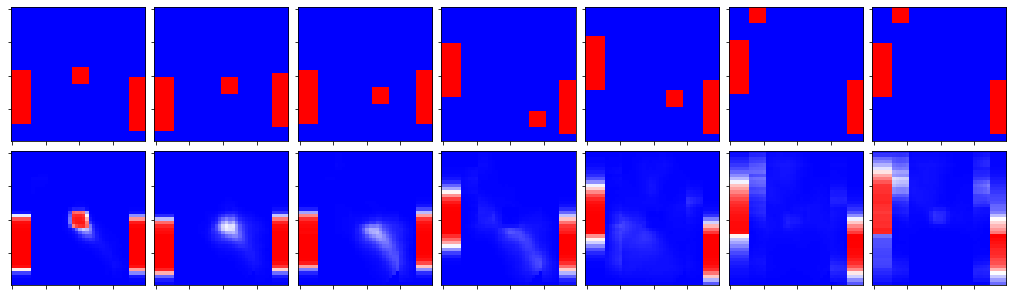

Epoch 382/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1092 - mean_squared_error: 0.0297 - acc: 0.9617 - val_loss: 0.1168 - val_mean_squared_error: 0.0311 - val_acc: 0.9597


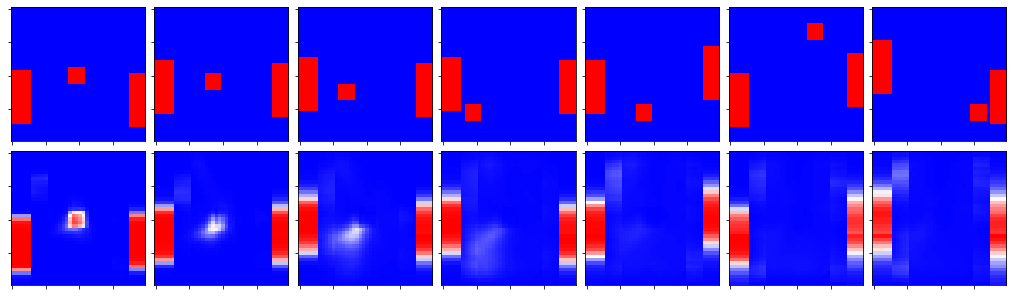

Epoch 383/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.1092 - mean_squared_error: 0.0296 - acc: 0.9619 - val_loss: 0.1073 - val_mean_squared_error: 0.0293 - val_acc: 0.9618


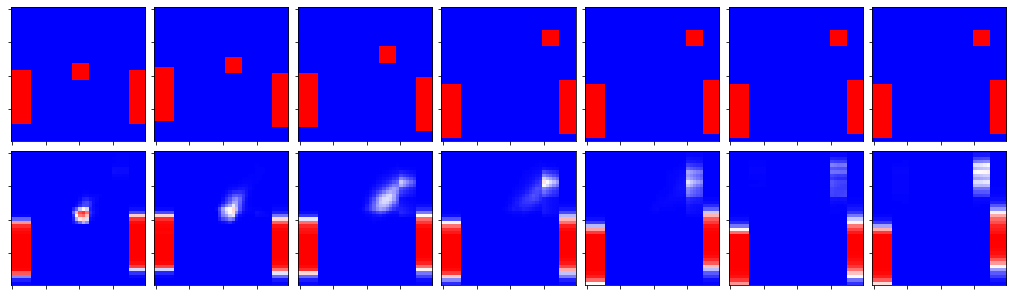

Epoch 384/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1072 - mean_squared_error: 0.0290 - acc: 0.9626 - val_loss: 0.1031 - val_mean_squared_error: 0.0277 - val_acc: 0.9643


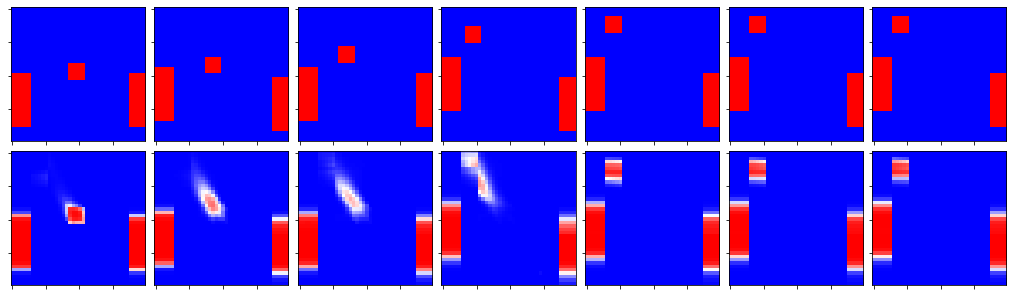

Epoch 385/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1075 - mean_squared_error: 0.0291 - acc: 0.9626 - val_loss: 0.1073 - val_mean_squared_error: 0.0294 - val_acc: 0.9620


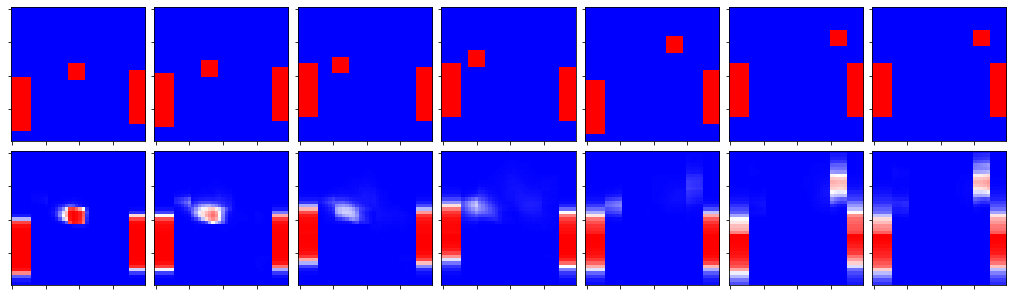

Epoch 386/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.1073 - mean_squared_error: 0.0291 - acc: 0.9625 - val_loss: 0.1039 - val_mean_squared_error: 0.0278 - val_acc: 0.9645


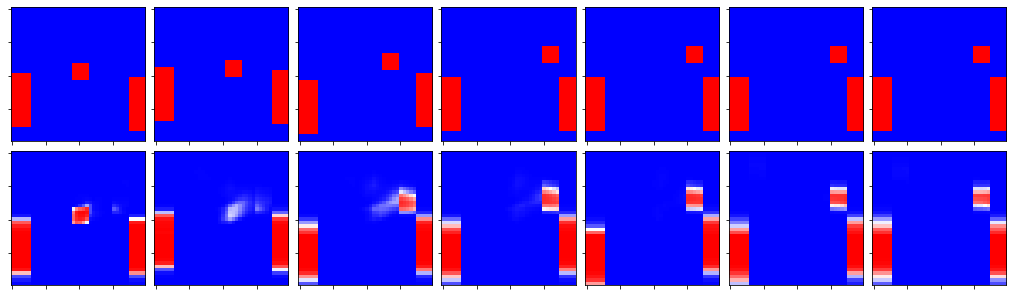

Epoch 387/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.1076 - mean_squared_error: 0.0290 - acc: 0.9627 - val_loss: 0.0984 - val_mean_squared_error: 0.0266 - val_acc: 0.9659


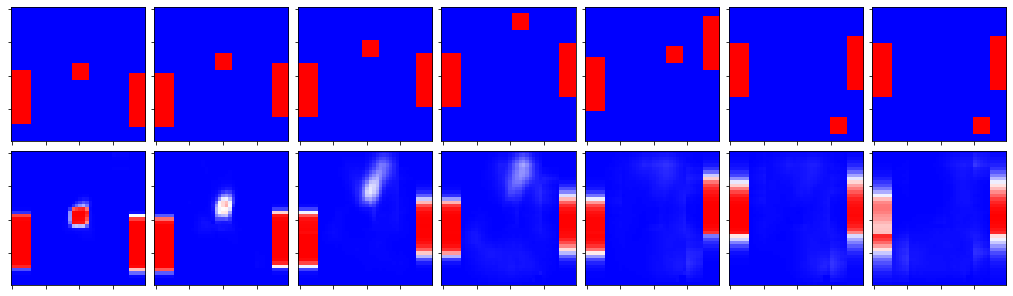

Epoch 388/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1066 - mean_squared_error: 0.0290 - acc: 0.9627 - val_loss: 0.1050 - val_mean_squared_error: 0.0285 - val_acc: 0.9635


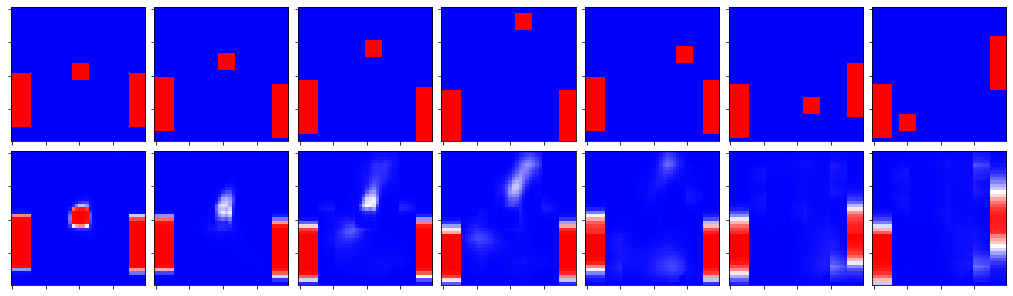

Epoch 389/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1050 - mean_squared_error: 0.0284 - acc: 0.9636 - val_loss: 0.1077 - val_mean_squared_error: 0.0304 - val_acc: 0.9601


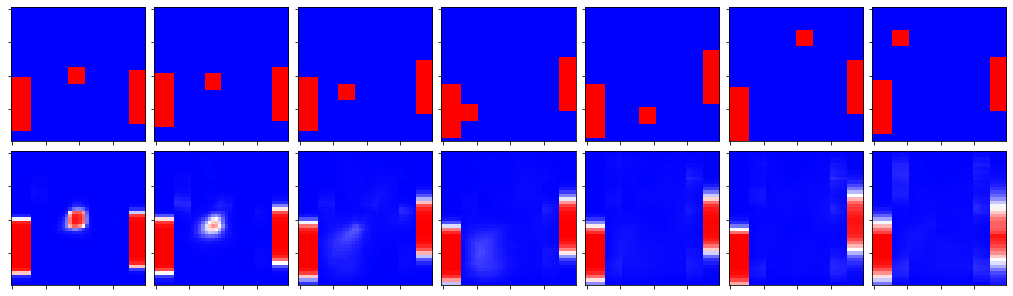

Epoch 390/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1071 - mean_squared_error: 0.0291 - acc: 0.9626 - val_loss: 0.1078 - val_mean_squared_error: 0.0293 - val_acc: 0.9621


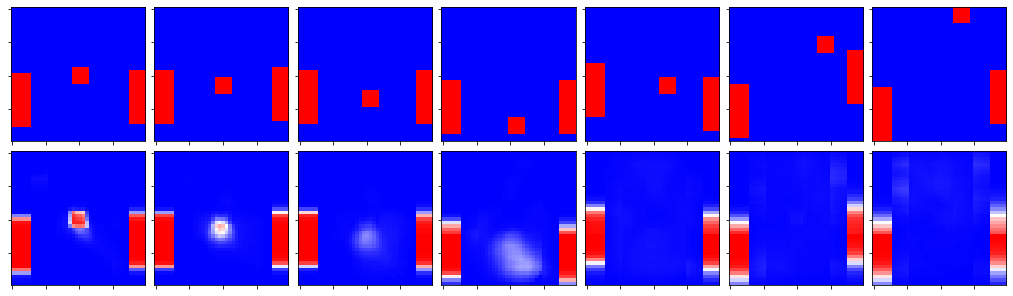

Epoch 391/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1056 - mean_squared_error: 0.0286 - acc: 0.9631 - val_loss: 0.0951 - val_mean_squared_error: 0.0257 - val_acc: 0.9671


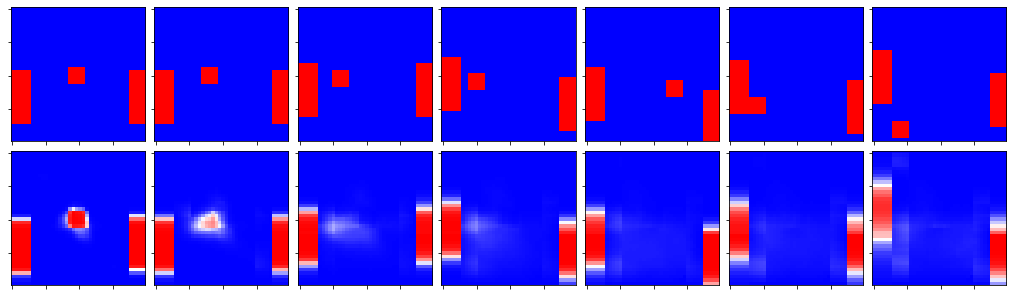

Epoch 392/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.1059 - mean_squared_error: 0.0287 - acc: 0.9630 - val_loss: 0.1056 - val_mean_squared_error: 0.0292 - val_acc: 0.9623


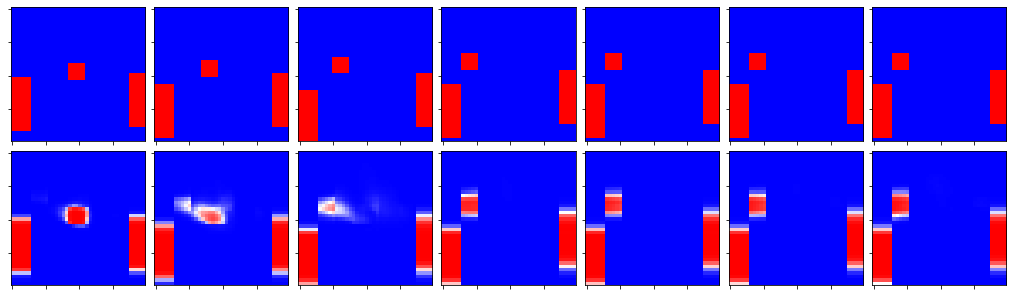

Epoch 393/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1058 - mean_squared_error: 0.0286 - acc: 0.9633 - val_loss: 0.1096 - val_mean_squared_error: 0.0294 - val_acc: 0.9624


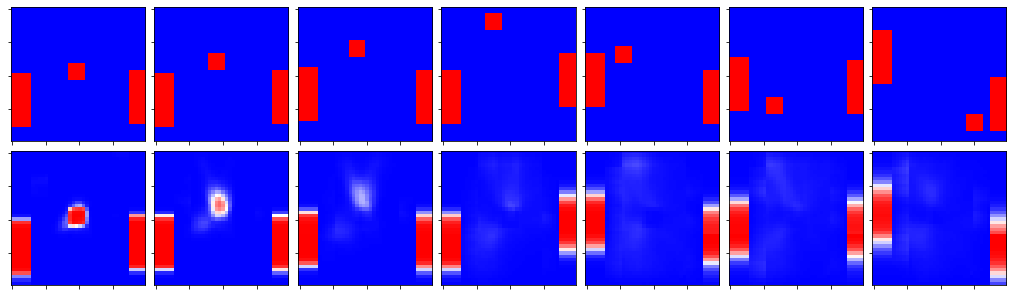

Epoch 394/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.1051 - mean_squared_error: 0.0286 - acc: 0.9631 - val_loss: 0.0998 - val_mean_squared_error: 0.0272 - val_acc: 0.9655


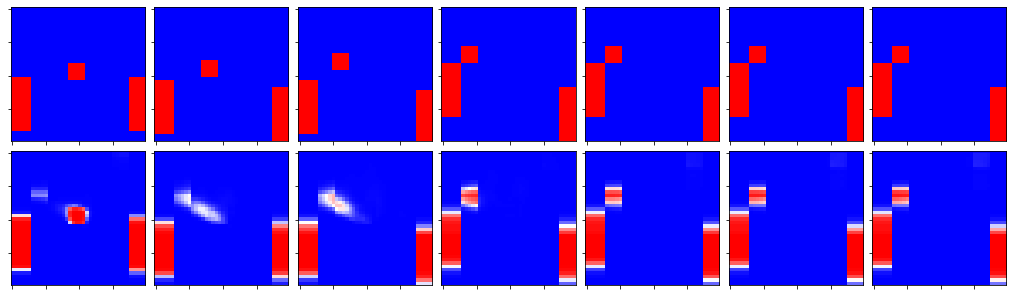

Epoch 395/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.1051 - mean_squared_error: 0.0284 - acc: 0.9635 - val_loss: 0.0940 - val_mean_squared_error: 0.0254 - val_acc: 0.9674


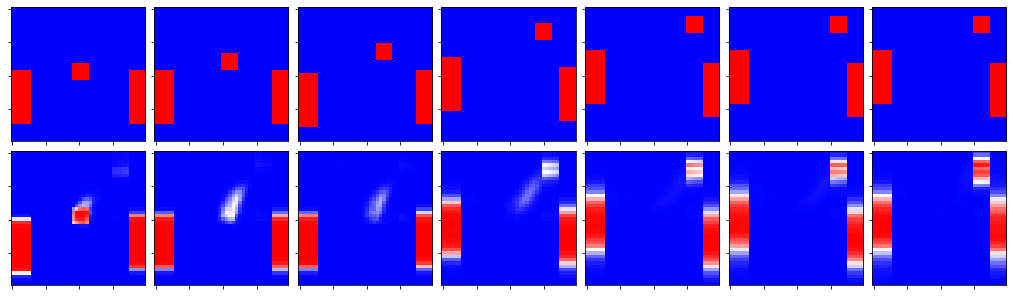

Epoch 396/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.1034 - mean_squared_error: 0.0280 - acc: 0.9640 - val_loss: 0.1020 - val_mean_squared_error: 0.0274 - val_acc: 0.9653


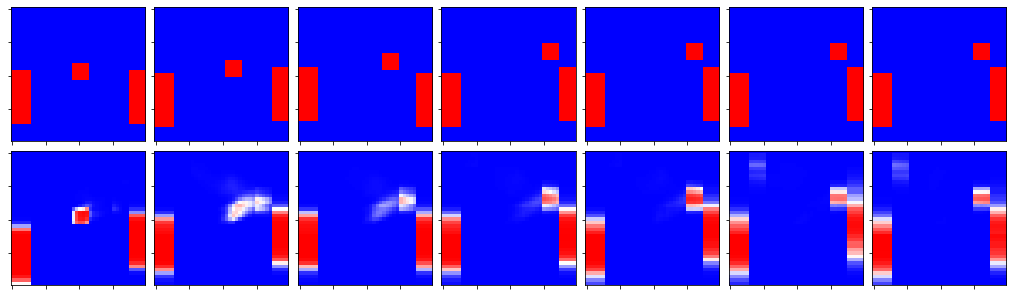

Epoch 397/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1057 - mean_squared_error: 0.0285 - acc: 0.9634 - val_loss: 0.0993 - val_mean_squared_error: 0.0264 - val_acc: 0.9666


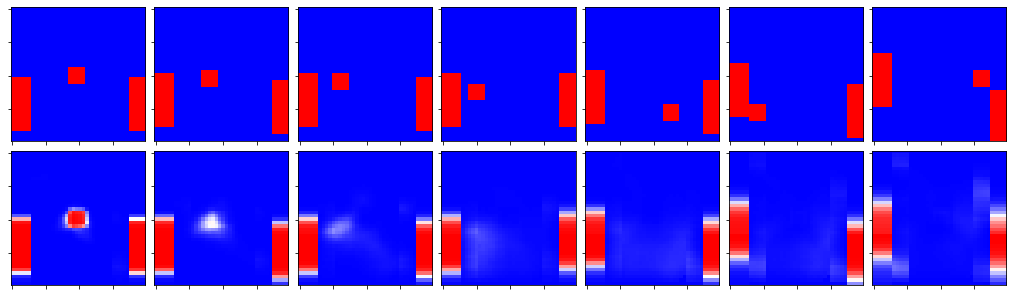

Epoch 398/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1045 - mean_squared_error: 0.0282 - acc: 0.9638 - val_loss: 0.1014 - val_mean_squared_error: 0.0279 - val_acc: 0.9637


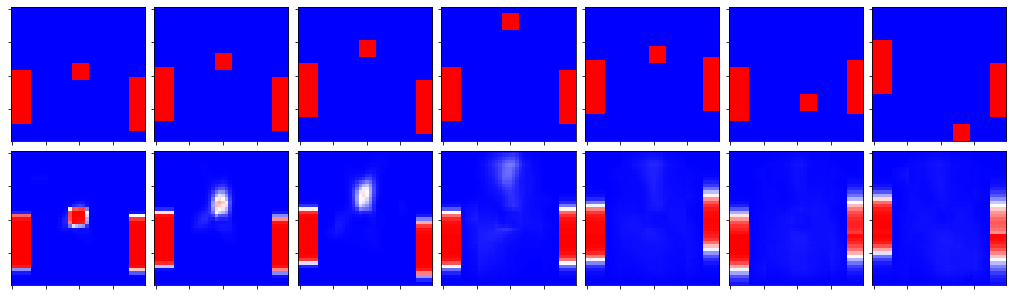

Epoch 399/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.1044 - mean_squared_error: 0.0282 - acc: 0.9638 - val_loss: 0.0965 - val_mean_squared_error: 0.0265 - val_acc: 0.9654


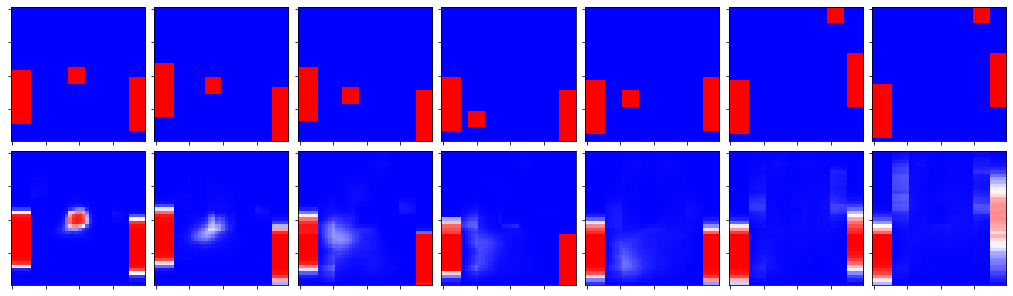

Epoch 400/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1021 - mean_squared_error: 0.0276 - acc: 0.9646 - val_loss: 0.0928 - val_mean_squared_error: 0.0255 - val_acc: 0.9672


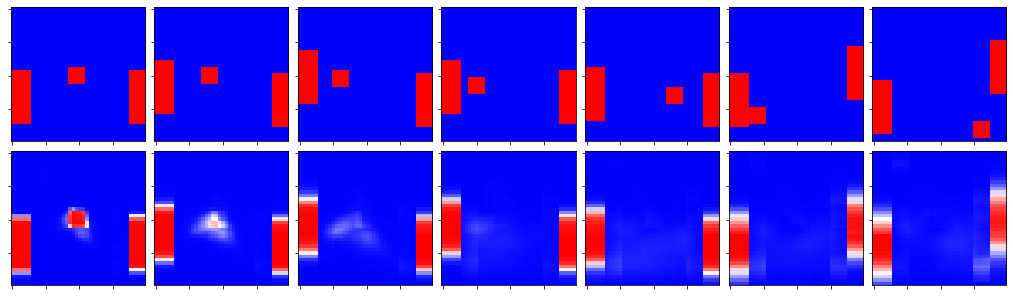

Epoch 401/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1039 - mean_squared_error: 0.0280 - acc: 0.9641 - val_loss: 0.0989 - val_mean_squared_error: 0.0264 - val_acc: 0.9665


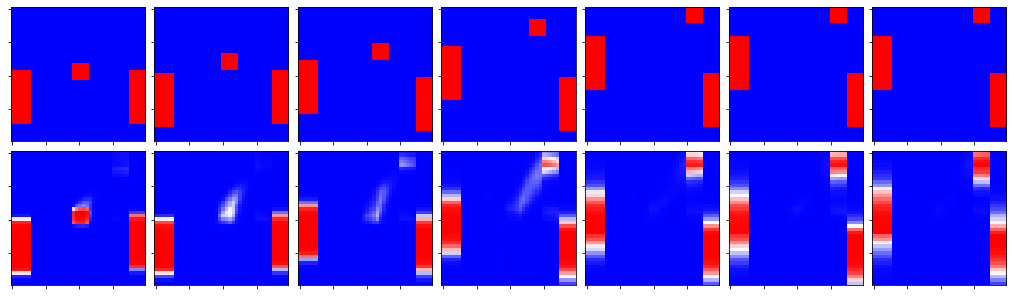

Epoch 402/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1015 - mean_squared_error: 0.0274 - acc: 0.9649 - val_loss: 0.1089 - val_mean_squared_error: 0.0291 - val_acc: 0.9626


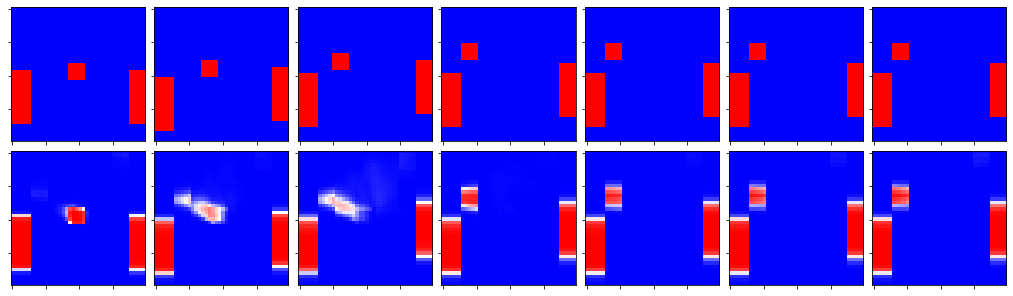

Epoch 403/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.1017 - mean_squared_error: 0.0274 - acc: 0.9648 - val_loss: 0.1079 - val_mean_squared_error: 0.0296 - val_acc: 0.9613


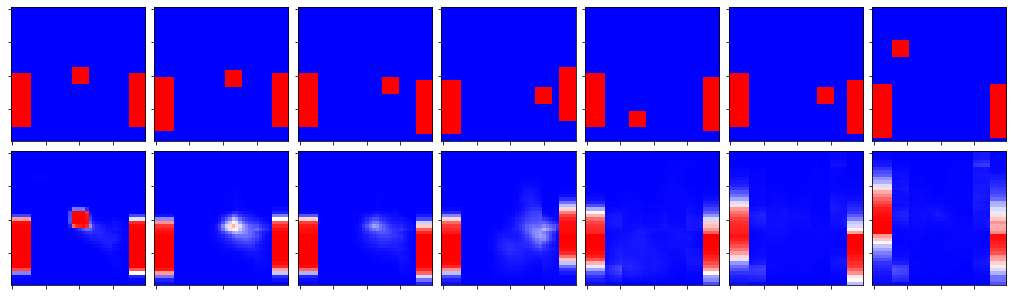

Epoch 404/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.1284 - mean_squared_error: 0.0344 - acc: 0.9557 - val_loss: 0.1047 - val_mean_squared_error: 0.0285 - val_acc: 0.9634


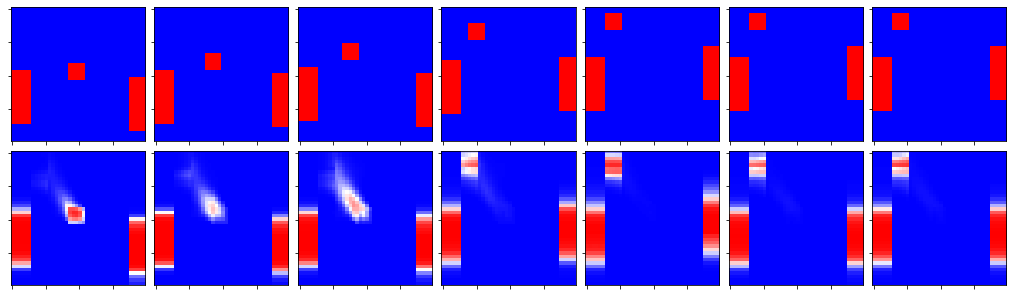

Epoch 405/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.1110 - mean_squared_error: 0.0301 - acc: 0.9615 - val_loss: 0.1099 - val_mean_squared_error: 0.0297 - val_acc: 0.9620


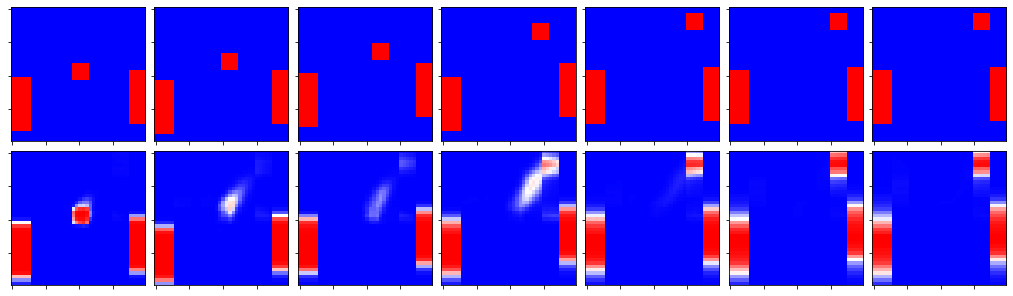

Epoch 406/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1066 - mean_squared_error: 0.0288 - acc: 0.9632 - val_loss: 0.1063 - val_mean_squared_error: 0.0284 - val_acc: 0.9641


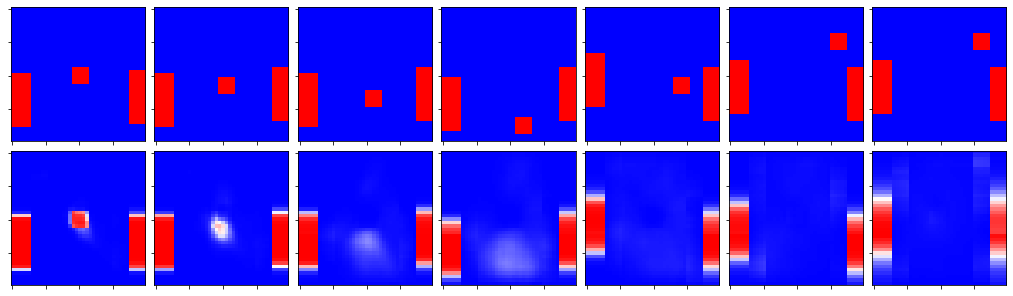

Epoch 407/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1100 - mean_squared_error: 0.0296 - acc: 0.9621 - val_loss: 0.1078 - val_mean_squared_error: 0.0290 - val_acc: 0.9632


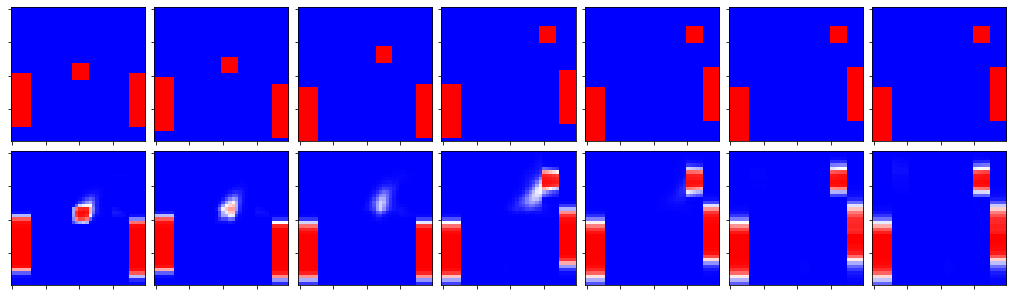

Epoch 408/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1059 - mean_squared_error: 0.0285 - acc: 0.9636 - val_loss: 0.0992 - val_mean_squared_error: 0.0268 - val_acc: 0.9657


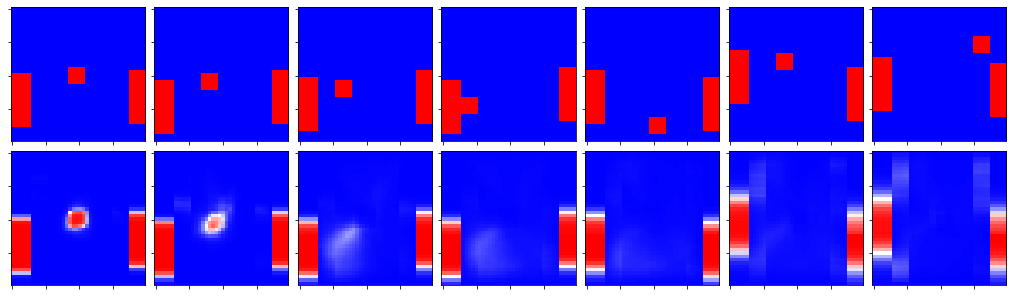

Epoch 409/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1048 - mean_squared_error: 0.0283 - acc: 0.9638 - val_loss: 0.0999 - val_mean_squared_error: 0.0269 - val_acc: 0.9657


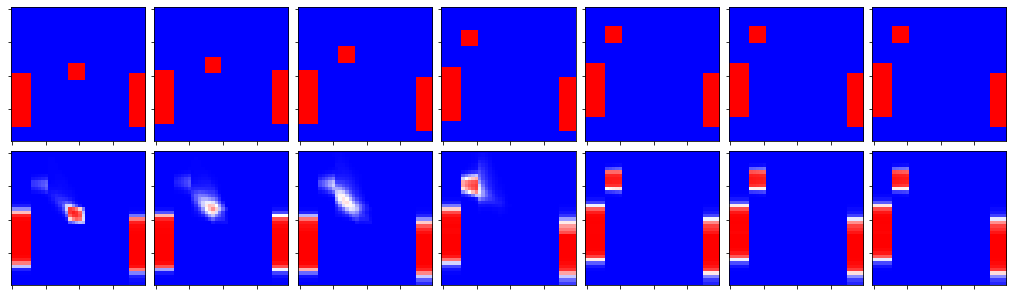

Epoch 410/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.1041 - mean_squared_error: 0.0281 - acc: 0.9640 - val_loss: 0.1070 - val_mean_squared_error: 0.0289 - val_acc: 0.9633


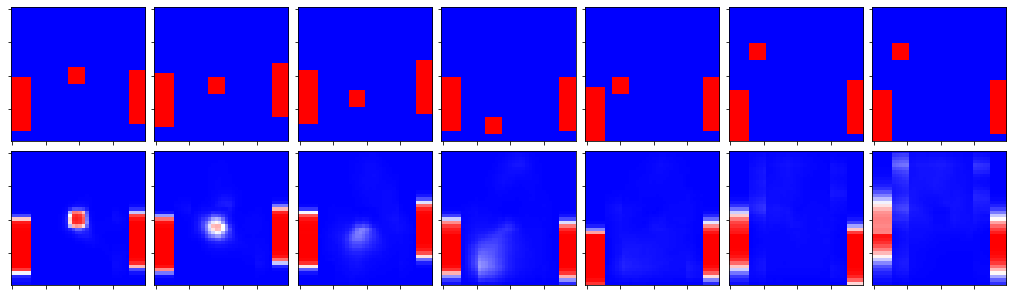

Epoch 411/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.1025 - mean_squared_error: 0.0276 - acc: 0.9647 - val_loss: 0.0934 - val_mean_squared_error: 0.0251 - val_acc: 0.9677


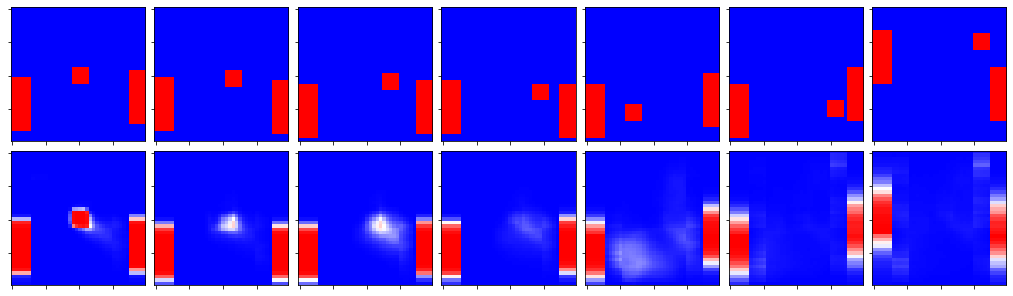

Epoch 412/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1008 - mean_squared_error: 0.0273 - acc: 0.9650 - val_loss: 0.1123 - val_mean_squared_error: 0.0304 - val_acc: 0.9616


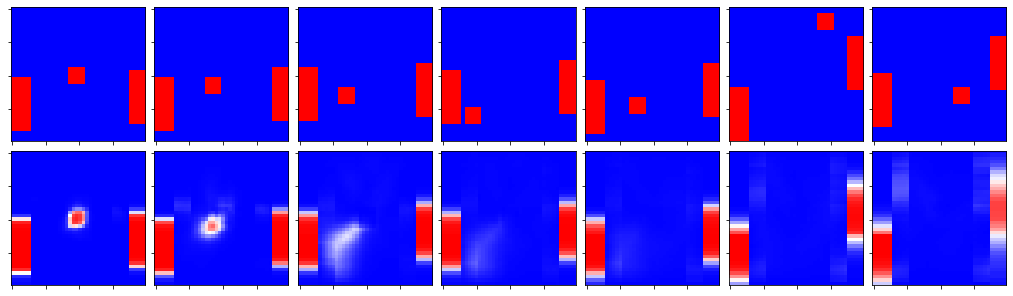

Epoch 413/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.1013 - mean_squared_error: 0.0273 - acc: 0.9652 - val_loss: 0.1067 - val_mean_squared_error: 0.0284 - val_acc: 0.9643


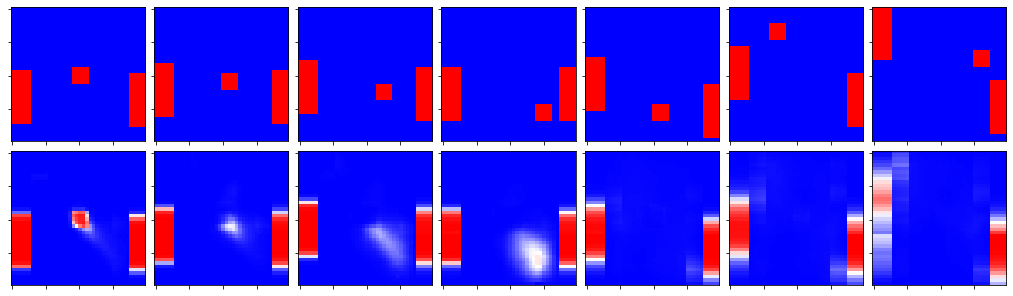

Epoch 414/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1026 - mean_squared_error: 0.0277 - acc: 0.9645 - val_loss: 0.0953 - val_mean_squared_error: 0.0261 - val_acc: 0.9663


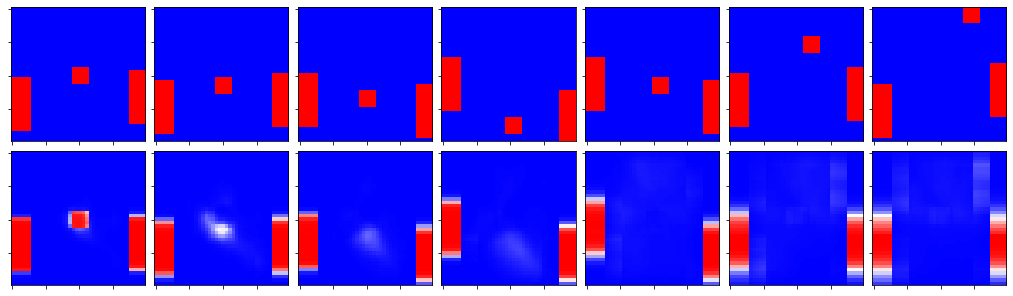

Epoch 415/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1018 - mean_squared_error: 0.0275 - acc: 0.9649 - val_loss: 0.0958 - val_mean_squared_error: 0.0252 - val_acc: 0.9684


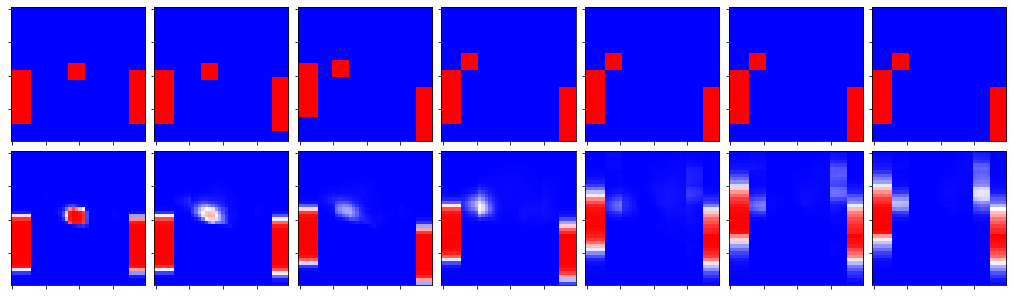

Epoch 416/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1991 - mean_squared_error: 0.0497 - acc: 0.9369 - val_loss: 0.1587 - val_mean_squared_error: 0.0437 - val_acc: 0.9432


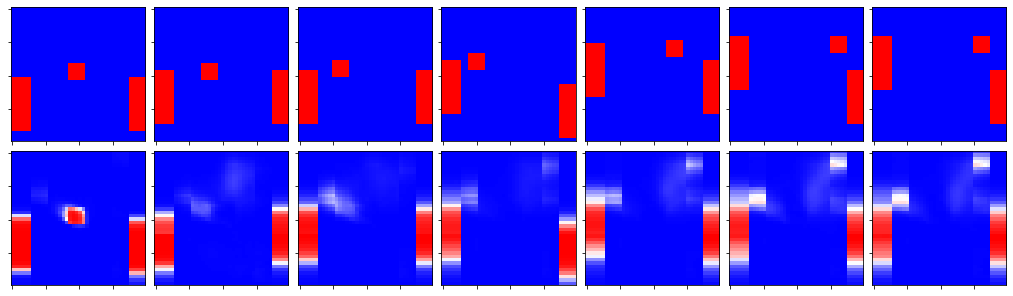

Epoch 417/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.1527 - mean_squared_error: 0.0417 - acc: 0.9458 - val_loss: 0.1394 - val_mean_squared_error: 0.0383 - val_acc: 0.9502


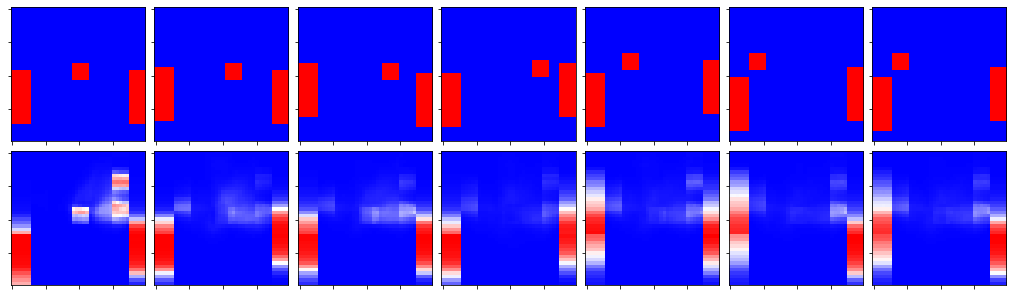

Epoch 418/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1377 - mean_squared_error: 0.0376 - acc: 0.9514 - val_loss: 0.1303 - val_mean_squared_error: 0.0353 - val_acc: 0.9544


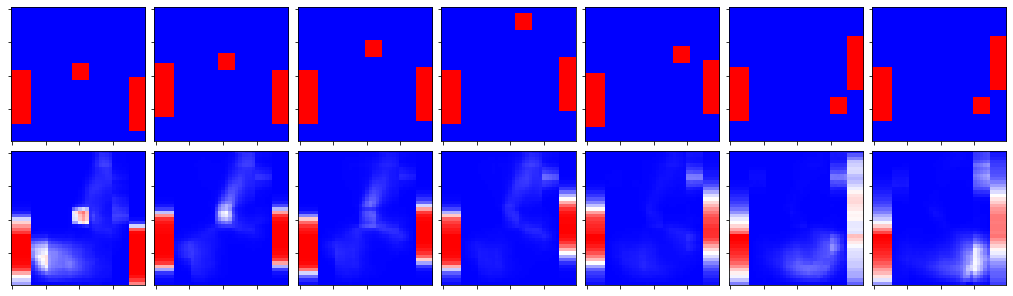

Epoch 419/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.1322 - mean_squared_error: 0.0359 - acc: 0.9536 - val_loss: 0.1290 - val_mean_squared_error: 0.0352 - val_acc: 0.9546


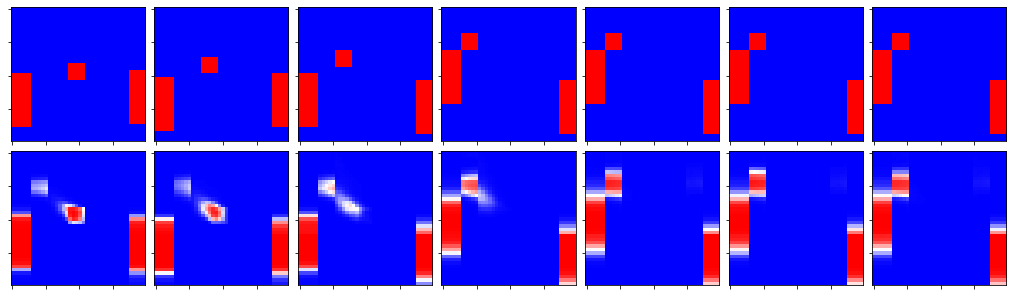

Epoch 420/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1259 - mean_squared_error: 0.0341 - acc: 0.9561 - val_loss: 0.1257 - val_mean_squared_error: 0.0344 - val_acc: 0.9553


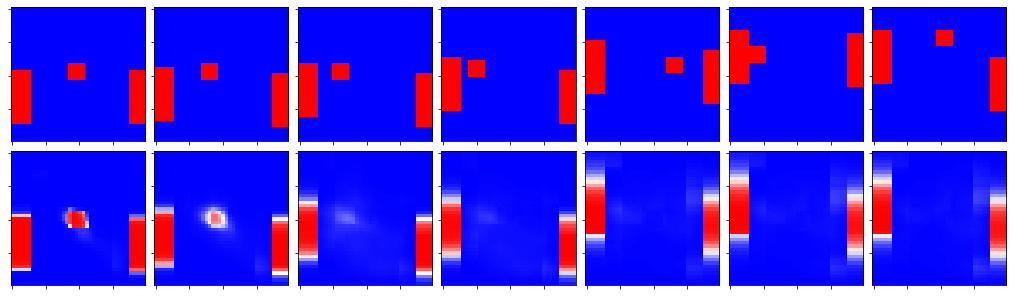

Epoch 421/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1210 - mean_squared_error: 0.0326 - acc: 0.9583 - val_loss: 0.1165 - val_mean_squared_error: 0.0314 - val_acc: 0.9600


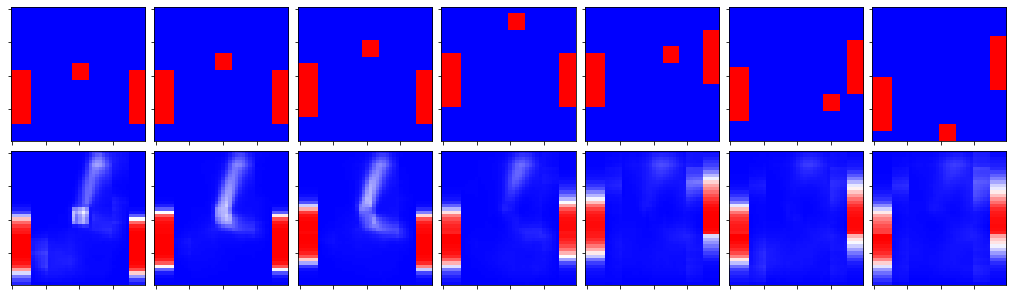

Epoch 422/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.1179 - mean_squared_error: 0.0317 - acc: 0.9595 - val_loss: 0.1154 - val_mean_squared_error: 0.0313 - val_acc: 0.9597


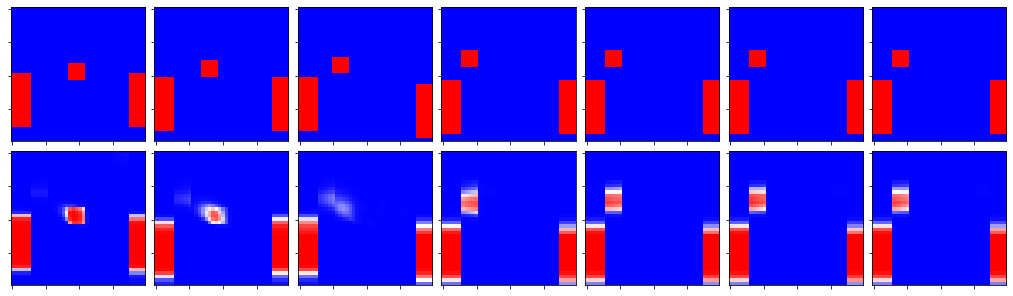

Epoch 423/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.1173 - mean_squared_error: 0.0315 - acc: 0.9598 - val_loss: 0.1040 - val_mean_squared_error: 0.0283 - val_acc: 0.9639


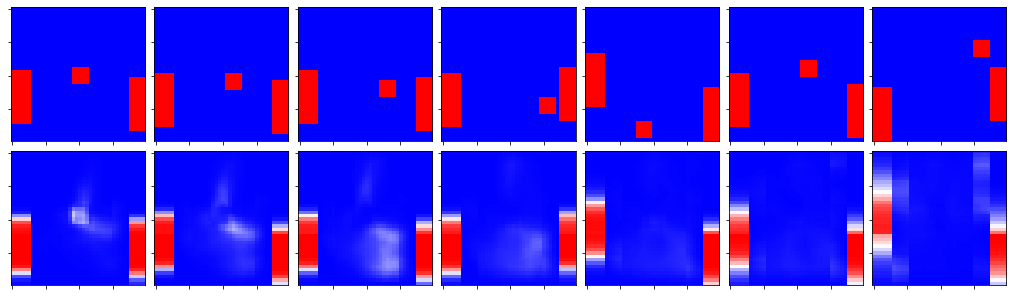

Epoch 424/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1142 - mean_squared_error: 0.0305 - acc: 0.9612 - val_loss: 0.1159 - val_mean_squared_error: 0.0313 - val_acc: 0.9597


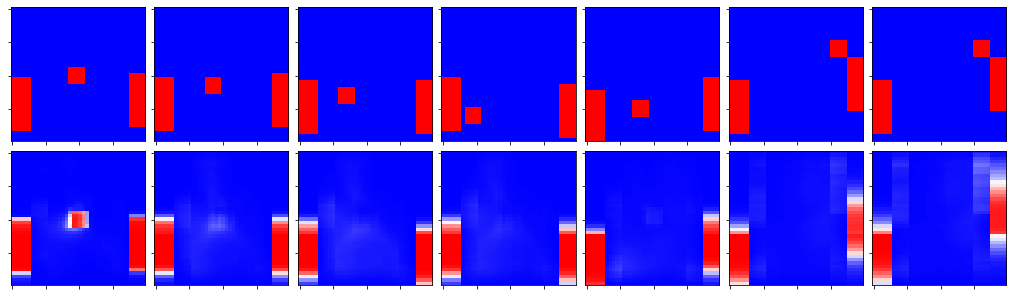

Epoch 425/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1141 - mean_squared_error: 0.0306 - acc: 0.9612 - val_loss: 0.1090 - val_mean_squared_error: 0.0295 - val_acc: 0.9622


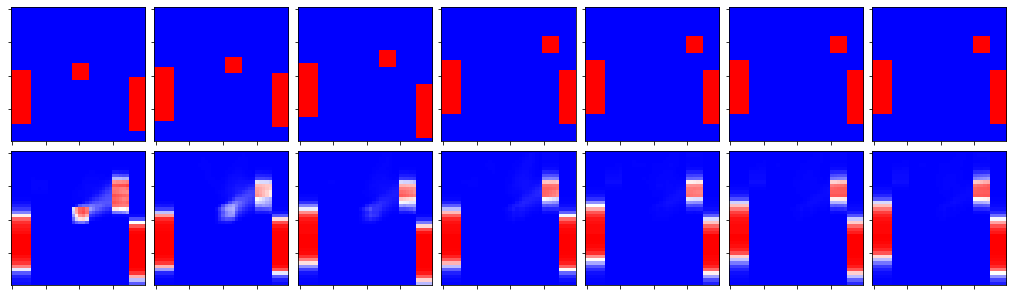

Epoch 426/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.1120 - mean_squared_error: 0.0300 - acc: 0.9619 - val_loss: 0.1089 - val_mean_squared_error: 0.0296 - val_acc: 0.9623


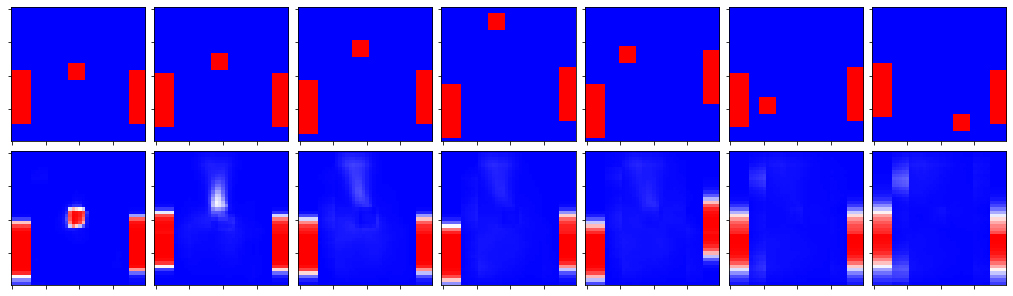

Epoch 427/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1113 - mean_squared_error: 0.0298 - acc: 0.9622 - val_loss: 0.1122 - val_mean_squared_error: 0.0300 - val_acc: 0.9619


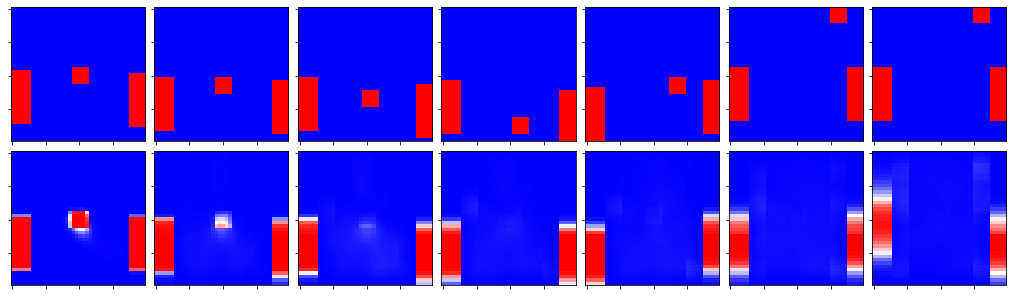

Epoch 428/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1098 - mean_squared_error: 0.0293 - acc: 0.9629 - val_loss: 0.1145 - val_mean_squared_error: 0.0302 - val_acc: 0.9622


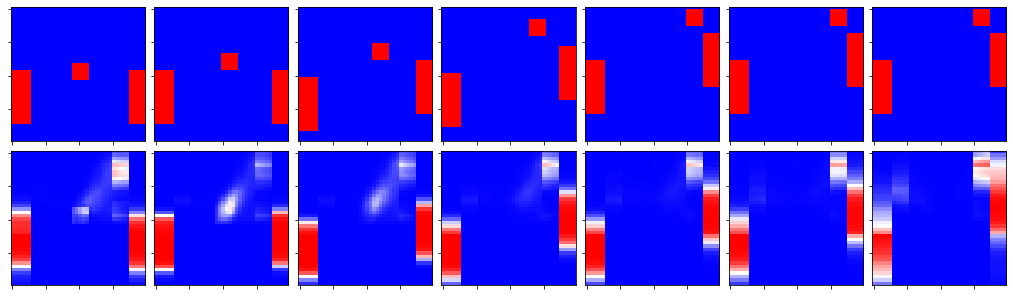

Epoch 429/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.1096 - mean_squared_error: 0.0293 - acc: 0.9630 - val_loss: 0.1062 - val_mean_squared_error: 0.0282 - val_acc: 0.9644


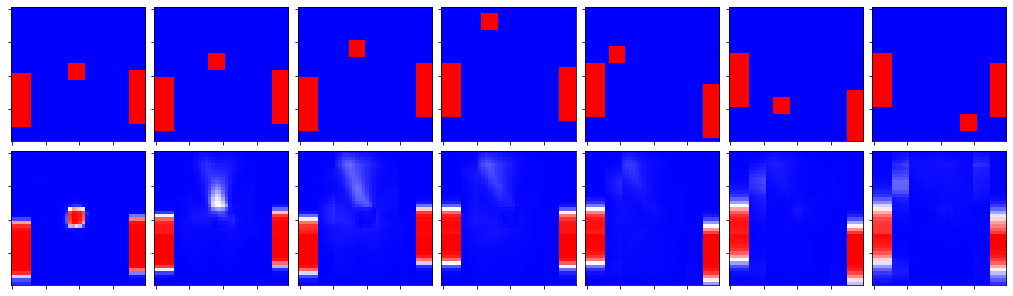

Epoch 430/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1075 - mean_squared_error: 0.0287 - acc: 0.9636 - val_loss: 0.1173 - val_mean_squared_error: 0.0310 - val_acc: 0.9609


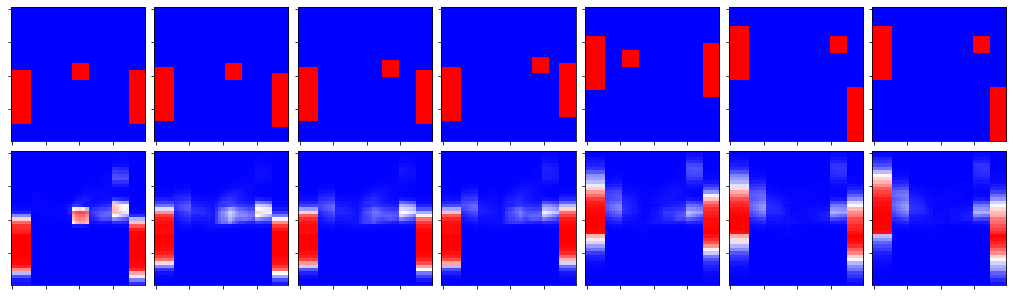

Epoch 431/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1078 - mean_squared_error: 0.0289 - acc: 0.9634 - val_loss: 0.1082 - val_mean_squared_error: 0.0291 - val_acc: 0.9631


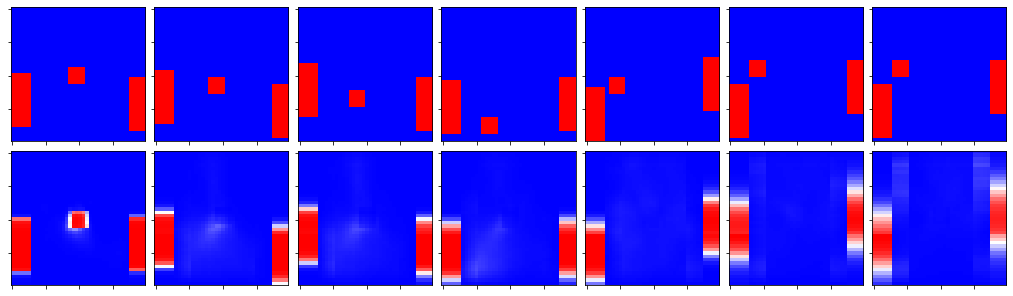

Epoch 432/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.1082 - mean_squared_error: 0.0289 - acc: 0.9634 - val_loss: 0.1136 - val_mean_squared_error: 0.0295 - val_acc: 0.9633


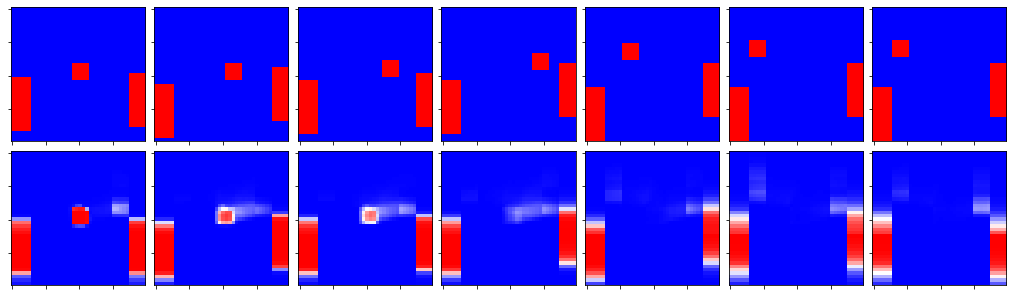

Epoch 433/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1062 - mean_squared_error: 0.0285 - acc: 0.9639 - val_loss: 0.1013 - val_mean_squared_error: 0.0277 - val_acc: 0.9641


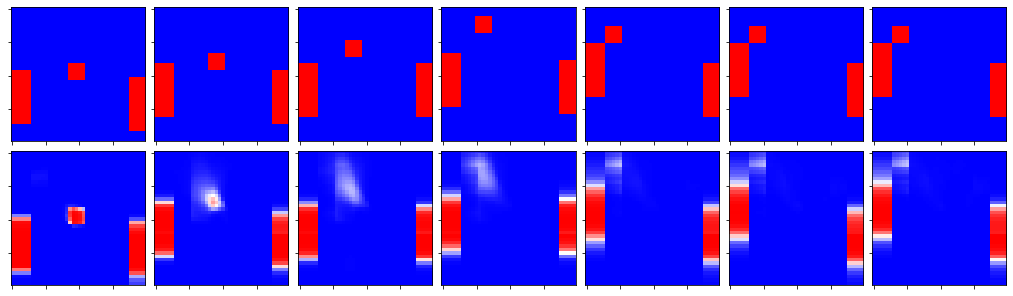

Epoch 434/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1058 - mean_squared_error: 0.0284 - acc: 0.9641 - val_loss: 0.1050 - val_mean_squared_error: 0.0282 - val_acc: 0.9642


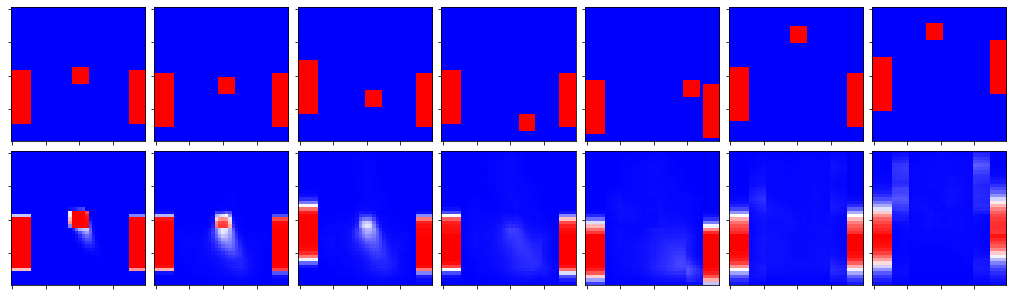

Epoch 435/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1064 - mean_squared_error: 0.0286 - acc: 0.9635 - val_loss: 0.1048 - val_mean_squared_error: 0.0286 - val_acc: 0.9632


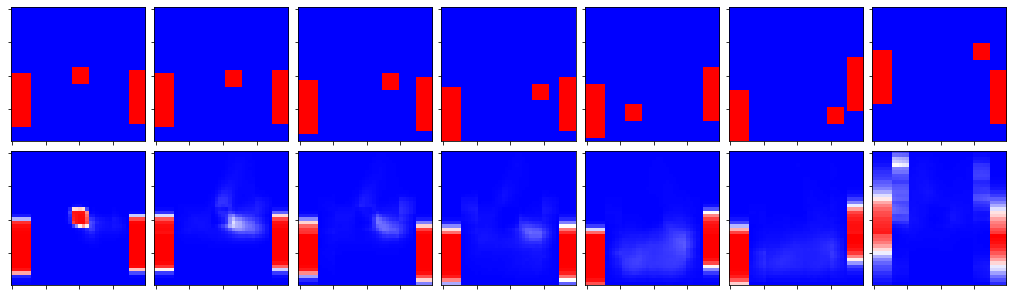

Epoch 436/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1068 - mean_squared_error: 0.0286 - acc: 0.9638 - val_loss: 0.1011 - val_mean_squared_error: 0.0265 - val_acc: 0.9672


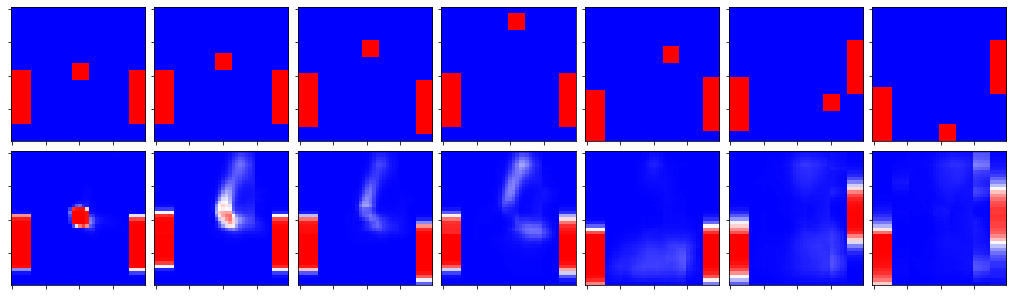

Epoch 437/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.1038 - mean_squared_error: 0.0278 - acc: 0.9648 - val_loss: 0.0996 - val_mean_squared_error: 0.0269 - val_acc: 0.9657


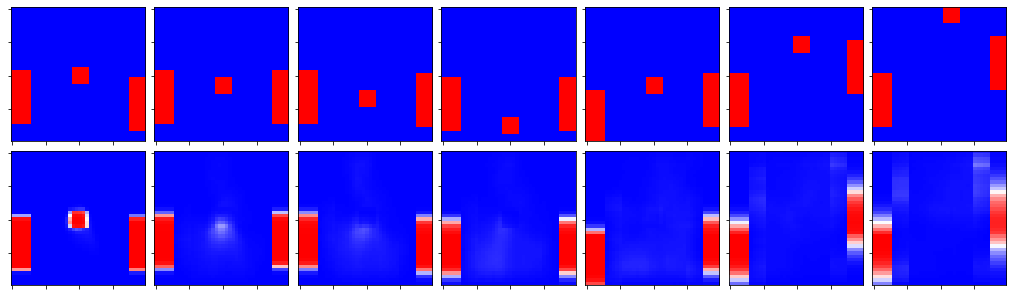

Epoch 438/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1016 - mean_squared_error: 0.0271 - acc: 0.9657 - val_loss: 0.1061 - val_mean_squared_error: 0.0286 - val_acc: 0.9637


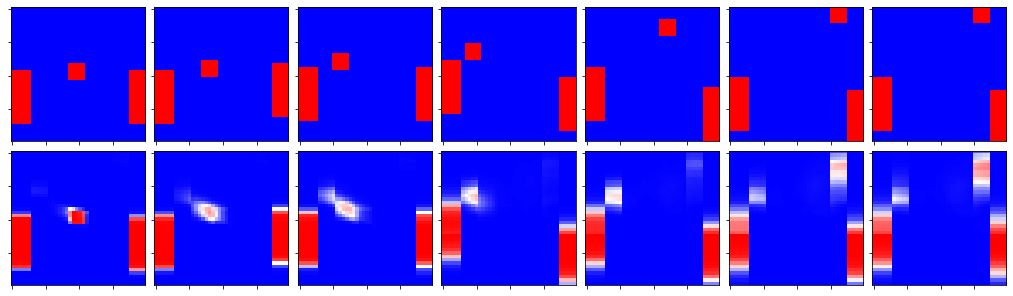

Epoch 439/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1013 - mean_squared_error: 0.0271 - acc: 0.9657 - val_loss: 0.1110 - val_mean_squared_error: 0.0300 - val_acc: 0.9616


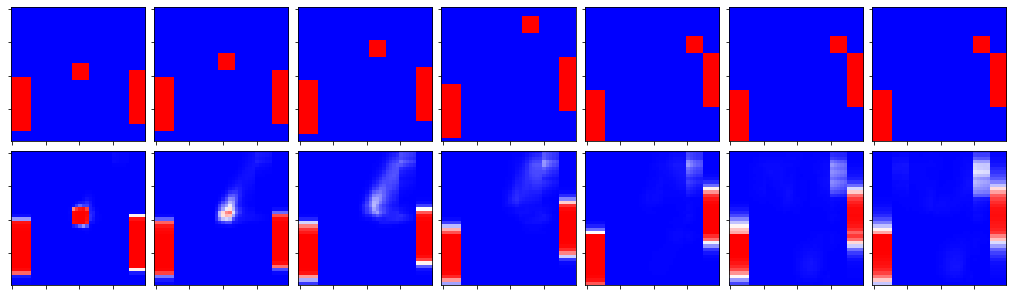

Epoch 440/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.1014 - mean_squared_error: 0.0271 - acc: 0.9658 - val_loss: 0.1010 - val_mean_squared_error: 0.0266 - val_acc: 0.9668


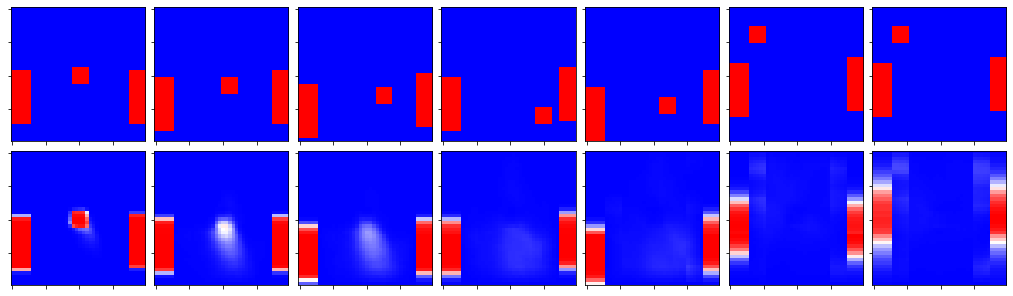

Epoch 441/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1015 - mean_squared_error: 0.0271 - acc: 0.9658 - val_loss: 0.1005 - val_mean_squared_error: 0.0266 - val_acc: 0.9665


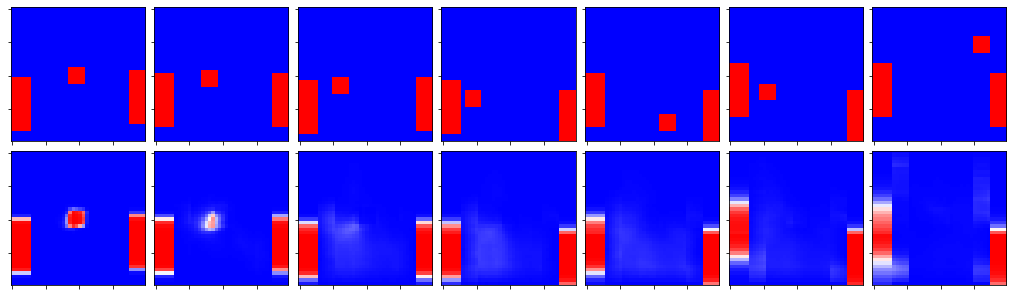

Epoch 442/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0988 - mean_squared_error: 0.0266 - acc: 0.9662 - val_loss: 0.0932 - val_mean_squared_error: 0.0251 - val_acc: 0.9683


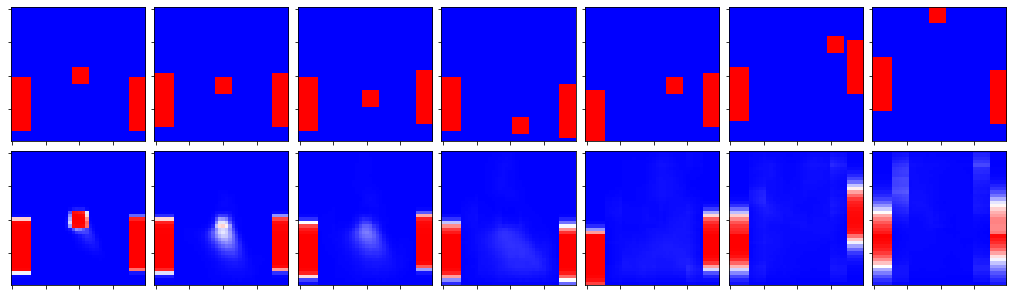

Epoch 443/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0988 - mean_squared_error: 0.0264 - acc: 0.9666 - val_loss: 0.1014 - val_mean_squared_error: 0.0270 - val_acc: 0.9661


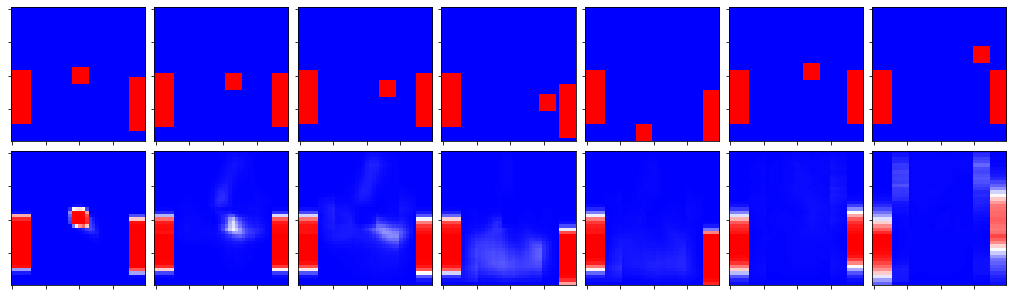

Epoch 444/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0976 - mean_squared_error: 0.0261 - acc: 0.9670 - val_loss: 0.0914 - val_mean_squared_error: 0.0248 - val_acc: 0.9683


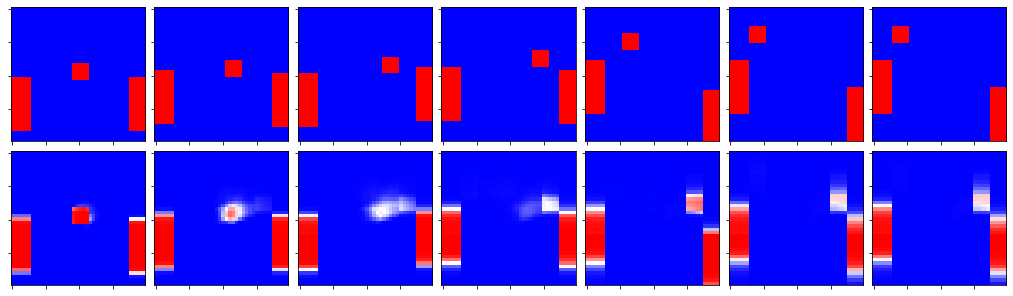

Epoch 445/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0994 - mean_squared_error: 0.0266 - acc: 0.9663 - val_loss: 0.0989 - val_mean_squared_error: 0.0270 - val_acc: 0.9651


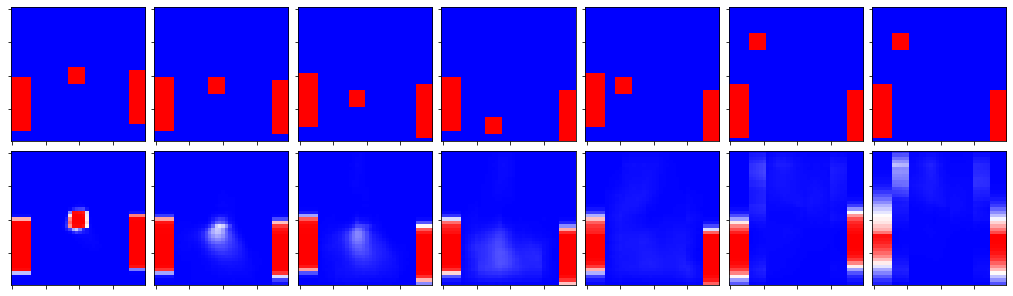

Epoch 446/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0995 - mean_squared_error: 0.0266 - acc: 0.9664 - val_loss: 0.1061 - val_mean_squared_error: 0.0280 - val_acc: 0.9651


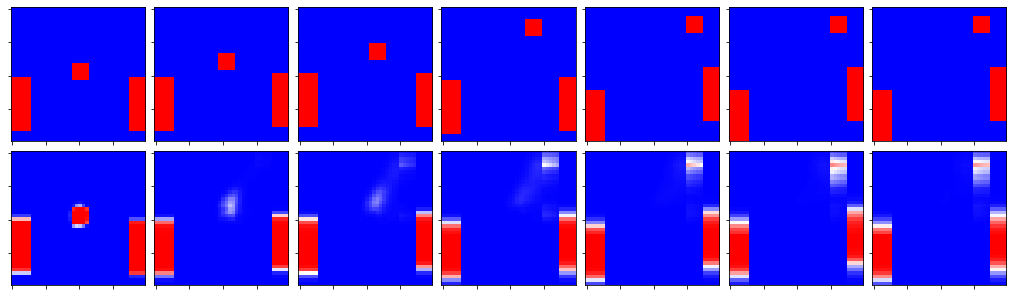

Epoch 447/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.0977 - mean_squared_error: 0.0262 - acc: 0.9668 - val_loss: 0.0961 - val_mean_squared_error: 0.0263 - val_acc: 0.9657


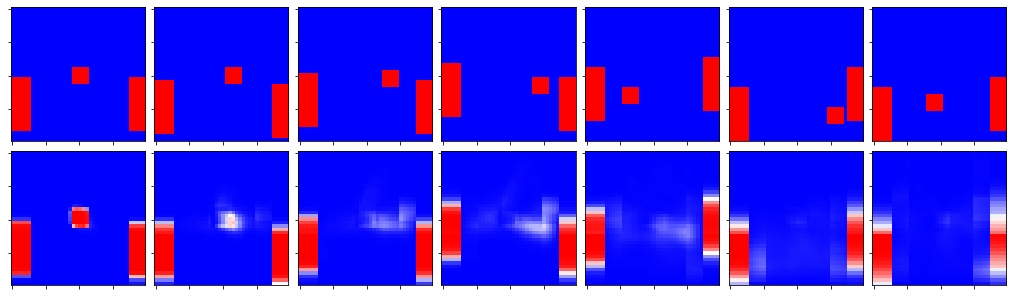

Epoch 448/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1003 - mean_squared_error: 0.0269 - acc: 0.9657 - val_loss: 0.0897 - val_mean_squared_error: 0.0245 - val_acc: 0.9685


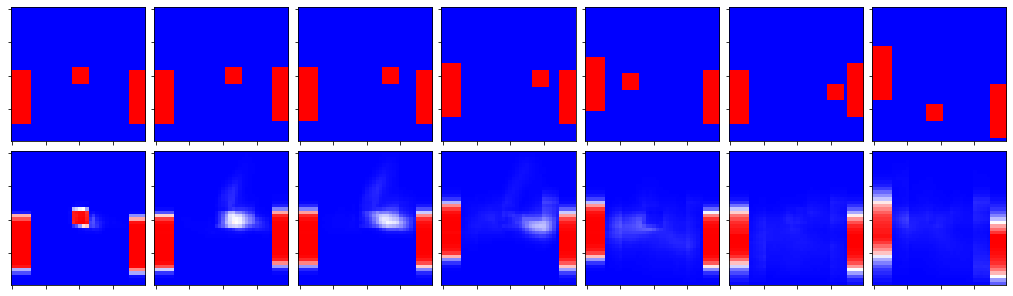

Epoch 449/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0995 - mean_squared_error: 0.0265 - acc: 0.9665 - val_loss: 0.1087 - val_mean_squared_error: 0.0293 - val_acc: 0.9629


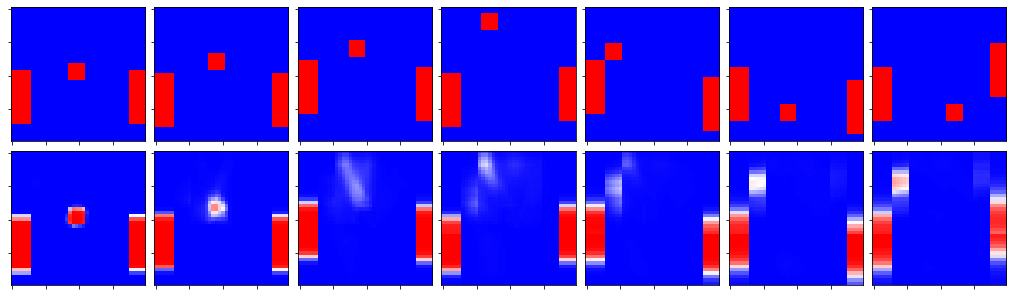

Epoch 450/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.0978 - mean_squared_error: 0.0261 - acc: 0.9670 - val_loss: 0.1017 - val_mean_squared_error: 0.0273 - val_acc: 0.9653


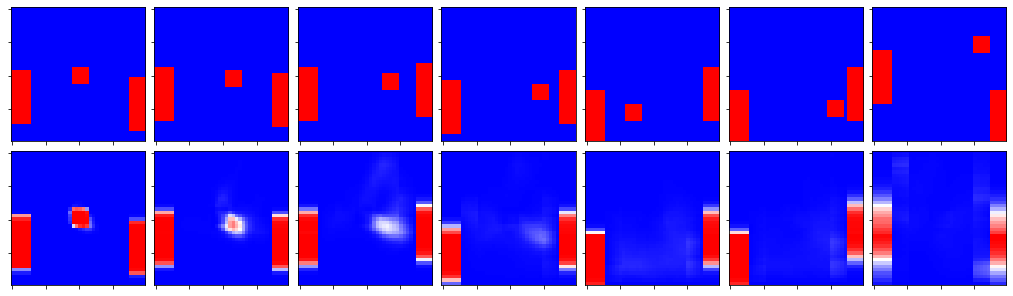

Epoch 451/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0964 - mean_squared_error: 0.0259 - acc: 0.9671 - val_loss: 0.1047 - val_mean_squared_error: 0.0285 - val_acc: 0.9639


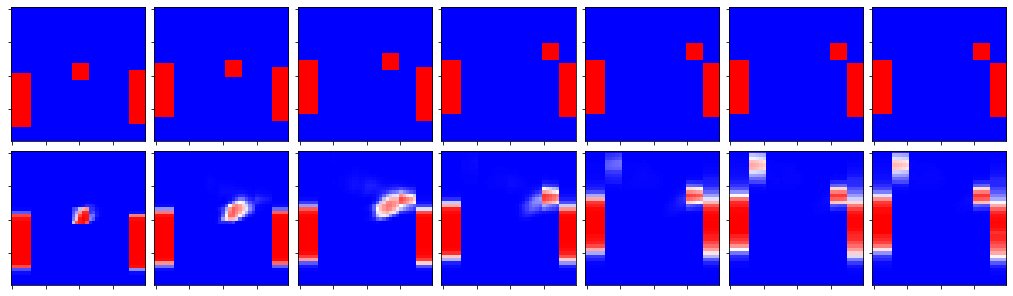

Epoch 452/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0978 - mean_squared_error: 0.0262 - acc: 0.9666 - val_loss: 0.0981 - val_mean_squared_error: 0.0261 - val_acc: 0.9665


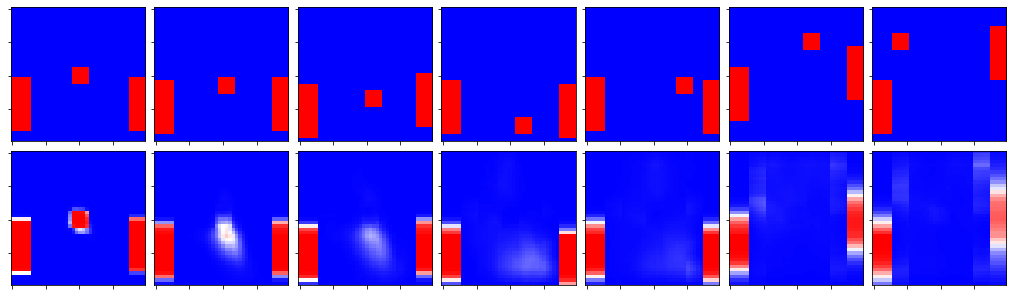

Epoch 453/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0972 - mean_squared_error: 0.0260 - acc: 0.9671 - val_loss: 0.0999 - val_mean_squared_error: 0.0269 - val_acc: 0.9656


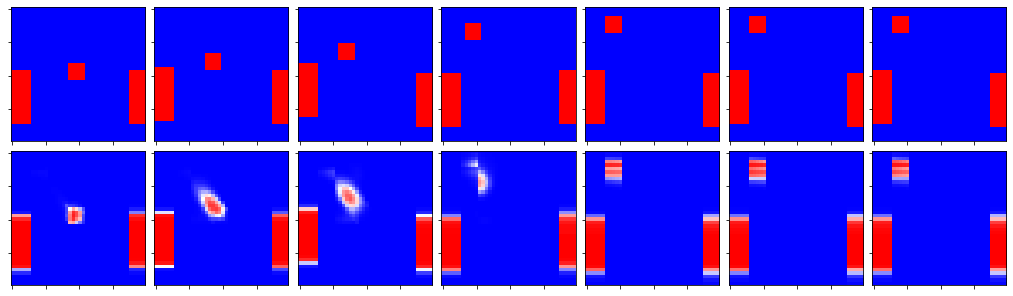

Epoch 454/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0960 - mean_squared_error: 0.0257 - acc: 0.9676 - val_loss: 0.1008 - val_mean_squared_error: 0.0274 - val_acc: 0.9649


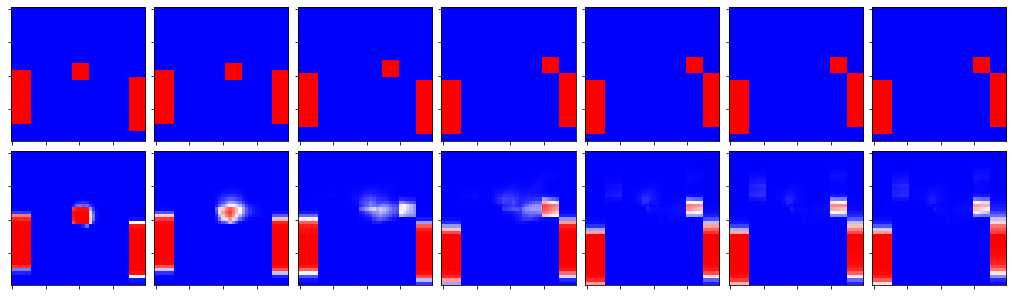

Epoch 455/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0947 - mean_squared_error: 0.0254 - acc: 0.9678 - val_loss: 0.0907 - val_mean_squared_error: 0.0243 - val_acc: 0.9693


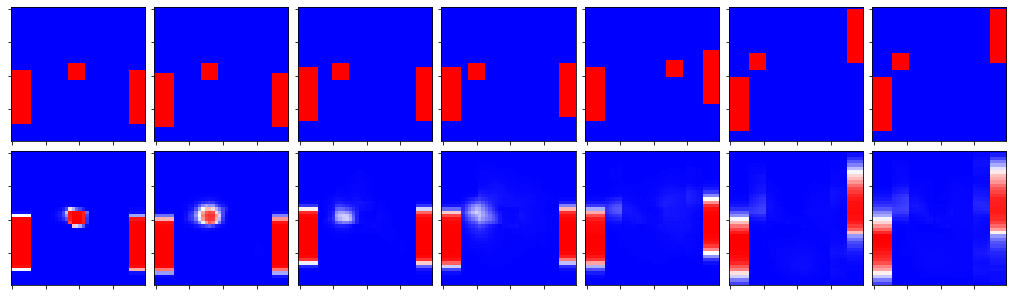

Epoch 456/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0951 - mean_squared_error: 0.0254 - acc: 0.9678 - val_loss: 0.0960 - val_mean_squared_error: 0.0259 - val_acc: 0.9670


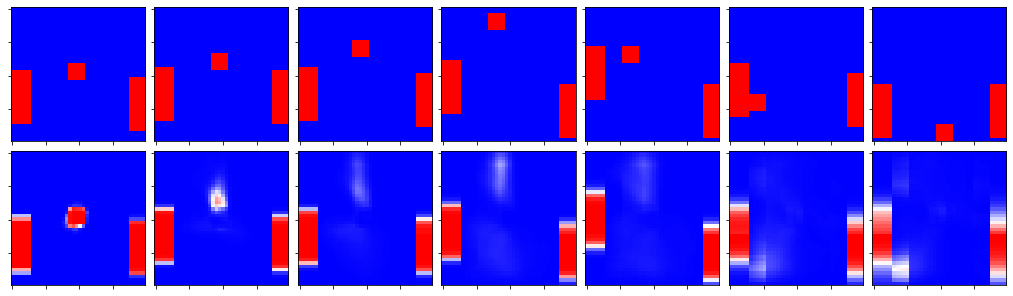

Epoch 457/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1020 - mean_squared_error: 0.0273 - acc: 0.9653 - val_loss: 0.1047 - val_mean_squared_error: 0.0282 - val_acc: 0.9645


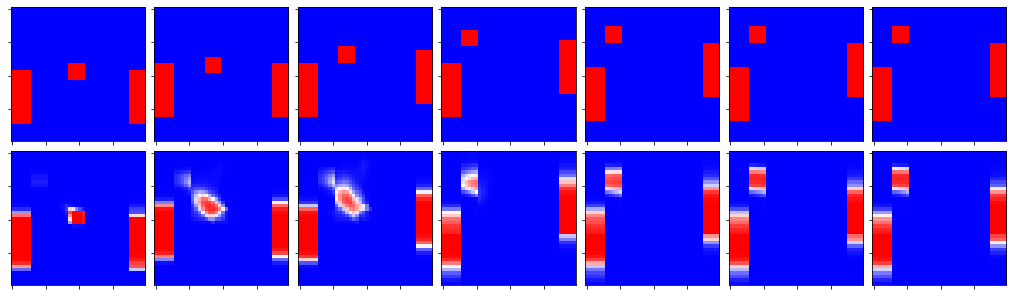

Epoch 458/2500
100/100 [==============================] - 51s 505ms/step - loss: 0.0980 - mean_squared_error: 0.0263 - acc: 0.9665 - val_loss: 0.0995 - val_mean_squared_error: 0.0259 - val_acc: 0.9670


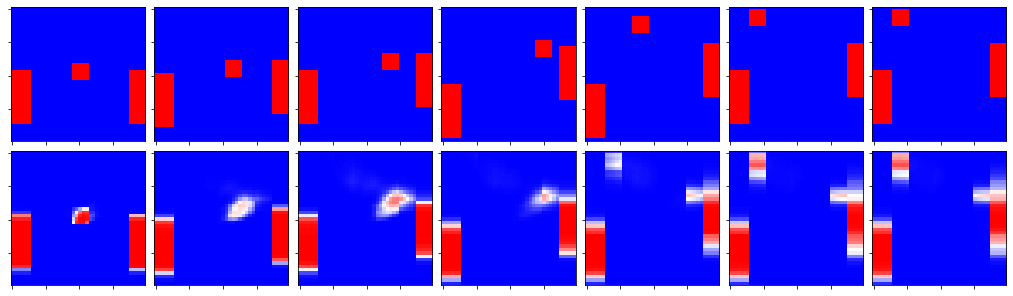

Epoch 459/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0969 - mean_squared_error: 0.0260 - acc: 0.9668 - val_loss: 0.0967 - val_mean_squared_error: 0.0263 - val_acc: 0.9664


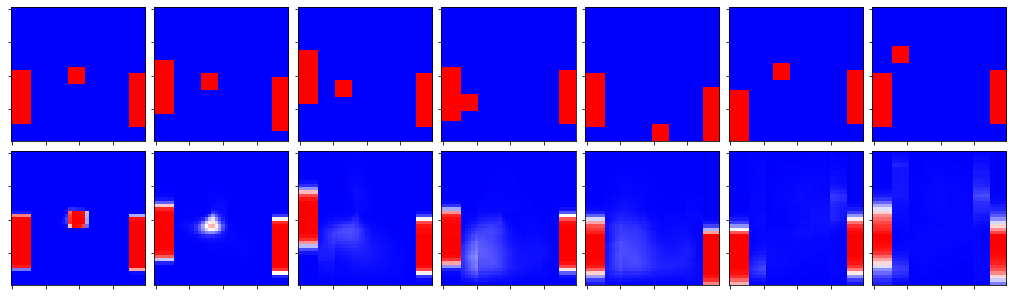

Epoch 460/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0947 - mean_squared_error: 0.0253 - acc: 0.9680 - val_loss: 0.0890 - val_mean_squared_error: 0.0236 - val_acc: 0.9705


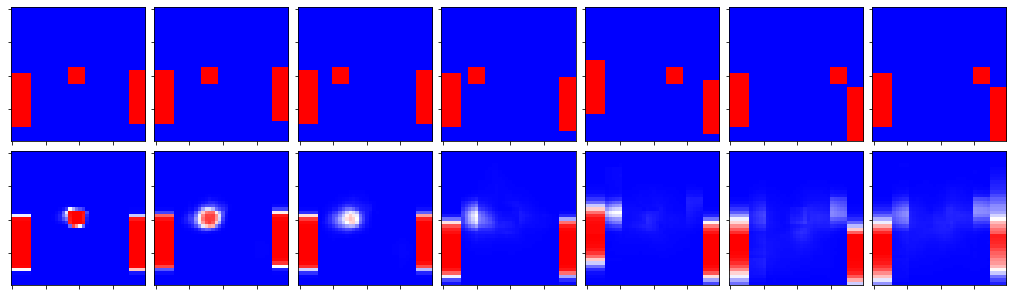

Epoch 461/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0947 - mean_squared_error: 0.0253 - acc: 0.9679 - val_loss: 0.1004 - val_mean_squared_error: 0.0270 - val_acc: 0.9656


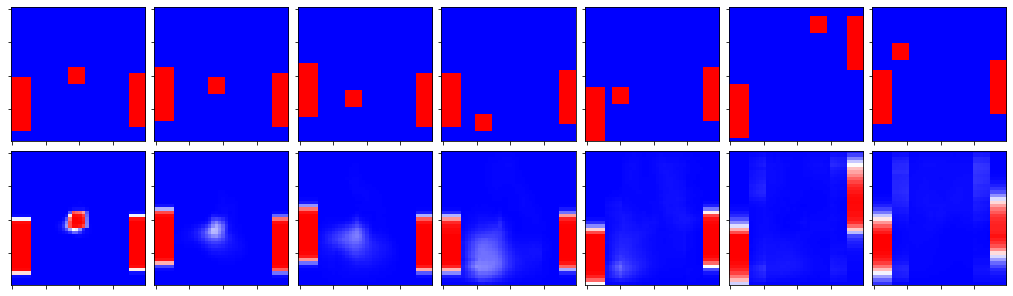

Epoch 462/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0953 - mean_squared_error: 0.0255 - acc: 0.9677 - val_loss: 0.1053 - val_mean_squared_error: 0.0287 - val_acc: 0.9631


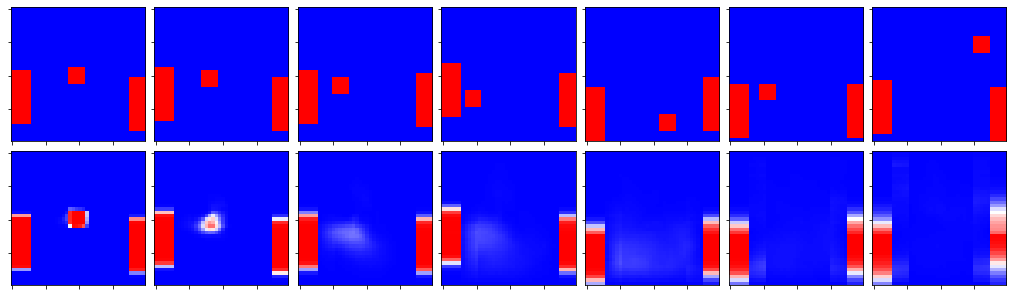

Epoch 463/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.0942 - mean_squared_error: 0.0253 - acc: 0.9679 - val_loss: 0.1060 - val_mean_squared_error: 0.0276 - val_acc: 0.9655


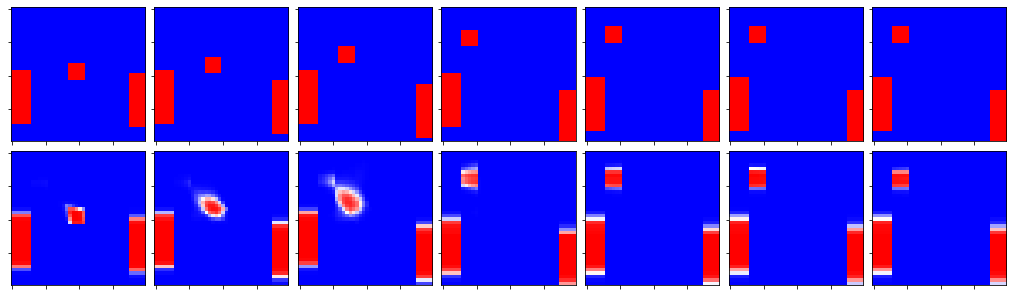

Epoch 464/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.0949 - mean_squared_error: 0.0254 - acc: 0.9678 - val_loss: 0.0958 - val_mean_squared_error: 0.0259 - val_acc: 0.9669


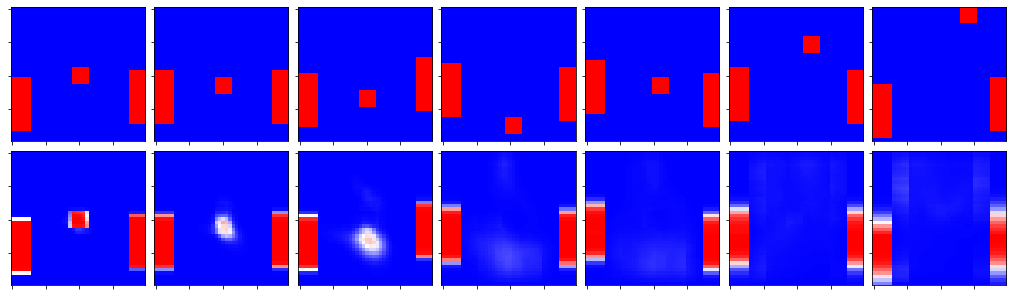

Epoch 465/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0936 - mean_squared_error: 0.0251 - acc: 0.9681 - val_loss: 0.0914 - val_mean_squared_error: 0.0239 - val_acc: 0.9701


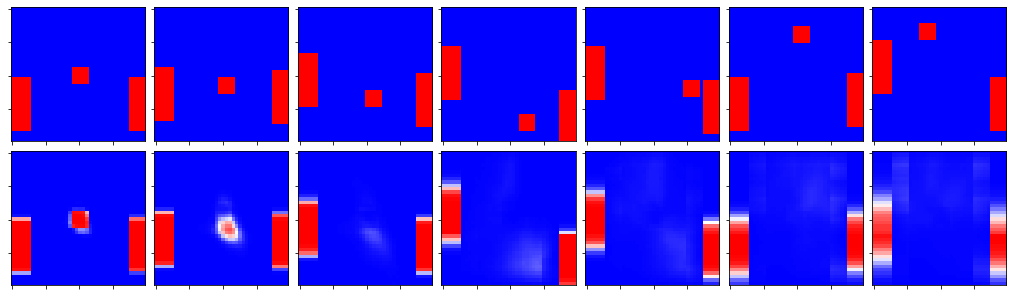

Epoch 466/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.0967 - mean_squared_error: 0.0257 - acc: 0.9674 - val_loss: 0.0913 - val_mean_squared_error: 0.0244 - val_acc: 0.9689


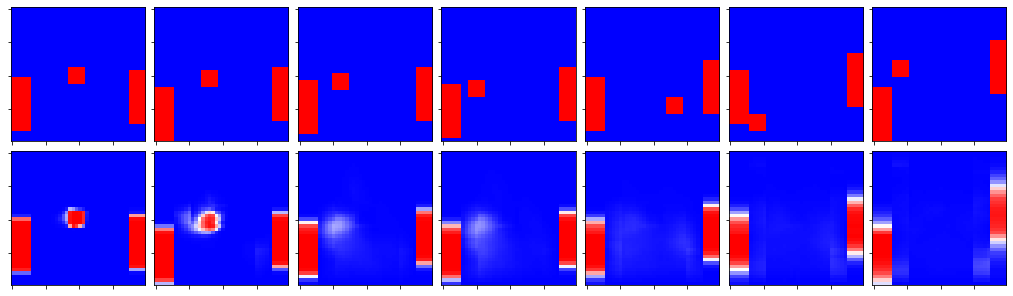

Epoch 467/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0931 - mean_squared_error: 0.0249 - acc: 0.9685 - val_loss: 0.0948 - val_mean_squared_error: 0.0255 - val_acc: 0.9674


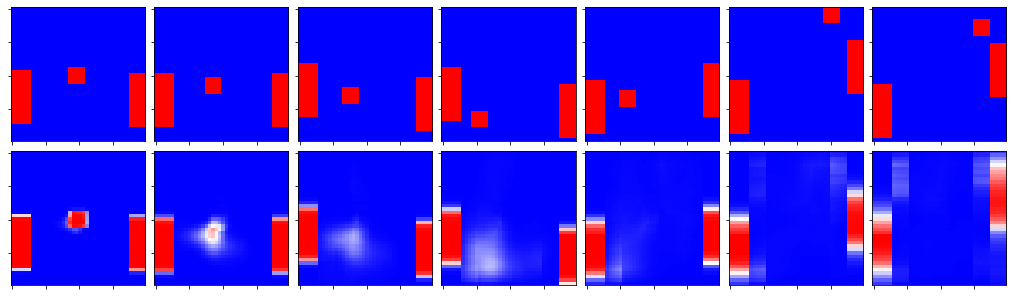

Epoch 468/2500
100/100 [==============================] - 51s 505ms/step - loss: 0.0924 - mean_squared_error: 0.0247 - acc: 0.9689 - val_loss: 0.0922 - val_mean_squared_error: 0.0247 - val_acc: 0.9687


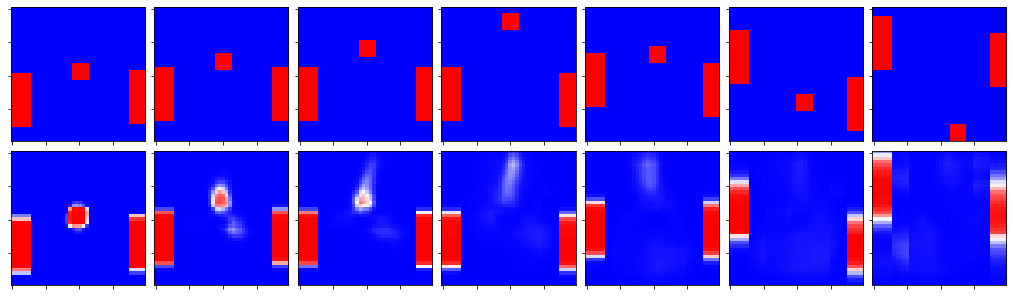

Epoch 469/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0937 - mean_squared_error: 0.0251 - acc: 0.9682 - val_loss: 0.0927 - val_mean_squared_error: 0.0253 - val_acc: 0.9672


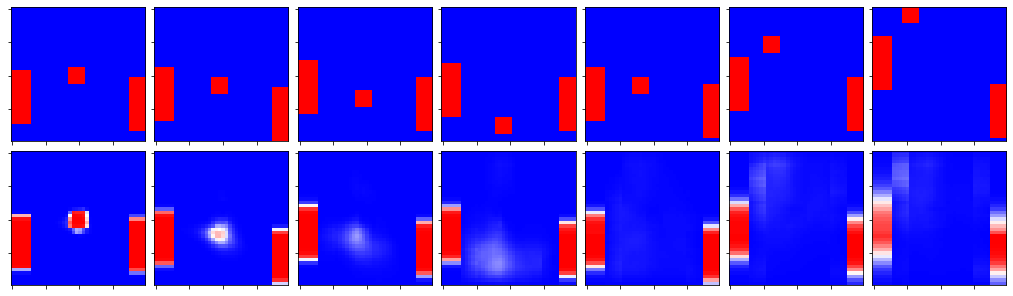

Epoch 470/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.0939 - mean_squared_error: 0.0252 - acc: 0.9680 - val_loss: 0.0976 - val_mean_squared_error: 0.0263 - val_acc: 0.9666


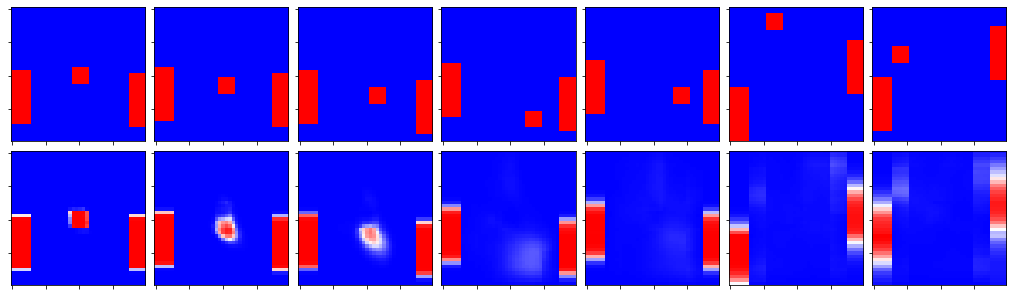

Epoch 471/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.0938 - mean_squared_error: 0.0250 - acc: 0.9685 - val_loss: 0.1010 - val_mean_squared_error: 0.0273 - val_acc: 0.9653


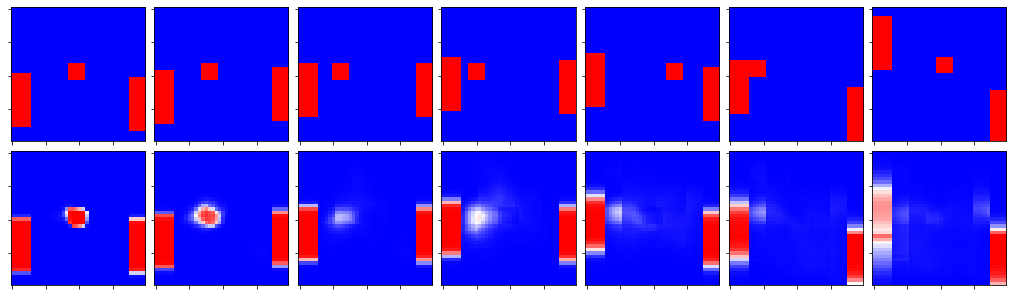

Epoch 472/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.0929 - mean_squared_error: 0.0249 - acc: 0.9685 - val_loss: 0.0905 - val_mean_squared_error: 0.0239 - val_acc: 0.9698


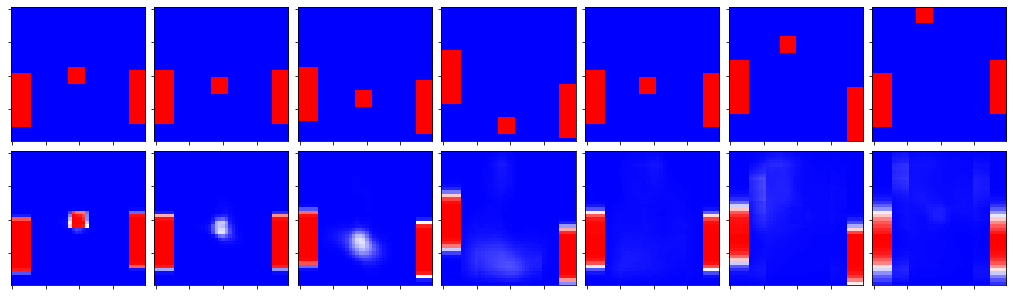

Epoch 473/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0913 - mean_squared_error: 0.0244 - acc: 0.9691 - val_loss: 0.0979 - val_mean_squared_error: 0.0263 - val_acc: 0.9667


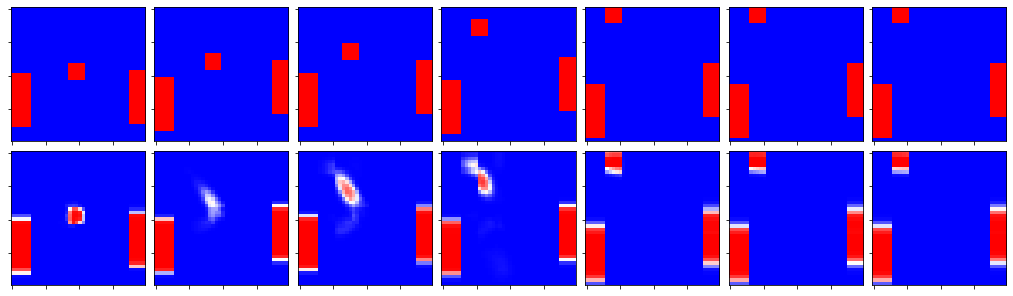

Epoch 474/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0922 - mean_squared_error: 0.0246 - acc: 0.9688 - val_loss: 0.0824 - val_mean_squared_error: 0.0225 - val_acc: 0.9712


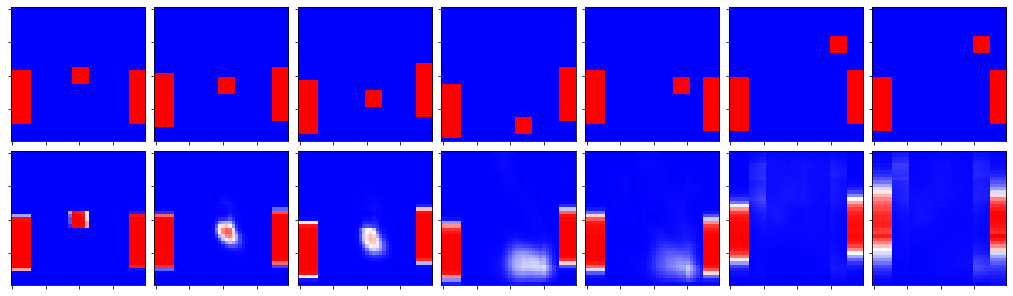

Epoch 475/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.1324 - mean_squared_error: 0.0312 - acc: 0.9611 - val_loss: 0.3519 - val_mean_squared_error: 0.0605 - val_acc: 0.9297


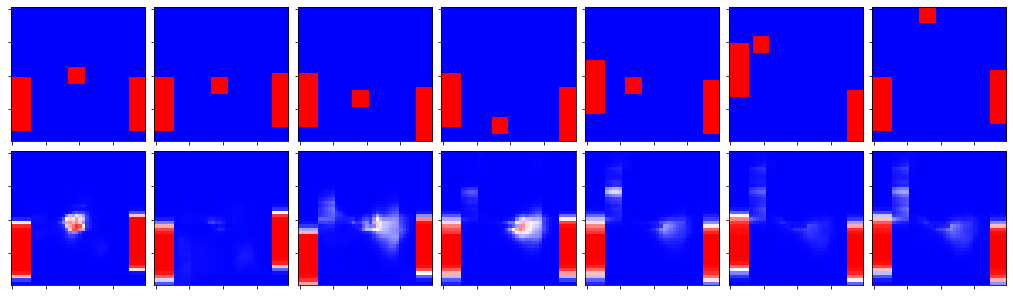

Epoch 476/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.2160 - mean_squared_error: 0.0528 - acc: 0.9318 - val_loss: 0.1836 - val_mean_squared_error: 0.0504 - val_acc: 0.9339


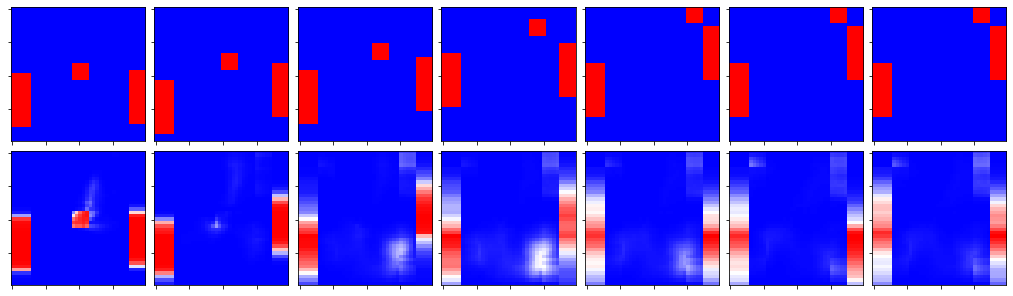

Epoch 477/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.1717 - mean_squared_error: 0.0473 - acc: 0.9379 - val_loss: 0.1598 - val_mean_squared_error: 0.0449 - val_acc: 0.9401


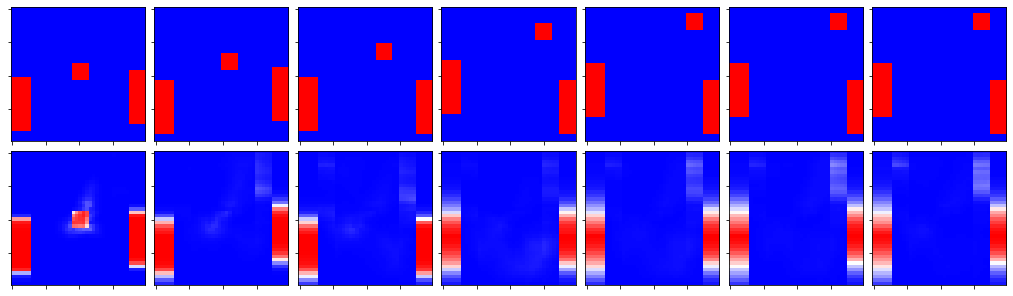

Epoch 478/2500
100/100 [==============================] - 51s 505ms/step - loss: 0.1596 - mean_squared_error: 0.0444 - acc: 0.9410 - val_loss: 0.1541 - val_mean_squared_error: 0.0426 - val_acc: 0.9440


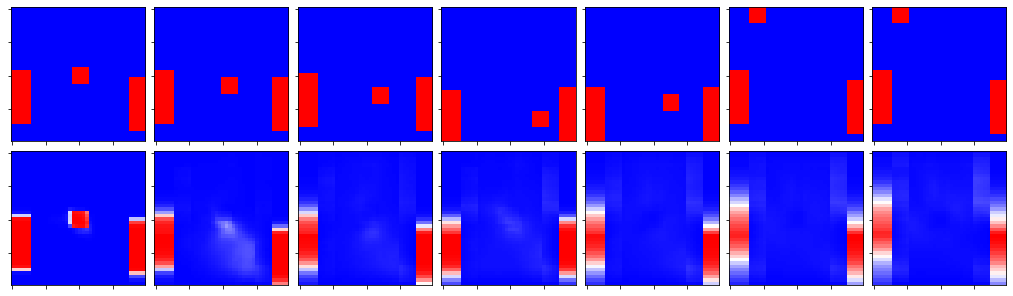

Epoch 479/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.1541 - mean_squared_error: 0.0427 - acc: 0.9435 - val_loss: 0.1522 - val_mean_squared_error: 0.0424 - val_acc: 0.9435


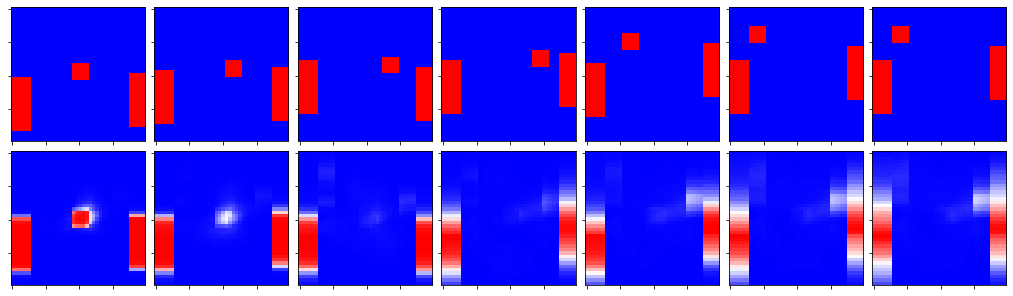

Epoch 480/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.1487 - mean_squared_error: 0.0411 - acc: 0.9457 - val_loss: 0.1427 - val_mean_squared_error: 0.0398 - val_acc: 0.9476


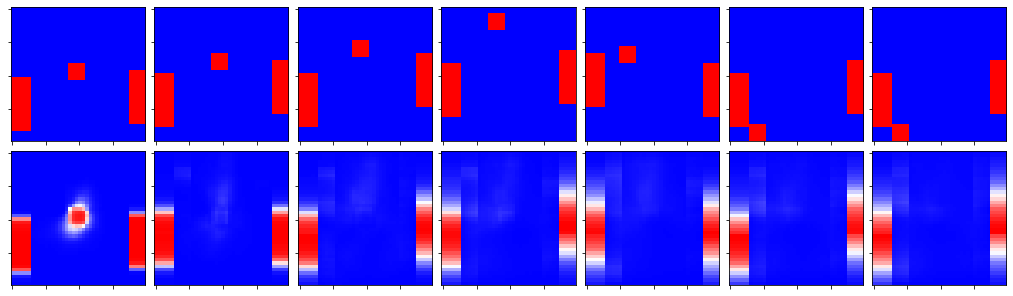

Epoch 481/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.1454 - mean_squared_error: 0.0401 - acc: 0.9472 - val_loss: 0.1418 - val_mean_squared_error: 0.0390 - val_acc: 0.9485


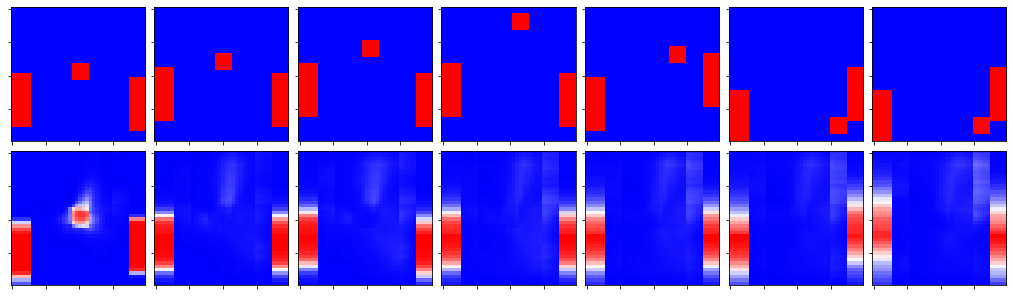

Epoch 482/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1389 - mean_squared_error: 0.0381 - acc: 0.9502 - val_loss: 0.1446 - val_mean_squared_error: 0.0399 - val_acc: 0.9479


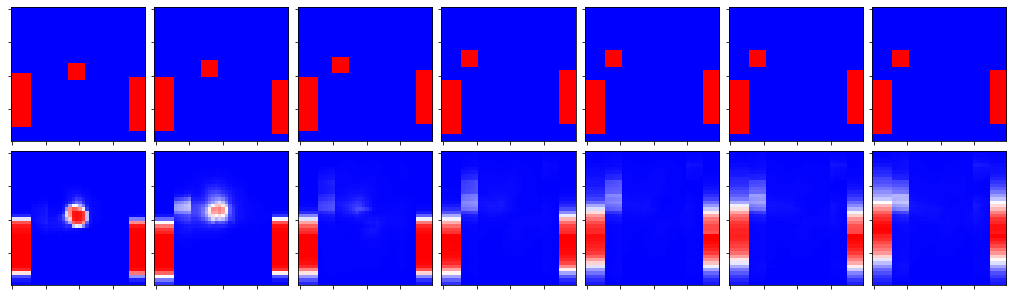

Epoch 483/2500
100/100 [==============================] - 51s 505ms/step - loss: 0.1365 - mean_squared_error: 0.0374 - acc: 0.9512 - val_loss: 0.1371 - val_mean_squared_error: 0.0371 - val_acc: 0.9517


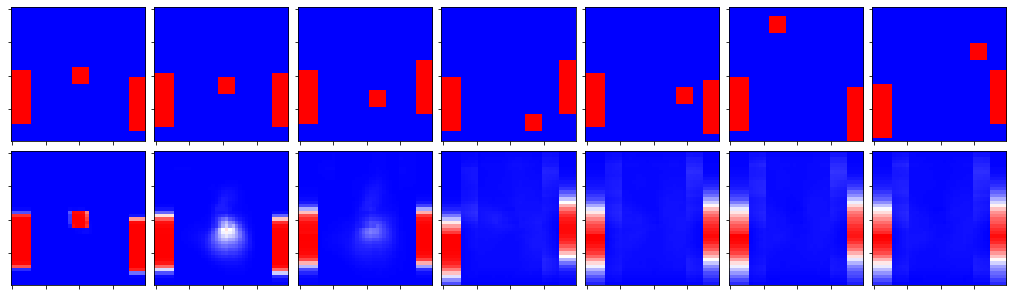

Epoch 484/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.1328 - mean_squared_error: 0.0363 - acc: 0.9527 - val_loss: 0.1330 - val_mean_squared_error: 0.0362 - val_acc: 0.9524


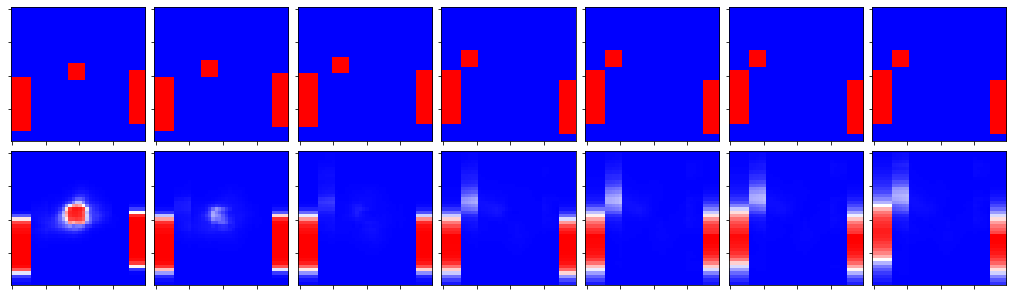

Epoch 485/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.1301 - mean_squared_error: 0.0355 - acc: 0.9538 - val_loss: 0.1222 - val_mean_squared_error: 0.0336 - val_acc: 0.9555


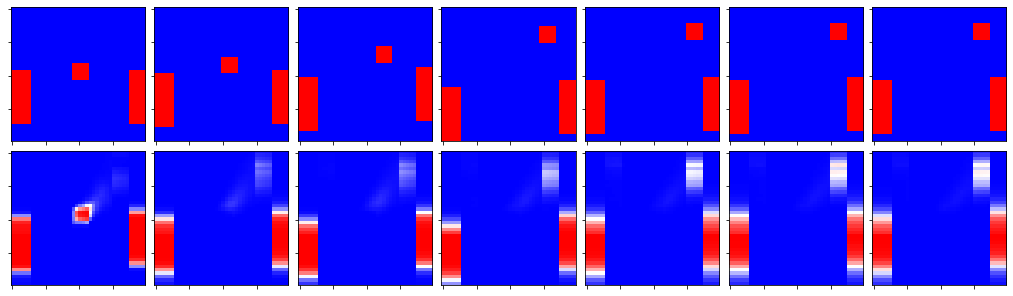

Epoch 486/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.1290 - mean_squared_error: 0.0351 - acc: 0.9547 - val_loss: 0.1291 - val_mean_squared_error: 0.0350 - val_acc: 0.9550


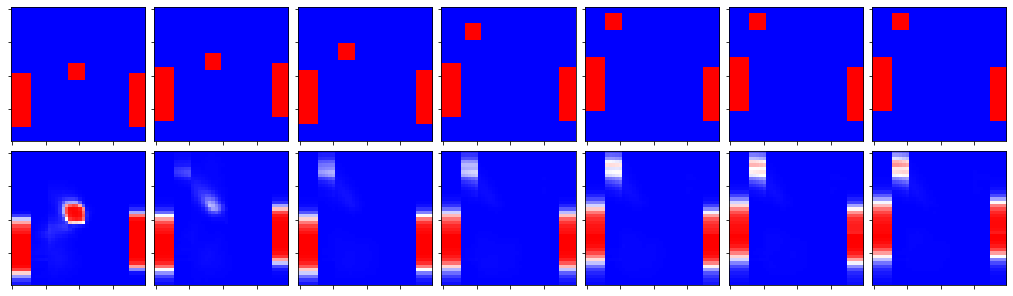

Epoch 487/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.1248 - mean_squared_error: 0.0338 - acc: 0.9564 - val_loss: 0.1193 - val_mean_squared_error: 0.0326 - val_acc: 0.9576


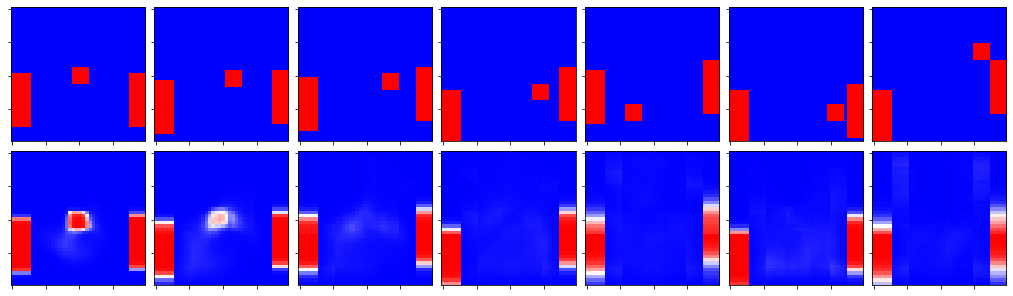

Epoch 488/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.1231 - mean_squared_error: 0.0334 - acc: 0.9569 - val_loss: 0.1324 - val_mean_squared_error: 0.0350 - val_acc: 0.9558


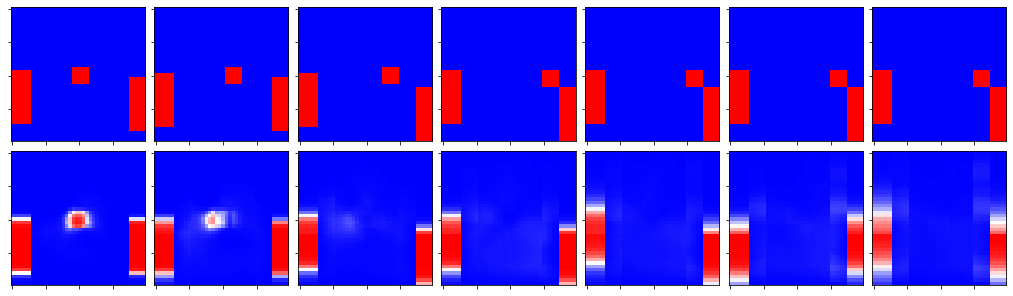

Epoch 489/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.1236 - mean_squared_error: 0.0335 - acc: 0.9569 - val_loss: 0.1215 - val_mean_squared_error: 0.0327 - val_acc: 0.9583


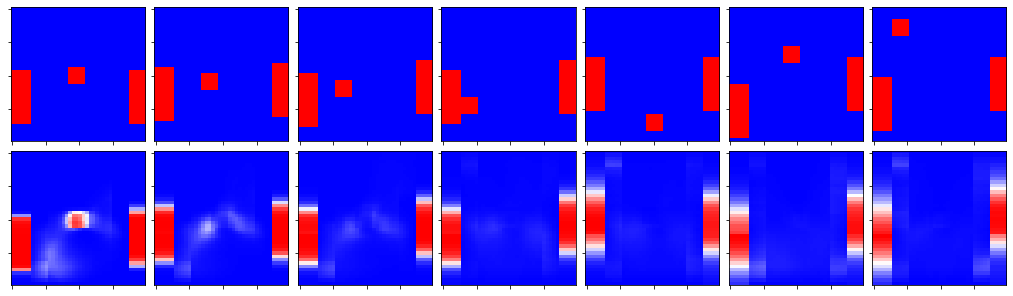

Epoch 490/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.1208 - mean_squared_error: 0.0327 - acc: 0.9578 - val_loss: 0.1239 - val_mean_squared_error: 0.0333 - val_acc: 0.9582


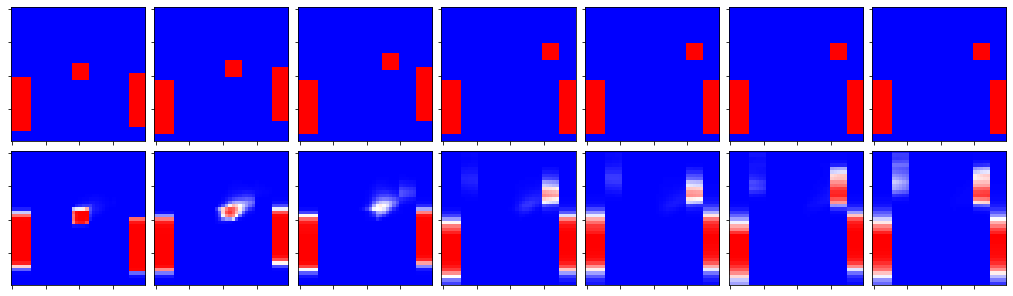

Epoch 491/2500
100/100 [==============================] - 51s 506ms/step - loss: 0.1193 - mean_squared_error: 0.0322 - acc: 0.9587 - val_loss: 0.1148 - val_mean_squared_error: 0.0314 - val_acc: 0.9596


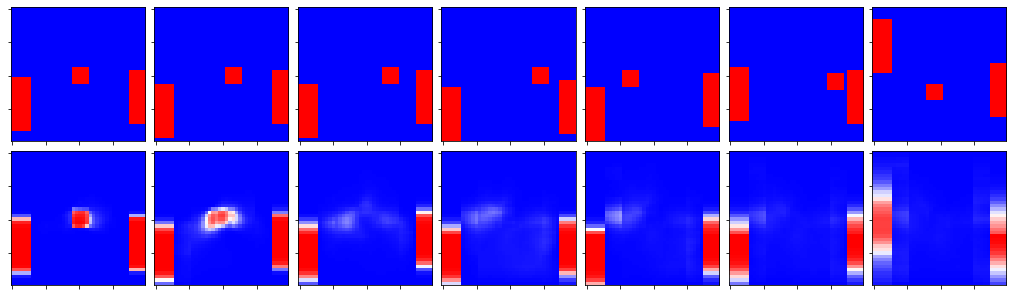

Epoch 492/2500
100/100 [==============================] - 51s 505ms/step - loss: 0.1192 - mean_squared_error: 0.0322 - acc: 0.9587 - val_loss: 0.1223 - val_mean_squared_error: 0.0334 - val_acc: 0.9571


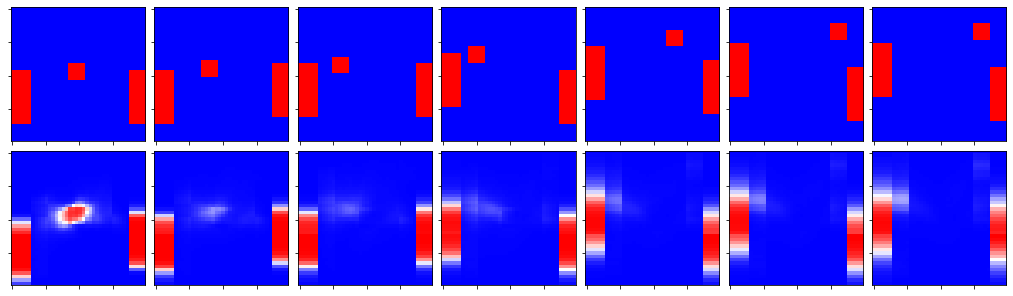

Epoch 493/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.1175 - mean_squared_error: 0.0318 - acc: 0.9592 - val_loss: 0.1113 - val_mean_squared_error: 0.0302 - val_acc: 0.9617


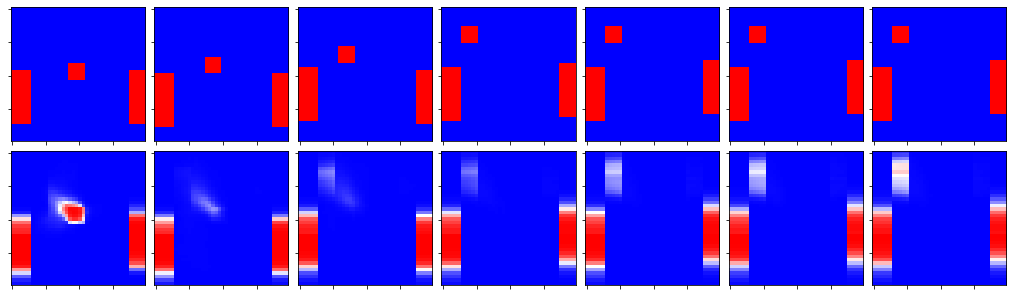

Epoch 494/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1179 - mean_squared_error: 0.0319 - acc: 0.9592 - val_loss: 0.1164 - val_mean_squared_error: 0.0311 - val_acc: 0.9604


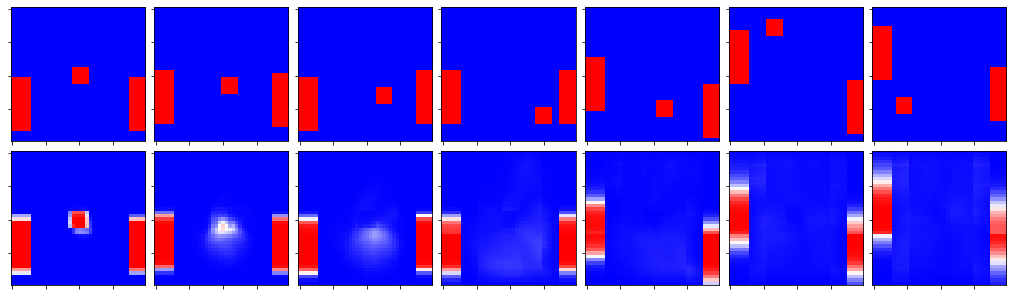

Epoch 495/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.1160 - mean_squared_error: 0.0312 - acc: 0.9601 - val_loss: 0.1161 - val_mean_squared_error: 0.0318 - val_acc: 0.9588


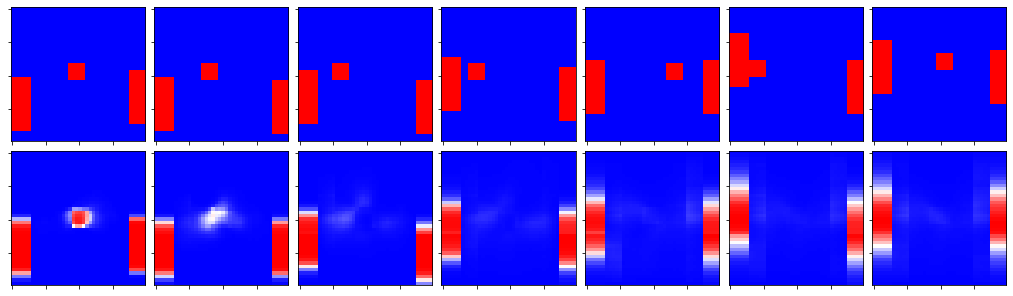

Epoch 496/2500
100/100 [==============================] - 51s 506ms/step - loss: 0.1153 - mean_squared_error: 0.0312 - acc: 0.9601 - val_loss: 0.1097 - val_mean_squared_error: 0.0297 - val_acc: 0.9620


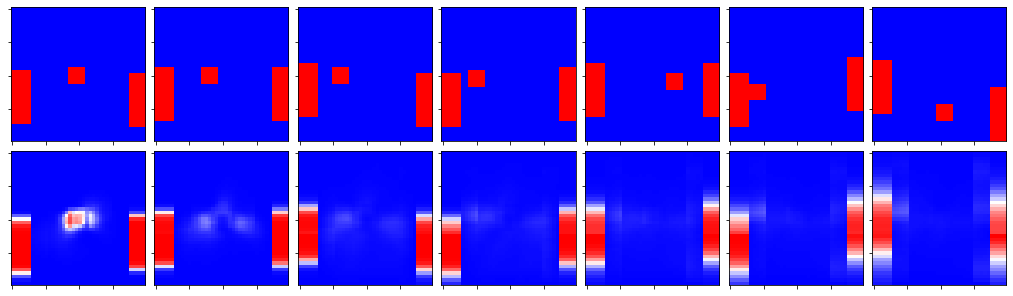

Epoch 497/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.1190 - mean_squared_error: 0.0319 - acc: 0.9592 - val_loss: 0.1186 - val_mean_squared_error: 0.0320 - val_acc: 0.9591


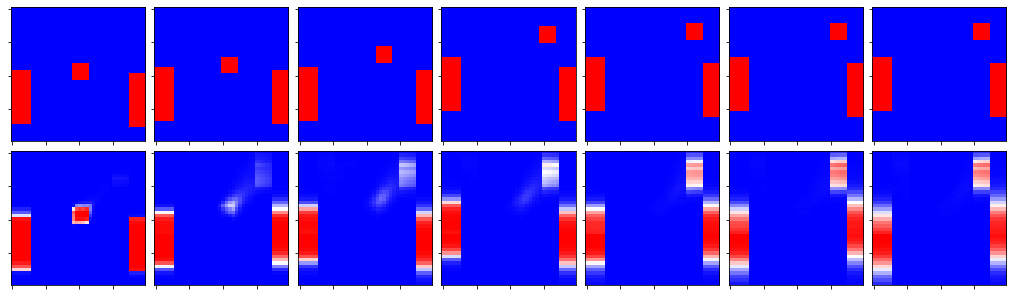

Epoch 498/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.1154 - mean_squared_error: 0.0312 - acc: 0.9598 - val_loss: 0.1065 - val_mean_squared_error: 0.0293 - val_acc: 0.9616


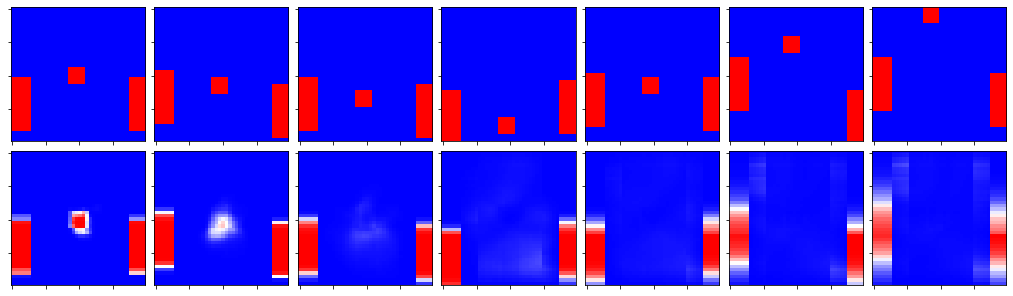

Epoch 499/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.1119 - mean_squared_error: 0.0303 - acc: 0.9611 - val_loss: 0.1147 - val_mean_squared_error: 0.0317 - val_acc: 0.9590


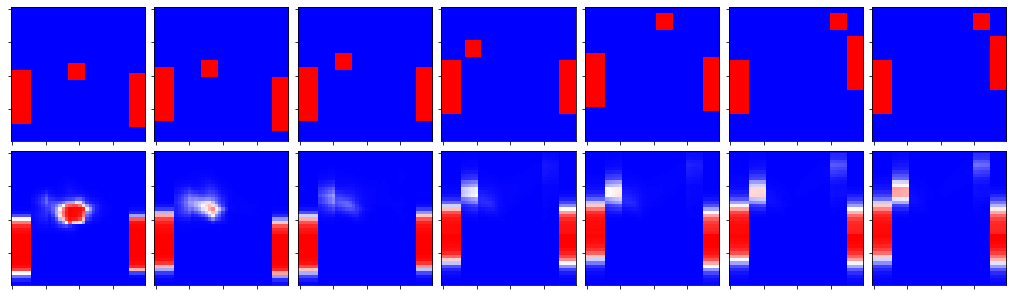

Epoch 500/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.1120 - mean_squared_error: 0.0304 - acc: 0.9609 - val_loss: 0.1095 - val_mean_squared_error: 0.0295 - val_acc: 0.9625


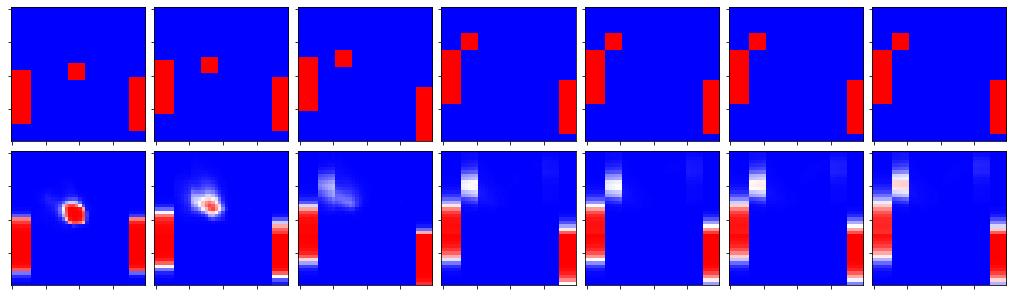

Epoch 501/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.1124 - mean_squared_error: 0.0305 - acc: 0.9608 - val_loss: 0.1128 - val_mean_squared_error: 0.0304 - val_acc: 0.9609


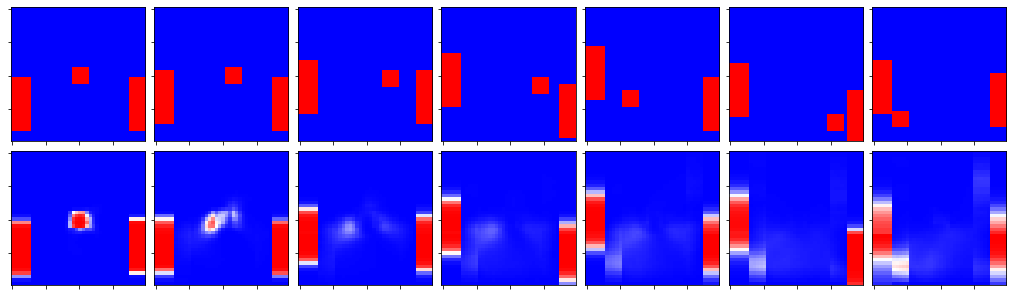

Epoch 502/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.1103 - mean_squared_error: 0.0300 - acc: 0.9614 - val_loss: 0.1176 - val_mean_squared_error: 0.0314 - val_acc: 0.9601


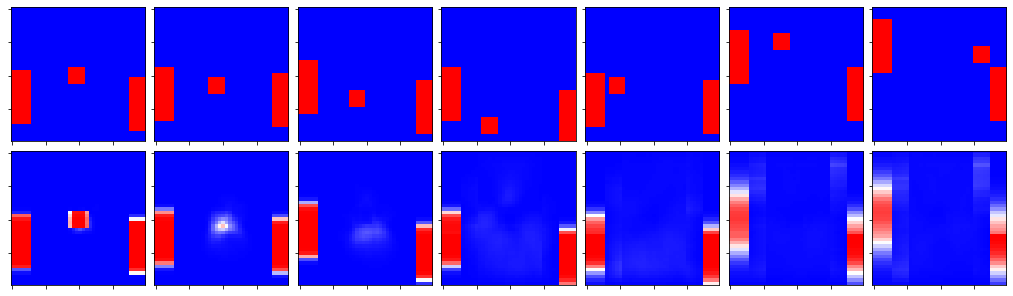

Epoch 503/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.1104 - mean_squared_error: 0.0299 - acc: 0.9616 - val_loss: 0.1137 - val_mean_squared_error: 0.0305 - val_acc: 0.9611


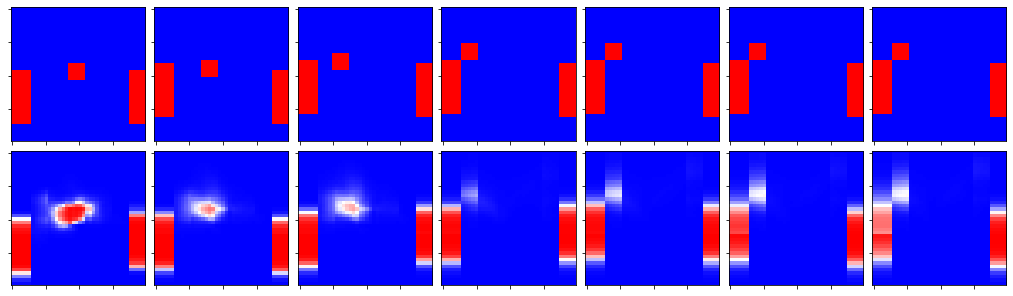

Epoch 504/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.1106 - mean_squared_error: 0.0299 - acc: 0.9617 - val_loss: 0.1204 - val_mean_squared_error: 0.0323 - val_acc: 0.9593


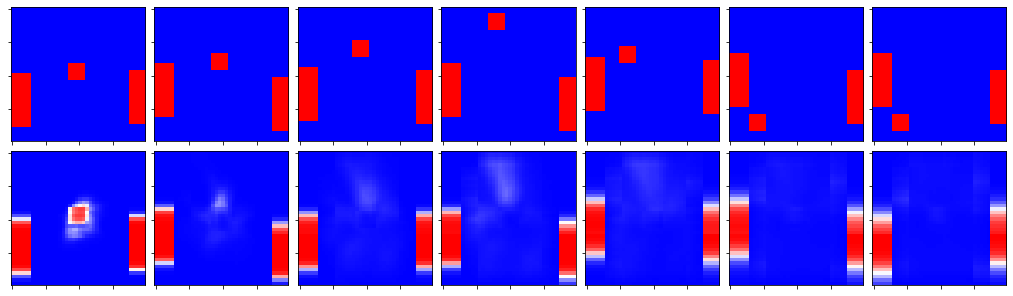

Epoch 505/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.1091 - mean_squared_error: 0.0294 - acc: 0.9623 - val_loss: 0.1077 - val_mean_squared_error: 0.0296 - val_acc: 0.9614


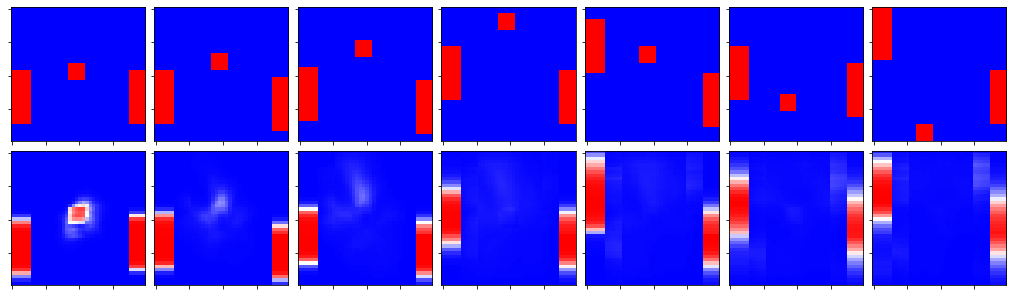

Epoch 506/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.1082 - mean_squared_error: 0.0291 - acc: 0.9628 - val_loss: 0.1172 - val_mean_squared_error: 0.0314 - val_acc: 0.9603


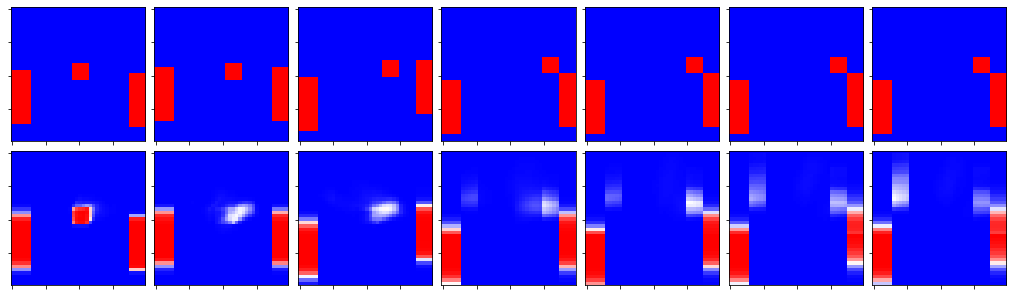

Epoch 507/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.1086 - mean_squared_error: 0.0293 - acc: 0.9624 - val_loss: 0.1082 - val_mean_squared_error: 0.0290 - val_acc: 0.9629


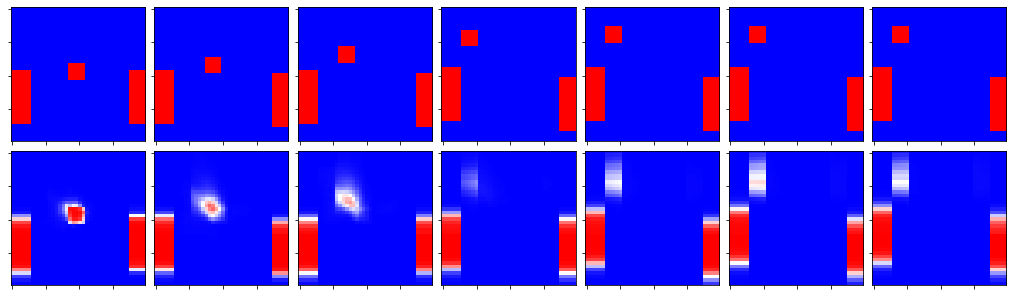

Epoch 508/2500
100/100 [==============================] - 51s 507ms/step - loss: 0.1081 - mean_squared_error: 0.0291 - acc: 0.9628 - val_loss: 0.1006 - val_mean_squared_error: 0.0276 - val_acc: 0.9639


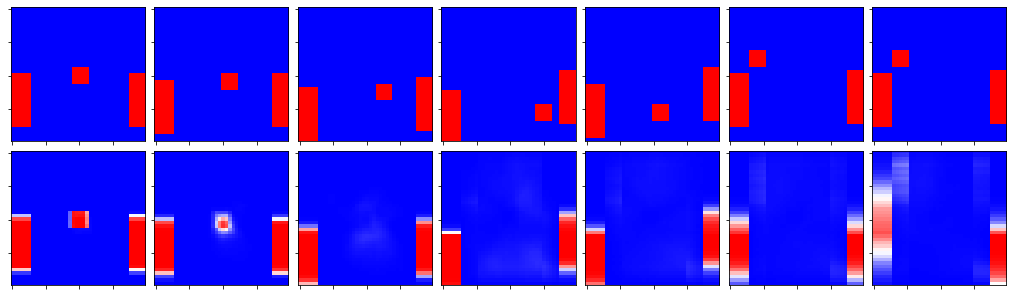

Epoch 509/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1089 - mean_squared_error: 0.0293 - acc: 0.9626 - val_loss: 0.1045 - val_mean_squared_error: 0.0287 - val_acc: 0.9628


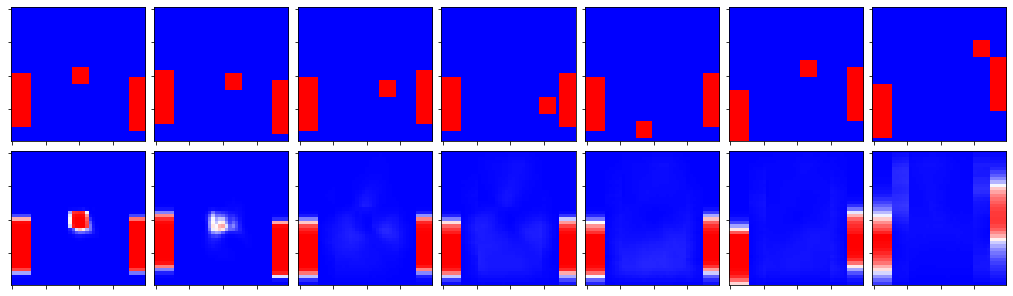

Epoch 510/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.1071 - mean_squared_error: 0.0290 - acc: 0.9628 - val_loss: 0.1077 - val_mean_squared_error: 0.0292 - val_acc: 0.9625


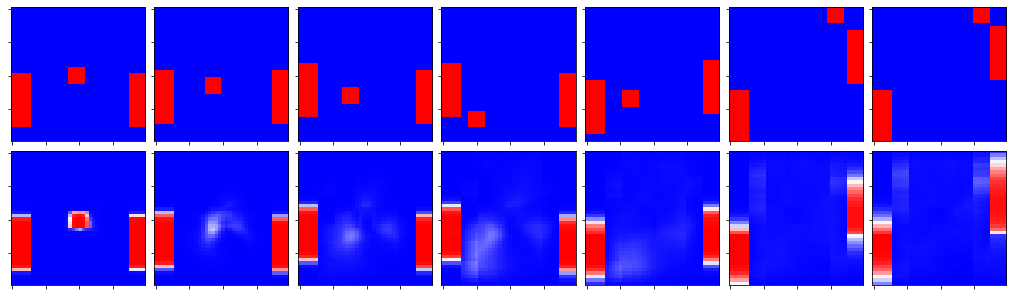

Epoch 511/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1047 - mean_squared_error: 0.0281 - acc: 0.9641 - val_loss: 0.1137 - val_mean_squared_error: 0.0300 - val_acc: 0.9618


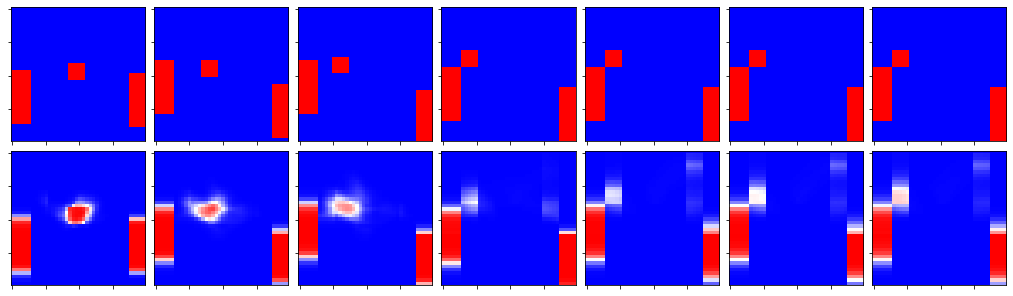

Epoch 512/2500
100/100 [==============================] - 49s 494ms/step - loss: 0.1063 - mean_squared_error: 0.0287 - acc: 0.9633 - val_loss: 0.1082 - val_mean_squared_error: 0.0294 - val_acc: 0.9620


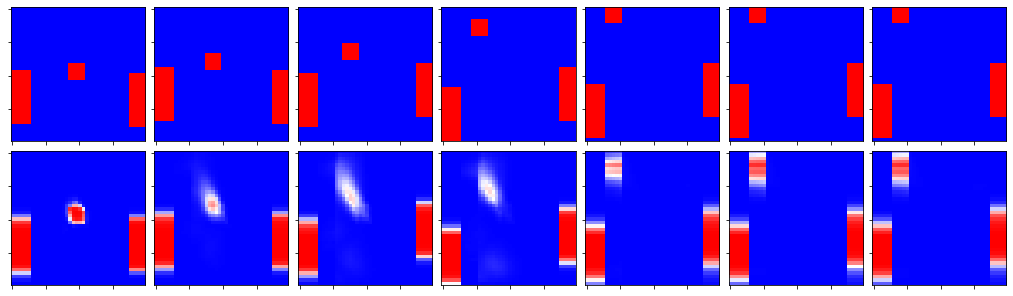

Epoch 513/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.1053 - mean_squared_error: 0.0284 - acc: 0.9637 - val_loss: 0.1041 - val_mean_squared_error: 0.0279 - val_acc: 0.9646


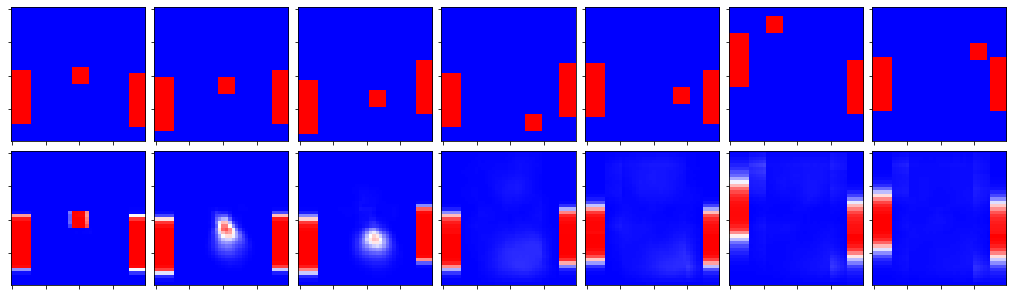

Epoch 514/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.1057 - mean_squared_error: 0.0284 - acc: 0.9638 - val_loss: 0.1091 - val_mean_squared_error: 0.0283 - val_acc: 0.9642


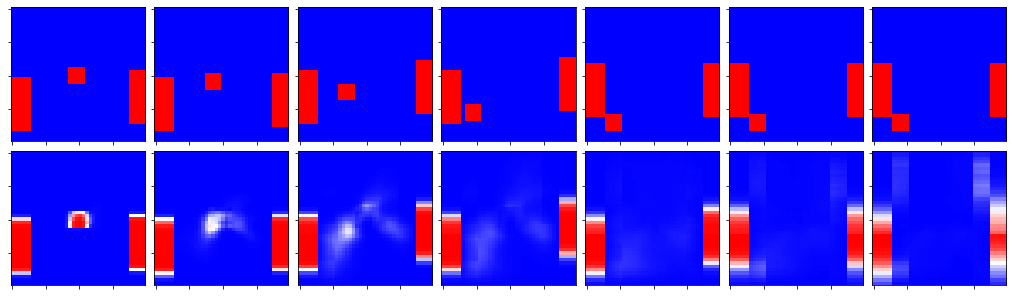

Epoch 515/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.1099 - mean_squared_error: 0.0298 - acc: 0.9617 - val_loss: 0.0977 - val_mean_squared_error: 0.0263 - val_acc: 0.9662


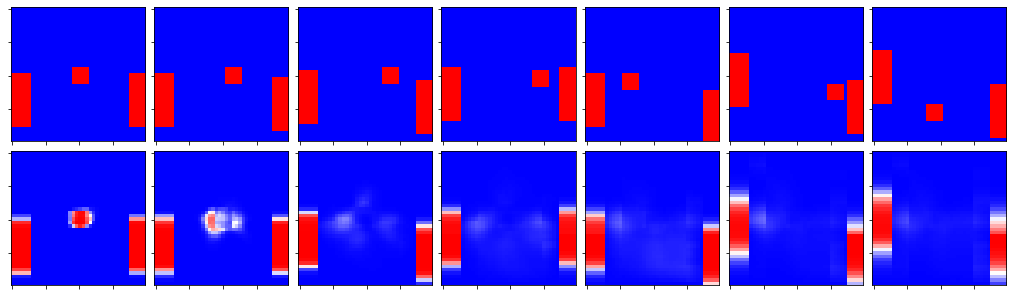

Epoch 516/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.1058 - mean_squared_error: 0.0285 - acc: 0.9634 - val_loss: 0.1035 - val_mean_squared_error: 0.0279 - val_acc: 0.9644


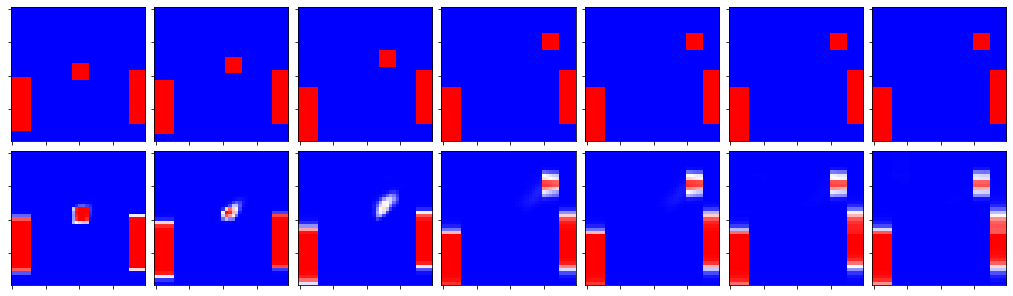

Epoch 517/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.1043 - mean_squared_error: 0.0282 - acc: 0.9639 - val_loss: 0.1147 - val_mean_squared_error: 0.0308 - val_acc: 0.9608


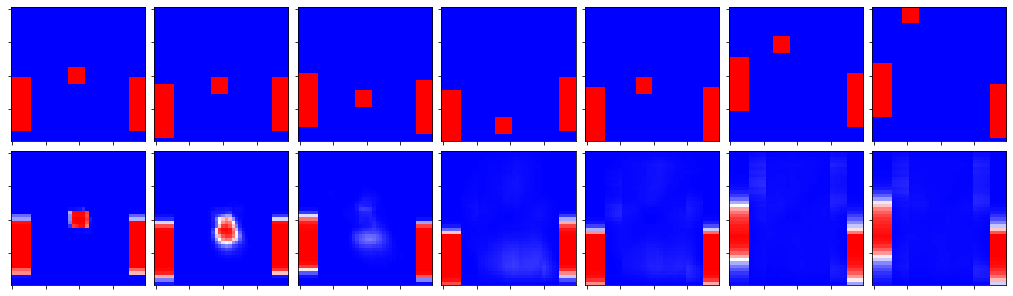

Epoch 518/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.1022 - mean_squared_error: 0.0275 - acc: 0.9649 - val_loss: 0.1034 - val_mean_squared_error: 0.0274 - val_acc: 0.9653


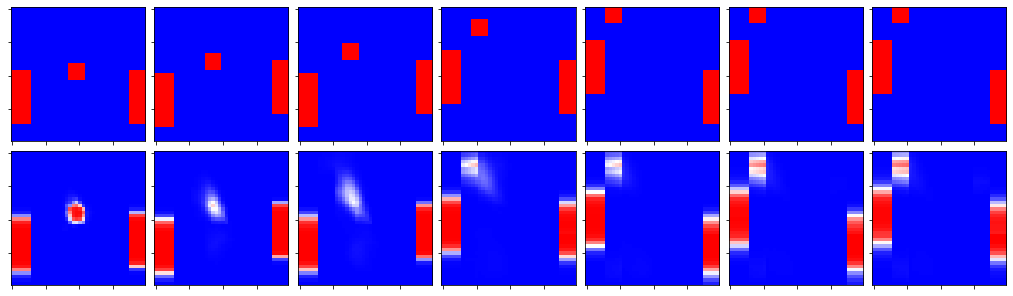

Epoch 519/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.1036 - mean_squared_error: 0.0277 - acc: 0.9647 - val_loss: 0.1136 - val_mean_squared_error: 0.0304 - val_acc: 0.9614


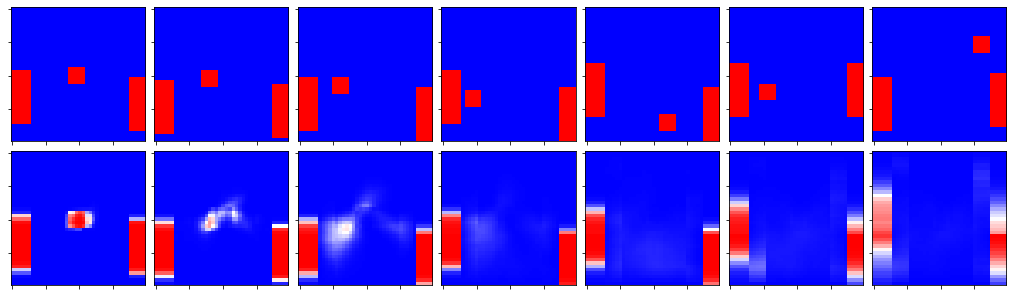

Epoch 520/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.1030 - mean_squared_error: 0.0277 - acc: 0.9646 - val_loss: 0.1014 - val_mean_squared_error: 0.0274 - val_acc: 0.9645


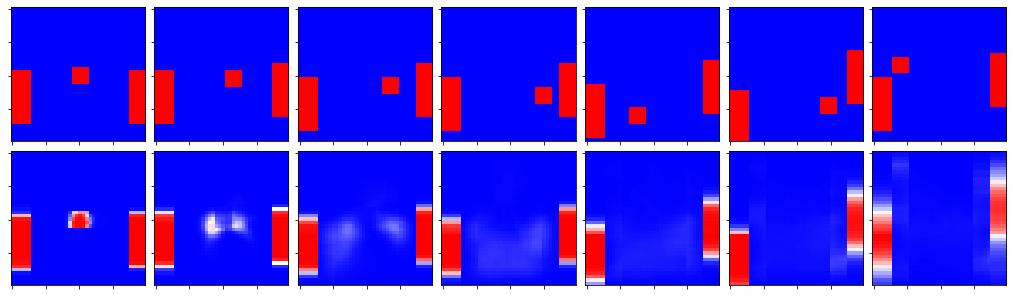

Epoch 521/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.1014 - mean_squared_error: 0.0272 - acc: 0.9652 - val_loss: 0.0993 - val_mean_squared_error: 0.0272 - val_acc: 0.9648


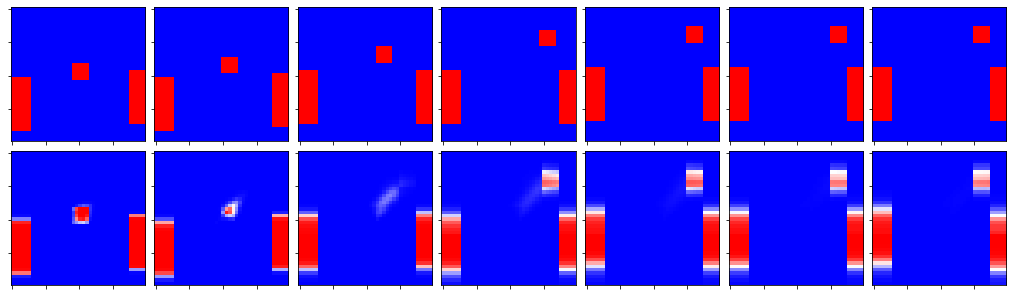

Epoch 522/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.1026 - mean_squared_error: 0.0276 - acc: 0.9648 - val_loss: 0.1098 - val_mean_squared_error: 0.0296 - val_acc: 0.9622


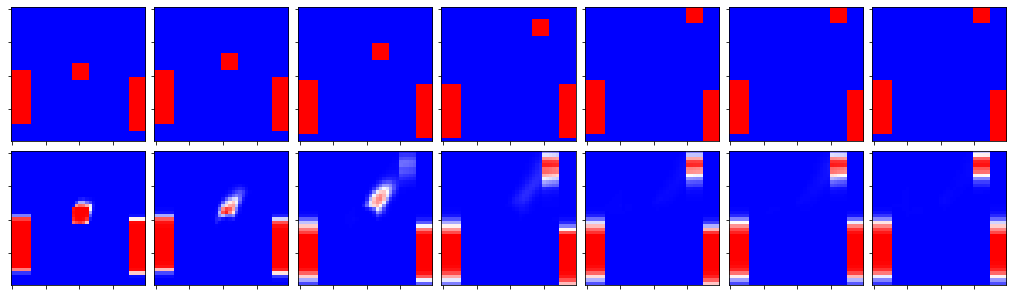

Epoch 523/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.1061 - mean_squared_error: 0.0285 - acc: 0.9635 - val_loss: 0.1033 - val_mean_squared_error: 0.0281 - val_acc: 0.9636


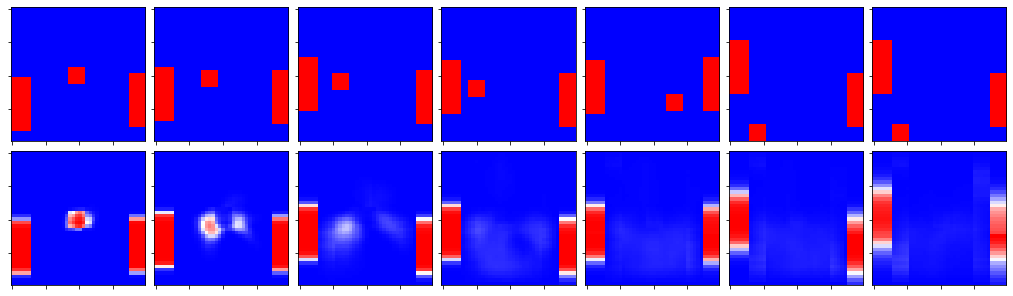

Epoch 524/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.1008 - mean_squared_error: 0.0272 - acc: 0.9653 - val_loss: 0.1035 - val_mean_squared_error: 0.0271 - val_acc: 0.9657


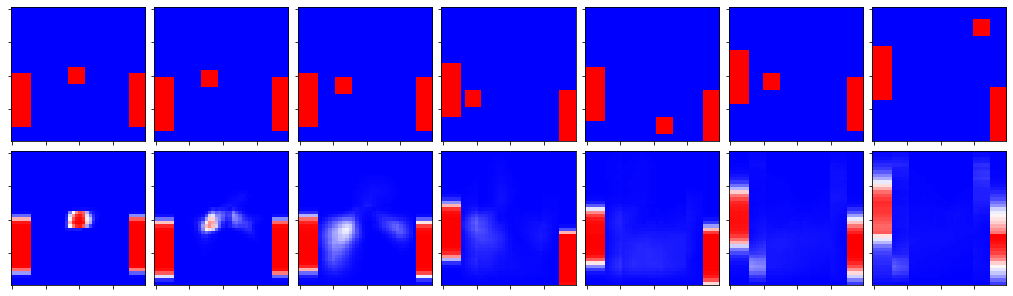

Epoch 525/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.1016 - mean_squared_error: 0.0273 - acc: 0.9652 - val_loss: 0.1002 - val_mean_squared_error: 0.0267 - val_acc: 0.9663


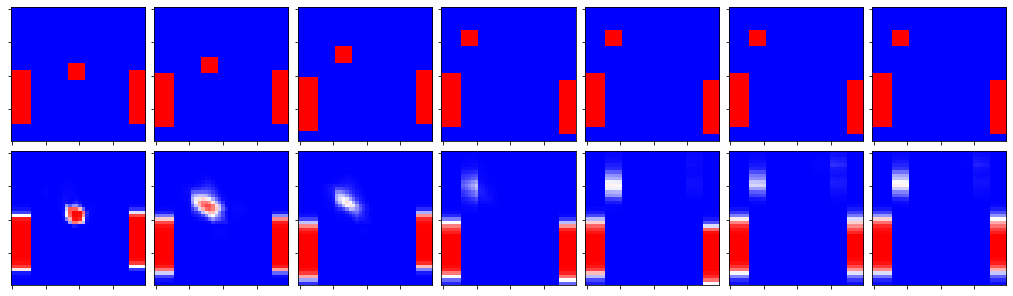

Epoch 526/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.1011 - mean_squared_error: 0.0272 - acc: 0.9652 - val_loss: 0.1002 - val_mean_squared_error: 0.0264 - val_acc: 0.9667


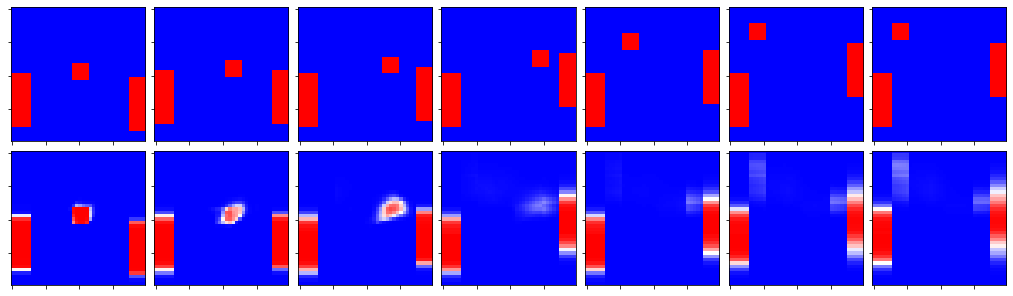

Epoch 527/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.1000 - mean_squared_error: 0.0269 - acc: 0.9657 - val_loss: 0.0953 - val_mean_squared_error: 0.0256 - val_acc: 0.9678


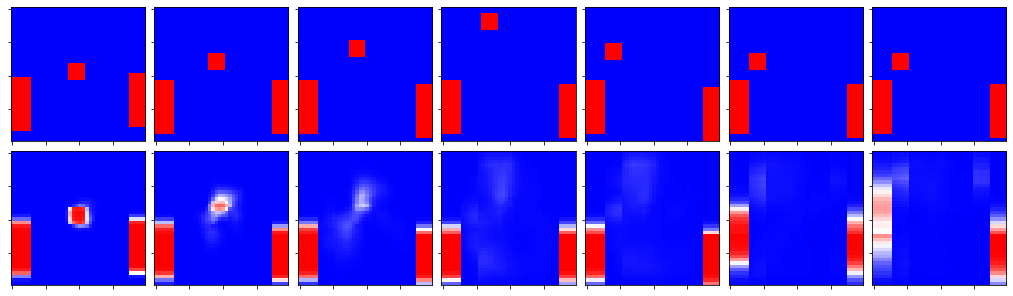

Epoch 528/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.1024 - mean_squared_error: 0.0274 - acc: 0.9650 - val_loss: 0.0983 - val_mean_squared_error: 0.0261 - val_acc: 0.9668


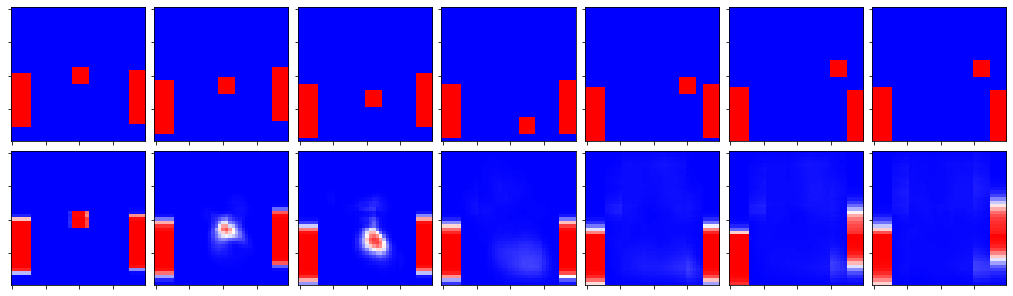

Epoch 529/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.0998 - mean_squared_error: 0.0267 - acc: 0.9659 - val_loss: 0.0993 - val_mean_squared_error: 0.0265 - val_acc: 0.9663


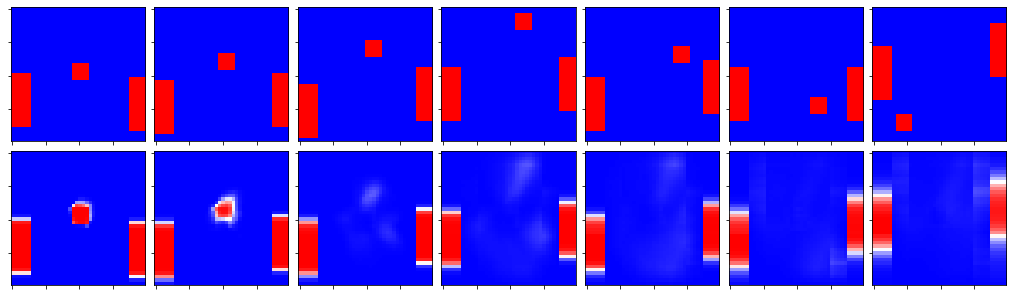

Epoch 530/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0995 - mean_squared_error: 0.0268 - acc: 0.9658 - val_loss: 0.1025 - val_mean_squared_error: 0.0279 - val_acc: 0.9641


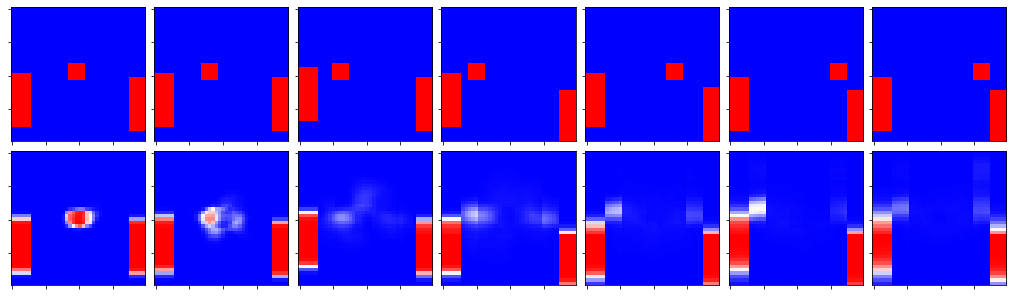

Epoch 531/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0992 - mean_squared_error: 0.0266 - acc: 0.9662 - val_loss: 0.1036 - val_mean_squared_error: 0.0279 - val_acc: 0.9643


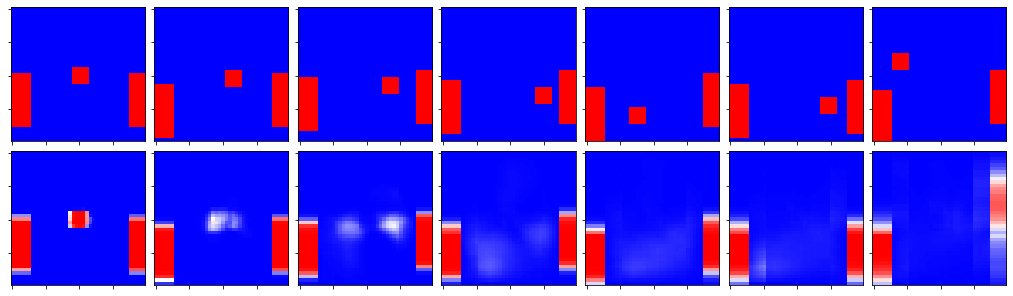

Epoch 532/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.0991 - mean_squared_error: 0.0266 - acc: 0.9661 - val_loss: 0.1010 - val_mean_squared_error: 0.0274 - val_acc: 0.9651


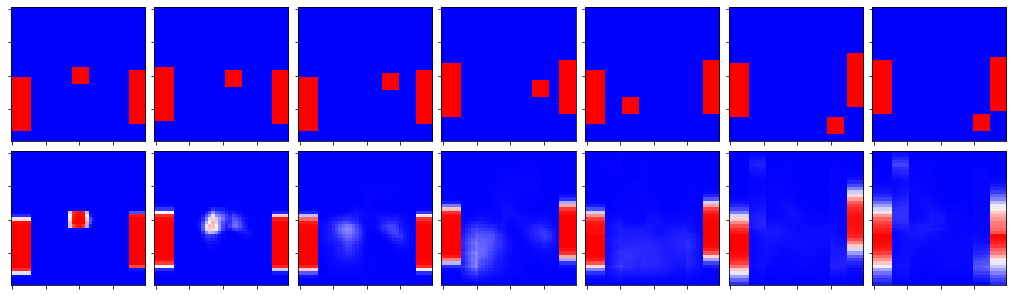

Epoch 533/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0992 - mean_squared_error: 0.0265 - acc: 0.9664 - val_loss: 0.1008 - val_mean_squared_error: 0.0274 - val_acc: 0.9648


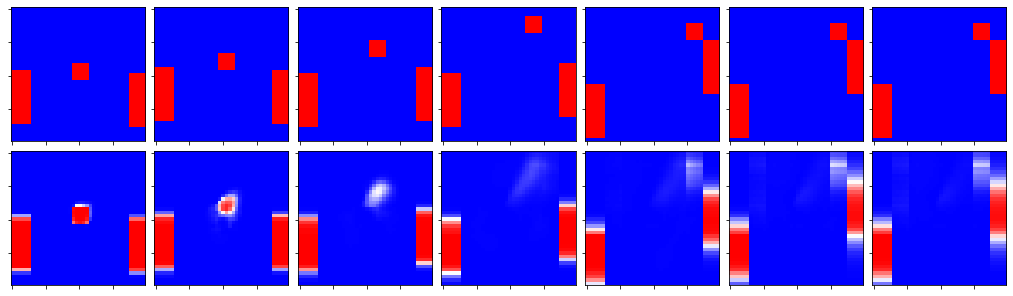

Epoch 534/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0985 - mean_squared_error: 0.0265 - acc: 0.9662 - val_loss: 0.0977 - val_mean_squared_error: 0.0264 - val_acc: 0.9662


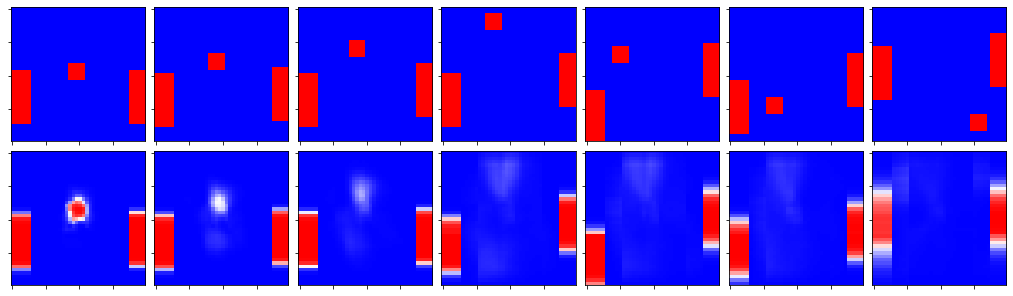

Epoch 535/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.0979 - mean_squared_error: 0.0262 - acc: 0.9667 - val_loss: 0.1015 - val_mean_squared_error: 0.0265 - val_acc: 0.9668


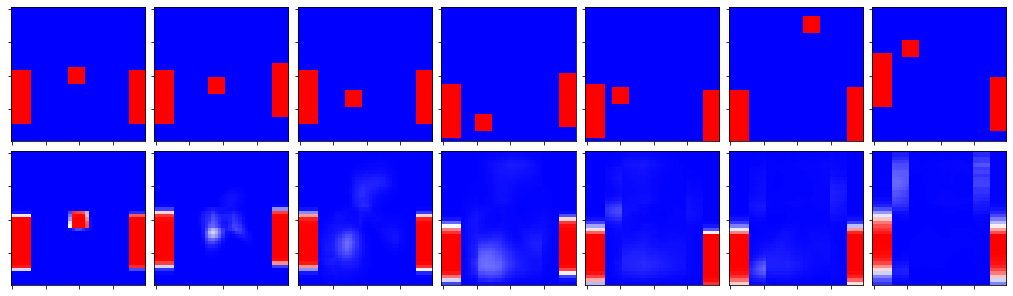

Epoch 536/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0977 - mean_squared_error: 0.0262 - acc: 0.9667 - val_loss: 0.0999 - val_mean_squared_error: 0.0263 - val_acc: 0.9664


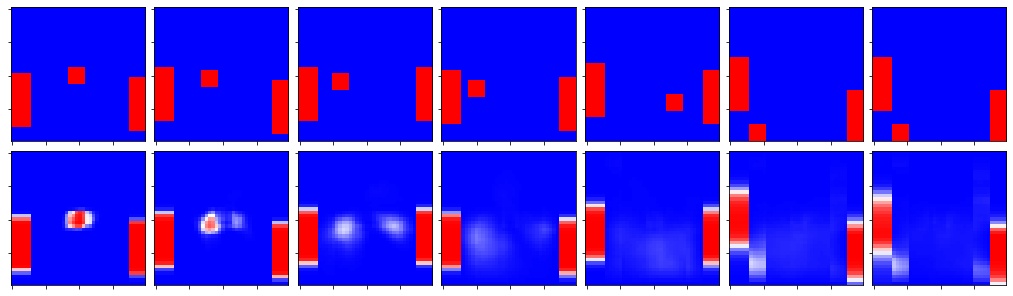

Epoch 537/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.0965 - mean_squared_error: 0.0259 - acc: 0.9670 - val_loss: 0.0978 - val_mean_squared_error: 0.0255 - val_acc: 0.9675


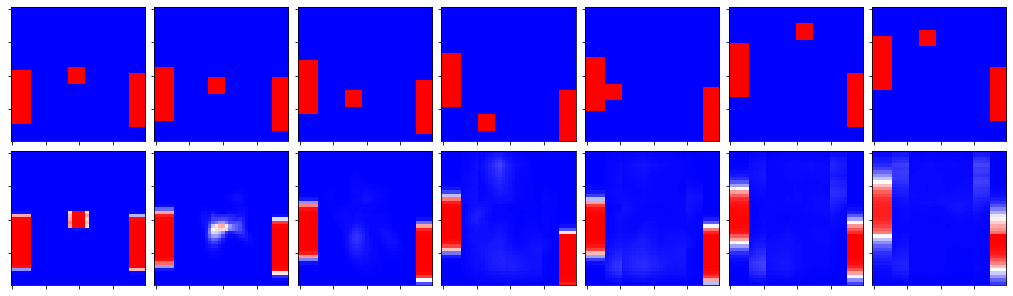

Epoch 538/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.0983 - mean_squared_error: 0.0264 - acc: 0.9664 - val_loss: 0.1077 - val_mean_squared_error: 0.0294 - val_acc: 0.9623


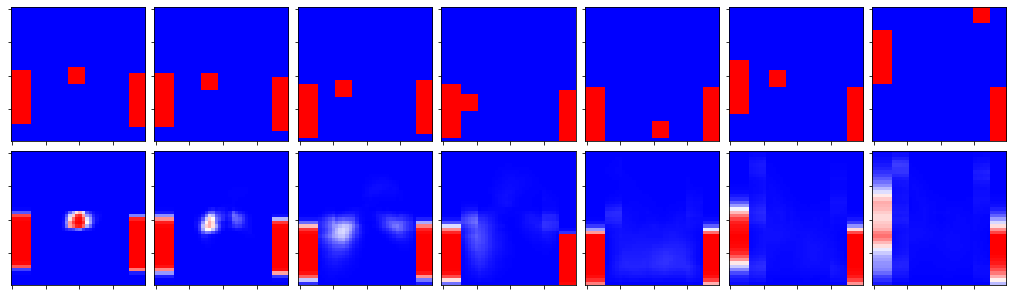

Epoch 539/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.0955 - mean_squared_error: 0.0256 - acc: 0.9675 - val_loss: 0.0880 - val_mean_squared_error: 0.0230 - val_acc: 0.9717


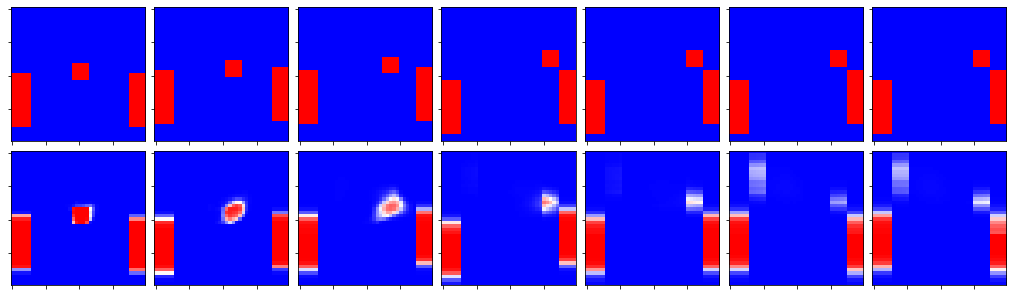

Epoch 540/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.0958 - mean_squared_error: 0.0257 - acc: 0.9672 - val_loss: 0.0937 - val_mean_squared_error: 0.0253 - val_acc: 0.9677


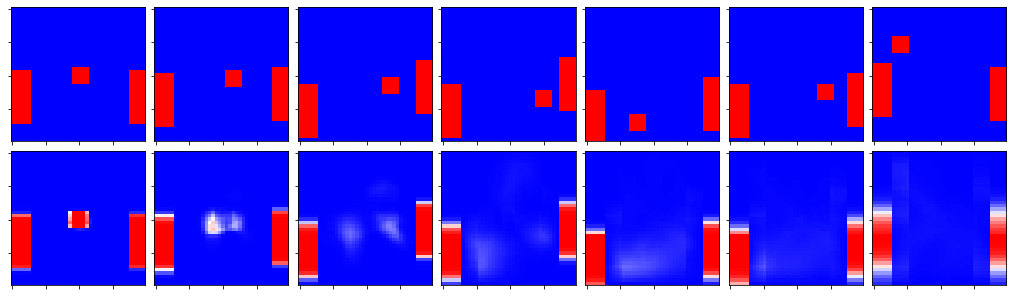

Epoch 541/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0965 - mean_squared_error: 0.0259 - acc: 0.9670 - val_loss: 0.0876 - val_mean_squared_error: 0.0234 - val_acc: 0.9698


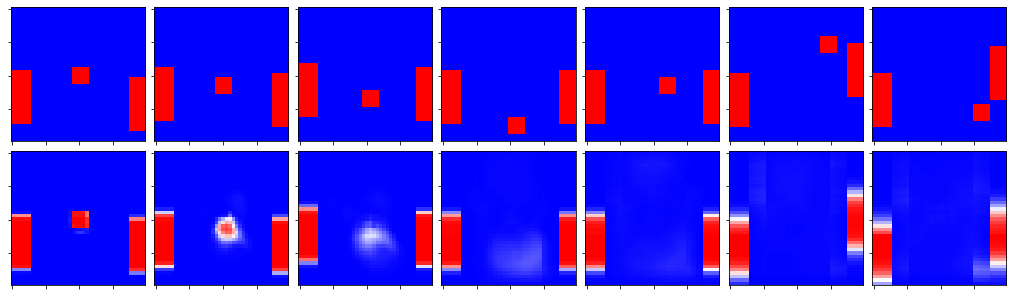

Epoch 542/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0947 - mean_squared_error: 0.0254 - acc: 0.9676 - val_loss: 0.1002 - val_mean_squared_error: 0.0267 - val_acc: 0.9663


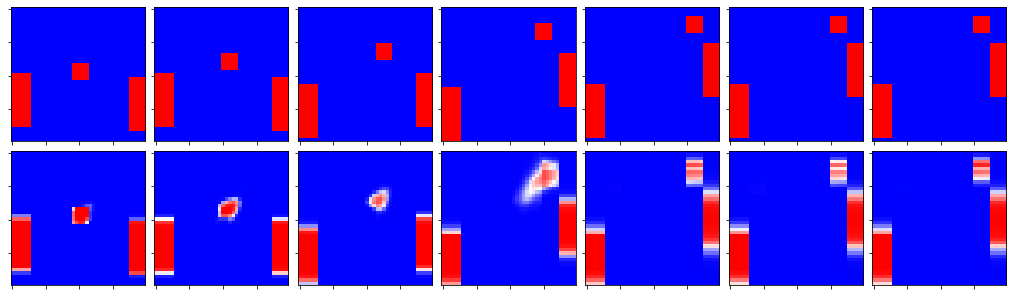

Epoch 543/2500
100/100 [==============================] - 51s 505ms/step - loss: 0.0960 - mean_squared_error: 0.0257 - acc: 0.9672 - val_loss: 0.0943 - val_mean_squared_error: 0.0254 - val_acc: 0.9675


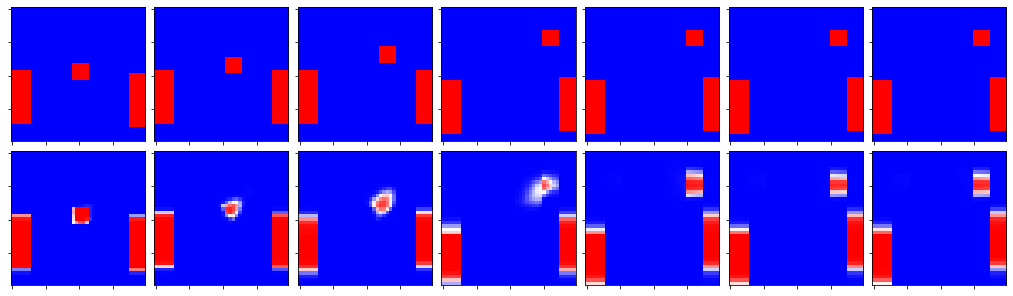

Epoch 544/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0948 - mean_squared_error: 0.0254 - acc: 0.9677 - val_loss: 0.0946 - val_mean_squared_error: 0.0257 - val_acc: 0.9671


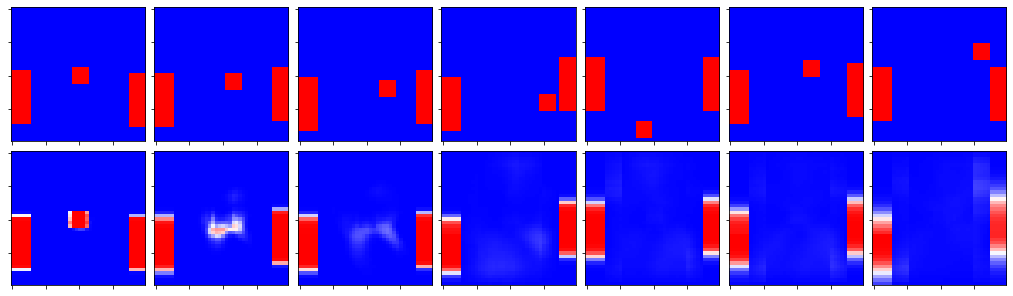

Epoch 545/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0961 - mean_squared_error: 0.0256 - acc: 0.9674 - val_loss: 0.0822 - val_mean_squared_error: 0.0228 - val_acc: 0.9703


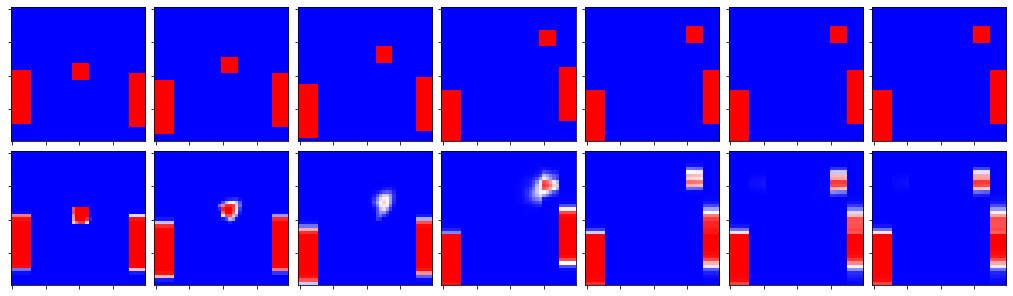

Epoch 546/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0957 - mean_squared_error: 0.0257 - acc: 0.9671 - val_loss: 0.0934 - val_mean_squared_error: 0.0249 - val_acc: 0.9683


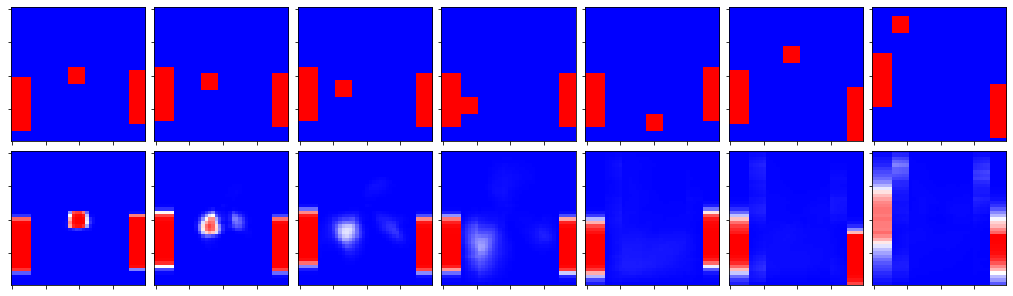

Epoch 547/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.0937 - mean_squared_error: 0.0252 - acc: 0.9679 - val_loss: 0.0968 - val_mean_squared_error: 0.0260 - val_acc: 0.9667


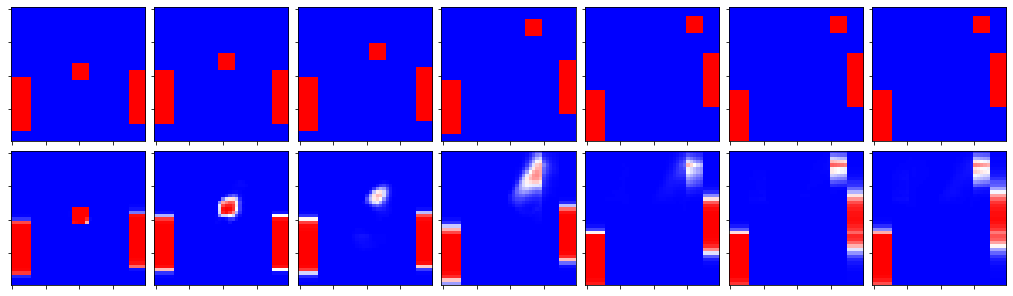

Epoch 548/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0950 - mean_squared_error: 0.0254 - acc: 0.9676 - val_loss: 0.0910 - val_mean_squared_error: 0.0244 - val_acc: 0.9690


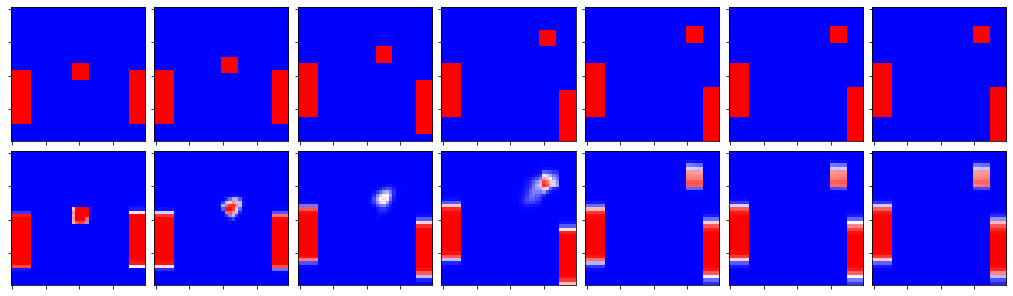

Epoch 549/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.0945 - mean_squared_error: 0.0252 - acc: 0.9678 - val_loss: 0.0987 - val_mean_squared_error: 0.0268 - val_acc: 0.9655


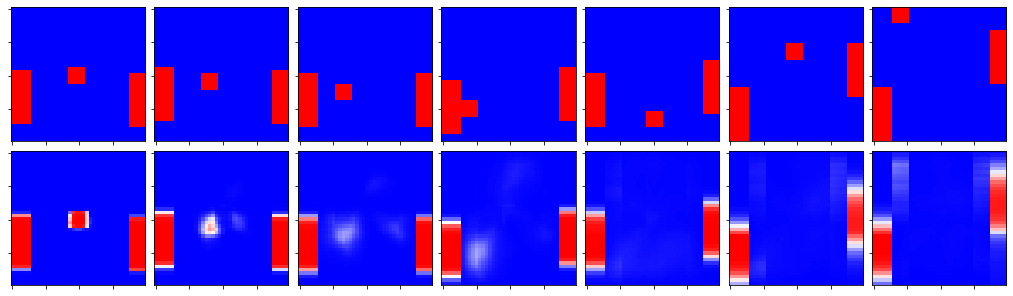

Epoch 550/2500
100/100 [==============================] - 51s 506ms/step - loss: 0.0936 - mean_squared_error: 0.0251 - acc: 0.9680 - val_loss: 0.0856 - val_mean_squared_error: 0.0230 - val_acc: 0.9702


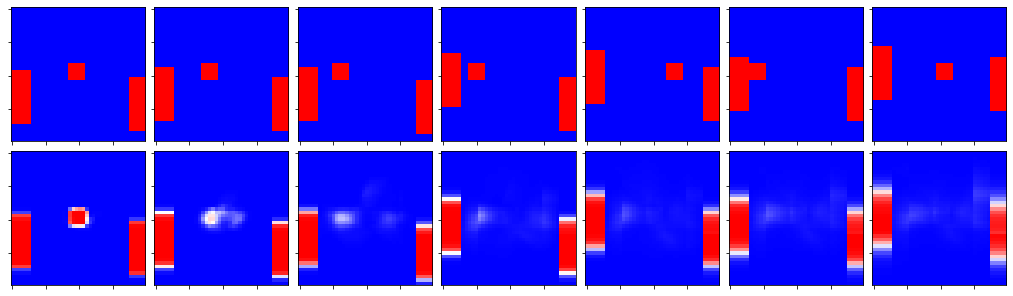

Epoch 551/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0925 - mean_squared_error: 0.0248 - acc: 0.9685 - val_loss: 0.1004 - val_mean_squared_error: 0.0272 - val_acc: 0.9653


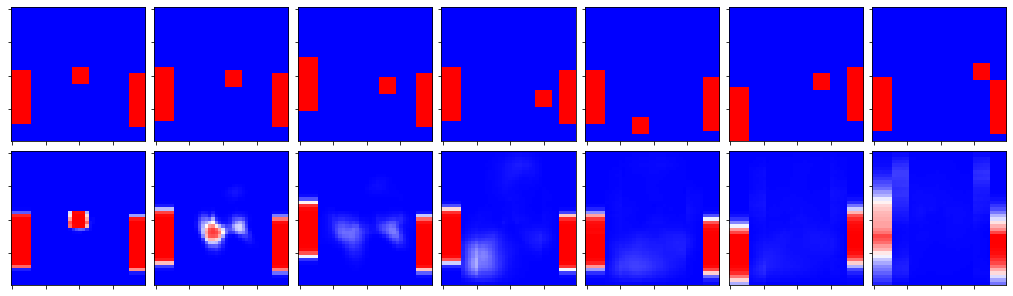

Epoch 552/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0934 - mean_squared_error: 0.0251 - acc: 0.9681 - val_loss: 0.0929 - val_mean_squared_error: 0.0255 - val_acc: 0.9672


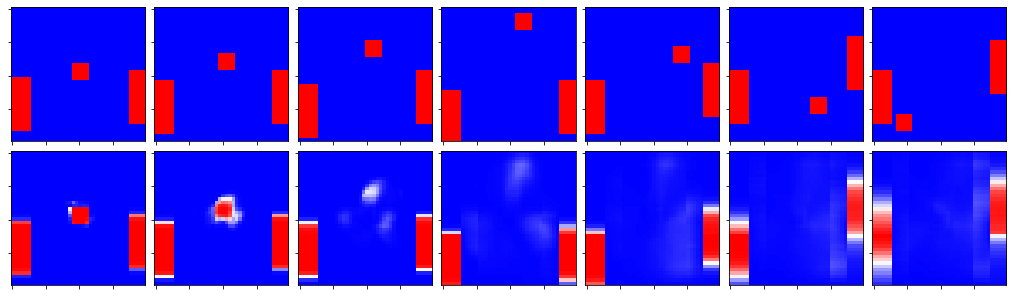

Epoch 553/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0937 - mean_squared_error: 0.0251 - acc: 0.9680 - val_loss: 0.0880 - val_mean_squared_error: 0.0235 - val_acc: 0.9705


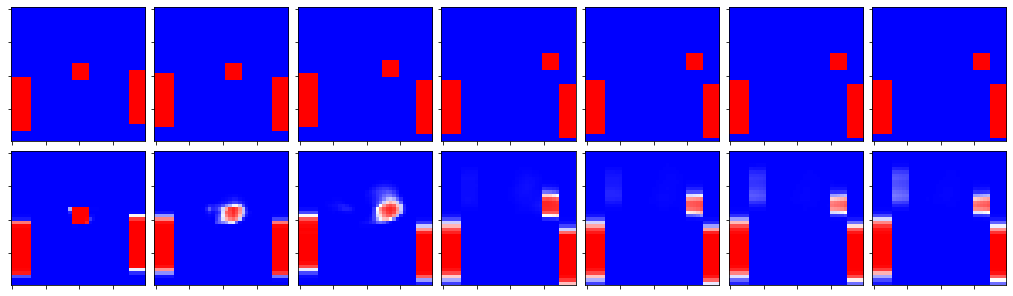

Epoch 554/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.0925 - mean_squared_error: 0.0248 - acc: 0.9683 - val_loss: 0.0967 - val_mean_squared_error: 0.0256 - val_acc: 0.9677


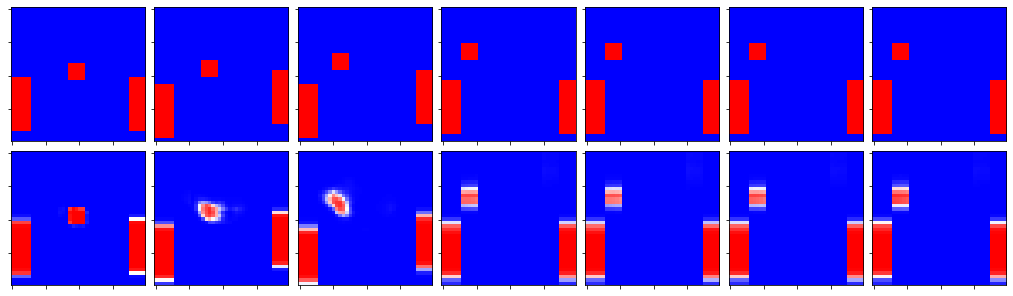

Epoch 555/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0911 - mean_squared_error: 0.0243 - acc: 0.9690 - val_loss: 0.0879 - val_mean_squared_error: 0.0240 - val_acc: 0.9692


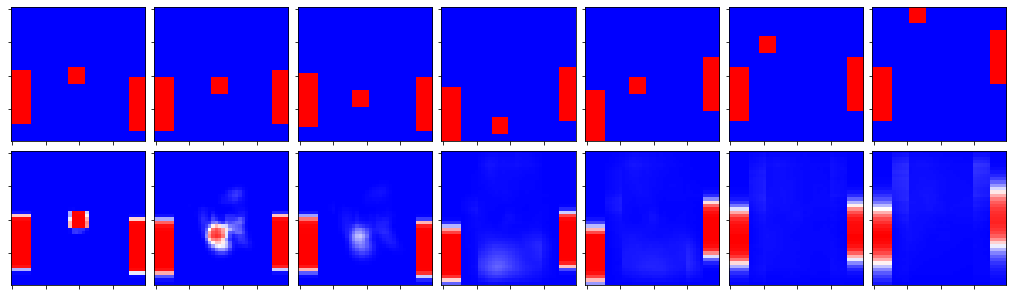

Epoch 556/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.0920 - mean_squared_error: 0.0246 - acc: 0.9688 - val_loss: 0.0834 - val_mean_squared_error: 0.0223 - val_acc: 0.9716


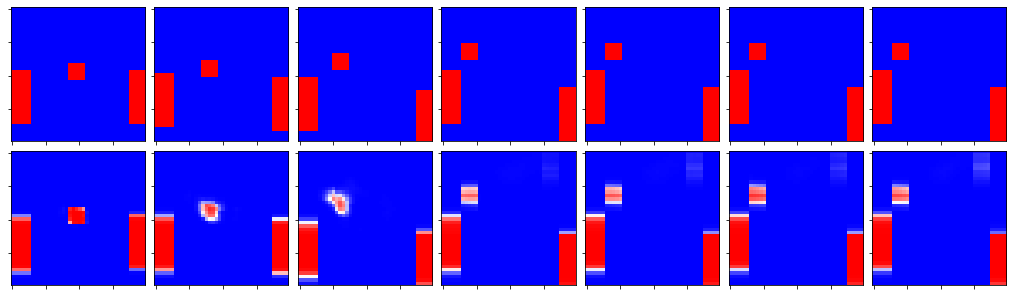

Epoch 557/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0915 - mean_squared_error: 0.0245 - acc: 0.9688 - val_loss: 0.0923 - val_mean_squared_error: 0.0245 - val_acc: 0.9691


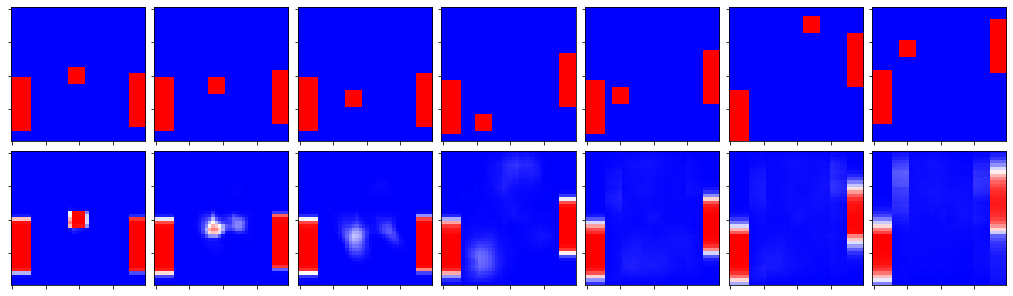

Epoch 558/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0915 - mean_squared_error: 0.0245 - acc: 0.9688 - val_loss: 0.0949 - val_mean_squared_error: 0.0252 - val_acc: 0.9681


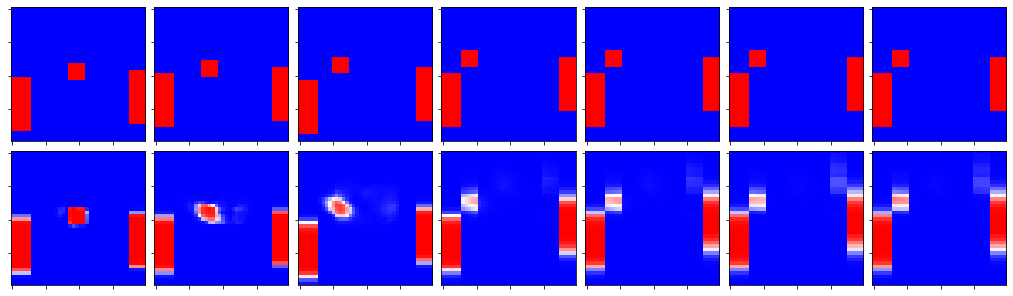

Epoch 559/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0918 - mean_squared_error: 0.0246 - acc: 0.9686 - val_loss: 0.0875 - val_mean_squared_error: 0.0232 - val_acc: 0.9704


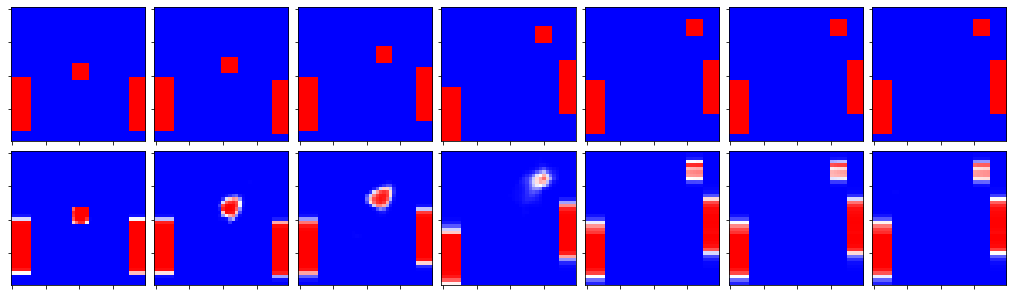

Epoch 560/2500
100/100 [==============================] - 50s 495ms/step - loss: 0.0906 - mean_squared_error: 0.0242 - acc: 0.9692 - val_loss: 0.0923 - val_mean_squared_error: 0.0246 - val_acc: 0.9684


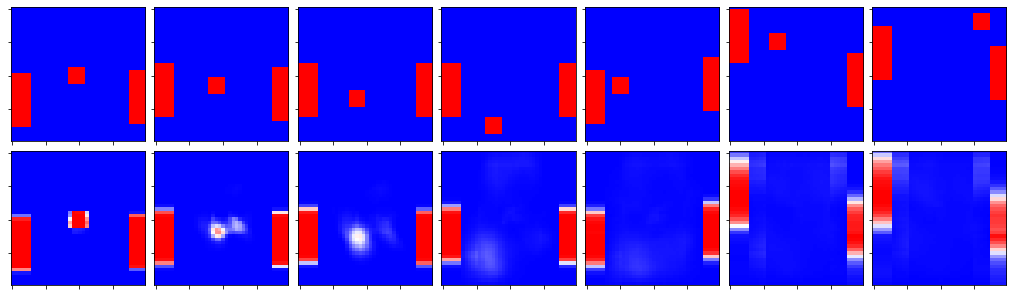

Epoch 561/2500
100/100 [==============================] - 49s 493ms/step - loss: 0.0922 - mean_squared_error: 0.0246 - acc: 0.9686 - val_loss: 0.0850 - val_mean_squared_error: 0.0233 - val_acc: 0.9700


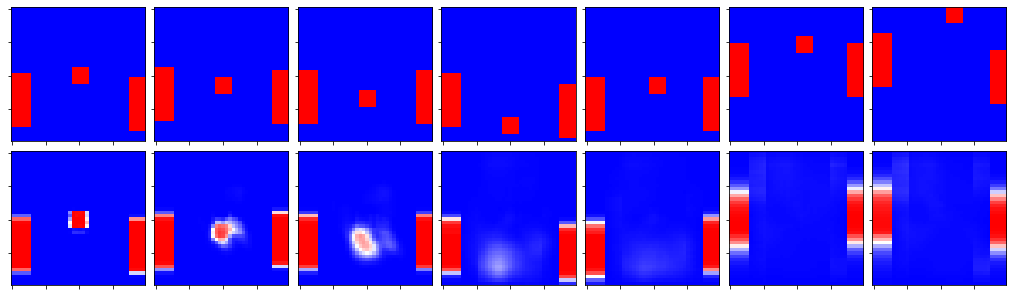

Epoch 562/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0905 - mean_squared_error: 0.0243 - acc: 0.9691 - val_loss: 0.0921 - val_mean_squared_error: 0.0246 - val_acc: 0.9689


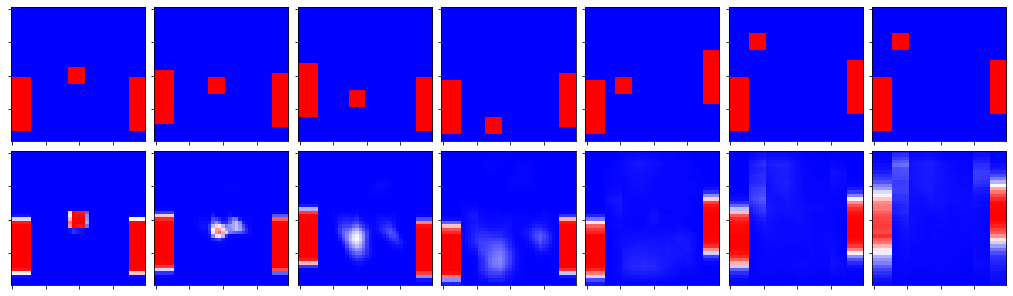

Epoch 563/2500
100/100 [==============================] - 49s 495ms/step - loss: 0.0940 - mean_squared_error: 0.0252 - acc: 0.9679 - val_loss: 0.0969 - val_mean_squared_error: 0.0263 - val_acc: 0.9658


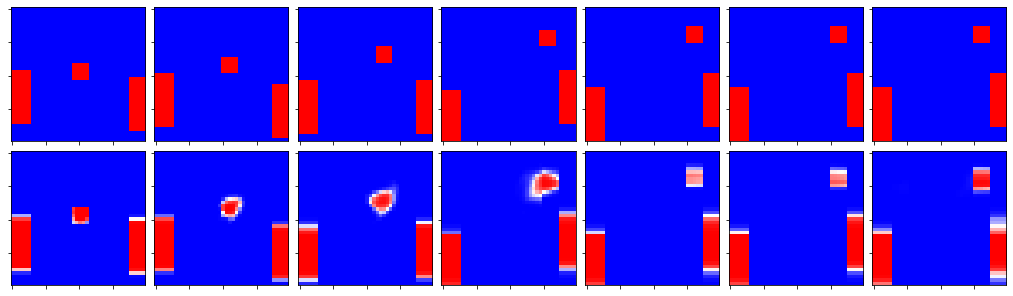

Epoch 564/2500
100/100 [==============================] - 50s 497ms/step - loss: 0.0928 - mean_squared_error: 0.0250 - acc: 0.9680 - val_loss: 0.0985 - val_mean_squared_error: 0.0258 - val_acc: 0.9679


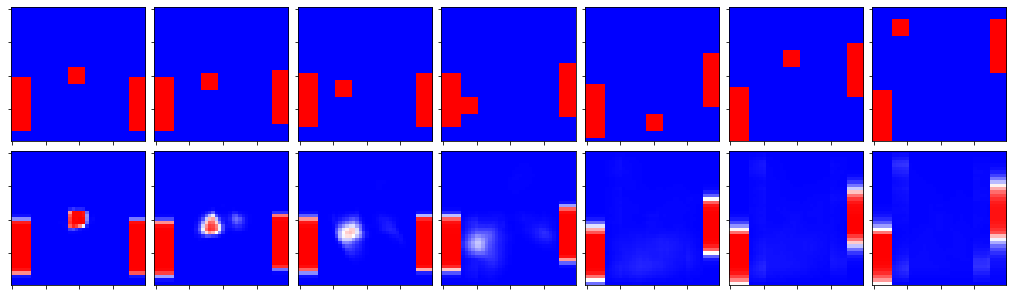

Epoch 565/2500
100/100 [==============================] - 50s 496ms/step - loss: 0.0904 - mean_squared_error: 0.0242 - acc: 0.9692 - val_loss: 0.0981 - val_mean_squared_error: 0.0246 - val_acc: 0.9691


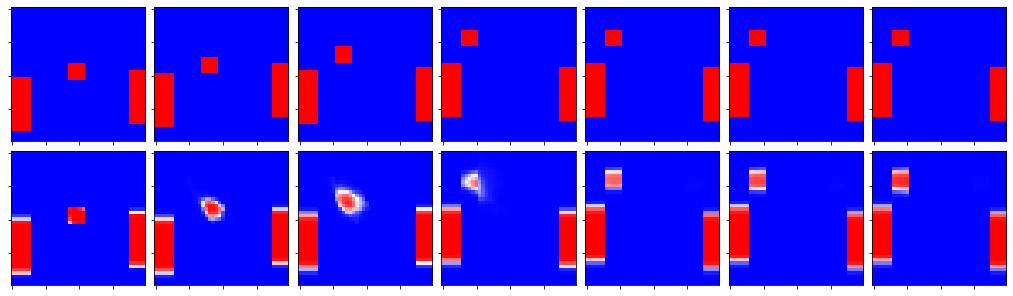

Epoch 566/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0904 - mean_squared_error: 0.0241 - acc: 0.9693 - val_loss: 0.0893 - val_mean_squared_error: 0.0238 - val_acc: 0.9696


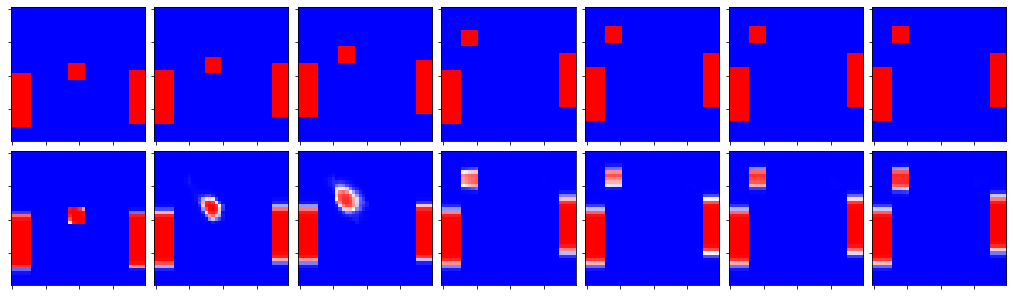

Epoch 567/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0900 - mean_squared_error: 0.0241 - acc: 0.9693 - val_loss: 0.0856 - val_mean_squared_error: 0.0230 - val_acc: 0.9705


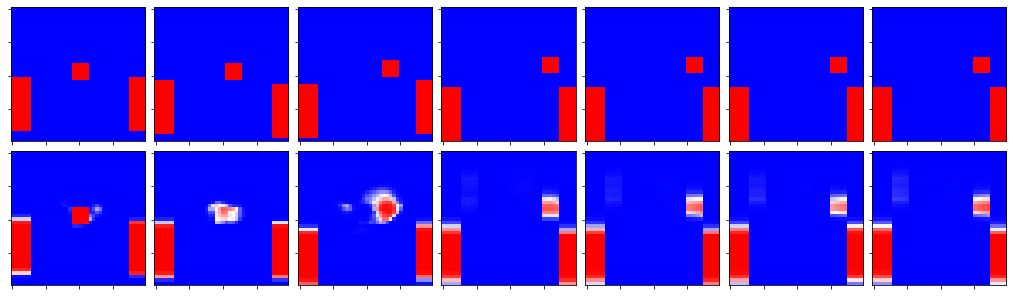

Epoch 568/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0894 - mean_squared_error: 0.0240 - acc: 0.9694 - val_loss: 0.0975 - val_mean_squared_error: 0.0259 - val_acc: 0.9667


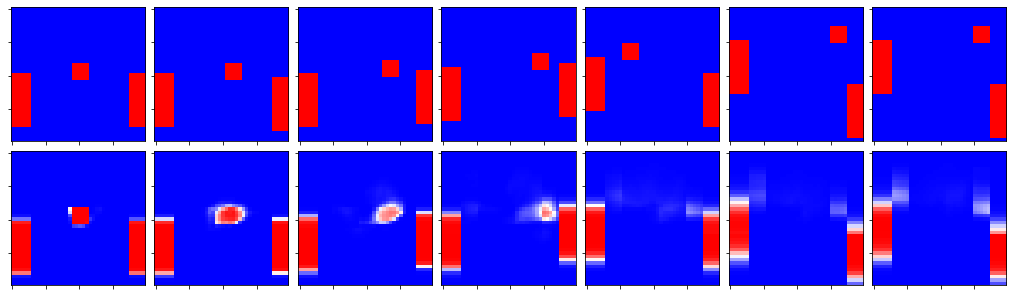

Epoch 569/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0899 - mean_squared_error: 0.0241 - acc: 0.9692 - val_loss: 0.0930 - val_mean_squared_error: 0.0255 - val_acc: 0.9667


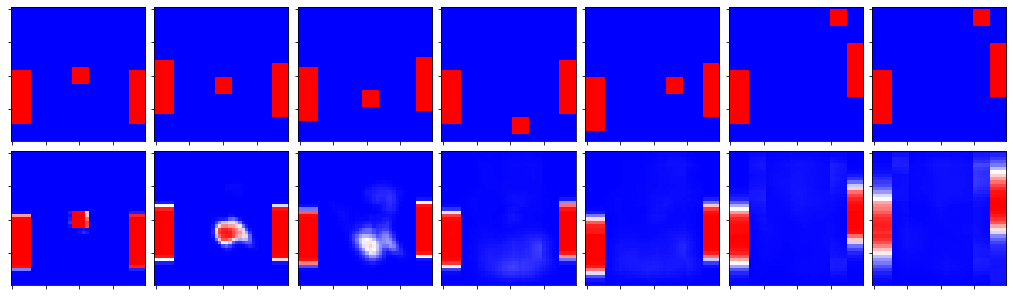

Epoch 570/2500
100/100 [==============================] - 51s 507ms/step - loss: 0.0900 - mean_squared_error: 0.0241 - acc: 0.9692 - val_loss: 0.0911 - val_mean_squared_error: 0.0243 - val_acc: 0.9691


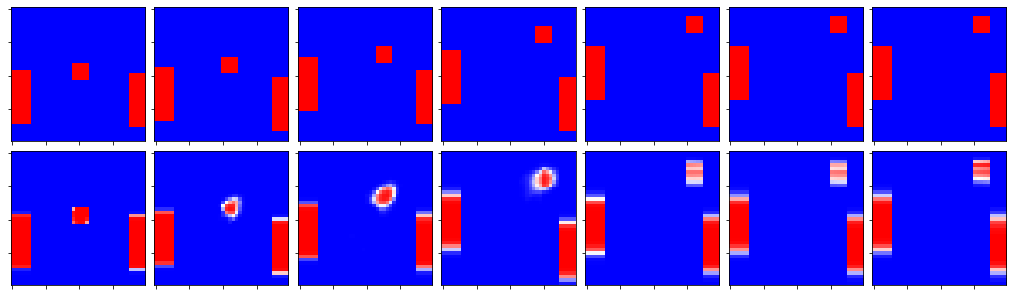

Epoch 571/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0880 - mean_squared_error: 0.0234 - acc: 0.9703 - val_loss: 0.0910 - val_mean_squared_error: 0.0251 - val_acc: 0.9676


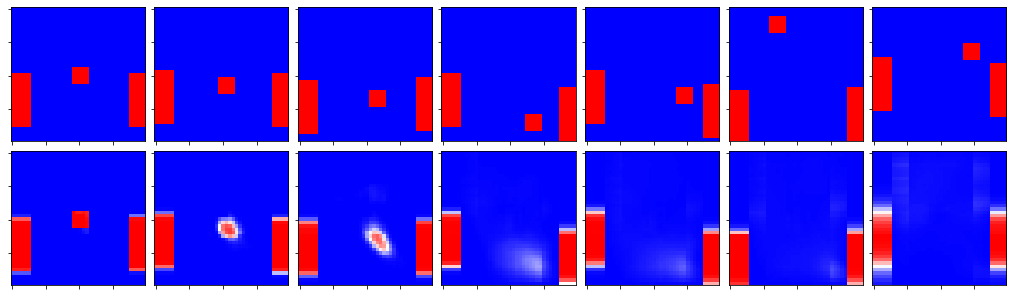

Epoch 572/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.0882 - mean_squared_error: 0.0236 - acc: 0.9700 - val_loss: 0.0860 - val_mean_squared_error: 0.0232 - val_acc: 0.9708


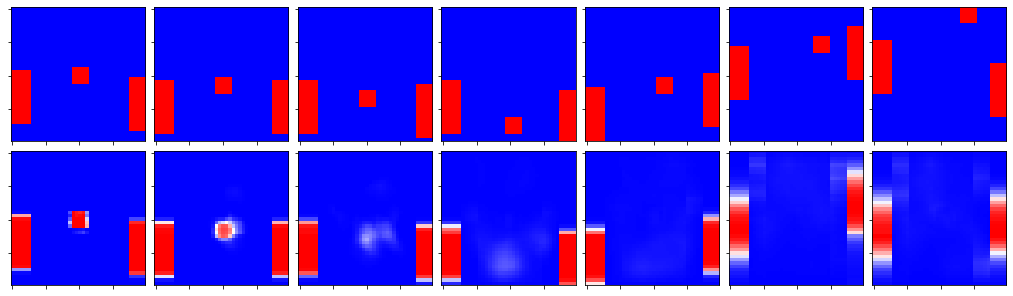

Epoch 573/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.0878 - mean_squared_error: 0.0234 - acc: 0.9702 - val_loss: 0.0991 - val_mean_squared_error: 0.0257 - val_acc: 0.9678


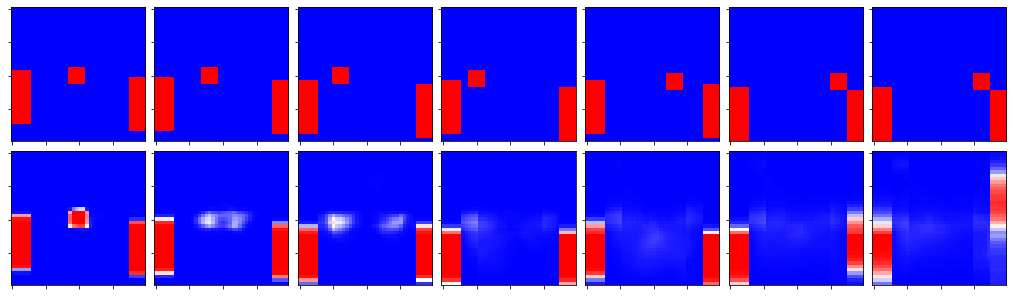

Epoch 574/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.0903 - mean_squared_error: 0.0243 - acc: 0.9691 - val_loss: 0.0867 - val_mean_squared_error: 0.0238 - val_acc: 0.9692


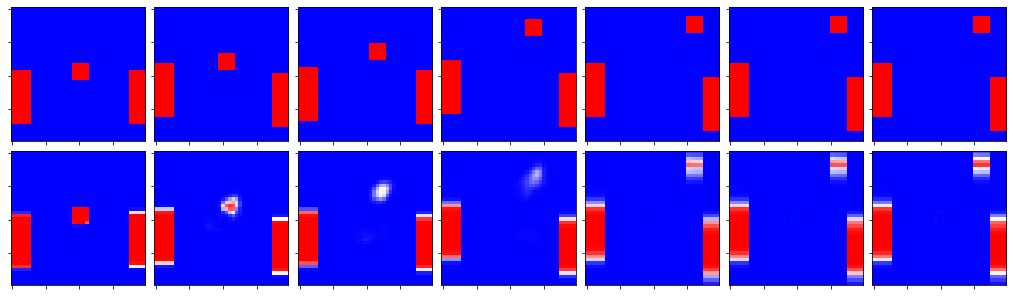

Epoch 575/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0882 - mean_squared_error: 0.0237 - acc: 0.9699 - val_loss: 0.0883 - val_mean_squared_error: 0.0236 - val_acc: 0.9700


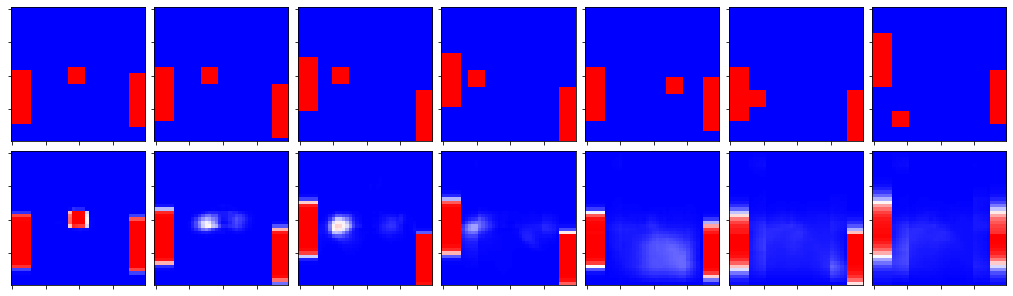

Epoch 576/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.0872 - mean_squared_error: 0.0234 - acc: 0.9702 - val_loss: 0.0880 - val_mean_squared_error: 0.0237 - val_acc: 0.9693


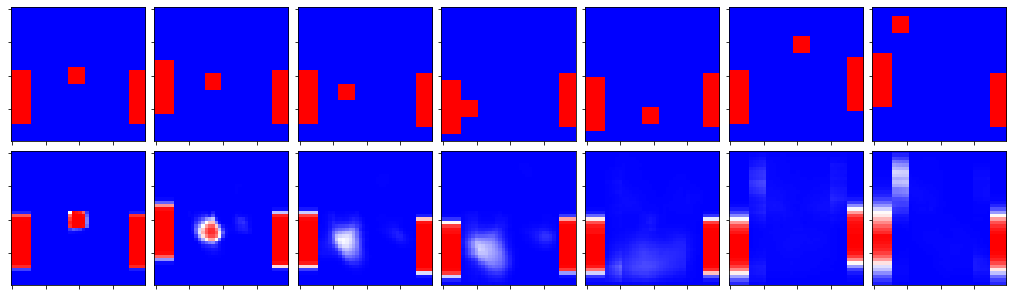

Epoch 577/2500
100/100 [==============================] - 50s 504ms/step - loss: 0.0874 - mean_squared_error: 0.0235 - acc: 0.9701 - val_loss: 0.0921 - val_mean_squared_error: 0.0249 - val_acc: 0.9680


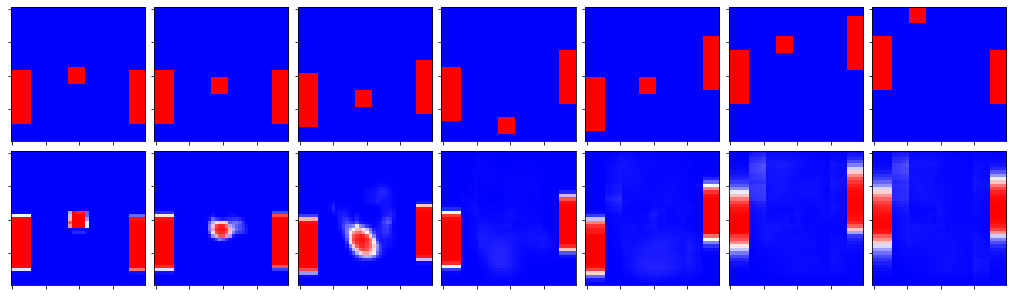

Epoch 578/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0888 - mean_squared_error: 0.0239 - acc: 0.9696 - val_loss: 0.0843 - val_mean_squared_error: 0.0229 - val_acc: 0.9709


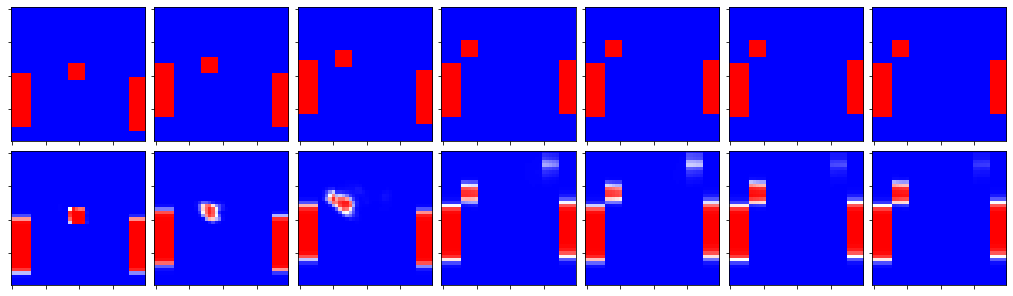

Epoch 579/2500
100/100 [==============================] - 51s 507ms/step - loss: 0.0868 - mean_squared_error: 0.0233 - acc: 0.9703 - val_loss: 0.0867 - val_mean_squared_error: 0.0236 - val_acc: 0.9699


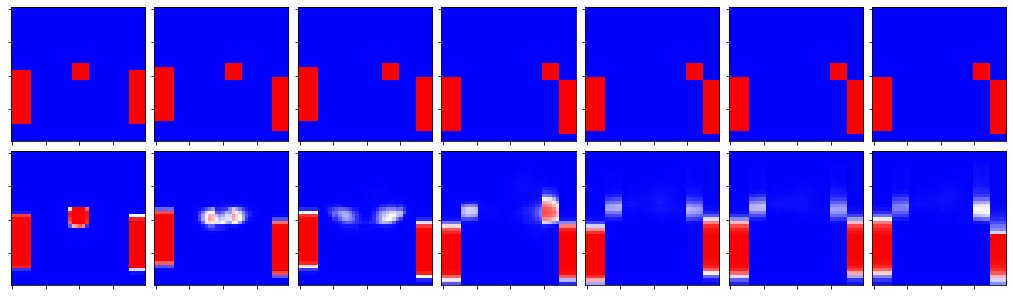

Epoch 580/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.0862 - mean_squared_error: 0.0232 - acc: 0.9704 - val_loss: 0.0877 - val_mean_squared_error: 0.0234 - val_acc: 0.9705


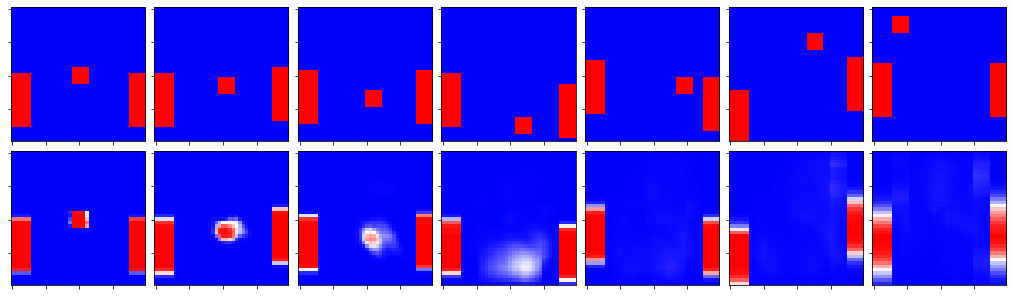

Epoch 581/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0866 - mean_squared_error: 0.0233 - acc: 0.9703 - val_loss: 0.0973 - val_mean_squared_error: 0.0266 - val_acc: 0.9657


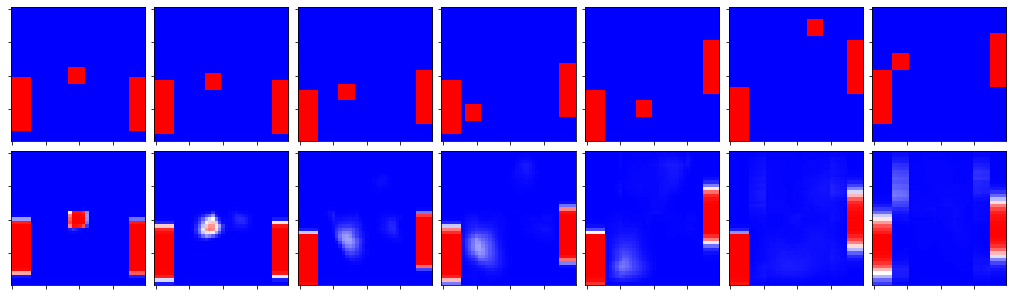

Epoch 582/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.1255 - mean_squared_error: 0.0329 - acc: 0.9579 - val_loss: 0.1430 - val_mean_squared_error: 0.0381 - val_acc: 0.9505


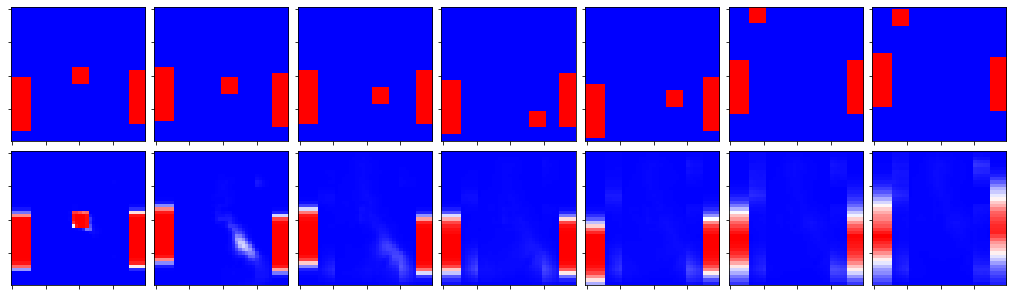

Epoch 583/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.1275 - mean_squared_error: 0.0345 - acc: 0.9556 - val_loss: 0.1152 - val_mean_squared_error: 0.0313 - val_acc: 0.9589


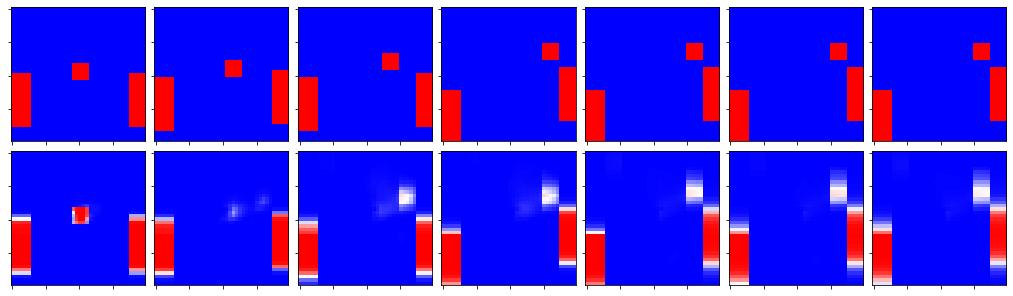

Epoch 584/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.1133 - mean_squared_error: 0.0305 - acc: 0.9610 - val_loss: 0.1105 - val_mean_squared_error: 0.0296 - val_acc: 0.9622


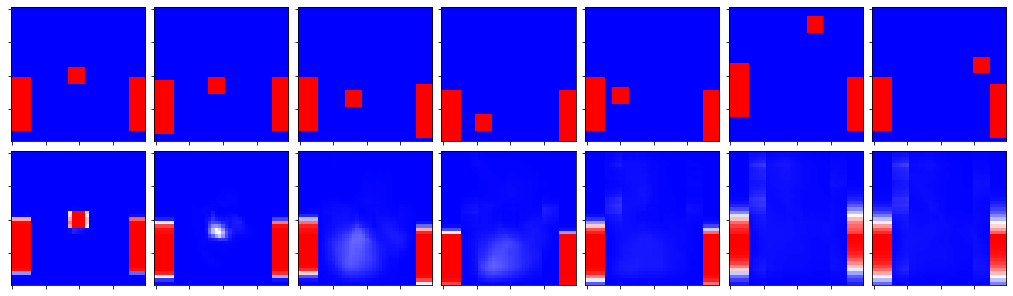

Epoch 585/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.1062 - mean_squared_error: 0.0286 - acc: 0.9635 - val_loss: 0.0974 - val_mean_squared_error: 0.0261 - val_acc: 0.9664


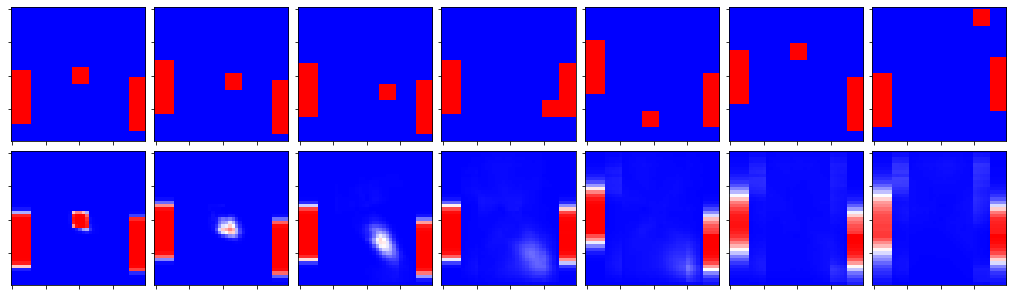

Epoch 586/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.1008 - mean_squared_error: 0.0270 - acc: 0.9655 - val_loss: 0.1072 - val_mean_squared_error: 0.0293 - val_acc: 0.9627


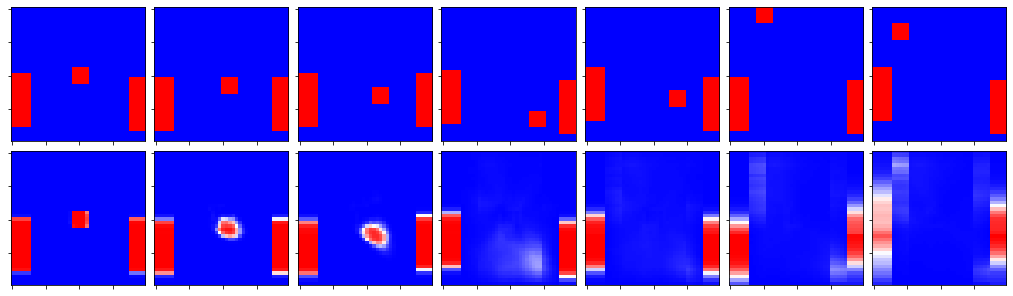

Epoch 587/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0989 - mean_squared_error: 0.0266 - acc: 0.9660 - val_loss: 0.1009 - val_mean_squared_error: 0.0271 - val_acc: 0.9655


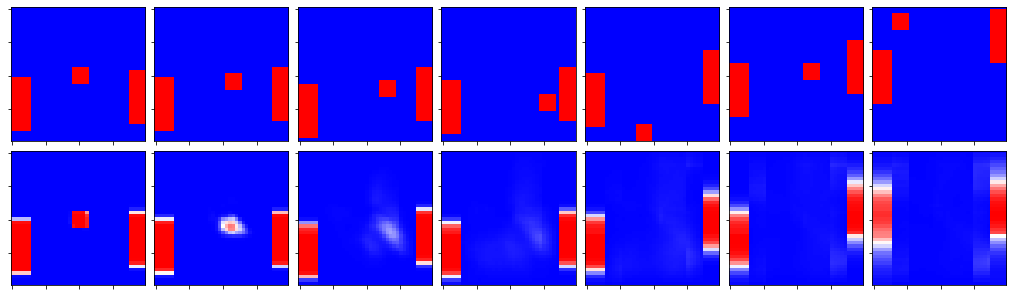

Epoch 588/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0972 - mean_squared_error: 0.0261 - acc: 0.9668 - val_loss: 0.0908 - val_mean_squared_error: 0.0244 - val_acc: 0.9694


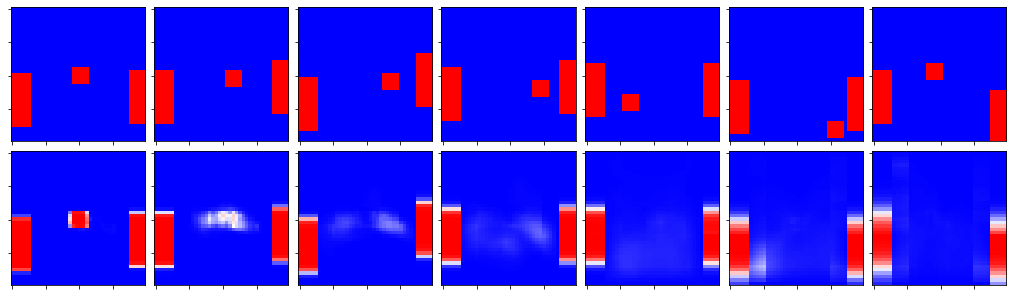

Epoch 589/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0954 - mean_squared_error: 0.0256 - acc: 0.9673 - val_loss: 0.1037 - val_mean_squared_error: 0.0274 - val_acc: 0.9654


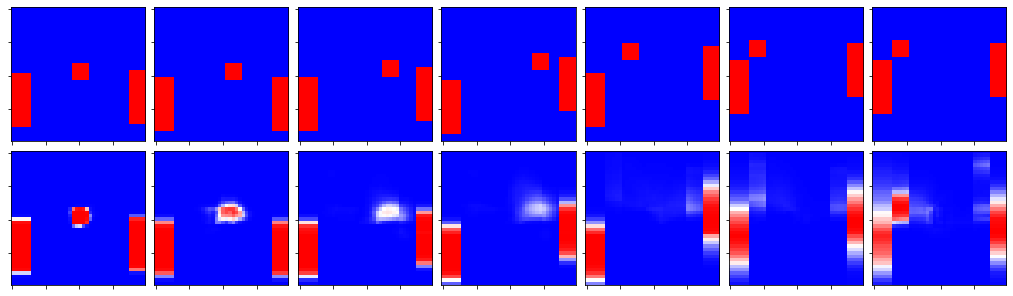

Epoch 590/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0954 - mean_squared_error: 0.0257 - acc: 0.9673 - val_loss: 0.0907 - val_mean_squared_error: 0.0247 - val_acc: 0.9680


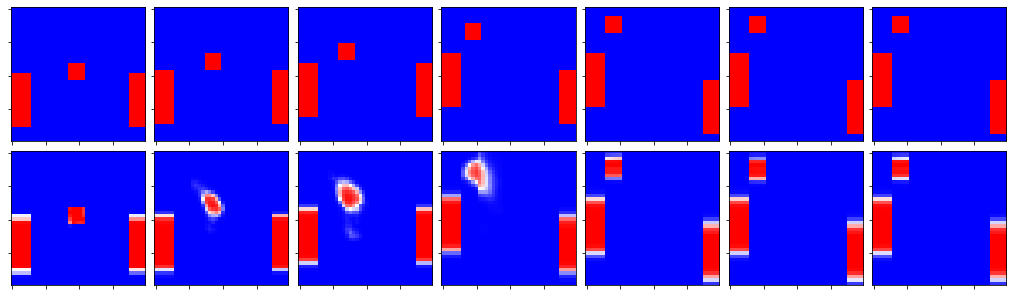

Epoch 591/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0945 - mean_squared_error: 0.0253 - acc: 0.9678 - val_loss: 0.0953 - val_mean_squared_error: 0.0253 - val_acc: 0.9680


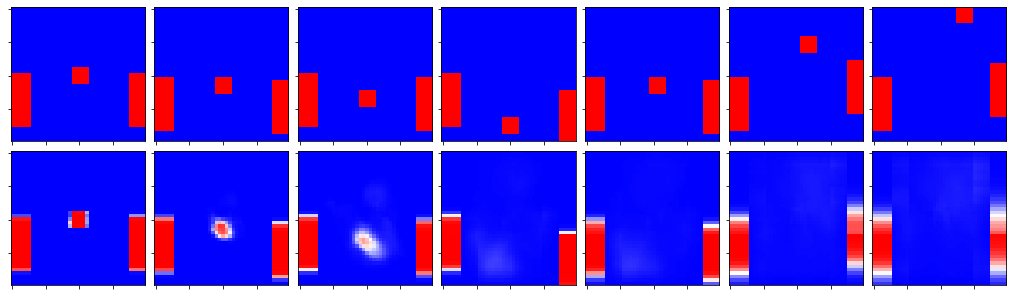

Epoch 592/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.0921 - mean_squared_error: 0.0247 - acc: 0.9686 - val_loss: 0.0880 - val_mean_squared_error: 0.0241 - val_acc: 0.9690


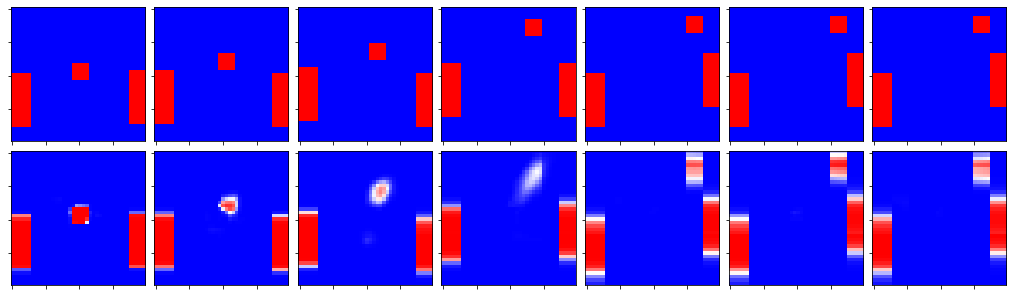

Epoch 593/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0907 - mean_squared_error: 0.0243 - acc: 0.9692 - val_loss: 0.0949 - val_mean_squared_error: 0.0254 - val_acc: 0.9677


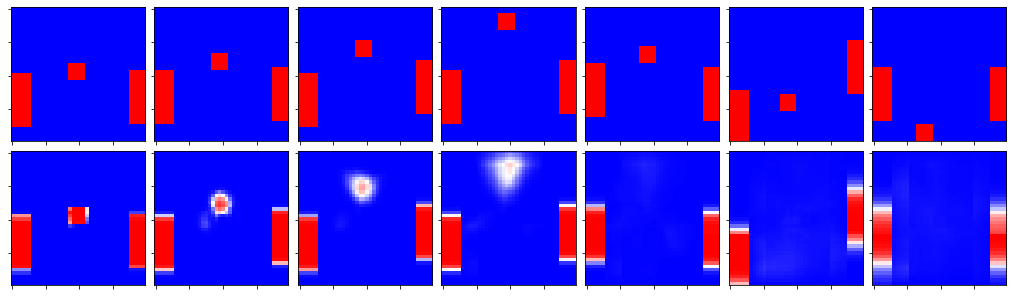

Epoch 594/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.0900 - mean_squared_error: 0.0241 - acc: 0.9694 - val_loss: 0.0889 - val_mean_squared_error: 0.0238 - val_acc: 0.9697


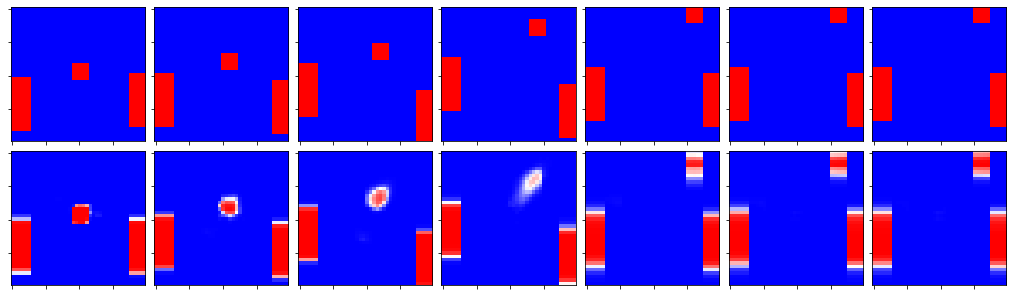

Epoch 595/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0900 - mean_squared_error: 0.0240 - acc: 0.9696 - val_loss: 0.0871 - val_mean_squared_error: 0.0229 - val_acc: 0.9709


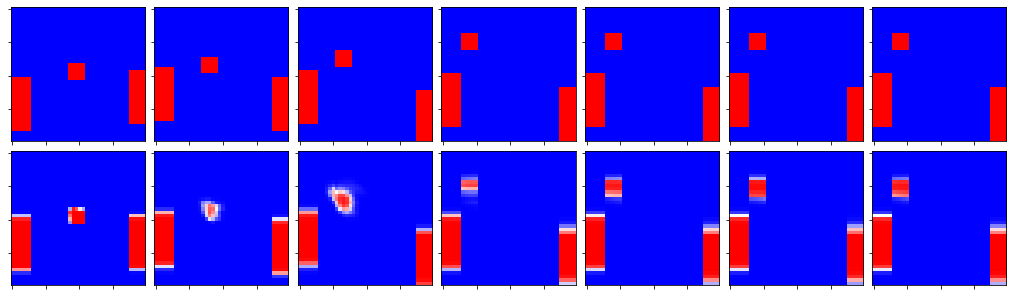

Epoch 596/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.0888 - mean_squared_error: 0.0238 - acc: 0.9697 - val_loss: 0.0895 - val_mean_squared_error: 0.0243 - val_acc: 0.9686


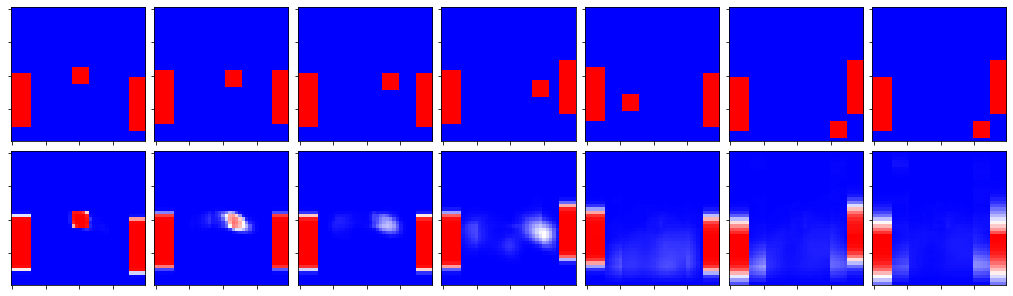

Epoch 597/2500
100/100 [==============================] - 51s 506ms/step - loss: 0.0883 - mean_squared_error: 0.0236 - acc: 0.9702 - val_loss: 0.0898 - val_mean_squared_error: 0.0239 - val_acc: 0.9700


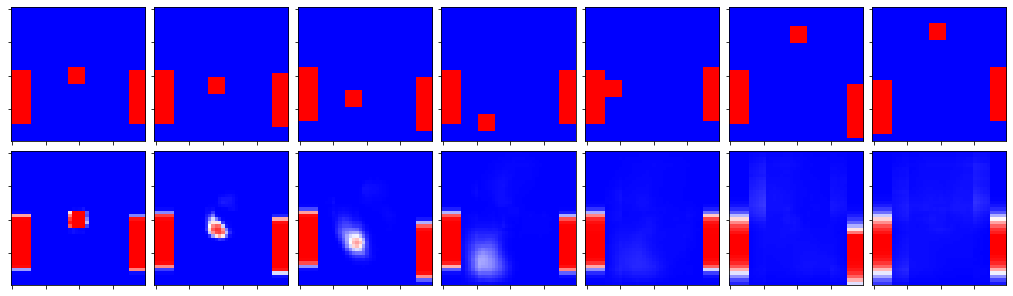

Epoch 598/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0886 - mean_squared_error: 0.0238 - acc: 0.9699 - val_loss: 0.0872 - val_mean_squared_error: 0.0234 - val_acc: 0.9704


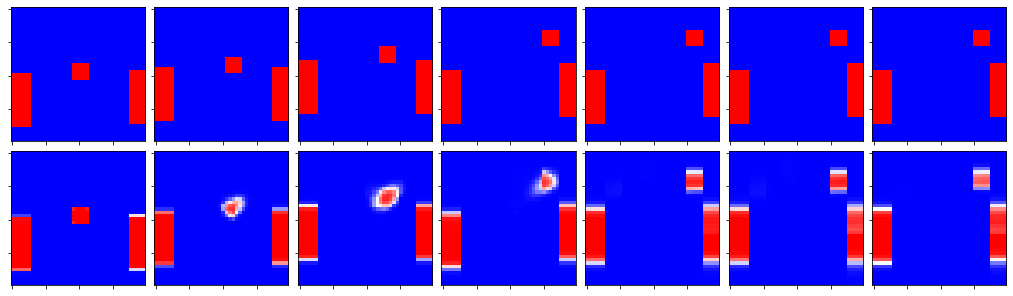

Epoch 599/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0899 - mean_squared_error: 0.0242 - acc: 0.9693 - val_loss: 0.0910 - val_mean_squared_error: 0.0244 - val_acc: 0.9690


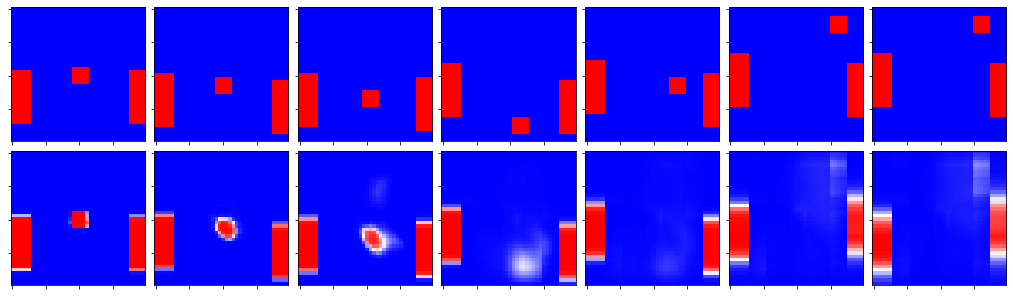

Epoch 600/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0872 - mean_squared_error: 0.0234 - acc: 0.9703 - val_loss: 0.0906 - val_mean_squared_error: 0.0248 - val_acc: 0.9681


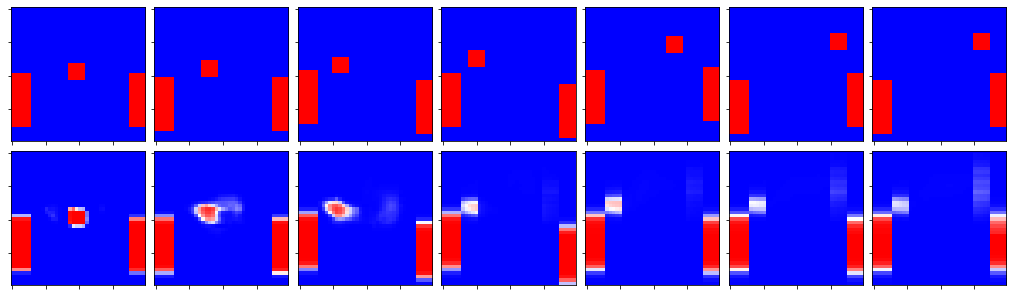

Epoch 601/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0863 - mean_squared_error: 0.0231 - acc: 0.9707 - val_loss: 0.0932 - val_mean_squared_error: 0.0250 - val_acc: 0.9680


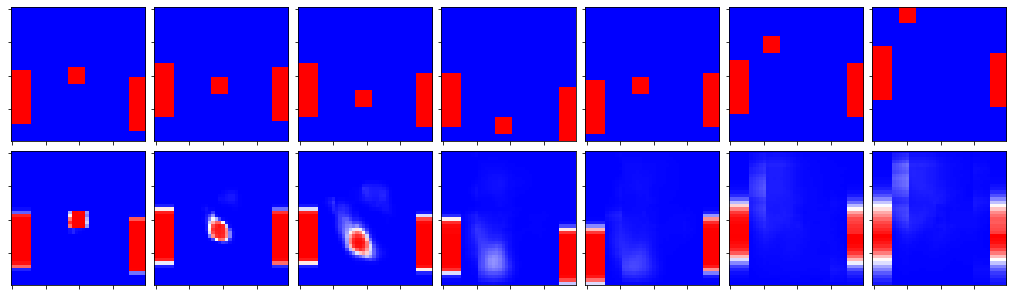

Epoch 602/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.0872 - mean_squared_error: 0.0233 - acc: 0.9706 - val_loss: 0.0805 - val_mean_squared_error: 0.0214 - val_acc: 0.9732


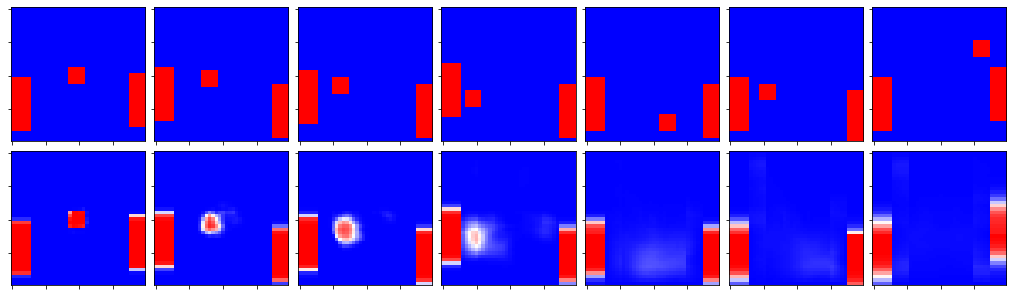

Epoch 603/2500
100/100 [==============================] - 51s 506ms/step - loss: 0.0848 - mean_squared_error: 0.0227 - acc: 0.9713 - val_loss: 0.0931 - val_mean_squared_error: 0.0241 - val_acc: 0.9701


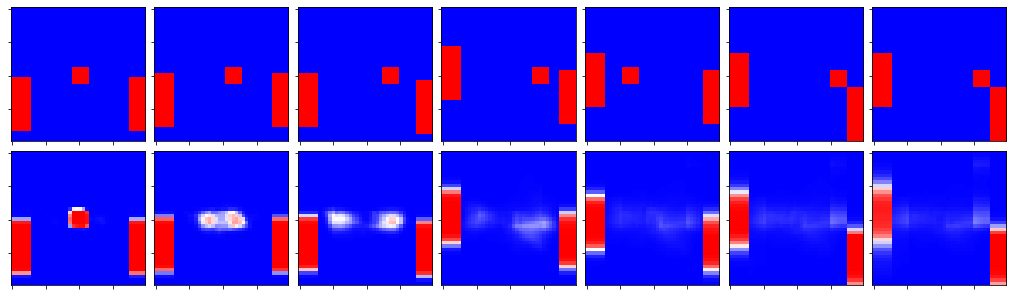

Epoch 604/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0852 - mean_squared_error: 0.0227 - acc: 0.9712 - val_loss: 0.0840 - val_mean_squared_error: 0.0224 - val_acc: 0.9720


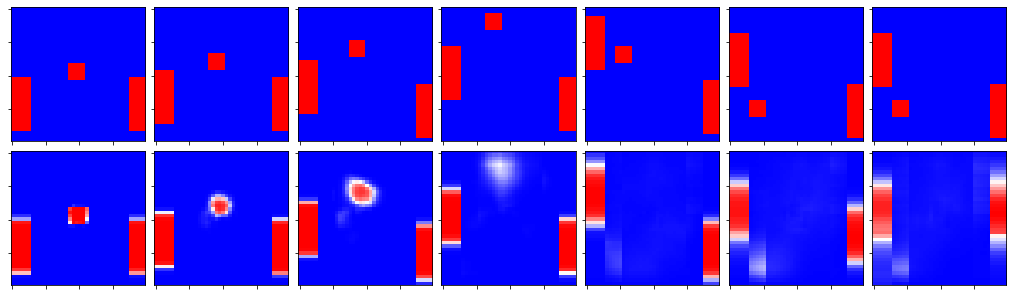

Epoch 605/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0853 - mean_squared_error: 0.0229 - acc: 0.9709 - val_loss: 0.0878 - val_mean_squared_error: 0.0234 - val_acc: 0.9704


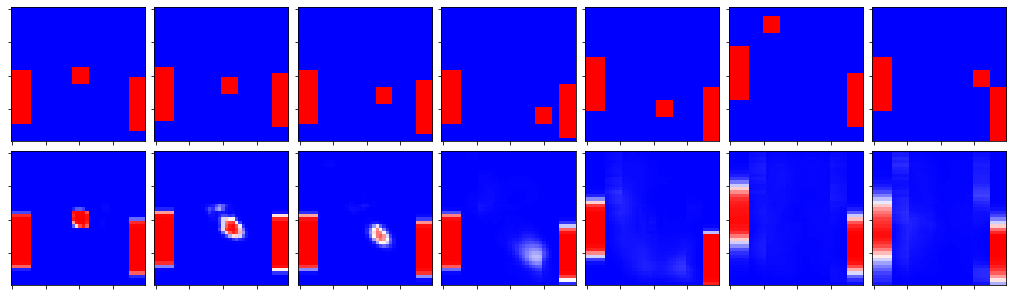

Epoch 606/2500
100/100 [==============================] - 51s 506ms/step - loss: 0.0870 - mean_squared_error: 0.0234 - acc: 0.9701 - val_loss: 0.0847 - val_mean_squared_error: 0.0227 - val_acc: 0.9712


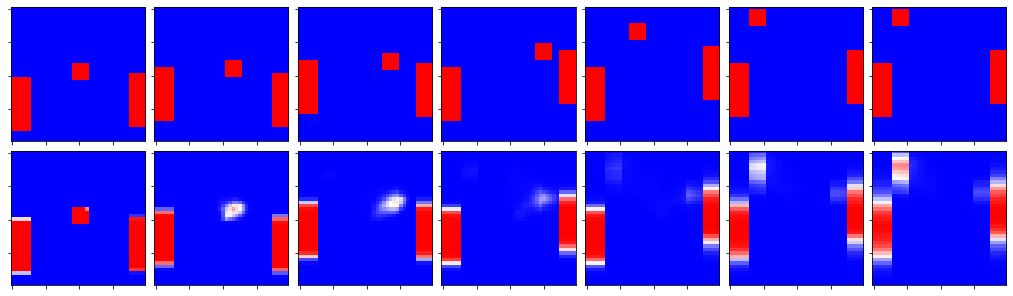

Epoch 607/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.0847 - mean_squared_error: 0.0227 - acc: 0.9712 - val_loss: 0.0865 - val_mean_squared_error: 0.0234 - val_acc: 0.9702


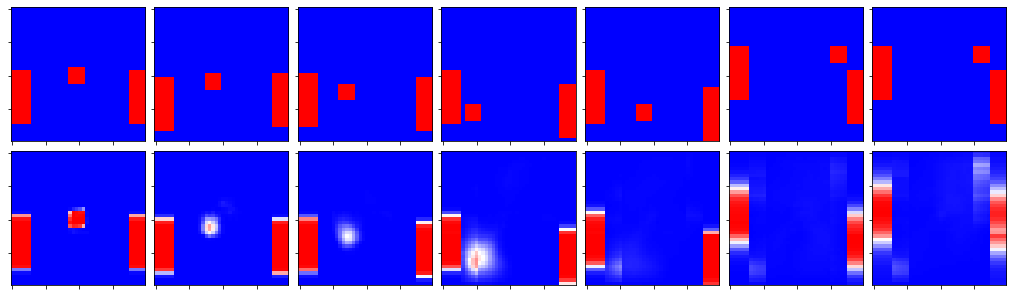

Epoch 608/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0859 - mean_squared_error: 0.0229 - acc: 0.9709 - val_loss: 0.0864 - val_mean_squared_error: 0.0230 - val_acc: 0.9711


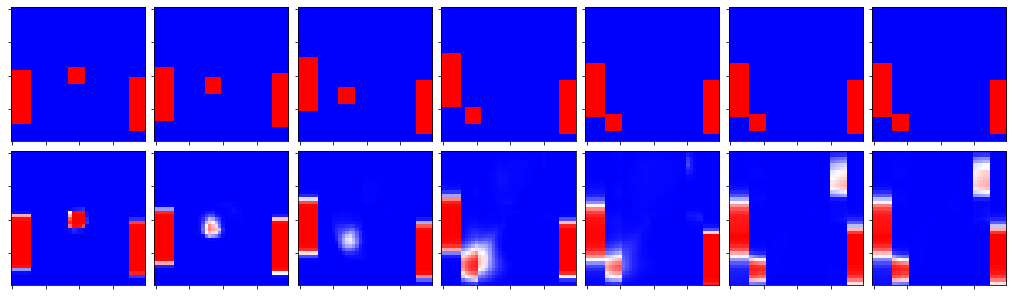

Epoch 609/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0866 - mean_squared_error: 0.0233 - acc: 0.9705 - val_loss: 0.0744 - val_mean_squared_error: 0.0200 - val_acc: 0.9748


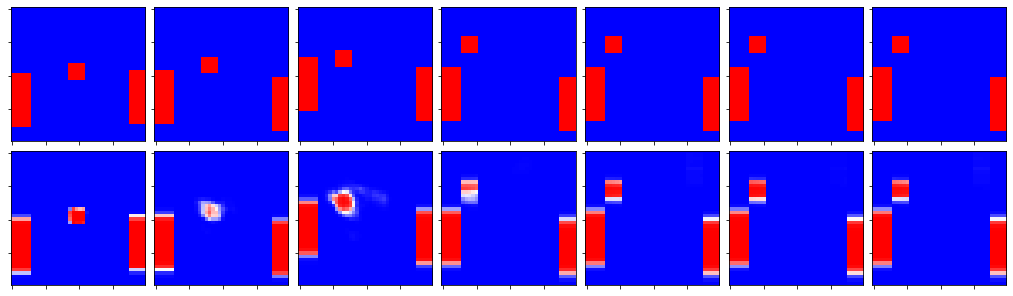

Epoch 610/2500
100/100 [==============================] - 50s 505ms/step - loss: 0.0829 - mean_squared_error: 0.0222 - acc: 0.9720 - val_loss: 0.0805 - val_mean_squared_error: 0.0219 - val_acc: 0.9718


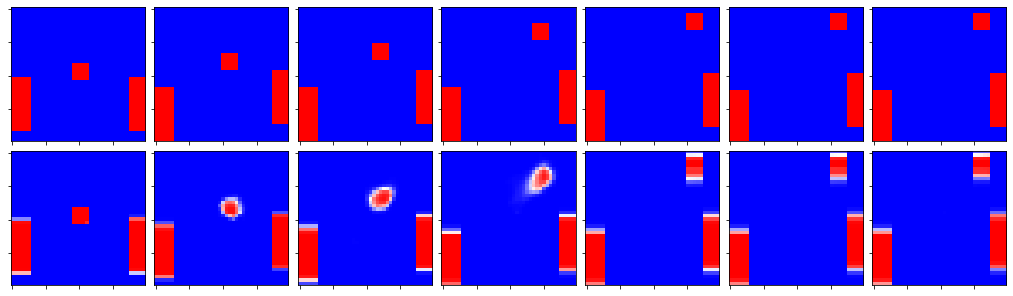

Epoch 611/2500
100/100 [==============================] - 51s 505ms/step - loss: 0.0846 - mean_squared_error: 0.0226 - acc: 0.9713 - val_loss: 0.0903 - val_mean_squared_error: 0.0247 - val_acc: 0.9680


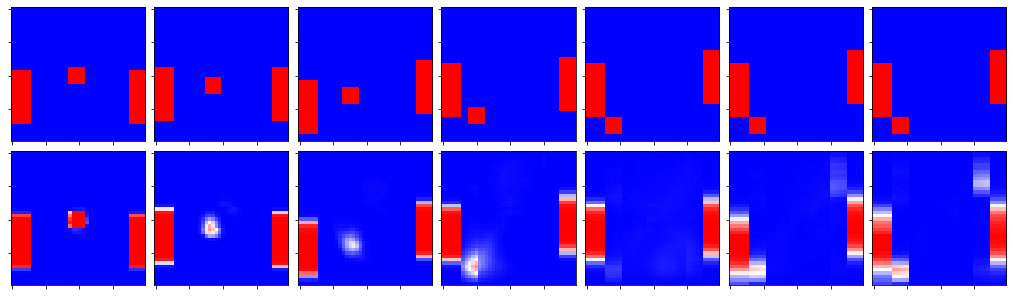

Epoch 612/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.0835 - mean_squared_error: 0.0224 - acc: 0.9716 - val_loss: 0.0825 - val_mean_squared_error: 0.0224 - val_acc: 0.9717


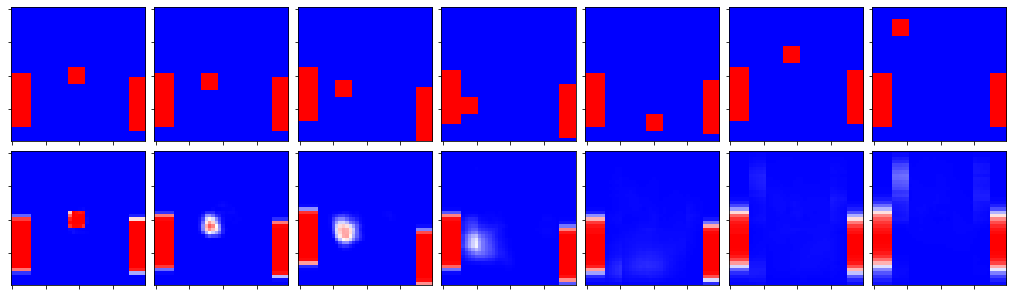

Epoch 613/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0843 - mean_squared_error: 0.0226 - acc: 0.9714 - val_loss: 0.0944 - val_mean_squared_error: 0.0252 - val_acc: 0.9682


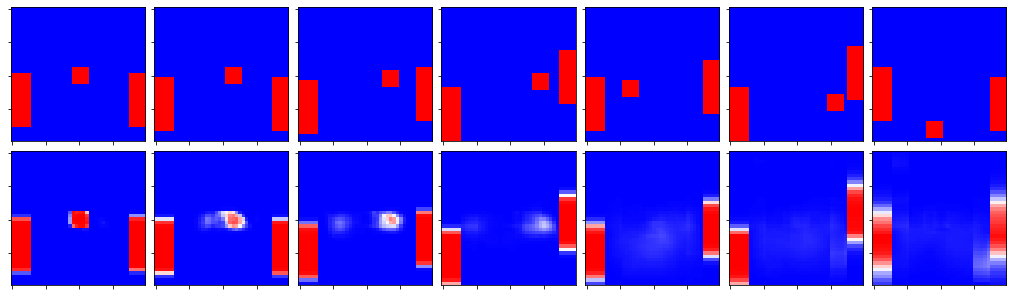

Epoch 614/2500
100/100 [==============================] - 50s 499ms/step - loss: 0.0856 - mean_squared_error: 0.0229 - acc: 0.9710 - val_loss: 0.0807 - val_mean_squared_error: 0.0216 - val_acc: 0.9724


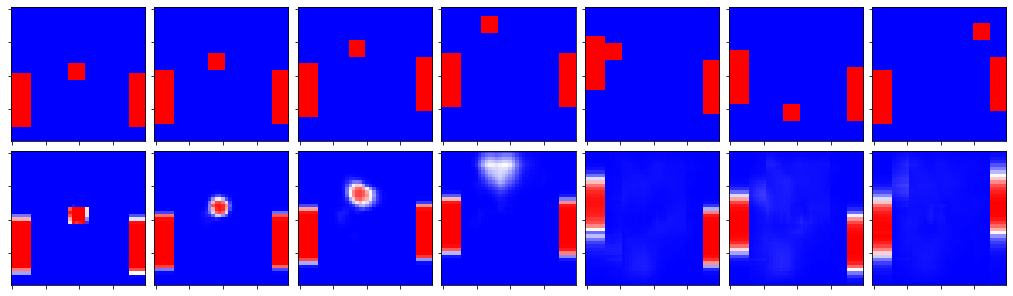

Epoch 615/2500
100/100 [==============================] - 51s 508ms/step - loss: 0.0840 - mean_squared_error: 0.0226 - acc: 0.9712 - val_loss: 0.0815 - val_mean_squared_error: 0.0221 - val_acc: 0.9717


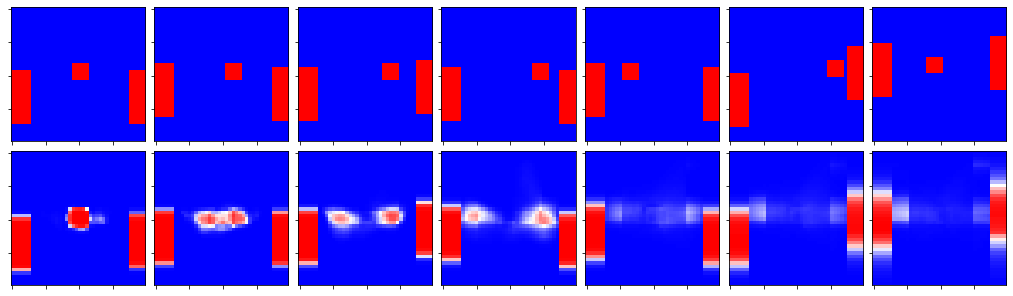

Epoch 616/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0839 - mean_squared_error: 0.0225 - acc: 0.9715 - val_loss: 0.0854 - val_mean_squared_error: 0.0228 - val_acc: 0.9712


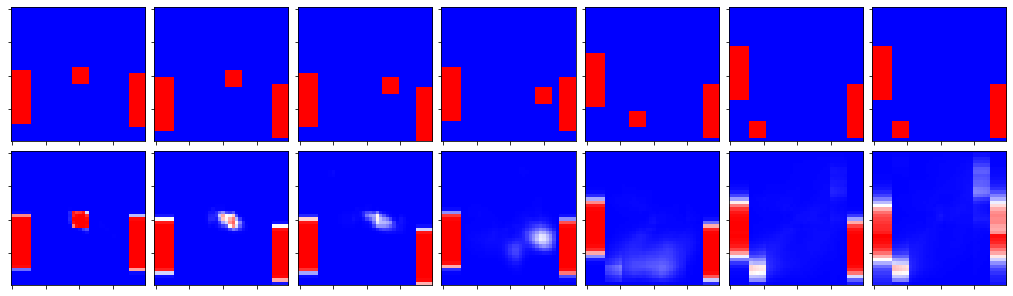

Epoch 617/2500
100/100 [==============================] - 50s 501ms/step - loss: 0.0849 - mean_squared_error: 0.0227 - acc: 0.9711 - val_loss: 0.0807 - val_mean_squared_error: 0.0214 - val_acc: 0.9735


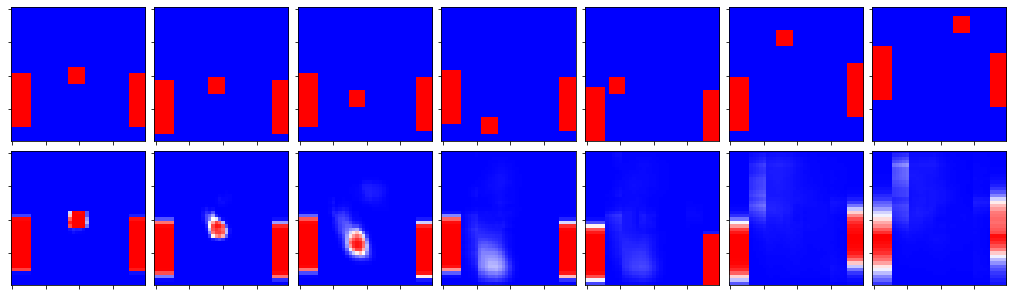

Epoch 618/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0824 - mean_squared_error: 0.0221 - acc: 0.9720 - val_loss: 0.0933 - val_mean_squared_error: 0.0258 - val_acc: 0.9669


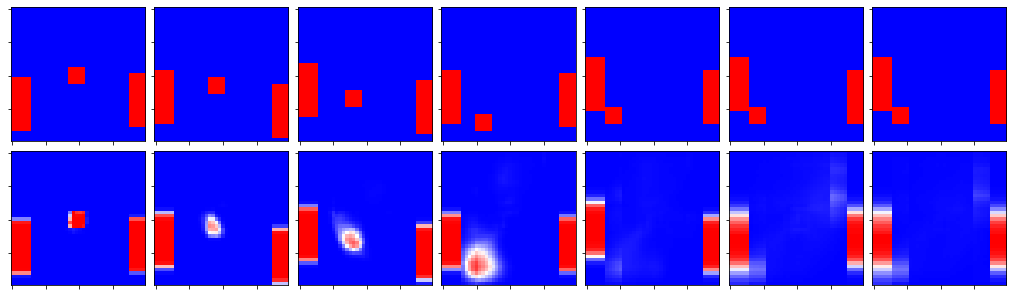

Epoch 619/2500
100/100 [==============================] - 50s 500ms/step - loss: 0.0830 - mean_squared_error: 0.0224 - acc: 0.9716 - val_loss: 0.0930 - val_mean_squared_error: 0.0257 - val_acc: 0.9665


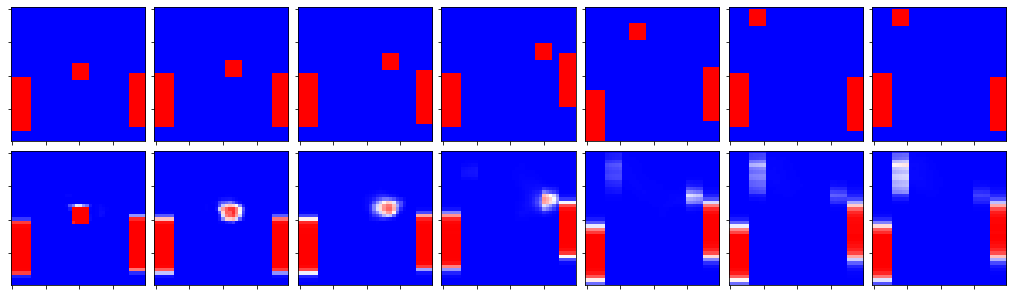

Epoch 620/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0840 - mean_squared_error: 0.0225 - acc: 0.9714 - val_loss: 0.0870 - val_mean_squared_error: 0.0234 - val_acc: 0.9704


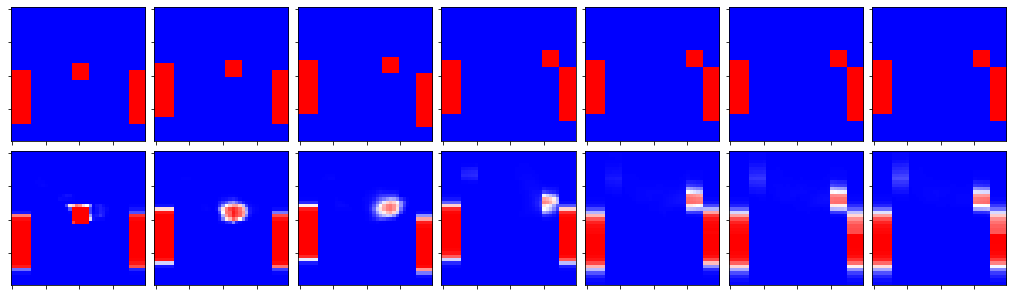

Epoch 621/2500
100/100 [==============================] - 50s 498ms/step - loss: 0.0830 - mean_squared_error: 0.0224 - acc: 0.9716 - val_loss: 0.0787 - val_mean_squared_error: 0.0213 - val_acc: 0.9732


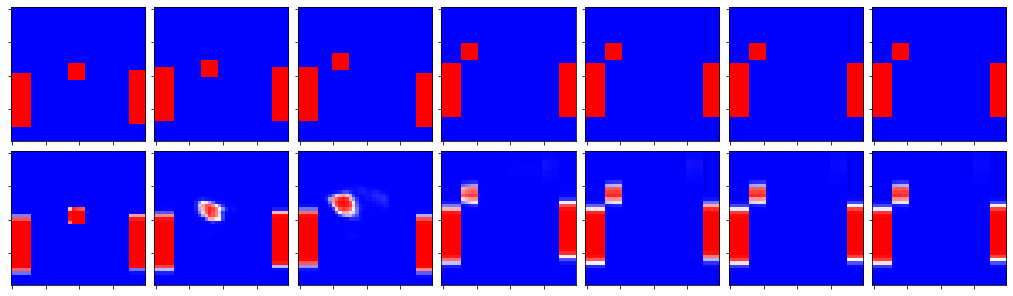

Epoch 622/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0813 - mean_squared_error: 0.0218 - acc: 0.9723 - val_loss: 0.0728 - val_mean_squared_error: 0.0195 - val_acc: 0.9756


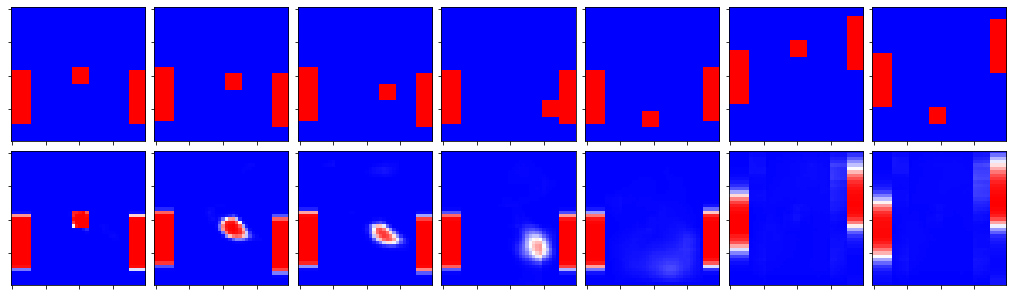

Epoch 623/2500
100/100 [==============================] - 50s 503ms/step - loss: 0.0827 - mean_squared_error: 0.0222 - acc: 0.9717 - val_loss: 0.0922 - val_mean_squared_error: 0.0238 - val_acc: 0.9700


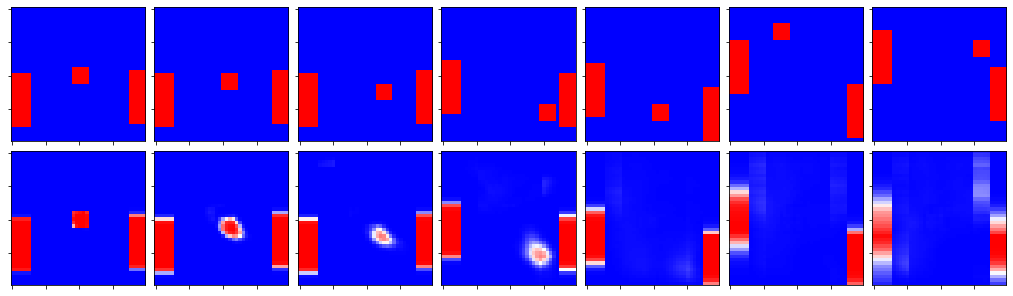

Epoch 624/2500
100/100 [==============================] - 50s 502ms/step - loss: 0.0818 - mean_squared_error: 0.0220 - acc: 0.9721 - val_loss: 0.0804 - val_mean_squared_error: 0.0214 - val_acc: 0.9726


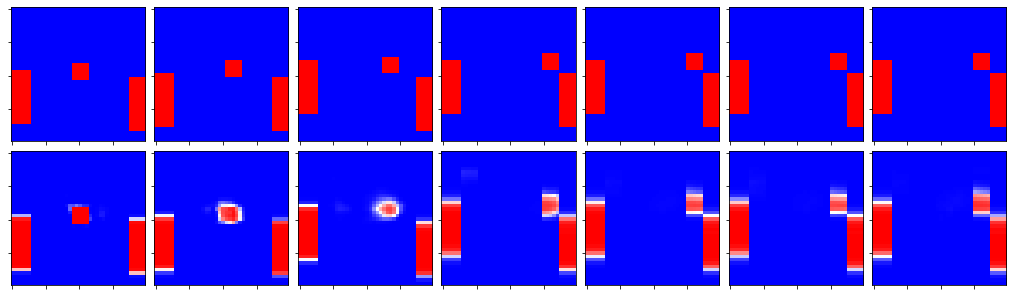

Epoch 625/2500
100/100 [==============================] - 55s 552ms/step - loss: 0.0853 - mean_squared_error: 0.0229 - acc: 0.9708 - val_loss: 0.0800 - val_mean_squared_error: 0.0213 - val_acc: 0.9734


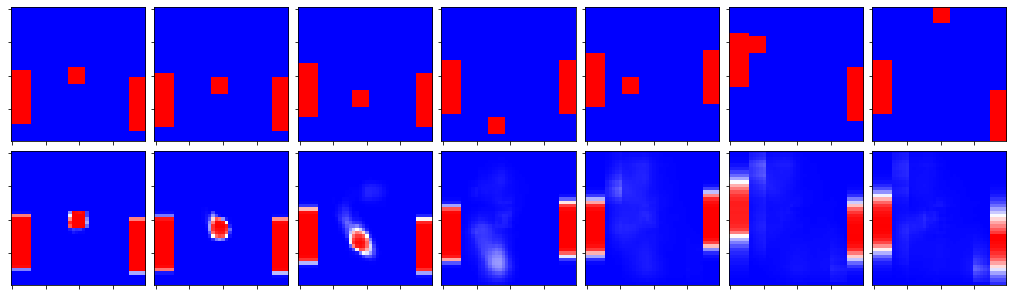

Epoch 626/2500
 83/100 [=======================>......] - ETA: 9s - loss: 0.0833 - mean_squared_error: 0.0222 - acc: 0.9718 

KeyboardInterrupt: 

In [108]:
input_generator = make_dataset(bs=32)

model.net.fit_generator(
    generator=input_generator,
    validation_data=input_generator,
    validation_steps=2,
    steps_per_epoch=100,
    epochs=2500,
    callbacks=[PlotCallback()]
)

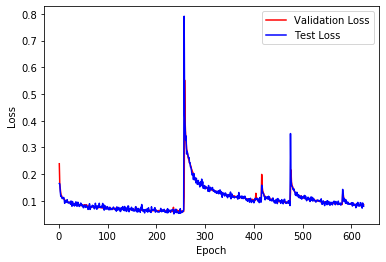

In [109]:
training_loss = model.net.history.history['loss']
test_loss = model.net.history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r')
plt.plot(epoch_count, test_loss, 'b')
plt.legend(['Validation Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# stateful = model.copy_in_stateful_model()
# stateful.init(0.4)
# t = 0
# 
# stateful.net.save('04-LSTM-GRU-32-BINARY_CROSSENTROPY_VERIED_INPUT.hdf5')

In [ ]:
# t += 1
# frame, _ = stateful.single_step_predict([-1, 1])

# plt.imshow(frame > 0.01)
# t